In [1]:
%load_ext autoreload
%autoreload 2

#Secreto - Credenciales
from read_secret import *
secret = load_credentials('jeanpalencia-secret')

cred_bq = secret['bigquery_json']
cred_prod = secret['db_prod']

host = cred_prod['host']
port= cred_prod['port_write']
user = cred_prod['user']
password = cred_prod['password']

#Queries
import mysql.connector as sql

#Data manipulation/visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Models
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
import xgboost as xgb
from lightgbm import LGBMRegressor
#from lightgbm import 
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [2]:
#Dataset
res = pd.read_csv("3392_por_am_fuentes_shap copy.csv", index_col=0)

In [3]:
fuentes = ['PP','CC','FR','M2','lonja_medellin','MLS','estudio_inmueble','ventanas','web','galeria_usados','inmobiliarias','galeria_nuevos']

p_fuentes = ['p_'+f for f in fuentes]
p_fuentes

dict_fuentes = {'PP':[],'CC':[],'FR':[],'M2':[],'lonja_medellin':[],'MLS':[],'estudio_inmueble':[],'ventanas':[],'web':[],'galeria_usados':[],
'inmobiliarias':[],'galeria_nuevos':[]}

for idx,row in res.iterrows():
    total_fila = row[fuentes].sum()
    for key in dict_fuentes.keys():
        try:
            dict_fuentes[key].append(row[key]/total_fila)
        except ZeroDivisionError:
            dict_fuentes[key].append(0)
        # print(key+': '+str(row[key]/total_fila))
    # break
    
for key in dict_fuentes.keys():
    res['p_'+key] = dict_fuentes[key]
    res[key+'_dummy'] = res[key].apply(lambda x: 1 if x>0 else 0)
    
def flag_confidences_value(x):
    if (x == 'A') | (x == 'B'):
        return 'alta'
    elif (x == 'C') | (x == 'D'):
        return 'media'
    else:
        return 'baja'
    
res['flag_confidence'] = res['bucket'].apply(lambda x: flag_confidences_value(x))
negocio_ids = tuple(res['negocio_id']) 

conn = sql.connect(user = user, password = password, host = host, port = port)
ciu_ant = pd.read_sql(f"""
SELECT 
    tni.id AS negocio_id,
    conj.latitud,
    conj.longitud,
    conj.ciudad_id,
    ciu.name,
    anos_antiguedad,
    IF(ti.tipo_inmueble_id = 1, 1, 2) AS tipo_inmueble,
    ti.garajes,
    ti.banos,
    IF(ti.num_ascensores>0, 1, 0) AS num_ascensores,
    ti.estrato,
    num_habitaciones
FROM habi_db.tabla_inmueble_v2 ti
JOIN habi_db.tabla_negocio_inmueble tni ON ti.id = tni.inmueble_id
LEFT JOIN habi_db.tabla_localizacion_inmueble_v2 conj ON ti.localizacion_new_id = conj.id
LEFT JOIN habi_db.tabla_lote tlote ON conj.lote_id = tlote.id
LEFT JOIN habi_db.tabla_ciudad ciu ON conj.ciudad_id = ciu.id
WHERE tni.id IN {negocio_ids};""",con=conn) 
conn.close()
ciu_ant['estrato'] = ciu_ant['estrato'].astype(float)

In [4]:
res_ciu_ant = res.merge(ciu_ant, on='negocio_id').copy()
res_ciu_ant = pd.concat(
    [res_ciu_ant,pd.get_dummies(res_ciu_ant['flag_confidence'])],
    axis=1).drop(
            columns=['flag_confidence']).copy()

In [5]:
res_ciu_ant.columns

Index(['inmueble_id', 'negocio_id', 'nid', 'fecha_comite', 'last_ask_price',
       'area', 'valormt2', 'valormt2_comite', 'ask_price_comite', 'pais',
       'area_metropolitana_id', 'type_test', 'ask_price_habimetro',
       'valormt2_habimetro', 'num_comparables', 'upper_bound', 'lower_bound',
       'coef_var', 'std_comparables', 'fecha_precio', 'version', 'bucket',
       'cantidad_por_fuente', 'diferencia_pp_last_ask_price',
       'diferencia_pp_valormt2', 'diferencia_pp_last_ask_price_comite',
       'diferencia_pp_valormt2_comite', 'consistencia_last_ask_price',
       'consistencia_valormt2', 'consistencia_last_ask_price_comite',
       'consistencia_valormt2_comite', 'web', 'galeria_usados',
       'estudio_inmueble', 'ventanas', 'inmobiliarias', 'galeria_nuevos', 'CC',
       'FR', 'M2', 'lonja_medellin', 'MLS', 'PP', 'p_PP', 'PP_dummy', 'p_CC',
       'CC_dummy', 'p_FR', 'FR_dummy', 'p_M2', 'M2_dummy', 'p_lonja_medellin',
       'lonja_medellin_dummy', 'p_MLS', 'MLS_dummy',

In [6]:
bogota = res_ciu_ant[res_ciu_ant['area_metropolitana_id']==1].dropna().copy()
valle_aburra = res_ciu_ant[res_ciu_ant['area_metropolitana_id']==2].dropna().copy()
cali = res_ciu_ant[res_ciu_ant['area_metropolitana_id']==3].dropna().copy()
bquilla = res_ciu_ant[res_ciu_ant['area_metropolitana_id']==5].dropna().copy()

bogota.shape[0],valle_aburra.shape[0],cali.shape[0],bquilla.shape[0]

(994, 1000, 809, 577)

In [7]:
bogota.ciudad_id.value_counts()

1     664
16    197
18     36
14     29
13     24
15     19
17     11
12     10
30      4
Name: ciudad_id, dtype: int64

In [8]:
valle_aburra.ciudad_id.value_counts()

2     336
3     290
7     121
5      82
4      66
6      53
19     31
9      17
8       4
Name: ciudad_id, dtype: int64

In [9]:
cali.ciudad_id.value_counts()

20    709
24     75
22     20
21      5
Name: ciudad_id, dtype: int64

In [10]:
bquilla.ciudad_id.value_counts()

27    545
28     32
Name: ciudad_id, dtype: int64

In [11]:
def mae(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs(actual - pred))

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    mape_ = np.mean(np.abs((actual - pred) / actual)) * 100
    if mape_ == np.inf:
        return 'inf por predicciones exactas'
    else:
        return mape_
    
class helper_object():
    """
    This wraps the shap object.
    It takes as input i, which indicates the index of the observation to be explained.
    """
    def __init__(self, i,sh):
        if isinstance(sh.base_values[i],float) or isinstance(sh.base_values[i],int):
            self.base_values = sh.base_values[i]
        else:
            self.base_values = sh.base_values[i][0]
        self.data = X_train_abs_p.iloc[i]
        self.feature_names = X.columns.to_list()
        self.values = sh.values[i]

- ~~Modelos base muy malos~~
- ~~correlaciones previas (graficas var vs error)~~
- ~~KNN~~

- min samples leaf
- min samples split
- lat y lon 
- valorm2
- LightGBM - num leaves 20-25%

Resourses for LightGBM:
- https://neptune.ai/blog/lightgbm-parameters-guide
- https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#tune-parameters-for-the-leaf-wise-best-first-tree

# Bogotá

In [12]:
#bogota = pd.concat([bogota,pd.get_dummies(bogota['name'])],axis=1)
columns_x_bog = p_fuentes.copy()
columns_x_bog.extend(['latitud','longitud','area','anos_antiguedad','tipo_inmueble',
                      'garajes', 'banos', 'num_ascensores', 'estrato',
                      'ask_price_comite','valormt2_comite','num_habitaciones','alta','media','baja'])
#columns_x_bog.extend(list(pd.get_dummies(bogota['name']).columns))
np.array(columns_x_bog).ravel()

array(['p_PP', 'p_CC', 'p_FR', 'p_M2', 'p_lonja_medellin', 'p_MLS',
       'p_estudio_inmueble', 'p_ventanas', 'p_web', 'p_galeria_usados',
       'p_inmobiliarias', 'p_galeria_nuevos', 'latitud', 'longitud',
       'area', 'anos_antiguedad', 'tipo_inmueble', 'garajes', 'banos',
       'num_ascensores', 'estrato', 'ask_price_comite', 'valormt2_comite',
       'num_habitaciones', 'alta', 'media', 'baja'], dtype='<U18')

In [13]:
X_bogota = bogota[columns_x_bog]
X_bogota = X_bogota[[col for col in X_bogota.columns if (
    (X_bogota[col].sum()!=0) |
    (col=='alta')|(col=='media')|(col=='baja')
    )]]
X_bogota.columns

Index(['p_CC', 'p_FR', 'p_M2', 'p_estudio_inmueble', 'p_ventanas', 'p_web',
       'p_galeria_nuevos', 'latitud', 'longitud', 'area', 'anos_antiguedad',
       'tipo_inmueble', 'garajes', 'banos', 'num_ascensores', 'estrato',
       'ask_price_comite', 'valormt2_comite', 'num_habitaciones', 'alta',
       'media', 'baja'],
      dtype='object')

In [179]:
#Train-Test Split + Escalado
X_bogota = bogota[columns_x_bog]
X_bogota = X_bogota[[col for col in X_bogota.columns if (
    (X_bogota[col].sum()!=0) |
    (col=='alta')|(col=='media')|(col=='baja')
    )]]
r_scaler_bogota = preprocessing.RobustScaler()
r_scaler_bogota.fit(X_bogota)
X_new_bogota = r_scaler_bogota.transform(X_bogota)
y_bogota = abs(bogota['diferencia_pp_last_ask_price_comite']*100)
X_train_abs_p_bogota, X_test_abs_p_bogota, y_train_abs_p_bogota, y_test_abs_p_bogota = train_test_split(
    X_new_bogota, y_bogota,test_size=0.30, random_state=42)

#Modelo XGB
xgb_bog = xgb.XGBRegressor(objective ='reg:squarederror',
                           eval_metric = 'mae',
                           learning_rate = 0.01,
                           max_depth = 2,
                           n_estimators = 1000, gamma=0.1, random_state=42)
xgb_bog.fit(X_train_abs_p_bogota,y_train_abs_p_bogota)

#Modelo Tree
tree_bog = RandomForestRegressor(criterion="squared_error",
                                 max_features='sqrt',
                                 max_depth=10,
                                 n_estimators=511,
                                 n_jobs=6,
                                 random_state=42)
tree_bog.fit(X_train_abs_p_bogota,y_train_abs_p_bogota)

#Modelo Knn
#neigh_bog = KNeighborsRegressor(n_neighbors=5,weights='uniform')
#neigh_bog.fit(X_train_abs_p_bogota,y_train_abs_p_bogota)

#LGBM
lightgbm_params_bog = {'objective': 'regression',
          'metric': 'rmse',
          'num_leaves': np.int(np.ceil(len(X_bogota)*0.2)),
          'min_data_in_leaf':20,
          'max_depth':10,
          'learning_rate': 0.01,
          'verbose': -1,
        'n_estimators':500
             }

lgbm_bog = LGBMRegressor(**lightgbm_params_bog)
lgbm_model = lgbm_bog.fit(X_train_abs_p_bogota, y_train_abs_p_bogota)                           


#Predicción
y_train_pred_abs_P_bogota_xgb = xgb_bog.predict(X_train_abs_p_bogota)
y_test_pred_abs_P_bogota_xgb = xgb_bog.predict(X_test_abs_p_bogota)

y_train_pred_abs_P_bogota_tree = tree_bog.predict(X_train_abs_p_bogota)
y_test_pred_abs_P_bogota_tree = tree_bog.predict(X_test_abs_p_bogota)

#y_train_pred_abs_P_bogota_knn = neigh_bog.predict(X_train_abs_p_bogota)
#y_test_pred_abs_P_bogota_knn = neigh_bog.predict(X_test_abs_p_bogota)

y_train_pred_abs_P_bogota_lgbm = lgbm_bog.predict(X_train_abs_p_bogota)
y_test_pred_abs_P_bogota_lgbm = lgbm_bog.predict(X_test_abs_p_bogota)

#Métricas
pd.DataFrame({'MSE_train': [mean_squared_error(y_train_abs_p_bogota,y_train_pred_abs_P_bogota_xgb),
                            mean_squared_error(y_train_abs_p_bogota,y_train_pred_abs_P_bogota_tree),
                           mean_squared_error(y_train_abs_p_bogota,y_train_pred_abs_P_bogota_lgbm)],
'RMSE_train': [np.sqrt(mean_squared_error(y_train_abs_p_bogota,y_train_pred_abs_P_bogota_xgb)),
               np.sqrt(mean_squared_error(y_train_abs_p_bogota,y_train_pred_abs_P_bogota_tree)),
              np.sqrt(mean_squared_error(y_train_abs_p_bogota,y_train_pred_abs_P_bogota_lgbm))],
'MSE_test': [mean_squared_error(y_test_abs_p_bogota,y_test_pred_abs_P_bogota_xgb),
             mean_squared_error(y_test_abs_p_bogota,y_test_pred_abs_P_bogota_tree),
            mean_squared_error(y_test_abs_p_bogota,y_test_pred_abs_P_bogota_lgbm)],
'RMSE_test': [np.sqrt(mean_squared_error(y_test_abs_p_bogota,y_test_pred_abs_P_bogota_xgb)),
              np.sqrt(mean_squared_error(y_test_abs_p_bogota,y_test_pred_abs_P_bogota_tree)),
             np.sqrt(mean_squared_error(y_test_abs_p_bogota,y_test_pred_abs_P_bogota_lgbm))],
'MAE_train': [mae(y_train_abs_p_bogota,y_train_pred_abs_P_bogota_xgb),
              mae(y_train_abs_p_bogota,y_train_pred_abs_P_bogota_tree),
             mae(y_train_abs_p_bogota,y_train_pred_abs_P_bogota_lgbm)],
'MAPE_train': [mape(y_train_abs_p_bogota,y_train_pred_abs_P_bogota_xgb),
               mape(y_train_abs_p_bogota,y_train_pred_abs_P_bogota_tree),
              mape(y_train_abs_p_bogota,y_train_pred_abs_P_bogota_lgbm)],
'MAE_test': [mae(y_test_abs_p_bogota,y_test_pred_abs_P_bogota_xgb),
             mae(y_test_abs_p_bogota,y_test_pred_abs_P_bogota_tree),
             mae(y_test_abs_p_bogota,y_test_pred_abs_P_bogota_lgbm)],
'MAPE_test': [mape(y_test_abs_p_bogota,y_test_pred_abs_P_bogota_xgb),
              mape(y_test_abs_p_bogota,y_test_pred_abs_P_bogota_tree),
             mape(y_test_abs_p_bogota,y_test_pred_abs_P_bogota_lgbm)],
'R2_train': [r2_score(y_train_abs_p_bogota,y_train_pred_abs_P_bogota_xgb),
             r2_score(y_train_abs_p_bogota,y_train_pred_abs_P_bogota_tree),
            r2_score(y_train_abs_p_bogota,y_train_pred_abs_P_bogota_lgbm)],
'R2_test': [r2_score(y_test_abs_p_bogota,y_test_pred_abs_P_bogota_xgb),
            r2_score(y_test_abs_p_bogota,y_test_pred_abs_P_bogota_tree),
           r2_score(y_test_abs_p_bogota,y_test_pred_abs_P_bogota_lgbm)]},index=['xgb','tree','lgbm'])

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


divide by zero encountered in true_divide


MSE_train  RMSE_train   MSE_test  RMSE_test  MAE_train  \
xgb   28.156003    5.306223  44.473626   6.668855   3.778392   
tree  16.067877    4.008476  36.415306   6.034510   2.922535   
lgbm  25.008321    5.000832  38.104633   6.172895   2.608853   

                        MAPE_train  MAE_test                     MAPE_test  \
xgb   inf por predicciones exactas  4.409531  inf por predicciones exactas   
tree  inf por predicciones exactas  4.092313  inf por predicciones exactas   
lgbm  inf por predicciones exactas  4.132179  inf por predicciones exactas   

      R2_train   R2_test  
xgb   0.544215  0.078764  
tree  0.739896  0.245686  
lgbm  0.595169  0.210693

In [167]:
np.sqrt(np.square(np.subtract(y_test_abs_p_bogota,y_test_pred_abs_P_bogota_tree))).describe()

count    299.000000
mean       4.089280
std        4.418154
min        0.056854
25%        1.615024
50%        3.301245
75%        5.553467
max       54.216600
Name: diferencia_pp_last_ask_price_comite, dtype: float64

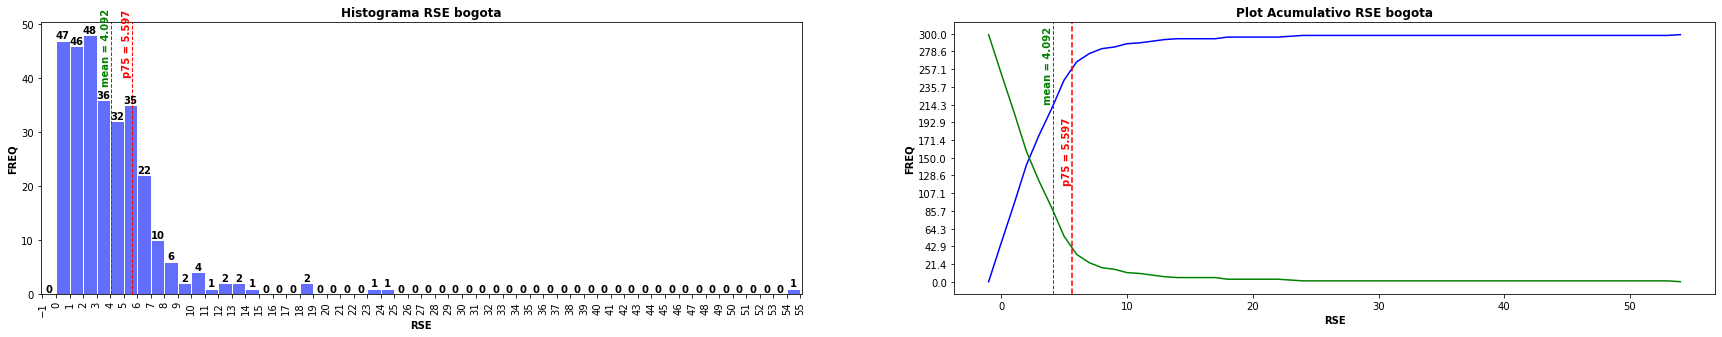

In [180]:
se = np.square(np.subtract(y_test_abs_p_bogota,y_test_pred_abs_P_bogota_tree))
rse = np.sqrt(se)

bins_= np.append(np.unique([int(np.ceil(x)) for x in np.sort(np.append(np.arange(-1, rse.max()),0))]),np.int(rse.max()+1))
bins_

plt.figure(figsize=(30,5))
plt.subplot(121)
freq, bins, patches = plt.hist(rse,bins=bins_, edgecolor='w',color='#636efa')
plt.xticks(bins_)

# x coordinate for labels
bin_centers = np.diff(bins)*0.5 + bins[:-1]

n = 0
for fr, x, patch in zip(freq, bin_centers, patches):
    height = int(freq[n])
    plt.annotate("{}".format(height),
               xy = (x, height),             # top left corner of the histogram bar
               xytext = (0,0.2),             # offsetting label position above its bar
               textcoords = "offset points", # Offset (in points) from the *xy* value
               ha = 'center', va = 'bottom',fontweight='bold'
               )
    n = n+1
plt.axvline(np.quantile(rse,.75), color='r', linestyle='dashed', linewidth=1)
plt.text(np.quantile(rse,.75), 53, f'p75 = {np.round(np.quantile(rse,.75),3)}', color='r', ha='right', va='top', rotation=90,fontweight='bold')

plt.axvline(np.mean(rse), color='g', linestyle='dashed', linewidth=1)
plt.text(np.mean(rse), 53, f'mean = {np.round(np.mean(rse),3)}', color='g', ha='right', va='top', rotation=90,fontweight='bold')

plt.title('Histograma RSE bogota',fontweight='bold')
plt.xlabel('RSE',fontweight='bold')
plt.ylabel('FREQ',fontweight='bold')
plt.xticks(rotation=90)
plt.margins(x=0.002)

plt.subplot(122)
cumulative = np.cumsum(freq)
plt.plot(bins[:-1], cumulative, c='blue')
plt.plot(bins[:-1], len(rse)-cumulative, c='green')
plt.yticks(np.linspace(min(cumulative), max(cumulative)+1, 15))

plt.axvline(np.quantile(rse,.75),color='r', linestyle='dashed')
#plt.axhline(cumulative[len(bins[bins<np.quantile(rse,.75)])])
plt.text(np.quantile(rse,.75), 200, f'p75 = {np.round(np.quantile(rse,.75),3)}', color='r', ha='right', va='top', rotation=90,fontweight='bold')

plt.axvline(np.mean(rse), color='g', linestyle='dashed', linewidth=1)
plt.text(np.mean(rse), 310, f'mean = {np.round(np.mean(rse),3)}', color='g', ha='right', va='top', rotation=90,fontweight='bold')

plt.title('Plot Acumulativo RSE bogota',fontweight='bold')
plt.xlabel('RSE',fontweight='bold')
plt.ylabel('FREQ',fontweight='bold')
plt.savefig("bogota_rmse_dist.svg")
plt.show()

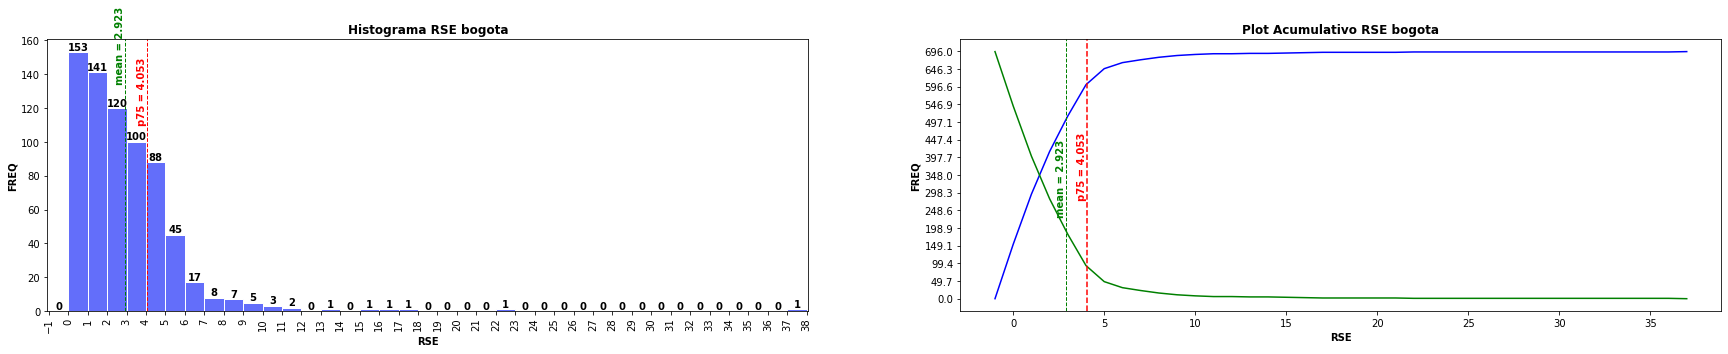

In [181]:
se = np.square(np.subtract(y_train_abs_p_bogota,y_train_pred_abs_P_bogota_tree))
rse = np.sqrt(se)

bins_= np.append(np.unique([int(np.ceil(x)) for x in np.sort(np.append(np.arange(-1, rse.max()),0))]),np.int(rse.max()+1))
bins_

plt.figure(figsize=(30,5))
plt.subplot(121)
freq, bins, patches = plt.hist(rse,bins=bins_, edgecolor='w',color='#636efa')
plt.xticks(bins_)

# x coordinate for labels
bin_centers = np.diff(bins)*0.5 + bins[:-1]

n = 0
for fr, x, patch in zip(freq, bin_centers, patches):
    height = int(freq[n])
    plt.annotate("{}".format(height),
               xy = (x, height),             # top left corner of the histogram bar
               xytext = (0,0.2),             # offsetting label position above its bar
               textcoords = "offset points", # Offset (in points) from the *xy* value
               ha = 'center', va = 'bottom',fontweight='bold'
               )
    n = n+1
plt.axvline(np.quantile(rse,.75), color='r', linestyle='dashed', linewidth=1)
plt.text(np.quantile(rse,.75), 150, f'p75 = {np.round(np.quantile(rse,.75),3)}', color='r', ha='right', va='top', rotation=90,fontweight='bold')

plt.axvline(np.mean(rse), color='g', linestyle='dashed', linewidth=1)
plt.text(np.mean(rse), 180, f'mean = {np.round(np.mean(rse),3)}', color='g', ha='right', va='top', rotation=90,fontweight='bold')

plt.title('Histograma RSE bogota',fontweight='bold')
plt.xlabel('RSE',fontweight='bold')
plt.ylabel('FREQ',fontweight='bold')
plt.xticks(rotation=90)
plt.margins(x=0.002)

plt.subplot(122)
cumulative = np.cumsum(freq)
plt.plot(bins[:-1], cumulative, c='blue')
plt.plot(bins[:-1], len(rse)-cumulative, c='green')
plt.yticks(np.linspace(min(cumulative), max(cumulative)+1, 15))

plt.axvline(np.quantile(rse,.75),color='r', linestyle='dashed')
#plt.axhline(cumulative[len(bins[bins<np.quantile(rse,.75)])])
plt.text(np.quantile(rse,.75), 470, f'p75 = {np.round(np.quantile(rse,.75),3)}', color='r', ha='right', va='top', rotation=90,fontweight='bold')

plt.axvline(np.mean(rse), color='g', linestyle='dashed', linewidth=1)
plt.text(np.mean(rse), 450, f'mean = {np.round(np.mean(rse),3)}', color='g', ha='right', va='top', rotation=90,fontweight='bold')

plt.title('Plot Acumulativo RSE bogota',fontweight='bold')
plt.xlabel('RSE',fontweight='bold')
plt.ylabel('FREQ',fontweight='bold')
plt.savefig("bogota_rmse_dist.svg")
plt.show()

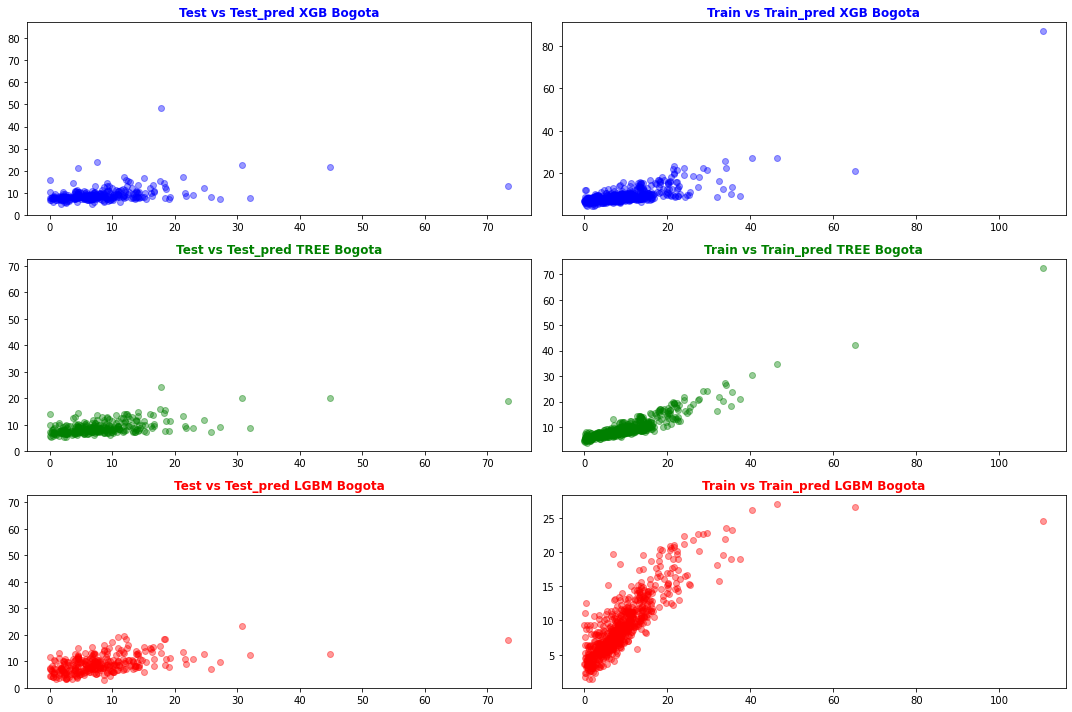

In [182]:
plt.figure(figsize=(15,10))

#XGB
plt.subplot(321)
plt.title('Test vs Test_pred XGB Bogota', fontweight='bold', color='b')
plt.scatter(y_test_abs_p_bogota,y_test_pred_abs_P_bogota_xgb, color='b', alpha=.4)
plt.ylim(0,np.max(y_train_pred_abs_P_bogota_xgb))

plt.subplot(322)
plt.title('Train vs Train_pred XGB Bogota', fontweight='bold', color='b')
plt.scatter(y_train_abs_p_bogota,y_train_pred_abs_P_bogota_xgb, color='b', alpha=.4)

#TREE
plt.subplot(323)
plt.title('Test vs Test_pred TREE Bogota', fontweight='bold', color='g')
plt.scatter(y_test_abs_p_bogota,y_test_pred_abs_P_bogota_tree, color='g', alpha=.4)
plt.ylim(0,np.max(y_train_pred_abs_P_bogota_tree))

plt.subplot(324)
plt.title('Train vs Train_pred TREE Bogota', fontweight='bold', color='g')
plt.scatter(y_train_abs_p_bogota,y_train_pred_abs_P_bogota_tree, color='g', alpha=.4)

#TREE
plt.subplot(325)
plt.title('Test vs Test_pred LGBM Bogota', fontweight='bold', color='r')
plt.scatter(y_test_abs_p_bogota,y_test_pred_abs_P_bogota_lgbm, color='r', alpha=.4)
plt.ylim(0,np.max(y_train_pred_abs_P_bogota_tree))

plt.subplot(326)
plt.title('Train vs Train_pred LGBM Bogota', fontweight='bold', color='r')
plt.scatter(y_train_abs_p_bogota,y_train_pred_abs_P_bogota_lgbm, color='r', alpha=.4)
plt.tight_layout()
plt.show()

In [164]:
heat_bog = bogota[list(X_bogota.columns)+['diferencia_pp_last_ask_price_comite']].copy()
heat_bog['objetivo'] = heat_bog['diferencia_pp_last_ask_price_comite'].apply(lambda x: np.abs(x)*100)
heat_bog.drop(columns=['diferencia_pp_last_ask_price_comite'],inplace=True)

In [165]:
corrs_bog = heat_bog.corr()

In [166]:
heat_bog.columns

Index(['p_CC', 'p_FR', 'p_M2', 'p_estudio_inmueble', 'p_ventanas', 'p_web',
       'p_galeria_nuevos', 'latitud', 'longitud', 'area', 'anos_antiguedad',
       'tipo_inmueble', 'garajes', 'banos', 'num_ascensores', 'estrato',
       'ask_price_comite', 'valormt2_comite', 'num_habitaciones', 'alta',
       'media', 'baja', 'objetivo'],
      dtype='object')

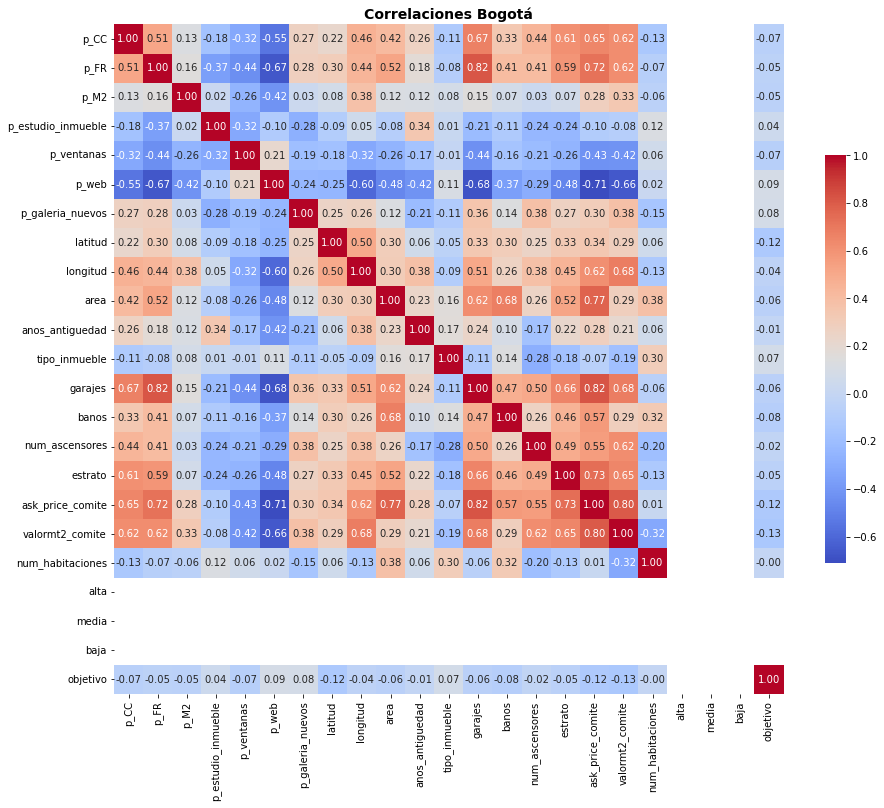

In [167]:
plt.figure(figsize=(15,15))
sns.heatmap(data=corrs_bog,square=True,annot=True,annot_kws={'size': 10},fmt= '.2f',cmap='coolwarm',cbar_kws={"shrink": 0.5})
plt.xticks(rotation = 90,fontsize=10, horizontalalignment='center')
plt.yticks(rotation = 0,fontsize=10)
plt.title("Correlaciones Bogotá",fontsize=14, weight='bold')
plt.show()

In [155]:
aptos_bog = heat_bog[heat_bog.tipo_inmueble == 1].drop(columns=['tipo_inmueble']).copy()
#aptos_bog = aptos_bog[[col for col in aptos_bog.columns if aptos_bog[col].sum()!=0]]
casas_bog = heat_bog[heat_bog.tipo_inmueble == 2].drop(columns=['tipo_inmueble']).copy()
#casas_bog = casas_bog[[col for col in casas_bog.columns if casas_bog[col].sum()!=0]]
tipo_inmueble_heat_bog = [aptos_bog,casas_bog]

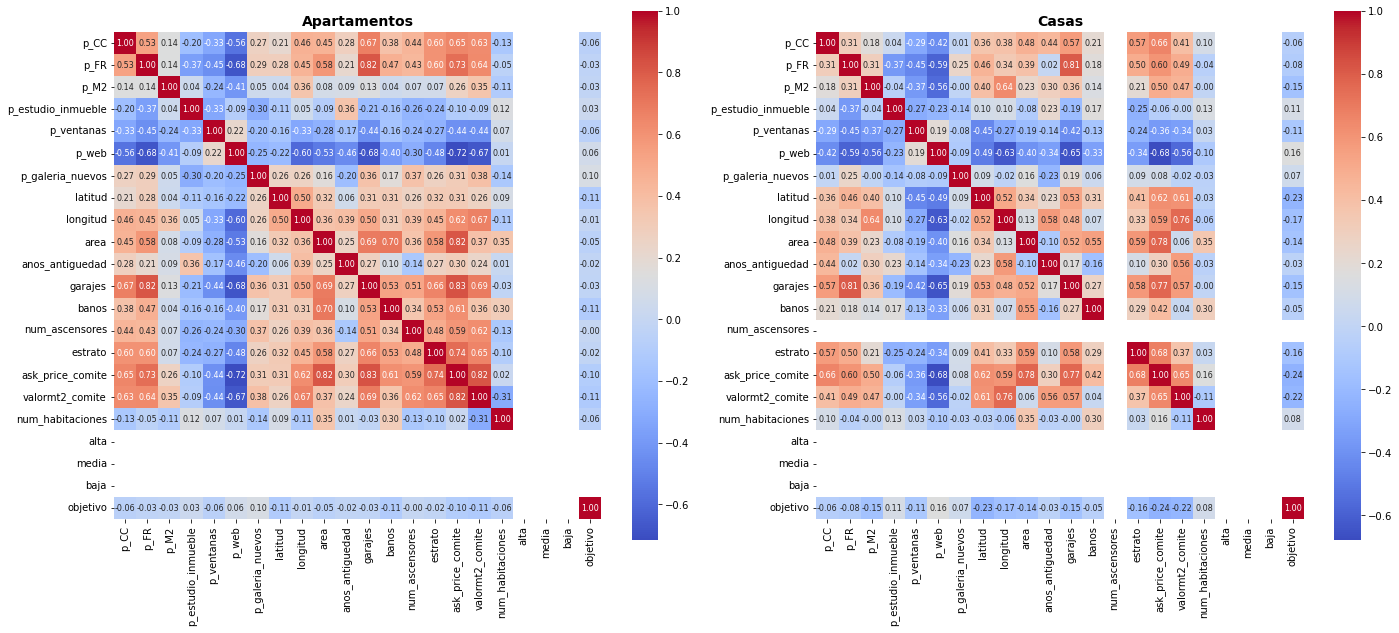

In [156]:
property_names = ['Apartamentos','Casas']
plt.figure(figsize=(20,15))
for i in range(len(tipo_inmueble_heat_bog)):
    plt.subplot(1,2,i+1)
    sns.heatmap(data=tipo_inmueble_heat_bog[i].corr(),
                square=True,annot=True,annot_kws={'size': 8},fmt= '.2f',cmap='coolwarm',cbar_kws={"shrink": 0.5})
    plt.xticks(rotation = 90,fontsize=10, horizontalalignment='center')
    plt.yticks(rotation = 0,fontsize=10)
    plt.title(property_names[i],fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

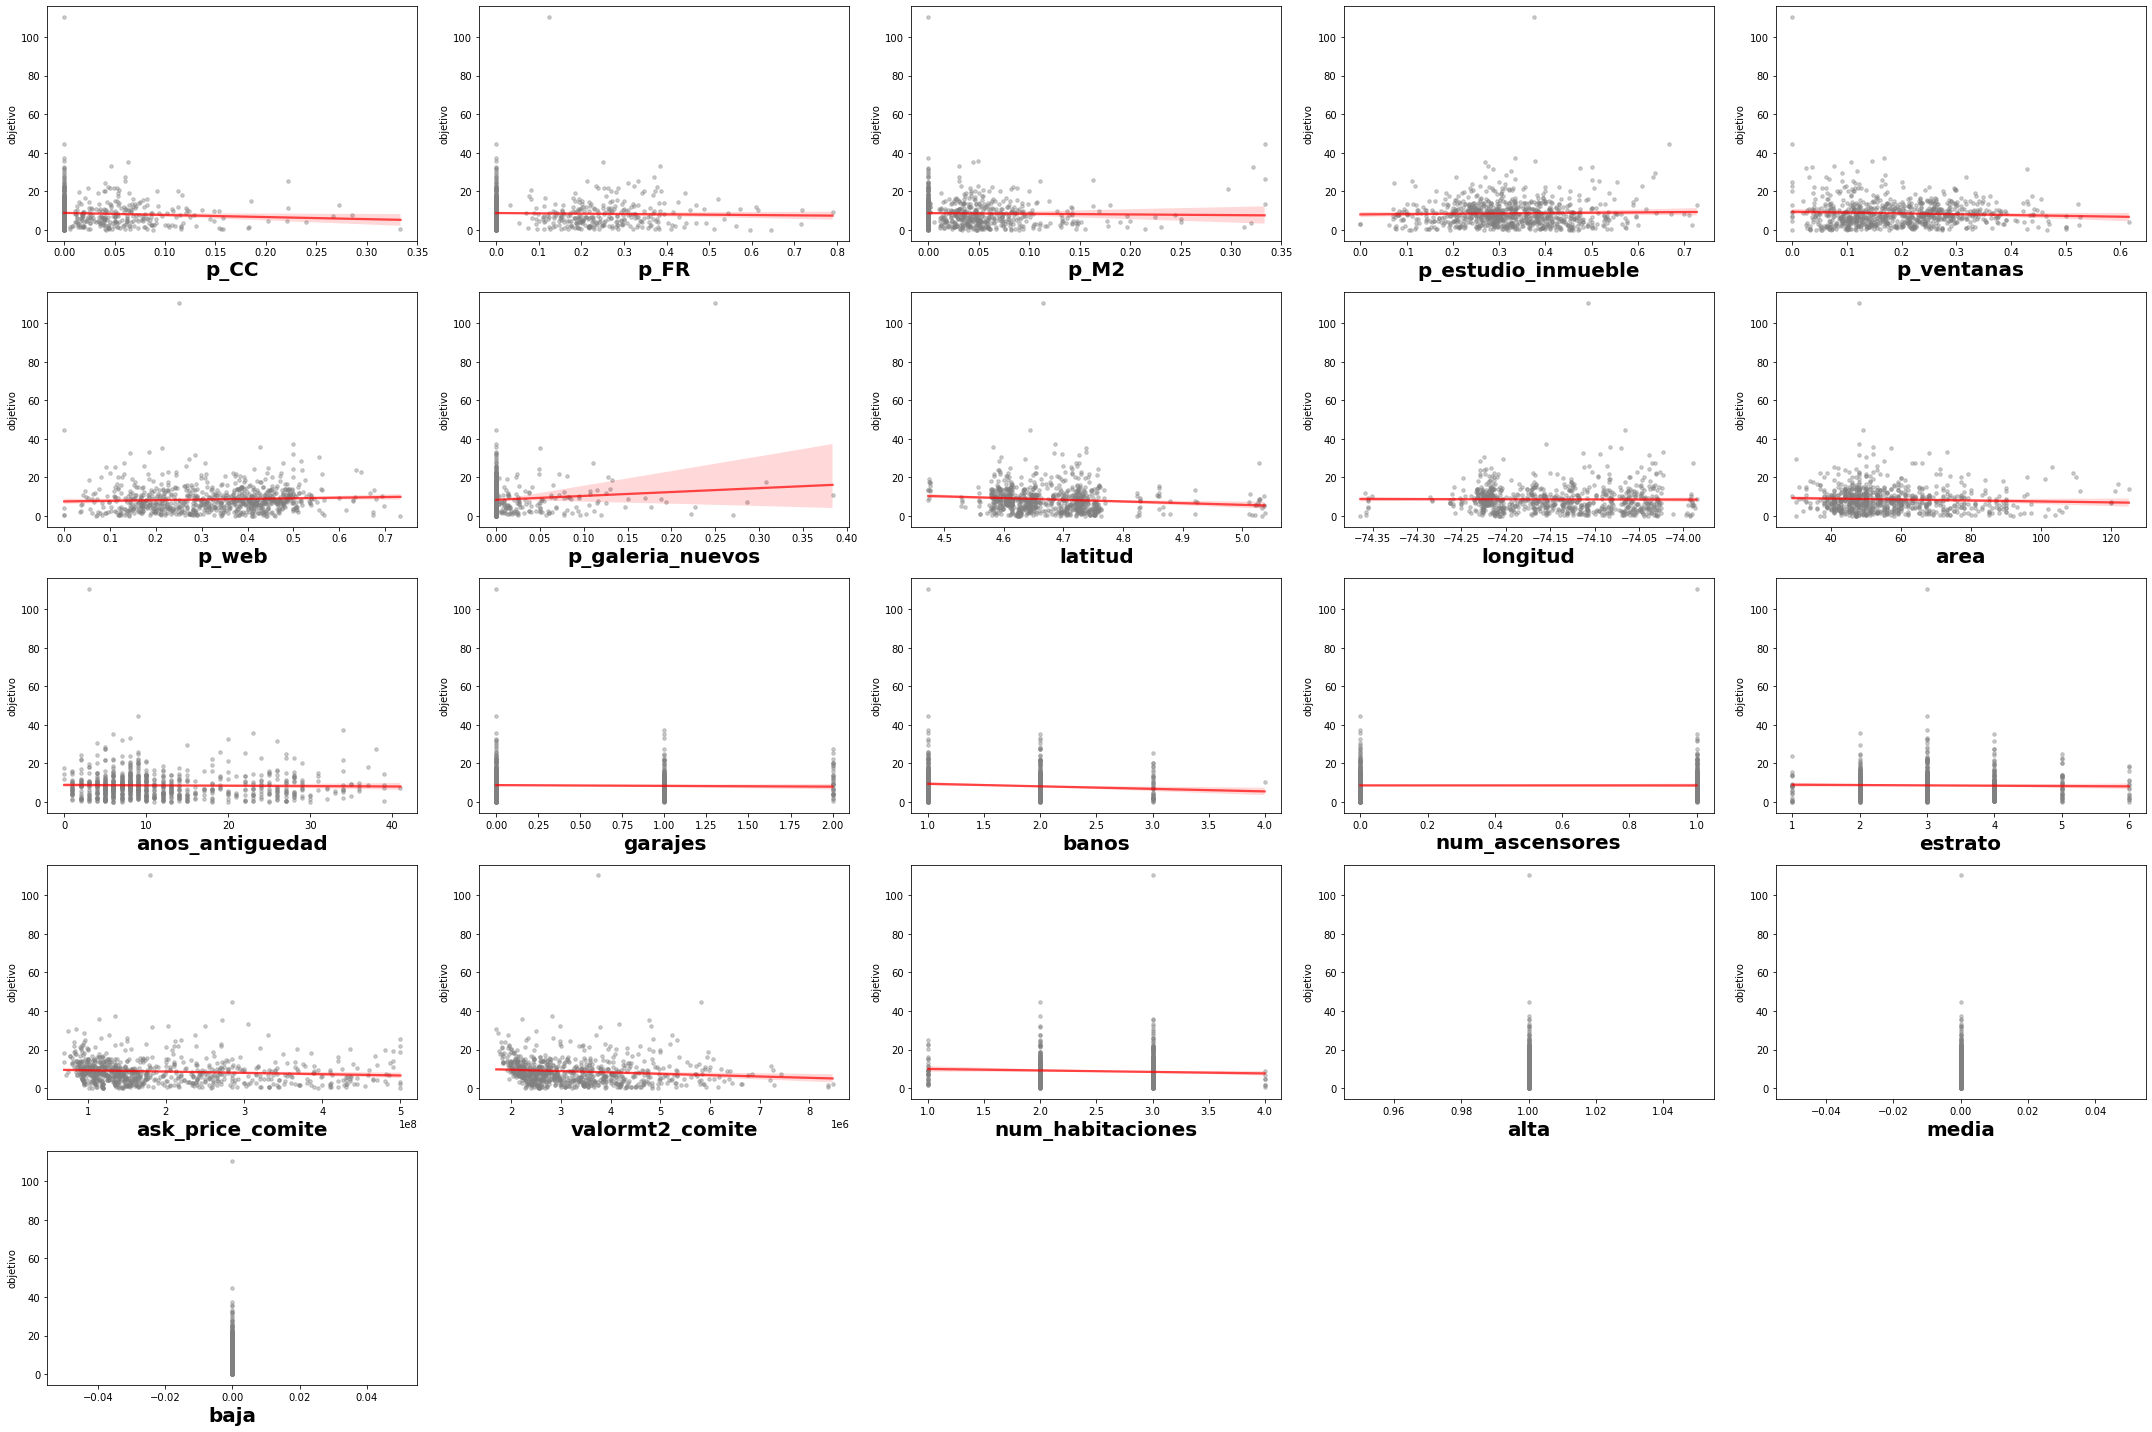

In [158]:
plt.figure(figsize=(30,20))
for idx,col in enumerate(aptos_bog.columns):
    if col !='objetivo':
        plt.subplot(5,5,idx+1)
        sns.regplot(
            x           = aptos_bog[col],
            y           = aptos_bog['objetivo'],
            color       = "gray",
            marker      = '.',
            scatter_kws = {"alpha":0.4,"s":50},
            line_kws    = {"color":"r","alpha":0.7}
        )
        #plt.title(f'{col} vs abs(diferencia_pp_comite)*100', fontweight='bold',fontsize=18, color='#490089')
        plt.xlabel(col, fontweight='bold',fontsize=20)
        #plt.ylabel('abs(diferencia_pp_comite)*100', fontweight='bold',fontsize=18)
plt.tight_layout()

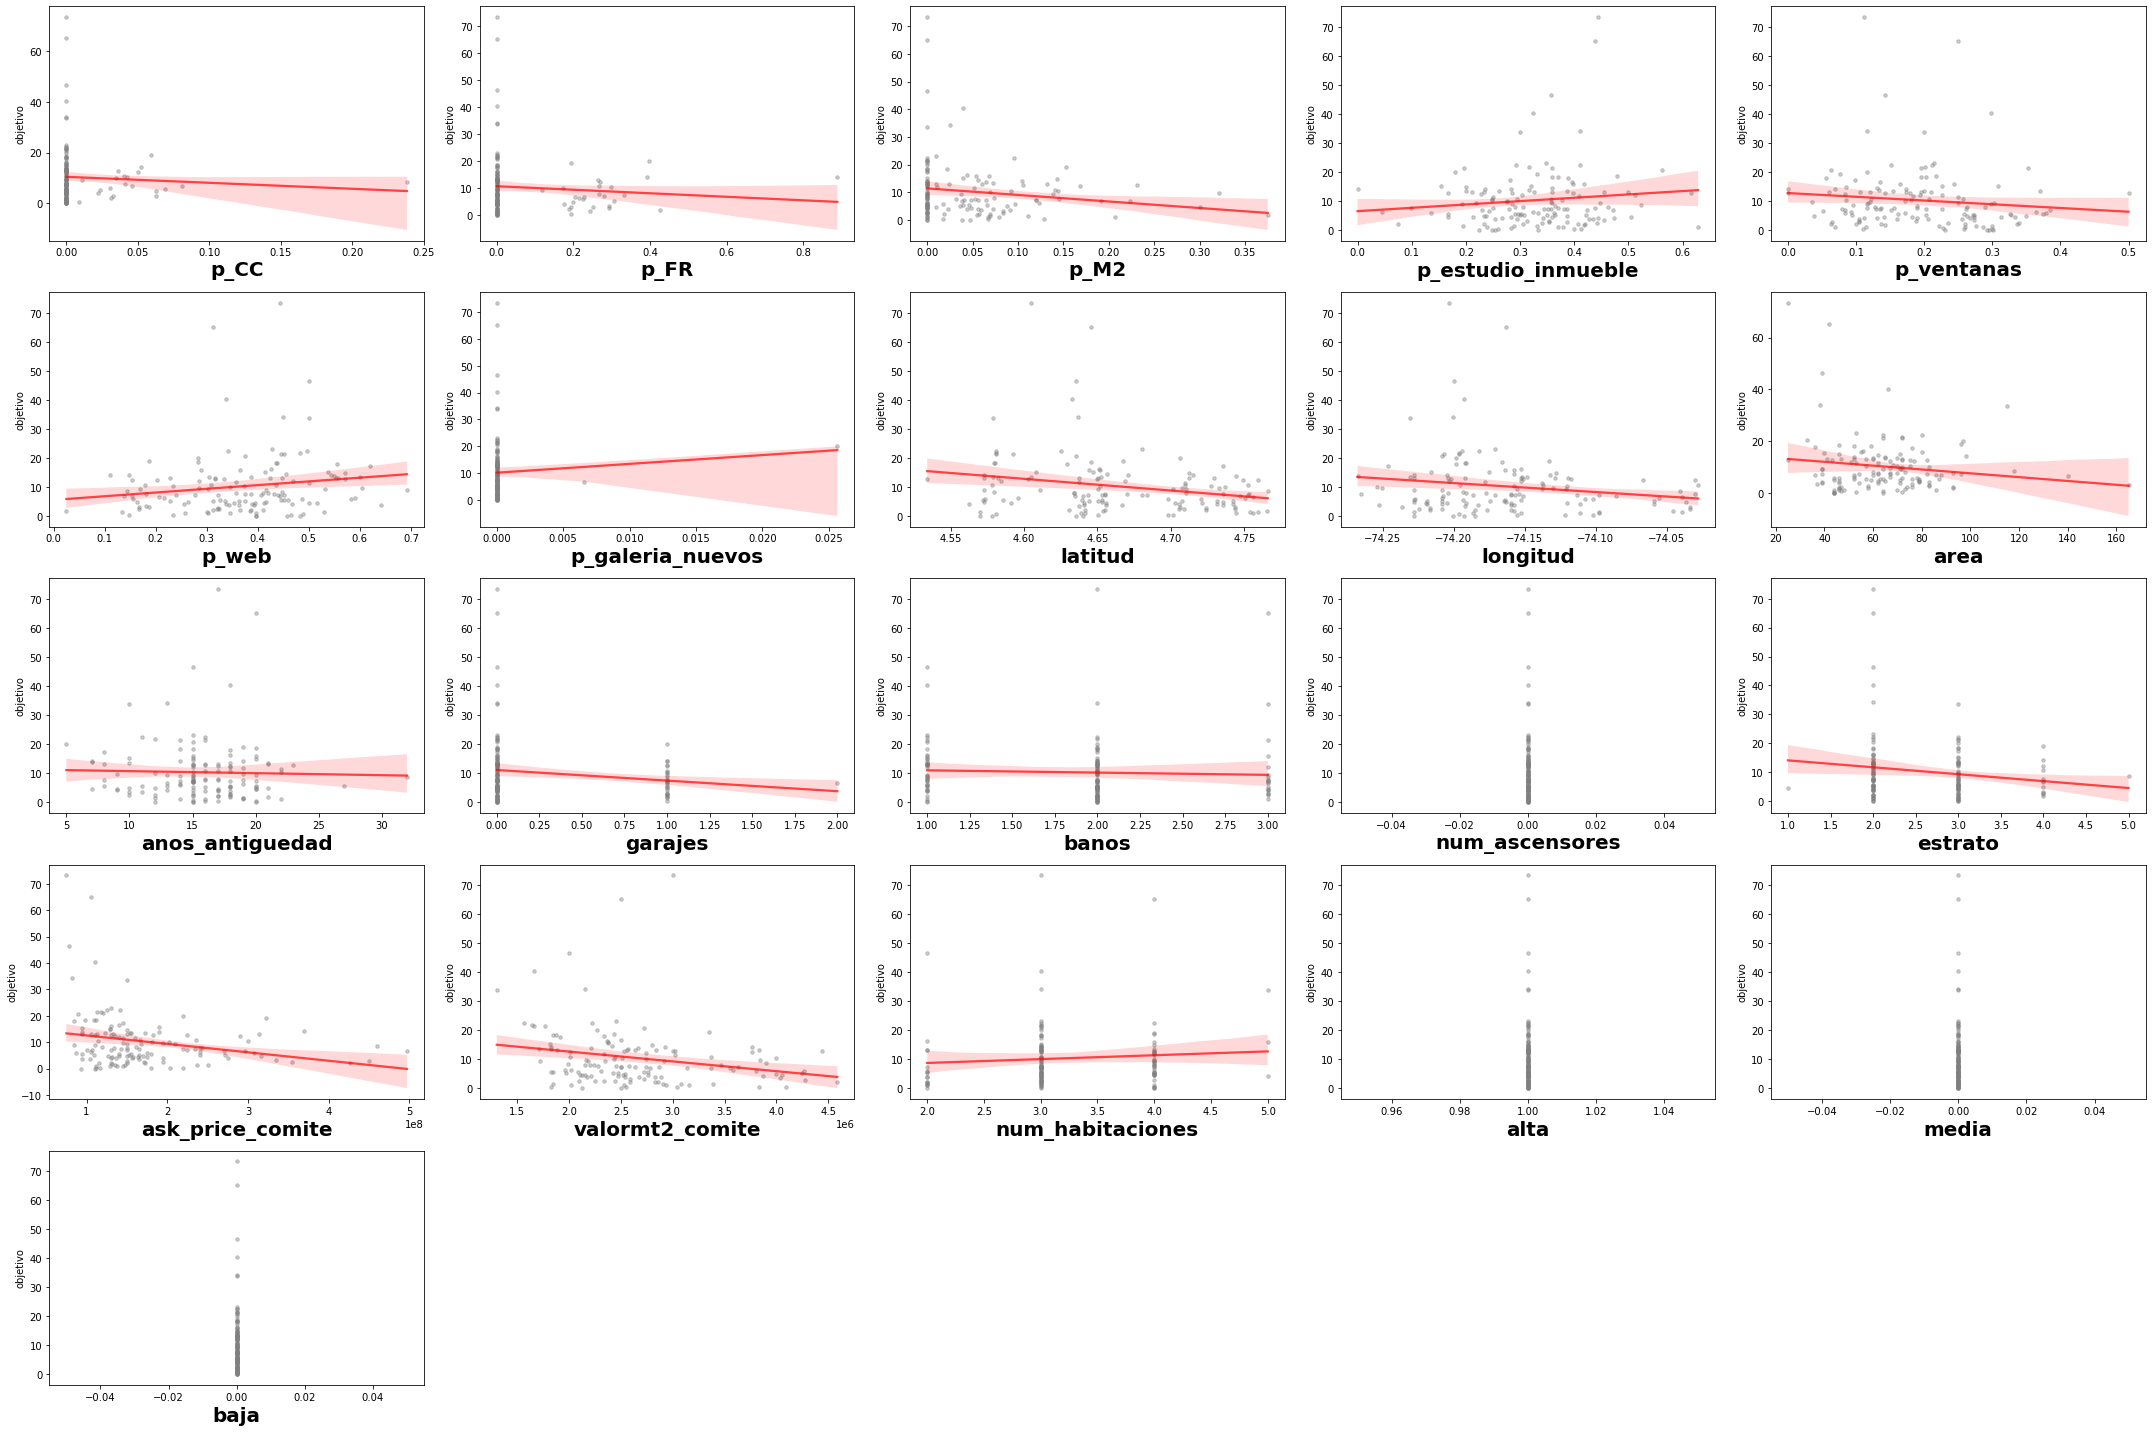

In [159]:
plt.figure(figsize=(30,20))
for idx,col in enumerate(casas_bog.columns):
    if col !='objetivo':
        plt.subplot(5,5,idx+1)
        sns.regplot(
            x           = casas_bog[col],
            y           = casas_bog['objetivo'],
            color       = "gray",
            marker      = '.',
            scatter_kws = {"alpha":0.4,"s":50},
            line_kws    = {"color":"r","alpha":0.7}
        )
        #plt.title(f'{col} vs abs(diferencia_pp_comite)*100', fontweight='bold',fontsize=18, color='#490089')
        plt.xlabel(col, fontweight='bold',fontsize=20)
        #plt.ylabel('abs(diferencia_pp_comite)*100', fontweight='bold',fontsize=18)
plt.tight_layout()
    #break

In [168]:
y_test_abs_p_bogota.iloc[12],y_train_pred_abs_P_bogota_tree[12],y_train_pred_abs_P_bogota_xgb[12]

(10.189287409041151, 12.494605705736642, 13.975277)

In [31]:
# random sampler
sampler = TPESampler(seed=42)
# Train-Test split
X_bogota = bogota[columns_x_bog]
r_scaler_bogota = preprocessing.RobustScaler()
r_scaler_bogota.fit(X_bogota)
X_new_bogota = r_scaler_bogota.transform(X_bogota)
y_bogota = abs(bogota['diferencia_pp_last_ask_price_comite']*100)
X_train_abs_p_bogota, X_test_abs_p_bogota, y_train_abs_p_bogota, y_test_abs_p_bogota = train_test_split(
    X_new_bogota, y_bogota,test_size=0.30, random_state=42)

# define function
def objective_bogota(trial):

    rf_param = {
        "criterion":"squared_error",
        "max_features":'sqrt',
        "max_depth":trial.suggest_int('max_depth',5, 10),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        "n_jobs":6,
        "random_state":42
    }
    
    # Generate model
    tree_model = RandomForestRegressor(**rf_param)
    tree_model = tree_model.fit(X_train_abs_p_bogota, y_train_abs_p_bogota)
                           
    # * 평기 지표이다.
    # 원하는 평가 지표에 따라 사용하면 된다.                         
    MSE = mean_squared_error(y_test_abs_p_bogota, tree_model.predict(X_test_abs_p_bogota))
    return MSE

optuna_rf_bogota = optuna.create_study(direction='minimize', sampler=sampler)

[I 2022-06-21 05:13:09,936] A new study created in memory with name: no-name-632522db-95f3-467c-9762-abe4f0c5fa3c


In [32]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna_rf_bogota.optimize(objective_bogota, n_trials=500, n_jobs = 6)

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.


In [33]:
rf_trial_bogota = optuna_rf_bogota.best_trial
rf_trial_bogota_params = rf_trial_bogota.params

print('Best Trial: score {},\nparams {}'.format(rf_trial_bogota.value, rf_trial_bogota_params))

Best Trial: score 35.73950417022597,
params {'max_depth': 10, 'n_estimators': 511}


Best Trial: score 40.571952691400035,
params {'max_depth': 10, 'n_estimators': 556}

Best Trial: score 35.73950417022597,
params {'max_depth': 10, 'n_estimators': 511}

In [34]:
# random sampler
sampler_xgb = TPESampler(seed=42)
# Train-Test split + scaler
X_bogota = bogota[columns_x_bog]
X_bogota = X_bogota[[col for col in X_bogota.columns if (
    (X_bogota[col].sum()!=0) |
    (col=='alta')|(col=='media')|(col=='baja')
    )]]
r_scaler_bogota = preprocessing.RobustScaler()
r_scaler_bogota.fit(X_bogota)
X_new_bogota = r_scaler_bogota.transform(X_bogota)
y_bogota = abs(bogota['diferencia_pp_last_ask_price_comite']*100)
X_train_abs_p_bogota, X_test_abs_p_bogota, y_train_abs_p_bogota, y_test_abs_p_bogota = train_test_split(
    X_new_bogota, y_bogota,test_size=0.30, random_state=42)

# define function
def objective_xgb_bogota(trial):

    xgb_param = {
        
        'objective' :'reg:squarederror',
        'eval_metric' : 'mae',
        'learning_rate' : trial.suggest_float('learning_rate',0.01, 0.02),
        'max_depth': trial.suggest_int('max_depth',2, 5),
        'n_estimators' : trial.suggest_int('n_estimators', 500, 1000),
        'gamma':trial.suggest_float('gamma',0.01, 0.1),
        'random_state':42
    }

    # Generate model
    xgb_model = xgb.XGBRegressor(**xgb_param)
    xgb_model = xgb_model.fit(X_train_abs_p_bogota, y_train_abs_p_bogota)                           
                      
    MSE = mean_squared_error(y_test_abs_p_bogota, xgb_model.predict(X_test_abs_p_bogota))
    return MSE

optuna_xgb_bogota = optuna.create_study(direction='minimize', sampler=sampler_xgb)

In [ ]:
optuna_xgb_bogota.optimize(objective_xgb_bogota, n_trials=500,n_jobs=6)

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.


In [ ]:
xgb_trial_bogota = optuna_xgb_bogota.best_trial
xgb_trial_bogota_params = xgb_trial_bogota.params

print('Best Trial: score {},\nparams {}'.format(xgb_trial_bogota.value, xgb_trial_bogota_params))

Best Trial: score 71.22583523804965,
params {'learning_rate': 0.01884540538718193, 'max_depth': 2, 'n_estimators': 1000, 'gamma': 0.03037746772659057}

In [ ]:
#Explainer
explainer_bogota = shap.TreeExplainer(model=RandomForestRegressor())

#Objetos y valores shap
shap_obj_p_test = tree_exp_abs_p(X_test_abs_p.astype(np.float64))
shap_values_p_test = tree_exp_abs_p.shap_values(X_test_abs_p.astype(np.float64))

shap_obj_p_train = tree_exp_abs_p(X_train_abs_p.astype(np.float64))
shap_values_p_train = tree_exp_abs_p.shap_values(X_train_abs_p.astype(np.float64))

In [28]:
# random sampler
sampler_lgbm = TPESampler(seed=42)
# Train-Test split + scaler
X_bogota = bogota[columns_x_bog]
X_bogota = X_bogota[[col for col in X_bogota.columns if (
    (X_bogota[col].sum()!=0) |
    (col=='alta')|(col=='media')|(col=='baja')
    )]]
r_scaler_bogota = preprocessing.RobustScaler()
r_scaler_bogota.fit(X_bogota)
X_new_bogota = r_scaler_bogota.transform(X_bogota)
y_bogota = abs(bogota['diferencia_pp_last_ask_price_comite']*100)
X_train_abs_p_bogota, X_test_abs_p_bogota, y_train_abs_p_bogota, y_test_abs_p_bogota = train_test_split(
    X_new_bogota, y_bogota,test_size=0.30, random_state=42)

# define function
def objective_lgbm_bogota(trial):

    lgbm_param = {        
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': trial.suggest_int('num_leaves', np.int(np.ceil(len(X_bogota)*0.2)), np.int(np.ceil(len(X_bogota)*0.25))),
        'min_samples_leaf':trial.suggest_int('min_samples_leaf', 20, 100),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
        'max_depth':trial.suggest_int('max_depth',3, 12),
        'learning_rate': trial.suggest_float('learning_rate',0.01, 0.02),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'verbose': -1
    }

    # Generate model
    lgbm_model = LGBMRegressor(**lgbm_param)
    lgbm_model = lgbm_model.fit(X_train_abs_p_bogota, y_train_abs_p_bogota)                           
                      
    MSE = mean_squared_error(y_test_abs_p_bogota, lgbm_model.predict(X_test_abs_p_bogota))
    return MSE

optuna_lgbm_bogota = optuna.create_study(direction='minimize', sampler=sampler_lgbm)

[I 2022-06-21 04:53:24,321] A new study created in memory with name: no-name-db9b8891-a16e-4f36-866b-b2b2eecfe724


In [29]:
optuna_lgbm_bogota.optimize(objective_lgbm_bogota, n_trials=500)

[I 2022-06-21 04:53:25,612] Trial 0 finished with value: 44.55568043938361 and parameters: {'num_leaves': 218, 'min_samples_leaf': 97, 'reg_alpha': 0.7319939418114051, 'reg_lambda': 5.986584841970366, 'max_depth': 4, 'learning_rate': 0.011559945203362027, 'n_estimators': 529}. Best is trial 0 with value: 44.55568043938361.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


[I 2022-06-21 04:53:25,873] Trial 1 finished with value: 42.915564206015105 and parameters: {'num_leaves': 243, 'min_samples_leaf': 68, 'reg_alpha': 0.7080725777960455, 'reg_lambda': 0.20584494295802447, 'max_depth': 12, 'learning_rate': 0.01832442640800422, 'n_estimators': 606}. Best is trial 1 with value: 42.915564206015105.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2022-06-21 04:53:26,326] Trial 2 finished with value: 39.32727210703813 and parameters: {'num_leaves': 208, 'min_samples_leaf': 34, 'reg_alpha': 0.3042422429595377, 'reg_lambda': 5.247564316322379, 'max_depth': 7, 'learning_rate': 0.012912291401980419, 'n_estimators': 806}. Best is trial 2 with value: 39.32727210703813.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43


[I 2022-06-21 04:53:26,758] Trial 3 finished with value: 40.463837439015684 and parameters: {'num_leaves': 206, 'min_samples_leaf': 43, 'reg_alpha': 0.3663618432936917, 'reg_lambda': 4.56069984217036, 'max_depth': 10, 'learning_rate': 0.011996737821583597, 'n_estimators': 757}. Best is trial 2 with value: 39.32727210703813.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 04:53:27,040] Trial 4 finished with value: 40.77705036109234 and parameters: {'num_leaves': 229, 'min_samples_leaf': 23, 'reg_alpha': 0.6075448519014384, 'reg_lambda': 1.7052412368729153, 'max_depth': 3, 'learning_rate': 0.019488855372533333, 'n_estimators': 983}. Best is trial 2 with value: 39.32727210703813.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


[I 2022-06-21 04:53:27,417] Trial 5 finished with value: 40.76001765529674 and parameters: {'num_leaves': 240, 'min_samples_leaf': 44, 'reg_alpha': 0.09767211400638387, 'reg_lambda': 6.842330265121569, 'max_depth': 7, 'learning_rate': 0.011220382348447789, 'n_estimators': 748}. Best is trial 2 with value: 39.32727210703813.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2022-06-21 04:53:27,641] Trial 6 finished with value: 44.81685152309534 and parameters: {'num_leaves': 200, 'min_samples_leaf': 93, 'reg_alpha': 0.2587799816000169, 'reg_lambda': 6.62522284353982, 'max_depth': 6, 'learning_rate': 0.015200680211778108, 'n_estimators': 773}. Best is trial 2 with value: 39.32727210703813.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2022-06-21 04:53:27,916] Trial 7 finished with value: 44.57157590279749 and parameters: {'num_leaves': 208, 'min_samples_leaf': 98, 'reg_alpha': 0.7751328233611146, 'reg_lambda': 9.394989415641891, 'max_depth': 11, 'learning_rate': 0.01597899978811085, 'n_estimators': 961}. Best is trial 2 with value: 39.32727210703813.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


[I 2022-06-21 04:53:28,373] Trial 8 finished with value: 39.47848628503141 and parameters: {'num_leaves': 203, 'min_samples_leaf': 35, 'reg_alpha': 0.045227288910538066, 'reg_lambda': 3.2533033076326436, 'max_depth': 6, 'learning_rate': 0.01271349031773896, 'n_estimators': 915}. Best is trial 2 with value: 39.32727210703813.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


[I 2022-06-21 04:53:28,993] Trial 9 finished with value: 40.78989006713645 and parameters: {'num_leaves': 217, 'min_samples_leaf': 42, 'reg_alpha': 0.5426960831582485, 'reg_lambda': 1.4092422497476265, 'max_depth': 11, 'learning_rate': 0.010745506436797708, 'n_estimators': 994}. Best is trial 2 with value: 39.32727210703813.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


[I 2022-06-21 04:53:29,394] Trial 10 finished with value: 43.362636620947654 and parameters: {'num_leaves': 225, 'min_samples_leaf': 64, 'reg_alpha': 0.9695371107878662, 'reg_lambda': 8.816793080423166, 'max_depth': 9, 'learning_rate': 0.013723926795469823, 'n_estimators': 858}. Best is trial 2 with value: 39.32727210703813.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 04:53:29,822] Trial 11 finished with value: 39.2413436770568 and parameters: {'num_leaves': 199, 'min_samples_leaf': 22, 'reg_alpha': 0.004254297535783755, 'reg_lambda': 4.091278883118571, 'max_depth': 5, 'learning_rate': 0.013203181997429708, 'n_estimators': 873}. Best is trial 11 with value: 39.2413436770568.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 04:53:30,247] Trial 12 finished with value: 39.094586520248285 and parameters: {'num_leaves': 212, 'min_samples_leaf': 20, 'reg_alpha': 0.235752377680976, 'reg_lambda': 4.235305929334758, 'max_depth': 5, 'learning_rate': 0.01386135826852305, 'n_estimators': 848}. Best is trial 12 with value: 39.094586520248285.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 04:53:30,577] Trial 13 finished with value: 38.958457357063 and parameters: {'num_leaves': 215, 'min_samples_leaf': 21, 'reg_alpha': 0.197217066387963, 'reg_lambda': 3.4763343049658277, 'max_depth': 5, 'learning_rate': 0.014195797780412424, 'n_estimators': 671}. Best is trial 13 with value: 38.958457357063.
[I 2022-06-21 04:53:30,796] Trial 14 finished with value: 40.64508722713444 and parameters: {'num_leaves': 215, 'min_samples_leaf': 20, 'reg_alpha': 0.19877740276614572, 'reg_lambda': 2.8643897955659186, 'max_depth': 3, 'learning_rate': 0.016634064286119826, 'n_estimators': 667}. Best is trial 13 with value: 38.958457357063.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79


[I 2022-06-21 04:53:31,051] Trial 15 finished with value: 45.05157071027768 and parameters: {'num_leaves': 233, 'min_samples_leaf': 79, 'reg_alpha': 0.42091380378141907, 'reg_lambda': 3.0317529299922783, 'max_depth': 5, 'learning_rate': 0.01445637827091832, 'n_estimators': 669}. Best is trial 13 with value: 38.958457357063.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55


[I 2022-06-21 04:53:31,416] Trial 16 finished with value: 41.43933928822702 and parameters: {'num_leaves': 213, 'min_samples_leaf': 55, 'reg_alpha': 0.15566421637283848, 'reg_lambda': 7.619483053056667, 'max_depth': 8, 'learning_rate': 0.010102671500436642, 'n_estimators': 687}. Best is trial 13 with value: 38.958457357063.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:53:31,709] Trial 17 finished with value: 39.95132063814112 and parameters: {'num_leaves': 223, 'min_samples_leaf': 31, 'reg_alpha': 0.44079328383868843, 'reg_lambda': 1.9790601632070837, 'max_depth': 5, 'learning_rate': 0.01705938802363825, 'n_estimators': 578}. Best is trial 13 with value: 38.958457357063.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55


[I 2022-06-21 04:53:32,016] Trial 18 finished with value: 42.61535571517514 and parameters: {'num_leaves': 222, 'min_samples_leaf': 55, 'reg_alpha': 0.2646720773399042, 'reg_lambda': 5.160286386845206, 'max_depth': 4, 'learning_rate': 0.014083890195462745, 'n_estimators': 833}. Best is trial 13 with value: 38.958457357063.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:53:32,559] Trial 19 finished with value: 38.5400920258338 and parameters: {'num_leaves': 211, 'min_samples_leaf': 29, 'reg_alpha': 0.1604428698028729, 'reg_lambda': 4.029565165454888, 'max_depth': 8, 'learning_rate': 0.01540095020113594, 'n_estimators': 730}. Best is trial 19 with value: 38.5400920258338.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:53:33,013] Trial 20 finished with value: 37.57976697378791 and parameters: {'num_leaves': 248, 'min_samples_leaf': 30, 'reg_alpha': 0.08019166759684163, 'reg_lambda': 0.6696638913377564, 'max_depth': 8, 'learning_rate': 0.015080990654315856, 'n_estimators': 622}. Best is trial 20 with value: 37.57976697378791.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:53:33,458] Trial 21 finished with value: 37.66038388942523 and parameters: {'num_leaves': 247, 'min_samples_leaf': 30, 'reg_alpha': 0.12046016538314315, 'reg_lambda': 0.2981214654589057, 'max_depth': 8, 'learning_rate': 0.015322144902206207, 'n_estimators': 616}. Best is trial 20 with value: 37.57976697378791.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:53:33,910] Trial 22 finished with value: 37.23764342138796 and parameters: {'num_leaves': 249, 'min_samples_leaf': 30, 'reg_alpha': 0.10719040103449384, 'reg_lambda': 0.16087598638245565, 'max_depth': 9, 'learning_rate': 0.01550952707588249, 'n_estimators': 573}. Best is trial 22 with value: 37.23764342138796.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49


[I 2022-06-21 04:53:34,207] Trial 23 finished with value: 40.559873650309335 and parameters: {'num_leaves': 249, 'min_samples_leaf': 49, 'reg_alpha': 0.08795841903085663, 'reg_lambda': 0.15021211625687236, 'max_depth': 9, 'learning_rate': 0.01742638888294691, 'n_estimators': 505}. Best is trial 22 with value: 37.23764342138796.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37


[I 2022-06-21 04:53:34,606] Trial 24 finished with value: 39.63161624262537 and parameters: {'num_leaves': 249, 'min_samples_leaf': 37, 'reg_alpha': 0.1066535395642126, 'reg_lambda': 0.8961290130965744, 'max_depth': 9, 'learning_rate': 0.015985201718640405, 'n_estimators': 579}. Best is trial 22 with value: 37.23764342138796.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:53:35,104] Trial 25 finished with value: 37.008086653216196 and parameters: {'num_leaves': 242, 'min_samples_leaf': 28, 'reg_alpha': 0.008465847706815466, 'reg_lambda': 0.8114783099422205, 'max_depth': 10, 'learning_rate': 0.017902806698406906, 'n_estimators': 618}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:53:35,579] Trial 26 finished with value: 37.937567778265475 and parameters: {'num_leaves': 237, 'min_samples_leaf': 27, 'reg_alpha': 0.013261298337330744, 'reg_lambda': 2.1620943185925707, 'max_depth': 10, 'learning_rate': 0.01849828106457316, 'n_estimators': 550}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48


[I 2022-06-21 04:53:35,941] Trial 27 finished with value: 40.49342769097319 and parameters: {'num_leaves': 244, 'min_samples_leaf': 48, 'reg_alpha': 0.30652167445087913, 'reg_lambda': 1.0291308987051617, 'max_depth': 10, 'learning_rate': 0.018148272405058855, 'n_estimators': 621}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


[I 2022-06-21 04:53:36,382] Trial 28 finished with value: 40.71804146787409 and parameters: {'num_leaves': 237, 'min_samples_leaf': 38, 'reg_alpha': 0.05486230548270343, 'reg_lambda': 2.2377770616259385, 'max_depth': 12, 'learning_rate': 0.016422676233260873, 'n_estimators': 638}. Best is trial 25 with value: 37.008086653216196.
[I 2022-06-21 04:53:36,610] Trial 29 finished with value: 43.17104157198933 and parameters: {'num_leaves': 243, 'min_samples_leaf': 72, 'reg_alpha': 0.341826767057142, 'reg_lambda': 1.0604269893818206, 'max_depth': 11, 'learning_rate': 0.019160129983785808, 'n_estimators': 533}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


[I 2022-06-21 04:53:36,928] Trial 30 finished with value: 41.38061852982676 and parameters: {'num_leaves': 238, 'min_samples_leaf': 52, 'reg_alpha': 0.9038567079234292, 'reg_lambda': 0.6437449962136206, 'max_depth': 9, 'learning_rate': 0.01771986692624623, 'n_estimators': 565}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:53:37,372] Trial 31 finished with value: 37.30071118626571 and parameters: {'num_leaves': 246, 'min_samples_leaf': 28, 'reg_alpha': 0.13366856422664247, 'reg_lambda': 0.022540281752859326, 'max_depth': 8, 'learning_rate': 0.014897512550751939, 'n_estimators': 598}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:53:37,707] Trial 32 finished with value: 39.00902197329682 and parameters: {'num_leaves': 246, 'min_samples_leaf': 28, 'reg_alpha': 0.00490860315375934, 'reg_lambda': 0.00773029861104213, 'max_depth': 7, 'learning_rate': 0.014802748949874527, 'n_estimators': 501}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39


[I 2022-06-21 04:53:38,606] Trial 33 finished with value: 40.01129133030558 and parameters: {'num_leaves': 241, 'min_samples_leaf': 39, 'reg_alpha': 0.16109623657873692, 'reg_lambda': 1.4537461799030214, 'max_depth': 8, 'learning_rate': 0.01584564779924458, 'n_estimators': 592}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2022-06-21 04:53:39,621] Trial 34 finished with value: 37.837536436354185 and parameters: {'num_leaves': 245, 'min_samples_leaf': 33, 'reg_alpha': 0.07450516034811, 'reg_lambda': 0.6099909745608372, 'max_depth': 10, 'learning_rate': 0.016664136204043237, 'n_estimators': 712}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:53:48,190] Trial 35 finished with value: 37.43307071356531 and parameters: {'num_leaves': 249, 'min_samples_leaf': 24, 'reg_alpha': 0.20939609888792524, 'reg_lambda': 2.560672693336184, 'max_depth': 9, 'learning_rate': 0.012132898252768386, 'n_estimators': 629}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:53:48,744] Trial 36 finished with value: 38.15342545034947 and parameters: {'num_leaves': 241, 'min_samples_leaf': 25, 'reg_alpha': 0.21459079611910775, 'reg_lambda': 2.295376716317181, 'max_depth': 9, 'learning_rate': 0.012029133788510445, 'n_estimators': 641}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45


[I 2022-06-21 04:53:49,082] Trial 37 finished with value: 40.3142972264906 and parameters: {'num_leaves': 233, 'min_samples_leaf': 45, 'reg_alpha': 0.39347944315794564, 'reg_lambda': 1.3777263159021007, 'max_depth': 11, 'learning_rate': 0.019982835861660032, 'n_estimators': 535}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:53:49,557] Trial 38 finished with value: 38.41601569956478 and parameters: {'num_leaves': 233, 'min_samples_leaf': 25, 'reg_alpha': 0.4810871558649745, 'reg_lambda': 2.686815192991504, 'max_depth': 7, 'learning_rate': 0.012313675741556795, 'n_estimators': 703}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


[I 2022-06-21 04:53:50,121] Trial 39 finished with value: 38.79186608373522 and parameters: {'num_leaves': 243, 'min_samples_leaf': 35, 'reg_alpha': 0.6862960796585378, 'reg_lambda': 5.823665584060826, 'max_depth': 10, 'learning_rate': 0.013386783633877904, 'n_estimators': 790}. Best is trial 25 with value: 37.008086653216196.
[I 2022-06-21 04:53:50,353] Trial 40 finished with value: 45.24695807176265 and parameters: {'num_leaves': 246, 'min_samples_leaf': 83, 'reg_alpha': 0.30764803138325236, 'reg_lambda': 1.7017916380001359, 'max_depth': 6, 'learning_rate': 0.011439044997150788, 'n_estimators': 648}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:53:50,800] Trial 41 finished with value: 37.86198461409581 and parameters: {'num_leaves': 249, 'min_samples_leaf': 26, 'reg_alpha': 0.14587190363754435, 'reg_lambda': 0.4676357959992902, 'max_depth': 8, 'learning_rate': 0.014576732578066348, 'n_estimators': 599}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41


[I 2022-06-21 04:53:51,196] Trial 42 finished with value: 41.00634531867071 and parameters: {'num_leaves': 247, 'min_samples_leaf': 41, 'reg_alpha': 0.058002392078084684, 'reg_lambda': 0.049726747877488486, 'max_depth': 9, 'learning_rate': 0.012434623747963487, 'n_estimators': 607}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 04:53:51,626] Trial 43 finished with value: 38.349601853087584 and parameters: {'num_leaves': 240, 'min_samples_leaf': 32, 'reg_alpha': 0.11392547419293056, 'reg_lambda': 0.8854201905923398, 'max_depth': 10, 'learning_rate': 0.01503826040233701, 'n_estimators': 557}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2022-06-21 04:53:52,013] Trial 44 finished with value: 39.10847950140126 and parameters: {'num_leaves': 249, 'min_samples_leaf': 34, 'reg_alpha': 0.26701448313868986, 'reg_lambda': 1.2981169285456928, 'max_depth': 7, 'learning_rate': 0.01879308073479696, 'n_estimators': 624}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:53:52,512] Trial 45 finished with value: 37.32529400064619 and parameters: {'num_leaves': 243, 'min_samples_leaf': 24, 'reg_alpha': 0.04091175251995794, 'reg_lambda': 1.7548793303542276, 'max_depth': 8, 'learning_rate': 0.01570133229491398, 'n_estimators': 654}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:53:53,014] Trial 46 finished with value: 37.84995504428846 and parameters: {'num_leaves': 243, 'min_samples_leaf': 24, 'reg_alpha': 0.03691282584236699, 'reg_lambda': 3.5623678893629327, 'max_depth': 9, 'learning_rate': 0.017718733033050698, 'n_estimators': 584}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 04:53:53,486] Trial 47 finished with value: 37.89000398800393 and parameters: {'num_leaves': 228, 'min_samples_leaf': 20, 'reg_alpha': 0.19467509176633385, 'reg_lambda': 2.6783196450166056, 'max_depth': 7, 'learning_rate': 0.010973394927098569, 'n_estimators': 653}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:53:54,151] Trial 48 finished with value: 37.22012093589626 and parameters: {'num_leaves': 236, 'min_samples_leaf': 24, 'reg_alpha': 0.5993747319501356, 'reg_lambda': 1.776398251892934, 'max_depth': 12, 'learning_rate': 0.015844307432708152, 'n_estimators': 696}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61


[I 2022-06-21 04:53:54,504] Trial 49 finished with value: 43.10056437805177 and parameters: {'num_leaves': 236, 'min_samples_leaf': 61, 'reg_alpha': 0.6636528696202466, 'reg_lambda': 1.8079382852125525, 'max_depth': 11, 'learning_rate': 0.015998553012384936, 'n_estimators': 745}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37


[I 2022-06-21 04:53:54,978] Trial 50 finished with value: 40.05105209117661 and parameters: {'num_leaves': 230, 'min_samples_leaf': 37, 'reg_alpha': 0.5971713129798626, 'reg_lambda': 4.6086959794221345, 'max_depth': 12, 'learning_rate': 0.015574701216639796, 'n_estimators': 693}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 04:53:55,648] Trial 51 finished with value: 37.64392065589954 and parameters: {'num_leaves': 239, 'min_samples_leaf': 23, 'reg_alpha': 0.5909775732698271, 'reg_lambda': 1.5343444468143268, 'max_depth': 12, 'learning_rate': 0.016799326140213088, 'n_estimators': 676}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:53:56,230] Trial 52 finished with value: 37.59302800907312 and parameters: {'num_leaves': 242, 'min_samples_leaf': 28, 'reg_alpha': 0.13296675423819448, 'reg_lambda': 2.4807958032159494, 'max_depth': 9, 'learning_rate': 0.013050190048155351, 'n_estimators': 717}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 04:53:56,873] Trial 53 finished with value: 37.44794936792838 and parameters: {'num_leaves': 235, 'min_samples_leaf': 23, 'reg_alpha': 0.8286937884691149, 'reg_lambda': 1.8771874950779883, 'max_depth': 11, 'learning_rate': 0.013633837151981479, 'n_estimators': 659}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 04:53:57,314] Trial 54 finished with value: 38.342336928823904 and parameters: {'num_leaves': 245, 'min_samples_leaf': 32, 'reg_alpha': 0.5557484821523851, 'reg_lambda': 1.1435150434436816, 'max_depth': 8, 'learning_rate': 0.016135719663903682, 'n_estimators': 633}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:53:57,816] Trial 55 finished with value: 38.10720896657635 and parameters: {'num_leaves': 245, 'min_samples_leaf': 27, 'reg_alpha': 0.7500761540623417, 'reg_lambda': 0.42633838986342476, 'max_depth': 10, 'learning_rate': 0.01712359188593964, 'n_estimators': 601}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 04:53:58,388] Trial 56 finished with value: 38.543991356088306 and parameters: {'num_leaves': 240, 'min_samples_leaf': 20, 'reg_alpha': 0.49759236354407554, 'reg_lambda': 3.2822281056272233, 'max_depth': 8, 'learning_rate': 0.014309794491325165, 'n_estimators': 687}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:53:58,824] Trial 57 finished with value: 37.887209800701825 and parameters: {'num_leaves': 247, 'min_samples_leaf': 30, 'reg_alpha': 0.025583334217885594, 'reg_lambda': 0.7874925740585399, 'max_depth': 9, 'learning_rate': 0.010173378986003633, 'n_estimators': 566}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41


[I 2022-06-21 04:53:59,302] Trial 58 finished with value: 40.78141625239664 and parameters: {'num_leaves': 221, 'min_samples_leaf': 41, 'reg_alpha': 0.1777387074752647, 'reg_lambda': 3.732344171541292, 'max_depth': 10, 'learning_rate': 0.0157056607358576, 'n_estimators': 763}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 04:53:59,820] Trial 59 finished with value: 38.4159465574864 and parameters: {'num_leaves': 244, 'min_samples_leaf': 22, 'reg_alpha': 0.6397076116670642, 'reg_lambda': 3.0873712549402303, 'max_depth': 7, 'learning_rate': 0.01487872365766057, 'n_estimators': 725}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


[I 2022-06-21 04:54:00,489] Trial 60 finished with value: 38.989626964742826 and parameters: {'num_leaves': 247, 'min_samples_leaf': 36, 'reg_alpha': 0.22782907720380147, 'reg_lambda': 7.94004465013536, 'max_depth': 11, 'learning_rate': 0.01634292292877438, 'n_estimators': 948}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 04:54:01,145] Trial 61 finished with value: 37.59918785447494 and parameters: {'num_leaves': 235, 'min_samples_leaf': 23, 'reg_alpha': 0.8753704398113156, 'reg_lambda': 1.8501064628019237, 'max_depth': 12, 'learning_rate': 0.013542246334378182, 'n_estimators': 661}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:54:03,383] Trial 62 finished with value: 37.844373450175794 and parameters: {'num_leaves': 226, 'min_samples_leaf': 25, 'reg_alpha': 0.7745085655662421, 'reg_lambda': 2.033885391542772, 'max_depth': 11, 'learning_rate': 0.01276937581908422, 'n_estimators': 656}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:54:03,912] Trial 63 finished with value: 37.612914121847716 and parameters: {'num_leaves': 235, 'min_samples_leaf': 29, 'reg_alpha': 0.8462934478288051, 'reg_lambda': 0.2930653214419061, 'max_depth': 12, 'learning_rate': 0.013824487846642735, 'n_estimators': 615}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 04:54:04,566] Trial 64 finished with value: 37.57348511969474 and parameters: {'num_leaves': 230, 'min_samples_leaf': 23, 'reg_alpha': 0.9722075124128451, 'reg_lambda': 1.186653095279428, 'max_depth': 11, 'learning_rate': 0.015344607489028363, 'n_estimators': 678}. Best is trial 25 with value: 37.008086653216196.
[I 2022-06-21 04:54:04,796] Trial 65 finished with value: 44.805355612707714 and parameters: {'num_leaves': 242, 'min_samples_leaf': 90, 'reg_alpha': 0.09844928699864955, 'reg_lambda': 1.6775702953998868, 'max_depth': 10, 'learning_rate': 0.014012696031502878, 'n_estimators': 636}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:54:05,234] Trial 66 finished with value: 37.745138353033745 and parameters: {'num_leaves': 239, 'min_samples_leaf': 27, 'reg_alpha': 0.05914920231658518, 'reg_lambda': 0.6181438953617534, 'max_depth': 9, 'learning_rate': 0.01463423024311579, 'n_estimators': 543}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2022-06-21 04:54:05,641] Trial 67 finished with value: 39.382150544316175 and parameters: {'num_leaves': 245, 'min_samples_leaf': 33, 'reg_alpha': 0.7173237768477867, 'reg_lambda': 2.4680301569517695, 'max_depth': 8, 'learning_rate': 0.011926504382847565, 'n_estimators': 575}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:54:06,227] Trial 68 finished with value: 37.25068516110038 and parameters: {'num_leaves': 238, 'min_samples_leaf': 30, 'reg_alpha': 0.00395807557305642, 'reg_lambda': 0.9406938942370182, 'max_depth': 11, 'learning_rate': 0.017029755744075017, 'n_estimators': 696}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:54:06,528] Trial 69 finished with value: 38.52972368042984 and parameters: {'num_leaves': 238, 'min_samples_leaf': 30, 'reg_alpha': 0.027983884024876185, 'reg_lambda': 0.3388925350475891, 'max_depth': 6, 'learning_rate': 0.01807026150074361, 'n_estimators': 514}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39


[I 2022-06-21 04:54:06,999] Trial 70 finished with value: 40.00730899105672 and parameters: {'num_leaves': 242, 'min_samples_leaf': 39, 'reg_alpha': 0.09803019916733884, 'reg_lambda': 0.9000587924023777, 'max_depth': 10, 'learning_rate': 0.0175595192097373, 'n_estimators': 706}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:54:07,669] Trial 71 finished with value: 37.75058147686874 and parameters: {'num_leaves': 232, 'min_samples_leaf': 25, 'reg_alpha': 0.012481678727276752, 'reg_lambda': 1.3776643647490072, 'max_depth': 11, 'learning_rate': 0.017323136422763365, 'n_estimators': 742}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 04:54:08,375] Trial 72 finished with value: 38.40928041311288 and parameters: {'num_leaves': 235, 'min_samples_leaf': 20, 'reg_alpha': 0.819635888875827, 'reg_lambda': 1.9951506782003934, 'max_depth': 12, 'learning_rate': 0.016857516704930377, 'n_estimators': 663}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:54:08,968] Trial 73 finished with value: 38.61633107374235 and parameters: {'num_leaves': 247, 'min_samples_leaf': 28, 'reg_alpha': 0.06373317978649645, 'reg_lambda': 9.979032910021786, 'max_depth': 11, 'learning_rate': 0.016386150140821558, 'n_estimators': 689}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:54:09,441] Trial 74 finished with value: 37.44108607471011 and parameters: {'num_leaves': 241, 'min_samples_leaf': 31, 'reg_alpha': 0.13019156183565483, 'reg_lambda': 0.08666664268834548, 'max_depth': 9, 'learning_rate': 0.015460754778262366, 'n_estimators': 624}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2022-06-21 04:54:09,904] Trial 75 finished with value: 38.25321563366251 and parameters: {'num_leaves': 244, 'min_samples_leaf': 34, 'reg_alpha': 0.17310305055422684, 'reg_lambda': 0.11474168424915887, 'max_depth': 9, 'learning_rate': 0.015556407993665528, 'n_estimators': 612}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67


[I 2022-06-21 04:54:10,322] Trial 76 finished with value: 43.2122049840998 and parameters: {'num_leaves': 241, 'min_samples_leaf': 67, 'reg_alpha': 0.13132756860280181, 'reg_lambda': 0.6425776221893436, 'max_depth': 8, 'learning_rate': 0.015169221772865045, 'n_estimators': 590}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


[I 2022-06-21 04:54:10,688] Trial 77 finished with value: 39.78219527917781 and parameters: {'num_leaves': 248, 'min_samples_leaf': 46, 'reg_alpha': 0.07938257360870878, 'reg_lambda': 1.0207723350745368, 'max_depth': 9, 'learning_rate': 0.016275981846240916, 'n_estimators': 627}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:54:11,137] Trial 78 finished with value: 37.59402956132914 and parameters: {'num_leaves': 238, 'min_samples_leaf': 30, 'reg_alpha': 0.24596245387569035, 'reg_lambda': 0.02008110983621403, 'max_depth': 8, 'learning_rate': 0.018002208577016805, 'n_estimators': 643}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 04:54:11,585] Trial 79 finished with value: 38.00655880086224 and parameters: {'num_leaves': 246, 'min_samples_leaf': 32, 'reg_alpha': 0.040707027171519417, 'reg_lambda': 0.7438536944830041, 'max_depth': 10, 'learning_rate': 0.018708882527625866, 'n_estimators': 594}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:54:12,081] Trial 80 finished with value: 37.27701019102718 and parameters: {'num_leaves': 249, 'min_samples_leaf': 26, 'reg_alpha': 0.003906386452496878, 'reg_lambda': 0.4002428260734987, 'max_depth': 9, 'learning_rate': 0.015774449818573445, 'n_estimators': 606}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:54:12,538] Trial 81 finished with value: 37.94182472012717 and parameters: {'num_leaves': 249, 'min_samples_leaf': 26, 'reg_alpha': 0.008587792109867553, 'reg_lambda': 0.44631051777893904, 'max_depth': 9, 'learning_rate': 0.01584330991967112, 'n_estimators': 566}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


[I 2022-06-21 04:54:12,988] Trial 82 finished with value: 39.29120132222721 and parameters: {'num_leaves': 248, 'min_samples_leaf': 35, 'reg_alpha': 0.11405369453631635, 'reg_lambda': 0.2849088920542729, 'max_depth': 9, 'learning_rate': 0.016631178206302073, 'n_estimators': 624}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:54:13,467] Trial 83 finished with value: 38.36728226207381 and parameters: {'num_leaves': 243, 'min_samples_leaf': 31, 'reg_alpha': 0.0775986194079478, 'reg_lambda': 1.1981579134906235, 'max_depth': 9, 'learning_rate': 0.01707506863870422, 'n_estimators': 603}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 04:54:14,068] Trial 84 finished with value: 37.797470737839845 and parameters: {'num_leaves': 244, 'min_samples_leaf': 22, 'reg_alpha': 0.04806174862849141, 'reg_lambda': 1.5641442273865898, 'max_depth': 10, 'learning_rate': 0.015461860469829938, 'n_estimators': 646}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:54:14,496] Trial 85 finished with value: 37.72538723558477 and parameters: {'num_leaves': 204, 'min_samples_leaf': 27, 'reg_alpha': 0.0049349104104159346, 'reg_lambda': 0.9589010745019038, 'max_depth': 8, 'learning_rate': 0.014824378185984958, 'n_estimators': 578}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:54:15,069] Trial 86 finished with value: 38.201060938041095 and parameters: {'num_leaves': 246, 'min_samples_leaf': 25, 'reg_alpha': 0.1387894542835668, 'reg_lambda': 0.5391479328298181, 'max_depth': 9, 'learning_rate': 0.015784965003486987, 'n_estimators': 672}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:54:15,518] Trial 87 finished with value: 37.32016517917738 and parameters: {'num_leaves': 240, 'min_samples_leaf': 28, 'reg_alpha': 0.4453419491223788, 'reg_lambda': 0.027417371890612385, 'max_depth': 8, 'learning_rate': 0.016109126742739274, 'n_estimators': 617}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:54:15,922] Trial 88 finished with value: 37.74604659207798 and parameters: {'num_leaves': 248, 'min_samples_leaf': 28, 'reg_alpha': 0.41280502471469954, 'reg_lambda': 1.3018972934118225, 'max_depth': 8, 'learning_rate': 0.017234311367694325, 'n_estimators': 543}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 04:54:16,303] Trial 89 finished with value: 38.364300195081185 and parameters: {'num_leaves': 239, 'min_samples_leaf': 21, 'reg_alpha': 0.5360729740113075, 'reg_lambda': 6.41616109060109, 'max_depth': 7, 'learning_rate': 0.016576156512544522, 'n_estimators': 521}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:54:16,768] Trial 90 finished with value: 38.42735753637844 and parameters: {'num_leaves': 237, 'min_samples_leaf': 24, 'reg_alpha': 0.33722559320717593, 'reg_lambda': 5.458493578712109, 'max_depth': 8, 'learning_rate': 0.01613006832023889, 'n_estimators': 555}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 04:54:17,206] Trial 91 finished with value: 38.07730582351442 and parameters: {'num_leaves': 241, 'min_samples_leaf': 32, 'reg_alpha': 0.2817523492910603, 'reg_lambda': 0.2760601681742998, 'max_depth': 8, 'learning_rate': 0.015175430874879131, 'n_estimators': 616}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:54:17,704] Trial 92 finished with value: 37.92285920836996 and parameters: {'num_leaves': 240, 'min_samples_leaf': 29, 'reg_alpha': 0.19980498385189915, 'reg_lambda': 0.015779477708264378, 'max_depth': 10, 'learning_rate': 0.016889287508368774, 'n_estimators': 608}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:54:18,226] Trial 93 finished with value: 37.92106261494118 and parameters: {'num_leaves': 242, 'min_samples_leaf': 26, 'reg_alpha': 0.03666388407150437, 'reg_lambda': 0.7582889098448444, 'max_depth': 9, 'learning_rate': 0.016044582681740444, 'n_estimators': 629}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37


[I 2022-06-21 04:54:18,635] Trial 94 finished with value: 39.431364560368856 and parameters: {'num_leaves': 245, 'min_samples_leaf': 37, 'reg_alpha': 0.6250696512708231, 'reg_lambda': 0.4513446525181939, 'max_depth': 9, 'learning_rate': 0.015616501119468827, 'n_estimators': 586}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2022-06-21 04:54:19,128] Trial 95 finished with value: 38.68684681793373 and parameters: {'num_leaves': 249, 'min_samples_leaf': 34, 'reg_alpha': 0.45107545961165196, 'reg_lambda': 0.21793551542693976, 'max_depth': 8, 'learning_rate': 0.015031879175408266, 'n_estimators': 696}. Best is trial 25 with value: 37.008086653216196.
[I 2022-06-21 04:54:19,327] Trial 96 finished with value: 42.948202523978 and parameters: {'num_leaves': 246, 'min_samples_leaf': 39, 'reg_alpha': 0.14801962406802413, 'reg_lambda': 1.0708000895066918, 'max_depth': 3, 'learning_rate': 0.015370391944104713, 'n_estimators': 596}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 04:54:19,787] Trial 97 finished with value: 38.310011112887906 and parameters: {'num_leaves': 244, 'min_samples_leaf': 23, 'reg_alpha': 0.09519572649362937, 'reg_lambda': 1.5072402915042098, 'max_depth': 7, 'learning_rate': 0.014580920200824238, 'n_estimators': 648}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:54:20,492] Trial 98 finished with value: 37.587663899089364 and parameters: {'num_leaves': 243, 'min_samples_leaf': 29, 'reg_alpha': 0.05902199030243472, 'reg_lambda': 0.8738121549879339, 'max_depth': 9, 'learning_rate': 0.014383098151946654, 'n_estimators': 895}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 04:54:21,172] Trial 99 finished with value: 37.45397107920457 and parameters: {'num_leaves': 237, 'min_samples_leaf': 21, 'reg_alpha': 0.11093910783429362, 'reg_lambda': 0.4926771690214876, 'max_depth': 12, 'learning_rate': 0.01590574672505246, 'n_estimators': 635}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:54:21,715] Trial 100 finished with value: 38.10969589705616 and parameters: {'num_leaves': 240, 'min_samples_leaf': 31, 'reg_alpha': 0.5682280370531367, 'reg_lambda': 0.2243490201818631, 'max_depth': 10, 'learning_rate': 0.016468173117159778, 'n_estimators': 681}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74


[I 2022-06-21 04:54:21,986] Trial 101 finished with value: 44.16426182195416 and parameters: {'num_leaves': 236, 'min_samples_leaf': 74, 'reg_alpha': 0.02603992303640807, 'reg_lambda': 2.128221933384171, 'max_depth': 11, 'learning_rate': 0.013351049424184596, 'n_estimators': 657}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:54:22,631] Trial 102 finished with value: 37.197154140705436 and parameters: {'num_leaves': 234, 'min_samples_leaf': 24, 'reg_alpha': 0.9483091584528399, 'reg_lambda': 2.427806709182849, 'max_depth': 12, 'learning_rate': 0.01616949250894131, 'n_estimators': 666}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:54:23,286] Trial 103 finished with value: 37.31519712478035 and parameters: {'num_leaves': 247, 'min_samples_leaf': 27, 'reg_alpha': 0.9476796996258896, 'reg_lambda': 2.384950346220783, 'max_depth': 12, 'learning_rate': 0.016259925294381316, 'n_estimators': 732}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:54:23,984] Trial 104 finished with value: 37.141923100445965 and parameters: {'num_leaves': 247, 'min_samples_leaf': 24, 'reg_alpha': 0.9131793558785137, 'reg_lambda': 2.865275395476807, 'max_depth': 12, 'learning_rate': 0.01622825497450149, 'n_estimators': 731}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:54:24,644] Trial 105 finished with value: 37.77661354150645 and parameters: {'num_leaves': 232, 'min_samples_leaf': 26, 'reg_alpha': 0.925400026345258, 'reg_lambda': 2.8658442663018597, 'max_depth': 12, 'learning_rate': 0.016253578699519215, 'n_estimators': 731}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57


[I 2022-06-21 04:54:25,040] Trial 106 finished with value: 42.618908833652235 and parameters: {'num_leaves': 247, 'min_samples_leaf': 57, 'reg_alpha': 0.9529750169401515, 'reg_lambda': 2.2876835438491976, 'max_depth': 12, 'learning_rate': 0.015696354523981455, 'n_estimators': 791}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:54:25,684] Trial 107 finished with value: 37.333529478669796 and parameters: {'num_leaves': 234, 'min_samples_leaf': 27, 'reg_alpha': 0.9424732011945288, 'reg_lambda': 2.849420389513272, 'max_depth': 12, 'learning_rate': 0.016755715023120645, 'n_estimators': 727}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:54:26,367] Trial 108 finished with value: 37.53481942100165 and parameters: {'num_leaves': 246, 'min_samples_leaf': 24, 'reg_alpha': 0.9833886567671853, 'reg_lambda': 1.705086090671156, 'max_depth': 12, 'learning_rate': 0.016120646662722178, 'n_estimators': 715}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 04:54:27,141] Trial 109 finished with value: 37.84079715685667 and parameters: {'num_leaves': 248, 'min_samples_leaf': 22, 'reg_alpha': 0.8983987379868809, 'reg_lambda': 2.35712701738365, 'max_depth': 12, 'learning_rate': 0.017856796005563436, 'n_estimators': 760}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:54:27,789] Trial 110 finished with value: 38.127506129210666 and parameters: {'num_leaves': 218, 'min_samples_leaf': 29, 'reg_alpha': 0.9949198658210423, 'reg_lambda': 2.648924020861646, 'max_depth': 11, 'learning_rate': 0.015927655549482715, 'n_estimators': 776}. Best is trial 25 with value: 37.008086653216196.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:54:28,462] Trial 111 finished with value: 36.5665112522831 and parameters: {'num_leaves': 233, 'min_samples_leaf': 26, 'reg_alpha': 0.947083226936679, 'reg_lambda': 3.0172872261319705, 'max_depth': 12, 'learning_rate': 0.01745995350929902, 'n_estimators': 729}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:54:29,162] Trial 112 finished with value: 37.88097548903817 and parameters: {'num_leaves': 232, 'min_samples_leaf': 25, 'reg_alpha': 0.912078027987719, 'reg_lambda': 3.2143324053340243, 'max_depth': 12, 'learning_rate': 0.018377950596652218, 'n_estimators': 748}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:54:29,792] Trial 113 finished with value: 37.869978996006964 and parameters: {'num_leaves': 239, 'min_samples_leaf': 27, 'reg_alpha': 0.9554580316473926, 'reg_lambda': 2.1320302726795455, 'max_depth': 12, 'learning_rate': 0.017477095997523954, 'n_estimators': 699}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 04:54:30,538] Trial 114 finished with value: 37.47630904545934 and parameters: {'num_leaves': 228, 'min_samples_leaf': 21, 'reg_alpha': 0.8844758248179679, 'reg_lambda': 3.7910121654915327, 'max_depth': 12, 'learning_rate': 0.01703979237441676, 'n_estimators': 708}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:54:31,229] Trial 115 finished with value: 37.63358630417672 and parameters: {'num_leaves': 234, 'min_samples_leaf': 24, 'reg_alpha': 0.9259305858497359, 'reg_lambda': 4.246611644689347, 'max_depth': 11, 'learning_rate': 0.01644052871945446, 'n_estimators': 737}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2022-06-21 04:54:31,792] Trial 116 finished with value: 37.880450949612886 and parameters: {'num_leaves': 236, 'min_samples_leaf': 33, 'reg_alpha': 0.9333716953467843, 'reg_lambda': 2.9180876714879176, 'max_depth': 12, 'learning_rate': 0.017713504224590317, 'n_estimators': 721}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:54:32,449] Trial 117 finished with value: 37.14523736111895 and parameters: {'num_leaves': 245, 'min_samples_leaf': 28, 'reg_alpha': 0.9660101832635656, 'reg_lambda': 3.404511042773188, 'max_depth': 11, 'learning_rate': 0.0162415560757322, 'n_estimators': 772}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:54:33,095] Trial 118 finished with value: 37.468689492983536 and parameters: {'num_leaves': 245, 'min_samples_leaf': 28, 'reg_alpha': 0.8609049104090882, 'reg_lambda': 3.4201292392814793, 'max_depth': 11, 'learning_rate': 0.016924536135720543, 'n_estimators': 769}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:54:33,750] Trial 119 finished with value: 38.52929847024002 and parameters: {'num_leaves': 248, 'min_samples_leaf': 31, 'reg_alpha': 0.9801376964742534, 'reg_lambda': 3.103630946586846, 'max_depth': 11, 'learning_rate': 0.01656755131753459, 'n_estimators': 799}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:54:34,431] Trial 120 finished with value: 38.039053282165675 and parameters: {'num_leaves': 238, 'min_samples_leaf': 29, 'reg_alpha': 0.8059457747096064, 'reg_lambda': 3.740054594986991, 'max_depth': 12, 'learning_rate': 0.01624386196077731, 'n_estimators': 811}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:54:35,144] Trial 121 finished with value: 37.22317269121221 and parameters: {'num_leaves': 243, 'min_samples_leaf': 26, 'reg_alpha': 0.970441073573216, 'reg_lambda': 2.5013015975530766, 'max_depth': 12, 'learning_rate': 0.015826159851006313, 'n_estimators': 777}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:54:35,878] Trial 122 finished with value: 37.50481427730442 and parameters: {'num_leaves': 247, 'min_samples_leaf': 26, 'reg_alpha': 0.9516589777775133, 'reg_lambda': 2.466022578976149, 'max_depth': 12, 'learning_rate': 0.01598706939018743, 'n_estimators': 776}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 04:54:36,625] Trial 123 finished with value: 37.570672774739194 and parameters: {'num_leaves': 244, 'min_samples_leaf': 22, 'reg_alpha': 0.962408818225925, 'reg_lambda': 2.789389521178743, 'max_depth': 12, 'learning_rate': 0.01721184868435719, 'n_estimators': 735}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 04:54:37,418] Trial 124 finished with value: 38.82853145808708 and parameters: {'num_leaves': 249, 'min_samples_leaf': 20, 'reg_alpha': 0.9946325373292103, 'reg_lambda': 3.3790348411526114, 'max_depth': 11, 'learning_rate': 0.015359091824969124, 'n_estimators': 749}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:54:38,119] Trial 125 finished with value: 37.236263148128124 and parameters: {'num_leaves': 242, 'min_samples_leaf': 27, 'reg_alpha': 0.9040420531002298, 'reg_lambda': 2.6208677375957974, 'max_depth': 12, 'learning_rate': 0.015700890778067574, 'n_estimators': 763}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:54:38,888] Trial 126 finished with value: 37.168242913238636 and parameters: {'num_leaves': 242, 'min_samples_leaf': 26, 'reg_alpha': 0.9011963691721734, 'reg_lambda': 2.6268290987317853, 'max_depth': 12, 'learning_rate': 0.01487998900590454, 'n_estimators': 823}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:54:39,703] Trial 127 finished with value: 37.681824208539915 and parameters: {'num_leaves': 242, 'min_samples_leaf': 25, 'reg_alpha': 0.8971923215648552, 'reg_lambda': 2.5601459692293664, 'max_depth': 12, 'learning_rate': 0.01478824828509517, 'n_estimators': 844}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:54:40,592] Trial 128 finished with value: 37.64976011976647 and parameters: {'num_leaves': 230, 'min_samples_leaf': 30, 'reg_alpha': 0.8412751157054383, 'reg_lambda': 1.9594930898726899, 'max_depth': 12, 'learning_rate': 0.015176878575075048, 'n_estimators': 828}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2022-06-21 04:54:41,229] Trial 129 finished with value: 37.8855555233728 and parameters: {'num_leaves': 245, 'min_samples_leaf': 33, 'reg_alpha': 0.8761166953845517, 'reg_lambda': 2.9944384560133166, 'max_depth': 11, 'learning_rate': 0.014917593185732214, 'n_estimators': 784}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 04:54:42,036] Trial 130 finished with value: 38.084592580382115 and parameters: {'num_leaves': 242, 'min_samples_leaf': 23, 'reg_alpha': 0.9126473641220557, 'reg_lambda': 4.637552705181893, 'max_depth': 12, 'learning_rate': 0.015585377371899408, 'n_estimators': 810}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:54:43,529] Trial 131 finished with value: 37.50962878850158 and parameters: {'num_leaves': 246, 'min_samples_leaf': 27, 'reg_alpha': 0.9333226041435201, 'reg_lambda': 2.323146224239436, 'max_depth': 12, 'learning_rate': 0.015747291216583824, 'n_estimators': 764}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:54:44,244] Trial 132 finished with value: 37.29387894460614 and parameters: {'num_leaves': 244, 'min_samples_leaf': 26, 'reg_alpha': 0.8670025881332201, 'reg_lambda': 2.670098627554306, 'max_depth': 12, 'learning_rate': 0.015313049779892783, 'n_estimators': 753}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:54:44,965] Trial 133 finished with value: 37.561002786074276 and parameters: {'num_leaves': 244, 'min_samples_leaf': 25, 'reg_alpha': 0.793157041136026, 'reg_lambda': 2.6107725572220266, 'max_depth': 12, 'learning_rate': 0.015262088429359161, 'n_estimators': 754}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:54:45,656] Trial 134 finished with value: 37.32531850839949 and parameters: {'num_leaves': 243, 'min_samples_leaf': 30, 'reg_alpha': 0.9691356948986731, 'reg_lambda': 3.177040174758605, 'max_depth': 12, 'learning_rate': 0.015046730888719256, 'n_estimators': 818}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 04:54:46,416] Trial 135 finished with value: 37.973197416594495 and parameters: {'num_leaves': 244, 'min_samples_leaf': 23, 'reg_alpha': 0.8659910928202343, 'reg_lambda': 2.7453447820965127, 'max_depth': 11, 'learning_rate': 0.018192008971961087, 'n_estimators': 786}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


[I 2022-06-21 04:54:47,001] Trial 136 finished with value: 38.41619969954633 and parameters: {'num_leaves': 241, 'min_samples_leaf': 36, 'reg_alpha': 0.9029740322396548, 'reg_lambda': 2.0978891939605724, 'max_depth': 12, 'learning_rate': 0.015506824275457699, 'n_estimators': 752}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:54:48,217] Trial 137 finished with value: 37.555317621327454 and parameters: {'num_leaves': 243, 'min_samples_leaf': 26, 'reg_alpha': 0.9992563135161127, 'reg_lambda': 3.529479572944899, 'max_depth': 11, 'learning_rate': 0.014679014725495316, 'n_estimators': 875}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


[I 2022-06-21 04:54:48,600] Trial 138 finished with value: 40.70690230409579 and parameters: {'num_leaves': 239, 'min_samples_leaf': 51, 'reg_alpha': 0.9191356601173234, 'reg_lambda': 2.9730686988216872, 'max_depth': 12, 'learning_rate': 0.014184302547896266, 'n_estimators': 712}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:54:49,278] Trial 139 finished with value: 37.61255270985395 and parameters: {'num_leaves': 234, 'min_samples_leaf': 29, 'reg_alpha': 0.8823446820823563, 'reg_lambda': 1.8794815438488492, 'max_depth': 12, 'learning_rate': 0.01578307015912736, 'n_estimators': 798}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 04:54:49,586] Trial 140 finished with value: 41.575749645882816 and parameters: {'num_leaves': 210, 'min_samples_leaf': 32, 'reg_alpha': 0.8533222084279259, 'reg_lambda': 2.6722164693312123, 'max_depth': 4, 'learning_rate': 0.017423720010098807, 'n_estimators': 771}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:54:50,254] Trial 141 finished with value: 37.020241307692906 and parameters: {'num_leaves': 247, 'min_samples_leaf': 27, 'reg_alpha': 0.9487012595109621, 'reg_lambda': 2.39787039027608, 'max_depth': 12, 'learning_rate': 0.016300392905805032, 'n_estimators': 736}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:54:50,937] Trial 142 finished with value: 37.324287365100005 and parameters: {'num_leaves': 246, 'min_samples_leaf': 24, 'reg_alpha': 0.9691718374750427, 'reg_lambda': 2.468822306423677, 'max_depth': 12, 'learning_rate': 0.016686182093768404, 'n_estimators': 720}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:54:51,572] Trial 143 finished with value: 37.40277484389246 and parameters: {'num_leaves': 245, 'min_samples_leaf': 28, 'reg_alpha': 0.9356561293549917, 'reg_lambda': 2.9867043409410394, 'max_depth': 12, 'learning_rate': 0.015953684028380124, 'n_estimators': 739}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 04:54:52,267] Trial 144 finished with value: 37.46643427048049 and parameters: {'num_leaves': 248, 'min_samples_leaf': 22, 'reg_alpha': 0.0019530960958842854, 'reg_lambda': 2.233759856549695, 'max_depth': 12, 'learning_rate': 0.015522329030464911, 'n_estimators': 686}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


[I 2022-06-21 04:54:52,515] Trial 145 finished with value: 44.967083467814945 and parameters: {'num_leaves': 249, 'min_samples_leaf': 99, 'reg_alpha': 0.9772986815288618, 'reg_lambda': 3.2454886937919367, 'max_depth': 11, 'learning_rate': 0.016390699530334996, 'n_estimators': 756}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:54:53,169] Trial 146 finished with value: 37.35626260158658 and parameters: {'num_leaves': 246, 'min_samples_leaf': 26, 'reg_alpha': 0.8345912565780669, 'reg_lambda': 2.7595620957800766, 'max_depth': 12, 'learning_rate': 0.01525288722569154, 'n_estimators': 698}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:54:53,664] Trial 147 finished with value: 36.651802081305895 and parameters: {'num_leaves': 241, 'min_samples_leaf': 28, 'reg_alpha': 0.8971882806830204, 'reg_lambda': 1.5901568334675764, 'max_depth': 12, 'learning_rate': 0.015787810474096376, 'n_estimators': 572}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2022-06-21 04:54:53,950] Trial 148 finished with value: 44.60822244858351 and parameters: {'num_leaves': 241, 'min_samples_leaf': 92, 'reg_alpha': 0.8893601458751705, 'reg_lambda': 1.5738991294085838, 'max_depth': 12, 'learning_rate': 0.015806001929521665, 'n_estimators': 779}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:54:54,416] Trial 149 finished with value: 37.83865954495614 and parameters: {'num_leaves': 237, 'min_samples_leaf': 31, 'reg_alpha': 0.9142253372324467, 'reg_lambda': 1.2629113196614477, 'max_depth': 12, 'learning_rate': 0.01619584487084177, 'n_estimators': 570}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 04:54:55,178] Trial 150 finished with value: 38.44638420692945 and parameters: {'num_leaves': 241, 'min_samples_leaf': 20, 'reg_alpha': 0.9492002188605894, 'reg_lambda': 1.8858699529618663, 'max_depth': 11, 'learning_rate': 0.01604085577947078, 'n_estimators': 742}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:54:55,834] Trial 151 finished with value: 37.06482538875591 and parameters: {'num_leaves': 242, 'min_samples_leaf': 28, 'reg_alpha': 0.9015260345083541, 'reg_lambda': 0.5870976889085431, 'max_depth': 12, 'learning_rate': 0.015005673502228546, 'n_estimators': 725}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:54:56,485] Trial 152 finished with value: 37.83735690473468 and parameters: {'num_leaves': 242, 'min_samples_leaf': 27, 'reg_alpha': 0.749169463467465, 'reg_lambda': 0.6497165056668341, 'max_depth': 12, 'learning_rate': 0.015645167156786204, 'n_estimators': 725}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:54:57,150] Trial 153 finished with value: 37.55392337230465 and parameters: {'num_leaves': 238, 'min_samples_leaf': 25, 'reg_alpha': 0.9009397506205333, 'reg_lambda': 1.0681874379963692, 'max_depth': 12, 'learning_rate': 0.015404457968472977, 'n_estimators': 706}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:54:57,807] Trial 154 finished with value: 37.346922579009295 and parameters: {'num_leaves': 240, 'min_samples_leaf': 28, 'reg_alpha': 0.6721293965217425, 'reg_lambda': 2.219740306249372, 'max_depth': 12, 'learning_rate': 0.016542717294862477, 'n_estimators': 766}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:54:58,384] Trial 155 finished with value: 37.47096140022903 and parameters: {'num_leaves': 243, 'min_samples_leaf': 30, 'reg_alpha': 0.9351616383483394, 'reg_lambda': 1.412883066061981, 'max_depth': 12, 'learning_rate': 0.015078788975060603, 'n_estimators': 671}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:54:59,076] Trial 156 finished with value: 37.05354454566202 and parameters: {'num_leaves': 242, 'min_samples_leaf': 24, 'reg_alpha': 0.8656177715225536, 'reg_lambda': 2.4895376388799817, 'max_depth': 12, 'learning_rate': 0.017890681429913683, 'n_estimators': 717}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 04:54:59,766] Trial 157 finished with value: 38.320492557677824 and parameters: {'num_leaves': 240, 'min_samples_leaf': 23, 'reg_alpha': 0.9192201839263815, 'reg_lambda': 0.7980009510896803, 'max_depth': 11, 'learning_rate': 0.017768997538612556, 'n_estimators': 719}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:55:00,424] Trial 158 finished with value: 37.174320903209434 and parameters: {'num_leaves': 242, 'min_samples_leaf': 24, 'reg_alpha': 0.9653010010726296, 'reg_lambda': 2.418473178965414, 'max_depth': 12, 'learning_rate': 0.0180357746212024, 'n_estimators': 691}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:55:01,085] Trial 159 finished with value: 37.51855973501894 and parameters: {'num_leaves': 239, 'min_samples_leaf': 24, 'reg_alpha': 0.9632136067003242, 'reg_lambda': 2.4482497421233527, 'max_depth': 12, 'learning_rate': 0.017982332059169315, 'n_estimators': 695}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 04:55:03,362] Trial 160 finished with value: 37.419079011874324 and parameters: {'num_leaves': 242, 'min_samples_leaf': 21, 'reg_alpha': 0.8856016153631106, 'reg_lambda': 1.9588019432771853, 'max_depth': 12, 'learning_rate': 0.018616482700688015, 'n_estimators': 707}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:55:03,966] Trial 161 finished with value: 37.40693295038378 and parameters: {'num_leaves': 241, 'min_samples_leaf': 28, 'reg_alpha': 0.9803563640693551, 'reg_lambda': 1.691319390962195, 'max_depth': 12, 'learning_rate': 0.018224592030234583, 'n_estimators': 681}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:55:04,689] Trial 162 finished with value: 37.78308363757295 and parameters: {'num_leaves': 243, 'min_samples_leaf': 24, 'reg_alpha': 0.9443025132341049, 'reg_lambda': 2.157415469132748, 'max_depth': 12, 'learning_rate': 0.017637907155629375, 'n_estimators': 724}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:55:05,325] Trial 163 finished with value: 38.593755169147 and parameters: {'num_leaves': 236, 'min_samples_leaf': 26, 'reg_alpha': 0.924732487172545, 'reg_lambda': 8.358558375058342, 'max_depth': 10, 'learning_rate': 0.018417848247788957, 'n_estimators': 735}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 04:55:06,023] Trial 164 finished with value: 37.521524593513554 and parameters: {'num_leaves': 247, 'min_samples_leaf': 22, 'reg_alpha': 0.3700383859168295, 'reg_lambda': 2.4401897174645297, 'max_depth': 12, 'learning_rate': 0.01797177444053977, 'n_estimators': 692}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:55:06,481] Trial 165 finished with value: 38.04172904048315 and parameters: {'num_leaves': 242, 'min_samples_leaf': 29, 'reg_alpha': 0.9614859382180413, 'reg_lambda': 2.829624776917827, 'max_depth': 11, 'learning_rate': 0.01914963448623257, 'n_estimators': 557}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:55:07,118] Trial 166 finished with value: 37.0499039013246 and parameters: {'num_leaves': 233, 'min_samples_leaf': 27, 'reg_alpha': 0.9075160056584511, 'reg_lambda': 3.051836967299889, 'max_depth': 12, 'learning_rate': 0.015865397965521943, 'n_estimators': 709}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:55:07,709] Trial 167 finished with value: 37.98131867132608 and parameters: {'num_leaves': 231, 'min_samples_leaf': 30, 'reg_alpha': 0.9020622458773547, 'reg_lambda': 3.02217965851459, 'max_depth': 12, 'learning_rate': 0.017553210872668992, 'n_estimators': 715}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:55:08,368] Trial 168 finished with value: 37.71608908520582 and parameters: {'num_leaves': 232, 'min_samples_leaf': 25, 'reg_alpha': 0.8532030339252646, 'reg_lambda': 3.327568307813787, 'max_depth': 12, 'learning_rate': 0.016997129912134694, 'n_estimators': 703}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


[I 2022-06-21 04:55:08,650] Trial 169 finished with value: 44.86062855322177 and parameters: {'num_leaves': 234, 'min_samples_leaf': 82, 'reg_alpha': 0.8180141842924095, 'reg_lambda': 3.128527809372803, 'max_depth': 12, 'learning_rate': 0.017224476174066358, 'n_estimators': 729}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:55:09,321] Trial 170 finished with value: 37.69979446742948 and parameters: {'num_leaves': 233, 'min_samples_leaf': 27, 'reg_alpha': 0.9431971087066164, 'reg_lambda': 2.6388002194219657, 'max_depth': 12, 'learning_rate': 0.0163877632733892, 'n_estimators': 742}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:55:10,032] Trial 171 finished with value: 37.31249464068565 and parameters: {'num_leaves': 237, 'min_samples_leaf': 24, 'reg_alpha': 0.025556662275951488, 'reg_lambda': 0.3909518215712994, 'max_depth': 12, 'learning_rate': 0.01592132112733748, 'n_estimators': 713}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:55:10,675] Trial 172 finished with value: 37.96601670351234 and parameters: {'num_leaves': 235, 'min_samples_leaf': 27, 'reg_alpha': 0.913558555453647, 'reg_lambda': 4.014849775048529, 'max_depth': 12, 'learning_rate': 0.01571250464275966, 'n_estimators': 680}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:55:11,269] Trial 173 finished with value: 37.71870798728008 and parameters: {'num_leaves': 245, 'min_samples_leaf': 29, 'reg_alpha': 0.991827192427485, 'reg_lambda': 2.3791683827725634, 'max_depth': 12, 'learning_rate': 0.016150512006520307, 'n_estimators': 581}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 04:55:11,806] Trial 174 finished with value: 38.335268628236825 and parameters: {'num_leaves': 240, 'min_samples_leaf': 32, 'reg_alpha': 0.8837004517576467, 'reg_lambda': 6.999741126930448, 'max_depth': 11, 'learning_rate': 0.01783693866025472, 'n_estimators': 692}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:55:12,294] Trial 175 finished with value: 37.39920740809777 and parameters: {'num_leaves': 248, 'min_samples_leaf': 26, 'reg_alpha': 0.5219357666527601, 'reg_lambda': 0.5940087176739228, 'max_depth': 12, 'learning_rate': 0.01592034697331223, 'n_estimators': 542}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 04:55:13,146] Trial 176 finished with value: 38.34215075823696 and parameters: {'num_leaves': 225, 'min_samples_leaf': 22, 'reg_alpha': 0.9576635389515782, 'reg_lambda': 2.0731013430313645, 'max_depth': 12, 'learning_rate': 0.01737622531053602, 'n_estimators': 860}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 04:55:13,828] Trial 177 finished with value: 38.259752605759815 and parameters: {'num_leaves': 243, 'min_samples_leaf': 23, 'reg_alpha': 0.92646285117412, 'reg_lambda': 3.5861177176075953, 'max_depth': 11, 'learning_rate': 0.01559837134657675, 'n_estimators': 704}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2022-06-21 04:55:14,325] Trial 178 finished with value: 38.532462418931786 and parameters: {'num_leaves': 238, 'min_samples_leaf': 34, 'reg_alpha': 0.8719377029275772, 'reg_lambda': 2.5733233732874568, 'max_depth': 12, 'learning_rate': 0.01626947760942341, 'n_estimators': 665}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:55:15,027] Trial 179 finished with value: 37.61255002646415 and parameters: {'num_leaves': 200, 'min_samples_leaf': 25, 'reg_alpha': 0.9720799653300323, 'reg_lambda': 2.903721992492003, 'max_depth': 12, 'learning_rate': 0.01672647014413622, 'n_estimators': 745}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:55:15,656] Trial 180 finished with value: 37.01617508474326 and parameters: {'num_leaves': 244, 'min_samples_leaf': 28, 'reg_alpha': 0.9033421867677475, 'reg_lambda': 2.278899097339598, 'max_depth': 11, 'learning_rate': 0.01580362514807957, 'n_estimators': 729}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:55:16,283] Trial 181 finished with value: 37.355551606976164 and parameters: {'num_leaves': 244, 'min_samples_leaf': 28, 'reg_alpha': 0.8997796709287671, 'reg_lambda': 2.282558443080087, 'max_depth': 11, 'learning_rate': 0.015836903098891346, 'n_estimators': 727}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:55:16,858] Trial 182 finished with value: 38.368385176360086 and parameters: {'num_leaves': 242, 'min_samples_leaf': 31, 'reg_alpha': 0.9361806845358676, 'reg_lambda': 2.75242370917071, 'max_depth': 11, 'learning_rate': 0.016066397274085906, 'n_estimators': 716}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:55:17,533] Trial 183 finished with value: 37.68936550834848 and parameters: {'num_leaves': 245, 'min_samples_leaf': 27, 'reg_alpha': 0.9142491207957731, 'reg_lambda': 2.5687322034128566, 'max_depth': 10, 'learning_rate': 0.015635200729736485, 'n_estimators': 762}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:55:18,132] Trial 184 finished with value: 37.845980298616595 and parameters: {'num_leaves': 241, 'min_samples_leaf': 29, 'reg_alpha': 0.9459352754296446, 'reg_lambda': 1.7811800008335614, 'max_depth': 10, 'learning_rate': 0.015478933836564245, 'n_estimators': 726}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:55:18,847] Trial 185 finished with value: 37.29048760456546 and parameters: {'num_leaves': 243, 'min_samples_leaf': 25, 'reg_alpha': 0.001272936676183986, 'reg_lambda': 0.890994675931482, 'max_depth': 12, 'learning_rate': 0.016085926291976343, 'n_estimators': 736}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:55:19,490] Trial 186 finished with value: 37.565355110069255 and parameters: {'num_leaves': 247, 'min_samples_leaf': 27, 'reg_alpha': 0.8625816711275965, 'reg_lambda': 2.227058741761787, 'max_depth': 12, 'learning_rate': 0.015820345555819963, 'n_estimators': 701}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:55:20,351] Trial 187 finished with value: 37.98242665318497 and parameters: {'num_leaves': 220, 'min_samples_leaf': 24, 'reg_alpha': 0.9980064000600578, 'reg_lambda': 2.0388250842172932, 'max_depth': 11, 'learning_rate': 0.016448623859832374, 'n_estimators': 939}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:55:20,939] Trial 188 finished with value: 37.475037121243815 and parameters: {'num_leaves': 249, 'min_samples_leaf': 30, 'reg_alpha': 0.8905069161055696, 'reg_lambda': 2.508929353827384, 'max_depth': 12, 'learning_rate': 0.018068981874372888, 'n_estimators': 686}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:55:21,615] Trial 189 finished with value: 37.62444803000613 and parameters: {'num_leaves': 244, 'min_samples_leaf': 26, 'reg_alpha': 0.9696842236998082, 'reg_lambda': 3.075972487477716, 'max_depth': 11, 'learning_rate': 0.015152854287760018, 'n_estimators': 748}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:55:22,149] Trial 190 finished with value: 36.97883523287095 and parameters: {'num_leaves': 246, 'min_samples_leaf': 28, 'reg_alpha': 0.02488725703460313, 'reg_lambda': 2.870550666858646, 'max_depth': 12, 'learning_rate': 0.014500038779299446, 'n_estimators': 591}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:55:22,688] Trial 191 finished with value: 37.46665735183477 and parameters: {'num_leaves': 246, 'min_samples_leaf': 28, 'reg_alpha': 0.02709310625507772, 'reg_lambda': 2.793513023605418, 'max_depth': 12, 'learning_rate': 0.01438471720353948, 'n_estimators': 596}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:55:23,274] Trial 192 finished with value: 37.219493091406484 and parameters: {'num_leaves': 242, 'min_samples_leaf': 25, 'reg_alpha': 0.04444463055778718, 'reg_lambda': 2.8932238972560103, 'max_depth': 12, 'learning_rate': 0.014667020512681024, 'n_estimators': 584}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 04:55:24,007] Trial 193 finished with value: 37.60955743382243 and parameters: {'num_leaves': 242, 'min_samples_leaf': 22, 'reg_alpha': 0.02529533239940194, 'reg_lambda': 3.3050517156520067, 'max_depth': 12, 'learning_rate': 0.014728112428483105, 'n_estimators': 715}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:55:24,589] Trial 194 finished with value: 37.34786656469597 and parameters: {'num_leaves': 243, 'min_samples_leaf': 24, 'reg_alpha': 0.056213041329812176, 'reg_lambda': 2.831985748834539, 'max_depth': 12, 'learning_rate': 0.014562147097490034, 'n_estimators': 574}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63


[I 2022-06-21 04:55:24,875] Trial 195 finished with value: 43.137027229383044 and parameters: {'num_leaves': 239, 'min_samples_leaf': 63, 'reg_alpha': 0.045512384112008905, 'reg_lambda': 3.1001335108217765, 'max_depth': 12, 'learning_rate': 0.014366387450044456, 'n_estimators': 588}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 04:55:25,319] Trial 196 finished with value: 38.369798223539185 and parameters: {'num_leaves': 245, 'min_samples_leaf': 32, 'reg_alpha': 0.9258390043418422, 'reg_lambda': 2.2833691378387977, 'max_depth': 12, 'learning_rate': 0.014895633623736155, 'n_estimators': 559}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:55:25,797] Trial 197 finished with value: 37.6590427639865 and parameters: {'num_leaves': 241, 'min_samples_leaf': 29, 'reg_alpha': 0.8982512101930994, 'reg_lambda': 2.5953446761877648, 'max_depth': 12, 'learning_rate': 0.014935564394603482, 'n_estimators': 564}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:55:26,348] Trial 198 finished with value: 37.57286389511743 and parameters: {'num_leaves': 240, 'min_samples_leaf': 26, 'reg_alpha': 0.9485810974267429, 'reg_lambda': 2.940502902641771, 'max_depth': 12, 'learning_rate': 0.014661707932782772, 'n_estimators': 583}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 04:55:27,144] Trial 199 finished with value: 38.428891507413155 and parameters: {'num_leaves': 244, 'min_samples_leaf': 20, 'reg_alpha': 0.9183024938180454, 'reg_lambda': 2.3771370550450515, 'max_depth': 12, 'learning_rate': 0.015319183516287447, 'n_estimators': 733}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:55:27,643] Trial 200 finished with value: 37.19226769014749 and parameters: {'num_leaves': 242, 'min_samples_leaf': 28, 'reg_alpha': 0.06831076040527645, 'reg_lambda': 2.754414210456048, 'max_depth': 12, 'learning_rate': 0.018190737856767177, 'n_estimators': 571}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:55:28,145] Trial 201 finished with value: 37.03587616705864 and parameters: {'num_leaves': 242, 'min_samples_leaf': 28, 'reg_alpha': 0.07398908455224408, 'reg_lambda': 2.736801442120198, 'max_depth': 12, 'learning_rate': 0.018323657538144796, 'n_estimators': 574}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:55:28,708] Trial 202 finished with value: 37.3607796438656 and parameters: {'num_leaves': 242, 'min_samples_leaf': 25, 'reg_alpha': 0.05851160090649852, 'reg_lambda': 2.7840236974618313, 'max_depth': 12, 'learning_rate': 0.018182636015255955, 'n_estimators': 569}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:55:29,200] Trial 203 finished with value: 37.26158189698985 and parameters: {'num_leaves': 243, 'min_samples_leaf': 28, 'reg_alpha': 0.07218470842069903, 'reg_lambda': 2.642662790760679, 'max_depth': 12, 'learning_rate': 0.018796613019028297, 'n_estimators': 552}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:55:29,772] Trial 204 finished with value: 37.53725537514169 and parameters: {'num_leaves': 241, 'min_samples_leaf': 27, 'reg_alpha': 0.0883920005955166, 'reg_lambda': 3.2077594652256334, 'max_depth': 12, 'learning_rate': 0.018625214028487727, 'n_estimators': 577}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:55:30,268] Trial 205 finished with value: 37.61080874156808 and parameters: {'num_leaves': 244, 'min_samples_leaf': 30, 'reg_alpha': 0.07720892343715796, 'reg_lambda': 2.9493301339651614, 'max_depth': 12, 'learning_rate': 0.018349824100006473, 'n_estimators': 589}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:55:30,880] Trial 206 finished with value: 37.94238375676613 and parameters: {'num_leaves': 228, 'min_samples_leaf': 24, 'reg_alpha': 0.7081365480565777, 'reg_lambda': 2.4631001253509033, 'max_depth': 12, 'learning_rate': 0.01396765615073568, 'n_estimators': 603}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 04:55:31,465] Trial 207 finished with value: 37.39249700070609 and parameters: {'num_leaves': 242, 'min_samples_leaf': 23, 'reg_alpha': 0.09595700073770941, 'reg_lambda': 3.4747358849939673, 'max_depth': 12, 'learning_rate': 0.017913210121600236, 'n_estimators': 569}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:55:31,967] Trial 208 finished with value: 37.61337064744015 and parameters: {'num_leaves': 233, 'min_samples_leaf': 28, 'reg_alpha': 0.03777034028530801, 'reg_lambda': 2.665163527410255, 'max_depth': 12, 'learning_rate': 0.01884270742624566, 'n_estimators': 584}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:55:32,462] Trial 209 finished with value: 37.27589552160952 and parameters: {'num_leaves': 245, 'min_samples_leaf': 26, 'reg_alpha': 0.9387919860427064, 'reg_lambda': 2.1572117253294265, 'max_depth': 12, 'learning_rate': 0.018092127135111914, 'n_estimators': 544}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:55:33,163] Trial 210 finished with value: 37.325127314991214 and parameters: {'num_leaves': 243, 'min_samples_leaf': 25, 'reg_alpha': 0.8840207501491342, 'reg_lambda': 3.009502135432409, 'max_depth': 12, 'learning_rate': 0.01846221933311302, 'n_estimators': 757}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:55:33,764] Trial 211 finished with value: 37.60847848806518 and parameters: {'num_leaves': 240, 'min_samples_leaf': 30, 'reg_alpha': 0.01918336134721023, 'reg_lambda': 2.443871967888351, 'max_depth': 12, 'learning_rate': 0.01752613225875032, 'n_estimators': 707}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:55:34,229] Trial 212 finished with value: 38.11962988878143 and parameters: {'num_leaves': 242, 'min_samples_leaf': 31, 'reg_alpha': 0.05491156922427332, 'reg_lambda': 2.755571582928276, 'max_depth': 12, 'learning_rate': 0.01781124380185888, 'n_estimators': 574}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:55:34,717] Trial 213 finished with value: 37.41184074577314 and parameters: {'num_leaves': 236, 'min_samples_leaf': 28, 'reg_alpha': 0.04139876226459465, 'reg_lambda': 2.900569169326201, 'max_depth': 12, 'learning_rate': 0.01626251893540516, 'n_estimators': 557}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:55:35,604] Trial 214 finished with value: 37.856118058366626 and parameters: {'num_leaves': 243, 'min_samples_leaf': 26, 'reg_alpha': 0.9625946684008427, 'reg_lambda': 2.567752508601594, 'max_depth': 11, 'learning_rate': 0.018220322692247146, 'n_estimators': 997}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:55:36,220] Trial 215 finished with value: 37.432627738196295 and parameters: {'num_leaves': 234, 'min_samples_leaf': 29, 'reg_alpha': 0.9105700965317199, 'reg_lambda': 2.333190777773909, 'max_depth': 12, 'learning_rate': 0.016068903860501478, 'n_estimators': 718}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:55:36,946] Trial 216 finished with value: 37.9317034860322 and parameters: {'num_leaves': 241, 'min_samples_leaf': 27, 'reg_alpha': 0.017688628702319416, 'reg_lambda': 3.3033161269728715, 'max_depth': 12, 'learning_rate': 0.01593317172864906, 'n_estimators': 791}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 04:55:37,670] Trial 217 finished with value: 37.40416616114593 and parameters: {'num_leaves': 242, 'min_samples_leaf': 22, 'reg_alpha': 0.9788872493221558, 'reg_lambda': 3.152291708055664, 'max_depth': 12, 'learning_rate': 0.01561035832676081, 'n_estimators': 697}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2022-06-21 04:55:38,132] Trial 218 finished with value: 37.73417511892746 and parameters: {'num_leaves': 240, 'min_samples_leaf': 33, 'reg_alpha': 0.06782146069034732, 'reg_lambda': 2.0790649284253253, 'max_depth': 11, 'learning_rate': 0.01832595210295626, 'n_estimators': 596}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:55:38,941] Trial 219 finished with value: 37.52327147883958 and parameters: {'num_leaves': 247, 'min_samples_leaf': 25, 'reg_alpha': 0.4868160045721829, 'reg_lambda': 1.4812043401013804, 'max_depth': 12, 'learning_rate': 0.01757554133428224, 'n_estimators': 830}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:55:39,609] Trial 220 finished with value: 37.930044783812995 and parameters: {'num_leaves': 235, 'min_samples_leaf': 29, 'reg_alpha': 0.9297222882031833, 'reg_lambda': 1.1151266279943794, 'max_depth': 12, 'learning_rate': 0.01773027544077493, 'n_estimators': 740}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:55:40,086] Trial 221 finished with value: 37.3116156292954 and parameters: {'num_leaves': 244, 'min_samples_leaf': 28, 'reg_alpha': 0.06784269047260821, 'reg_lambda': 2.6439937535422313, 'max_depth': 12, 'learning_rate': 0.0185016461927116, 'n_estimators': 550}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:55:40,542] Trial 222 finished with value: 37.35074951556277 and parameters: {'num_leaves': 243, 'min_samples_leaf': 28, 'reg_alpha': 0.08116803723152723, 'reg_lambda': 2.743515536398466, 'max_depth': 12, 'learning_rate': 0.019207887572230763, 'n_estimators': 525}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:55:41,195] Trial 223 finished with value: 38.49891075488082 and parameters: {'num_leaves': 241, 'min_samples_leaf': 31, 'reg_alpha': 0.10437044791560351, 'reg_lambda': 2.558398952835026, 'max_depth': 12, 'learning_rate': 0.018960514436016745, 'n_estimators': 561}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:55:41,849] Trial 224 finished with value: 37.51915539544866 and parameters: {'num_leaves': 246, 'min_samples_leaf': 27, 'reg_alpha': 0.043067883490768955, 'reg_lambda': 2.9816334127308743, 'max_depth': 12, 'learning_rate': 0.017971090252726876, 'n_estimators': 725}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:55:42,423] Trial 225 finished with value: 37.898025067611066 and parameters: {'num_leaves': 243, 'min_samples_leaf': 24, 'reg_alpha': 0.9025367273726814, 'reg_lambda': 2.356762435132224, 'max_depth': 12, 'learning_rate': 0.014221210644795845, 'n_estimators': 551}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:55:42,906] Trial 226 finished with value: 37.57015702627365 and parameters: {'num_leaves': 242, 'min_samples_leaf': 26, 'reg_alpha': 0.8667387995223124, 'reg_lambda': 1.891626652365692, 'max_depth': 12, 'learning_rate': 0.015892594234877613, 'n_estimators': 534}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:55:43,557] Trial 227 finished with value: 37.40447288426352 and parameters: {'num_leaves': 244, 'min_samples_leaf': 30, 'reg_alpha': 0.950802423455413, 'reg_lambda': 2.6686448337726145, 'max_depth': 12, 'learning_rate': 0.016274088519208092, 'n_estimators': 770}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 04:55:44,128] Trial 228 finished with value: 37.4953703779548 and parameters: {'num_leaves': 245, 'min_samples_leaf': 23, 'reg_alpha': 0.0010714995044576042, 'reg_lambda': 2.885725079017474, 'max_depth': 11, 'learning_rate': 0.01572701878678448, 'n_estimators': 576}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:55:45,424] Trial 229 finished with value: 37.4902938575973 and parameters: {'num_leaves': 241, 'min_samples_leaf': 27, 'reg_alpha': 0.028613962351511542, 'reg_lambda': 2.481077581383058, 'max_depth': 12, 'learning_rate': 0.014510115495746913, 'n_estimators': 566}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:55:46,129] Trial 230 finished with value: 37.922889365275424 and parameters: {'num_leaves': 231, 'min_samples_leaf': 25, 'reg_alpha': 0.11814652929741948, 'reg_lambda': 2.2265286999335907, 'max_depth': 12, 'learning_rate': 0.01539463959005042, 'n_estimators': 747}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:55:46,801] Trial 231 finished with value: 37.722881712491066 and parameters: {'num_leaves': 245, 'min_samples_leaf': 26, 'reg_alpha': 0.9473396084888928, 'reg_lambda': 2.0733697364442305, 'max_depth': 12, 'learning_rate': 0.018185062801502963, 'n_estimators': 710}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:55:47,268] Trial 232 finished with value: 37.59853287231426 and parameters: {'num_leaves': 244, 'min_samples_leaf': 28, 'reg_alpha': 0.9344308521719364, 'reg_lambda': 2.1440260767270014, 'max_depth': 12, 'learning_rate': 0.018037854320513032, 'n_estimators': 536}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:55:47,942] Trial 233 finished with value: 37.41105830360394 and parameters: {'num_leaves': 243, 'min_samples_leaf': 26, 'reg_alpha': 0.9226788844817053, 'reg_lambda': 2.329002861439078, 'max_depth': 12, 'learning_rate': 0.018527896139790827, 'n_estimators': 731}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:55:48,402] Trial 234 finished with value: 37.69739693803532 and parameters: {'num_leaves': 246, 'min_samples_leaf': 29, 'reg_alpha': 0.9764372245397648, 'reg_lambda': 2.6978904926728684, 'max_depth': 12, 'learning_rate': 0.017894901210848087, 'n_estimators': 544}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:55:48,965] Trial 235 finished with value: 37.54567685222148 and parameters: {'num_leaves': 247, 'min_samples_leaf': 24, 'reg_alpha': 0.8820737577792288, 'reg_lambda': 1.8665925570677955, 'max_depth': 12, 'learning_rate': 0.018076456734226393, 'n_estimators': 551}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:55:49,424] Trial 236 finished with value: 37.777919040876334 and parameters: {'num_leaves': 245, 'min_samples_leaf': 27, 'reg_alpha': 0.9089399582620458, 'reg_lambda': 2.5179113623991225, 'max_depth': 12, 'learning_rate': 0.018935029908346848, 'n_estimators': 513}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43


[I 2022-06-21 04:55:49,795] Trial 237 finished with value: 40.53477911410423 and parameters: {'num_leaves': 242, 'min_samples_leaf': 43, 'reg_alpha': 0.6362021241499868, 'reg_lambda': 2.84635924120498, 'max_depth': 12, 'learning_rate': 0.014813249523123947, 'n_estimators': 583}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69


[I 2022-06-21 04:55:50,108] Trial 238 finished with value: 43.195906455315594 and parameters: {'num_leaves': 240, 'min_samples_leaf': 69, 'reg_alpha': 0.94018645369066, 'reg_lambda': 2.162824289364073, 'max_depth': 12, 'learning_rate': 0.016547597892282235, 'n_estimators': 691}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:55:50,638] Trial 239 finished with value: 37.248067691319186 and parameters: {'num_leaves': 243, 'min_samples_leaf': 25, 'reg_alpha': 0.9570597220284647, 'reg_lambda': 0.6912561674502972, 'max_depth': 11, 'learning_rate': 0.017725012660572737, 'n_estimators': 561}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 04:55:51,204] Trial 240 finished with value: 37.47593109690023 and parameters: {'num_leaves': 243, 'min_samples_leaf': 22, 'reg_alpha': 0.9593628235987923, 'reg_lambda': 0.8395036934193842, 'max_depth': 11, 'learning_rate': 0.01732247127076549, 'n_estimators': 564}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:55:51,713] Trial 241 finished with value: 37.56321680947941 and parameters: {'num_leaves': 243, 'min_samples_leaf': 25, 'reg_alpha': 0.9807711663314689, 'reg_lambda': 0.680554577145293, 'max_depth': 11, 'learning_rate': 0.01768353275744958, 'n_estimators': 549}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:55:52,253] Trial 242 finished with value: 37.57093282727631 and parameters: {'num_leaves': 245, 'min_samples_leaf': 26, 'reg_alpha': 0.9410127737987977, 'reg_lambda': 0.5705720224844999, 'max_depth': 11, 'learning_rate': 0.017780648198188524, 'n_estimators': 574}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:55:52,737] Trial 243 finished with value: 36.96358846806977 and parameters: {'num_leaves': 241, 'min_samples_leaf': 28, 'reg_alpha': 0.9623727372643345, 'reg_lambda': 0.2710165784380466, 'max_depth': 10, 'learning_rate': 0.01823857230627175, 'n_estimators': 587}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:55:53,208] Trial 244 finished with value: 37.257926871213556 and parameters: {'num_leaves': 242, 'min_samples_leaf': 29, 'reg_alpha': 0.3308633522161535, 'reg_lambda': 0.24481557267177806, 'max_depth': 10, 'learning_rate': 0.016051819775351927, 'n_estimators': 584}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:55:53,674] Trial 245 finished with value: 37.82556720404363 and parameters: {'num_leaves': 239, 'min_samples_leaf': 31, 'reg_alpha': 0.3425854797145404, 'reg_lambda': 0.20085513032071683, 'max_depth': 10, 'learning_rate': 0.016176880224458137, 'n_estimators': 588}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:55:54,182] Trial 246 finished with value: 37.491499540025806 and parameters: {'num_leaves': 241, 'min_samples_leaf': 29, 'reg_alpha': 0.29163160411847633, 'reg_lambda': 0.4113760661390735, 'max_depth': 11, 'learning_rate': 0.015998214003433982, 'n_estimators': 606}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:55:54,638] Trial 247 finished with value: 37.17476760155782 and parameters: {'num_leaves': 242, 'min_samples_leaf': 30, 'reg_alpha': 0.9646196077914331, 'reg_lambda': 0.2768513108440154, 'max_depth': 10, 'learning_rate': 0.015767086521736546, 'n_estimators': 579}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 04:55:55,101] Trial 248 finished with value: 38.13066889915166 and parameters: {'num_leaves': 241, 'min_samples_leaf': 32, 'reg_alpha': 0.9908993338450492, 'reg_lambda': 0.378781592589684, 'max_depth': 10, 'learning_rate': 0.015751090303486193, 'n_estimators': 590}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:55:55,671] Trial 249 finished with value: 37.99831566358482 and parameters: {'num_leaves': 233, 'min_samples_leaf': 24, 'reg_alpha': 0.9606530443805399, 'reg_lambda': 0.17456425916031276, 'max_depth': 10, 'learning_rate': 0.015520734163354387, 'n_estimators': 599}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:55:56,144] Trial 250 finished with value: 37.35706627621078 and parameters: {'num_leaves': 242, 'min_samples_leaf': 28, 'reg_alpha': 0.9671104011243723, 'reg_lambda': 0.825756340896924, 'max_depth': 10, 'learning_rate': 0.01832202782876957, 'n_estimators': 574}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:55:56,596] Trial 251 finished with value: 37.660831197398856 and parameters: {'num_leaves': 238, 'min_samples_leaf': 30, 'reg_alpha': 0.5834162592990928, 'reg_lambda': 0.6464104016194179, 'max_depth': 10, 'learning_rate': 0.01576139869981741, 'n_estimators': 566}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 04:55:57,295] Trial 252 finished with value: 37.60523729117581 and parameters: {'num_leaves': 240, 'min_samples_leaf': 23, 'reg_alpha': 0.915918606084769, 'reg_lambda': 0.40401545648051085, 'max_depth': 11, 'learning_rate': 0.01500499305664514, 'n_estimators': 719}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:55:58,031] Trial 253 finished with value: 37.96633430155243 and parameters: {'num_leaves': 241, 'min_samples_leaf': 27, 'reg_alpha': 0.996726207756056, 'reg_lambda': 0.9952975326993021, 'max_depth': 11, 'learning_rate': 0.01742358831399175, 'n_estimators': 844}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:55:58,738] Trial 254 finished with value: 37.552385875130184 and parameters: {'num_leaves': 242, 'min_samples_leaf': 25, 'reg_alpha': 0.9636269865518329, 'reg_lambda': 0.04500179534993276, 'max_depth': 10, 'learning_rate': 0.016379160432030464, 'n_estimators': 780}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:55:59,260] Trial 255 finished with value: 38.32518861788126 and parameters: {'num_leaves': 248, 'min_samples_leaf': 27, 'reg_alpha': 0.925331629456556, 'reg_lambda': 5.492269896055886, 'max_depth': 11, 'learning_rate': 0.015530635975047124, 'n_estimators': 580}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:55:59,885] Trial 256 finished with value: 37.866139354691576 and parameters: {'num_leaves': 240, 'min_samples_leaf': 31, 'reg_alpha': 0.9544719403157521, 'reg_lambda': 0.6888960306497501, 'max_depth': 12, 'learning_rate': 0.015218595131259874, 'n_estimators': 732}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:56:00,373] Trial 257 finished with value: 37.49625104781629 and parameters: {'num_leaves': 243, 'min_samples_leaf': 29, 'reg_alpha': 0.9776217731991653, 'reg_lambda': 0.4996509817597744, 'max_depth': 11, 'learning_rate': 0.015876809928913365, 'n_estimators': 593}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 04:56:01,062] Trial 258 finished with value: 37.550511177182415 and parameters: {'num_leaves': 214, 'min_samples_leaf': 22, 'reg_alpha': 0.8958762191049061, 'reg_lambda': 3.183749207716226, 'max_depth': 12, 'learning_rate': 0.017900965500424346, 'n_estimators': 674}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55


[I 2022-06-21 04:56:01,427] Trial 259 finished with value: 41.52013535907989 and parameters: {'num_leaves': 239, 'min_samples_leaf': 55, 'reg_alpha': 0.9338455526106844, 'reg_lambda': 2.976218465208288, 'max_depth': 10, 'learning_rate': 0.016812590803189812, 'n_estimators': 700}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


[I 2022-06-21 04:56:01,790] Trial 260 finished with value: 40.628298790700136 and parameters: {'num_leaves': 244, 'min_samples_leaf': 47, 'reg_alpha': 0.4617945940787257, 'reg_lambda': 0.2902436671757459, 'max_depth': 12, 'learning_rate': 0.018281393359927182, 'n_estimators': 611}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:56:04,009] Trial 261 finished with value: 37.466604691365276 and parameters: {'num_leaves': 235, 'min_samples_leaf': 25, 'reg_alpha': 0.9013388304743719, 'reg_lambda': 1.1187975315191812, 'max_depth': 12, 'learning_rate': 0.0161663119732373, 'n_estimators': 710}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:56:04,704] Trial 262 finished with value: 37.631638576413444 and parameters: {'num_leaves': 241, 'min_samples_leaf': 27, 'reg_alpha': 0.017735284529124, 'reg_lambda': 2.762009794570088, 'max_depth': 12, 'learning_rate': 0.014484653081429693, 'n_estimators': 761}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


[I 2022-06-21 04:56:04,990] Trial 263 finished with value: 44.77385189150172 and parameters: {'num_leaves': 242, 'min_samples_leaf': 76, 'reg_alpha': 0.8714804473467922, 'reg_lambda': 1.3742941601536454, 'max_depth': 6, 'learning_rate': 0.017602858547339544, 'n_estimators': 739}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:56:05,687] Trial 264 finished with value: 36.81127529413438 and parameters: {'num_leaves': 244, 'min_samples_leaf': 24, 'reg_alpha': 0.9518333628591834, 'reg_lambda': 1.662185443874195, 'max_depth': 11, 'learning_rate': 0.017093132561623824, 'n_estimators': 726}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 04:56:06,436] Trial 265 finished with value: 37.45946526185102 and parameters: {'num_leaves': 244, 'min_samples_leaf': 23, 'reg_alpha': 0.9523656224867671, 'reg_lambda': 1.7168358042549368, 'max_depth': 12, 'learning_rate': 0.015687633481330513, 'n_estimators': 747}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 04:56:07,184] Trial 266 finished with value: 38.26929049112215 and parameters: {'num_leaves': 246, 'min_samples_leaf': 21, 'reg_alpha': 0.8418335774942027, 'reg_lambda': 1.673962951115356, 'max_depth': 11, 'learning_rate': 0.015875103784776478, 'n_estimators': 728}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:56:07,880] Trial 267 finished with value: 37.992091027010744 and parameters: {'num_leaves': 231, 'min_samples_leaf': 25, 'reg_alpha': 0.9266079253650078, 'reg_lambda': 3.079091804165104, 'max_depth': 12, 'learning_rate': 0.018110169861114498, 'n_estimators': 720}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:56:08,467] Trial 268 finished with value: 37.927154555805465 and parameters: {'num_leaves': 244, 'min_samples_leaf': 24, 'reg_alpha': 0.9755882400867536, 'reg_lambda': 2.4679576284794904, 'max_depth': 12, 'learning_rate': 0.014654443503300465, 'n_estimators': 577}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:56:09,283] Trial 269 finished with value: 36.96124336477741 and parameters: {'num_leaves': 248, 'min_samples_leaf': 26, 'reg_alpha': 0.4180120057437199, 'reg_lambda': 0.011534608346051467, 'max_depth': 12, 'learning_rate': 0.015464662537522482, 'n_estimators': 882}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:56:10,011] Trial 270 finished with value: 37.48524203892644 and parameters: {'num_leaves': 248, 'min_samples_leaf': 28, 'reg_alpha': 0.42536236354576135, 'reg_lambda': 0.03253076211208139, 'max_depth': 12, 'learning_rate': 0.015139929221141865, 'n_estimators': 799}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87


[I 2022-06-21 04:56:10,361] Trial 271 finished with value: 45.1508835918172 and parameters: {'num_leaves': 247, 'min_samples_leaf': 87, 'reg_alpha': 0.23423608457923992, 'reg_lambda': 0.03373675350406144, 'max_depth': 12, 'learning_rate': 0.015422816465842374, 'n_estimators': 909}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:56:11,112] Trial 272 finished with value: 37.34189499158937 and parameters: {'num_leaves': 249, 'min_samples_leaf': 26, 'reg_alpha': 0.8875210780900651, 'reg_lambda': 0.22991559932189498, 'max_depth': 12, 'learning_rate': 0.01559476316601609, 'n_estimators': 815}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 04:56:12,254] Trial 273 finished with value: 38.254358588188595 and parameters: {'num_leaves': 248, 'min_samples_leaf': 23, 'reg_alpha': 0.7715731868823065, 'reg_lambda': 2.8252283132398572, 'max_depth': 12, 'learning_rate': 0.01535498883931983, 'n_estimators': 946}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:56:12,923] Trial 274 finished with value: 37.459606505776776 and parameters: {'num_leaves': 246, 'min_samples_leaf': 27, 'reg_alpha': 0.9144305156765884, 'reg_lambda': 2.475238453378036, 'max_depth': 12, 'learning_rate': 0.014860118966155413, 'n_estimators': 727}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:56:13,599] Trial 275 finished with value: 37.23776940794649 and parameters: {'num_leaves': 248, 'min_samples_leaf': 28, 'reg_alpha': 0.9382426335523231, 'reg_lambda': 1.9592309522788738, 'max_depth': 12, 'learning_rate': 0.016043260715320577, 'n_estimators': 753}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:56:14,393] Trial 276 finished with value: 38.05210240374039 and parameters: {'num_leaves': 247, 'min_samples_leaf': 30, 'reg_alpha': 0.9113258183238991, 'reg_lambda': 4.884962121759222, 'max_depth': 12, 'learning_rate': 0.015779325388408677, 'n_estimators': 967}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 04:56:15,180] Trial 277 finished with value: 37.63710668285334 and parameters: {'num_leaves': 242, 'min_samples_leaf': 21, 'reg_alpha': 0.6139481240889014, 'reg_lambda': 3.3926806628618524, 'max_depth': 12, 'learning_rate': 0.015553658545343163, 'n_estimators': 739}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:56:16,021] Trial 278 finished with value: 37.99447783045873 and parameters: {'num_leaves': 245, 'min_samples_leaf': 24, 'reg_alpha': 0.3787483150705858, 'reg_lambda': 2.6361561321443796, 'max_depth': 12, 'learning_rate': 0.016338868983657027, 'n_estimators': 862}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:56:16,773] Trial 279 finished with value: 37.23455170323192 and parameters: {'num_leaves': 241, 'min_samples_leaf': 26, 'reg_alpha': 0.9998743951389586, 'reg_lambda': 2.35205232920597, 'max_depth': 10, 'learning_rate': 0.015008100452072676, 'n_estimators': 872}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:56:17,536] Trial 280 finished with value: 37.05174149717177 and parameters: {'num_leaves': 241, 'min_samples_leaf': 26, 'reg_alpha': 0.9979919006164751, 'reg_lambda': 2.345336976680823, 'max_depth': 10, 'learning_rate': 0.015020508293242921, 'n_estimators': 887}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:56:18,302] Trial 281 finished with value: 37.66016168037782 and parameters: {'num_leaves': 240, 'min_samples_leaf': 26, 'reg_alpha': 0.9949059601395126, 'reg_lambda': 2.2406893833309702, 'max_depth': 10, 'learning_rate': 0.014995967447556546, 'n_estimators': 894}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 04:56:19,142] Trial 282 finished with value: 37.86692074610677 and parameters: {'num_leaves': 241, 'min_samples_leaf': 23, 'reg_alpha': 0.9985861118501576, 'reg_lambda': 2.345590519930087, 'max_depth': 10, 'learning_rate': 0.014744605796512072, 'n_estimators': 894}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:56:19,958] Trial 283 finished with value: 37.931614344675026 and parameters: {'num_leaves': 239, 'min_samples_leaf': 25, 'reg_alpha': 0.5180846718555876, 'reg_lambda': 1.9875425190233977, 'max_depth': 10, 'learning_rate': 0.014125255235386734, 'n_estimators': 911}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:56:20,736] Trial 284 finished with value: 37.08461663415528 and parameters: {'num_leaves': 242, 'min_samples_leaf': 26, 'reg_alpha': 0.9768599820498102, 'reg_lambda': 1.55928786637559, 'max_depth': 10, 'learning_rate': 0.015248175270552104, 'n_estimators': 888}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:56:21,550] Trial 285 finished with value: 37.63376566173175 and parameters: {'num_leaves': 244, 'min_samples_leaf': 24, 'reg_alpha': 0.9727898719618694, 'reg_lambda': 1.6826131739204764, 'max_depth': 10, 'learning_rate': 0.015170897621865258, 'n_estimators': 888}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 04:56:22,432] Trial 286 finished with value: 37.67341931071406 and parameters: {'num_leaves': 233, 'min_samples_leaf': 21, 'reg_alpha': 0.6803771174100365, 'reg_lambda': 3.0607718261612282, 'max_depth': 10, 'learning_rate': 0.015127716110270188, 'n_estimators': 875}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:56:23,134] Trial 287 finished with value: 38.74770136020903 and parameters: {'num_leaves': 243, 'min_samples_leaf': 28, 'reg_alpha': 0.9787513364707775, 'reg_lambda': 9.162954528663246, 'max_depth': 10, 'learning_rate': 0.015306961393544153, 'n_estimators': 867}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:56:23,882] Trial 288 finished with value: 37.63749385443976 and parameters: {'num_leaves': 242, 'min_samples_leaf': 26, 'reg_alpha': 0.9567252883154991, 'reg_lambda': 1.7799024725318846, 'max_depth': 10, 'learning_rate': 0.0185827108091442, 'n_estimators': 886}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:56:24,704] Trial 289 finished with value: 37.14716193146349 and parameters: {'num_leaves': 227, 'min_samples_leaf': 27, 'reg_alpha': 0.9739302264874696, 'reg_lambda': 1.5312990664562305, 'max_depth': 12, 'learning_rate': 0.014774817039331128, 'n_estimators': 921}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:56:25,096] Trial 290 finished with value: 39.65486461712614 and parameters: {'num_leaves': 228, 'min_samples_leaf': 29, 'reg_alpha': 0.9773396982213675, 'reg_lambda': 1.3377462871713055, 'max_depth': 5, 'learning_rate': 0.01482524790514484, 'n_estimators': 849}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:56:25,918] Trial 291 finished with value: 37.84891882351784 and parameters: {'num_leaves': 227, 'min_samples_leaf': 27, 'reg_alpha': 0.955023964006137, 'reg_lambda': 1.4388714584333524, 'max_depth': 12, 'learning_rate': 0.014721400010219338, 'n_estimators': 924}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 04:56:26,821] Trial 292 finished with value: 37.93247460926292 and parameters: {'num_leaves': 223, 'min_samples_leaf': 23, 'reg_alpha': 0.9367877311946071, 'reg_lambda': 1.5278367536529631, 'max_depth': 12, 'learning_rate': 0.014476873930969528, 'n_estimators': 926}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:56:27,664] Trial 293 finished with value: 37.54519529209899 and parameters: {'num_leaves': 240, 'min_samples_leaf': 25, 'reg_alpha': 0.9742459571377192, 'reg_lambda': 1.476341689502528, 'max_depth': 12, 'learning_rate': 0.015024189427739589, 'n_estimators': 878}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:56:28,444] Trial 294 finished with value: 37.66254864097303 and parameters: {'num_leaves': 232, 'min_samples_leaf': 29, 'reg_alpha': 0.9416413159288971, 'reg_lambda': 1.2067587410366696, 'max_depth': 12, 'learning_rate': 0.014837829856700218, 'n_estimators': 906}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:56:29,276] Trial 295 finished with value: 37.54363121675769 and parameters: {'num_leaves': 234, 'min_samples_leaf': 27, 'reg_alpha': 0.956409668508293, 'reg_lambda': 1.8622589043881308, 'max_depth': 12, 'learning_rate': 0.01437138713842509, 'n_estimators': 903}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:56:30,122] Trial 296 finished with value: 37.754795612096814 and parameters: {'num_leaves': 242, 'min_samples_leaf': 24, 'reg_alpha': 0.927000707870651, 'reg_lambda': 1.639895163142579, 'max_depth': 10, 'learning_rate': 0.016533640065816067, 'n_estimators': 927}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 04:56:30,901] Trial 297 finished with value: 38.250588898859625 and parameters: {'num_leaves': 226, 'min_samples_leaf': 32, 'reg_alpha': 0.9996960109169604, 'reg_lambda': 2.8787975398393826, 'max_depth': 10, 'learning_rate': 0.010301253059908547, 'n_estimators': 982}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 04:56:31,848] Trial 298 finished with value: 38.541695493194986 and parameters: {'num_leaves': 230, 'min_samples_leaf': 20, 'reg_alpha': 0.9787375896114117, 'reg_lambda': 3.6394303024239556, 'max_depth': 12, 'learning_rate': 0.018375421127978086, 'n_estimators': 881}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 04:56:32,588] Trial 299 finished with value: 37.505580240344365 and parameters: {'num_leaves': 246, 'min_samples_leaf': 22, 'reg_alpha': 0.8852484955686547, 'reg_lambda': 1.978076158613556, 'max_depth': 12, 'learning_rate': 0.018095446276071958, 'n_estimators': 711}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:56:33,374] Trial 300 finished with value: 37.41219496772796 and parameters: {'num_leaves': 245, 'min_samples_leaf': 28, 'reg_alpha': 0.9454340348985353, 'reg_lambda': 1.2370605382742792, 'max_depth': 12, 'learning_rate': 0.01467091878903386, 'n_estimators': 898}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:56:33,981] Trial 301 finished with value: 37.65867550759505 and parameters: {'num_leaves': 241, 'min_samples_leaf': 30, 'reg_alpha': 0.9186010716573663, 'reg_lambda': 1.5990809822814966, 'max_depth': 11, 'learning_rate': 0.015254774057033332, 'n_estimators': 722}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:56:34,649] Trial 302 finished with value: 37.57647479392153 and parameters: {'num_leaves': 220, 'min_samples_leaf': 25, 'reg_alpha': 0.9574877002879624, 'reg_lambda': 3.205520168400939, 'max_depth': 12, 'learning_rate': 0.017005221446381953, 'n_estimators': 707}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:56:35,208] Trial 303 finished with value: 37.05886772225998 and parameters: {'num_leaves': 243, 'min_samples_leaf': 26, 'reg_alpha': 0.2652484027272992, 'reg_lambda': 2.16202873850438, 'max_depth': 12, 'learning_rate': 0.014543971322721056, 'n_estimators': 596}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:56:35,756] Trial 304 finished with value: 37.41045714403659 and parameters: {'num_leaves': 244, 'min_samples_leaf': 27, 'reg_alpha': 0.04750501933538669, 'reg_lambda': 2.1896448091213627, 'max_depth': 12, 'learning_rate': 0.01422544093858086, 'n_estimators': 597}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:56:36,527] Trial 305 finished with value: 37.31553167362165 and parameters: {'num_leaves': 217, 'min_samples_leaf': 30, 'reg_alpha': 0.9798729067992247, 'reg_lambda': 2.721760973391742, 'max_depth': 12, 'learning_rate': 0.014466294018132417, 'n_estimators': 919}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:56:37,115] Trial 306 finished with value: 37.62506705743659 and parameters: {'num_leaves': 243, 'min_samples_leaf': 26, 'reg_alpha': 0.18765380778339935, 'reg_lambda': 2.4766201938632184, 'max_depth': 12, 'learning_rate': 0.014921927345819437, 'n_estimators': 617}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:56:37,664] Trial 307 finished with value: 37.59814506397592 and parameters: {'num_leaves': 242, 'min_samples_leaf': 28, 'reg_alpha': 0.9028777338359224, 'reg_lambda': 2.9377573995867468, 'max_depth': 11, 'learning_rate': 0.014654797808035929, 'n_estimators': 609}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:56:38,153] Trial 308 finished with value: 37.719030468888306 and parameters: {'num_leaves': 225, 'min_samples_leaf': 29, 'reg_alpha': 0.15996205108354605, 'reg_lambda': 2.2752016429952002, 'max_depth': 10, 'learning_rate': 0.014536706496497239, 'n_estimators': 592}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:56:38,968] Trial 309 finished with value: 37.03599917041843 and parameters: {'num_leaves': 203, 'min_samples_leaf': 24, 'reg_alpha': 0.30712927471421403, 'reg_lambda': 3.908216967231905, 'max_depth': 12, 'learning_rate': 0.014001274724484553, 'n_estimators': 852}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:56:39,795] Trial 310 finished with value: 37.328046360171676 and parameters: {'num_leaves': 229, 'min_samples_leaf': 24, 'reg_alpha': 0.40996871583573624, 'reg_lambda': 3.4240701199010046, 'max_depth': 12, 'learning_rate': 0.013099333526923171, 'n_estimators': 841}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


[I 2022-06-21 04:56:40,246] Trial 311 finished with value: 40.508441193697834 and parameters: {'num_leaves': 244, 'min_samples_leaf': 51, 'reg_alpha': 0.32327712498734346, 'reg_lambda': 3.8740479111919526, 'max_depth': 12, 'learning_rate': 0.01787338104309769, 'n_estimators': 832}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57


[I 2022-06-21 04:56:40,677] Trial 312 finished with value: 42.431826287555815 and parameters: {'num_leaves': 206, 'min_samples_leaf': 57, 'reg_alpha': 0.2513750551829948, 'reg_lambda': 4.205177291338501, 'max_depth': 10, 'learning_rate': 0.018379293205594276, 'n_estimators': 859}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:56:41,464] Trial 313 finished with value: 37.70819424707573 and parameters: {'num_leaves': 211, 'min_samples_leaf': 27, 'reg_alpha': 0.3762314655078862, 'reg_lambda': 0.39332361314465597, 'max_depth': 12, 'learning_rate': 0.01671719934794611, 'n_estimators': 854}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 04:56:42,297] Trial 314 finished with value: 38.42658031598101 and parameters: {'num_leaves': 224, 'min_samples_leaf': 23, 'reg_alpha': 0.21780443123199406, 'reg_lambda': 3.2631738560393098, 'max_depth': 9, 'learning_rate': 0.013778274599465762, 'n_estimators': 730}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:56:42,956] Trial 315 finished with value: 37.41298411032638 and parameters: {'num_leaves': 246, 'min_samples_leaf': 26, 'reg_alpha': 0.35095139454262414, 'reg_lambda': 2.538987116746665, 'max_depth': 11, 'learning_rate': 0.013942086528988578, 'n_estimators': 715}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:56:43,562] Trial 316 finished with value: 38.450865335453685 and parameters: {'num_leaves': 247, 'min_samples_leaf': 31, 'reg_alpha': 0.46840232404670906, 'reg_lambda': 3.8520639888357167, 'max_depth': 12, 'learning_rate': 0.013478203726298531, 'n_estimators': 736}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:56:44,337] Trial 317 finished with value: 36.89525195488364 and parameters: {'num_leaves': 243, 'min_samples_leaf': 28, 'reg_alpha': 0.26208745835325903, 'reg_lambda': 2.042788692797578, 'max_depth': 12, 'learning_rate': 0.01417362924005632, 'n_estimators': 868}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:56:45,081] Trial 318 finished with value: 37.96724888812698 and parameters: {'num_leaves': 245, 'min_samples_leaf': 29, 'reg_alpha': 0.23820941719195887, 'reg_lambda': 1.7765195331051054, 'max_depth': 12, 'learning_rate': 0.01430183688676847, 'n_estimators': 872}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2022-06-21 04:56:45,763] Trial 319 finished with value: 38.10698367339208 and parameters: {'num_leaves': 243, 'min_samples_leaf': 34, 'reg_alpha': 0.2954014797710973, 'reg_lambda': 2.0255486423049023, 'max_depth': 12, 'learning_rate': 0.013580468609969743, 'n_estimators': 892}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:56:47,255] Trial 320 finished with value: 37.777075899258435 and parameters: {'num_leaves': 205, 'min_samples_leaf': 30, 'reg_alpha': 0.2653692748949621, 'reg_lambda': 2.0815906326376745, 'max_depth': 11, 'learning_rate': 0.014378810151211579, 'n_estimators': 867}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:56:48,040] Trial 321 finished with value: 37.200029907294805 and parameters: {'num_leaves': 244, 'min_samples_leaf': 28, 'reg_alpha': 0.3026895114155331, 'reg_lambda': 0.20003983101807654, 'max_depth': 12, 'learning_rate': 0.014093021791833957, 'n_estimators': 886}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:56:48,830] Trial 322 finished with value: 37.847468572927305 and parameters: {'num_leaves': 221, 'min_samples_leaf': 27, 'reg_alpha': 0.25652878465661, 'reg_lambda': 1.8907221566720933, 'max_depth': 12, 'learning_rate': 0.013828624921912176, 'n_estimators': 878}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2022-06-21 04:56:49,142] Trial 323 finished with value: 44.67237965332296 and parameters: {'num_leaves': 241, 'min_samples_leaf': 95, 'reg_alpha': 0.2743691832947638, 'reg_lambda': 4.452782345593159, 'max_depth': 10, 'learning_rate': 0.014187127520351601, 'n_estimators': 861}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 04:56:49,864] Trial 324 finished with value: 38.266766042800796 and parameters: {'num_leaves': 202, 'min_samples_leaf': 32, 'reg_alpha': 0.3102814108954849, 'reg_lambda': 3.5421981092494264, 'max_depth': 12, 'learning_rate': 0.014038508522754298, 'n_estimators': 882}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:56:50,668] Trial 325 finished with value: 37.39910847551151 and parameters: {'num_leaves': 243, 'min_samples_leaf': 26, 'reg_alpha': 0.28088218505630663, 'reg_lambda': 2.2048127634713217, 'max_depth': 12, 'learning_rate': 0.017395052907804912, 'n_estimators': 843}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:56:51,302] Trial 326 finished with value: 37.87452135917118 and parameters: {'num_leaves': 240, 'min_samples_leaf': 29, 'reg_alpha': 0.9661915156720203, 'reg_lambda': 1.5897155025322522, 'max_depth': 10, 'learning_rate': 0.017239749382524882, 'n_estimators': 742}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:56:52,070] Trial 327 finished with value: 38.055623297086406 and parameters: {'num_leaves': 242, 'min_samples_leaf': 25, 'reg_alpha': 0.20916216654359926, 'reg_lambda': 2.7024460513599537, 'max_depth': 11, 'learning_rate': 0.01799539027435077, 'n_estimators': 821}. Best is trial 111 with value: 36.5665112522831.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:56:52,844] Trial 328 finished with value: 36.547865016502996 and parameters: {'num_leaves': 245, 'min_samples_leaf': 28, 'reg_alpha': 0.8582933684446953, 'reg_lambda': 0.4597091989169005, 'max_depth': 12, 'learning_rate': 0.015398595002989603, 'n_estimators': 855}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:56:53,511] Trial 329 finished with value: 36.710901707966634 and parameters: {'num_leaves': 199, 'min_samples_leaf': 28, 'reg_alpha': 0.8429401299726269, 'reg_lambda': 0.4009298417208381, 'max_depth': 12, 'learning_rate': 0.015079271824733774, 'n_estimators': 723}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:56:54,301] Trial 330 finished with value: 37.66268106398975 and parameters: {'num_leaves': 246, 'min_samples_leaf': 27, 'reg_alpha': 0.8474667173038181, 'reg_lambda': 0.45578746865861275, 'max_depth': 12, 'learning_rate': 0.01513002821179285, 'n_estimators': 851}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 04:56:55,163] Trial 331 finished with value: 37.67447020108546 and parameters: {'num_leaves': 245, 'min_samples_leaf': 22, 'reg_alpha': 0.8315234166398046, 'reg_lambda': 0.4539554236890113, 'max_depth': 12, 'learning_rate': 0.015370080882053315, 'n_estimators': 837}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:56:55,952] Trial 332 finished with value: 37.46341946497822 and parameters: {'num_leaves': 200, 'min_samples_leaf': 26, 'reg_alpha': 0.8564888101437147, 'reg_lambda': 0.566821092349491, 'max_depth': 12, 'learning_rate': 0.01491783301773101, 'n_estimators': 858}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:56:56,732] Trial 333 finished with value: 37.10078492698883 and parameters: {'num_leaves': 203, 'min_samples_leaf': 28, 'reg_alpha': 0.8088261313927024, 'reg_lambda': 0.17038625562960105, 'max_depth': 12, 'learning_rate': 0.015143769219999768, 'n_estimators': 868}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:56:57,445] Trial 334 finished with value: 37.714812959447535 and parameters: {'num_leaves': 201, 'min_samples_leaf': 31, 'reg_alpha': 0.8360501571744853, 'reg_lambda': 0.18991215479458226, 'max_depth': 12, 'learning_rate': 0.015153934440612636, 'n_estimators': 863}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:56:58,888] Trial 335 finished with value: 37.759939010957446 and parameters: {'num_leaves': 204, 'min_samples_leaf': 28, 'reg_alpha': 0.8140340841397059, 'reg_lambda': 0.8245349781168406, 'max_depth': 12, 'learning_rate': 0.015024266718195515, 'n_estimators': 880}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:56:59,633] Trial 336 finished with value: 37.818997206445225 and parameters: {'num_leaves': 199, 'min_samples_leaf': 29, 'reg_alpha': 0.7991160484327567, 'reg_lambda': 0.16871180809003417, 'max_depth': 12, 'learning_rate': 0.015356973161389712, 'n_estimators': 873}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:57:00,326] Trial 337 finished with value: 38.24393691573978 and parameters: {'num_leaves': 202, 'min_samples_leaf': 31, 'reg_alpha': 0.8846724943509994, 'reg_lambda': 0.455346431157736, 'max_depth': 12, 'learning_rate': 0.014819120411223146, 'n_estimators': 854}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:57:01,074] Trial 338 finished with value: 37.307213788292906 and parameters: {'num_leaves': 201, 'min_samples_leaf': 28, 'reg_alpha': 0.8590599656088894, 'reg_lambda': 0.085801361438717, 'max_depth': 11, 'learning_rate': 0.01528600425575944, 'n_estimators': 895}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2022-06-21 04:57:03,196] Trial 339 finished with value: 38.01833794270423 and parameters: {'num_leaves': 208, 'min_samples_leaf': 33, 'reg_alpha': 0.8667036633636823, 'reg_lambda': 0.3108842425016811, 'max_depth': 12, 'learning_rate': 0.014971033097474648, 'n_estimators': 721}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:57:04,001] Trial 340 finished with value: 37.377938730597876 and parameters: {'num_leaves': 202, 'min_samples_leaf': 26, 'reg_alpha': 0.8750473854253925, 'reg_lambda': 0.662619421899405, 'max_depth': 12, 'learning_rate': 0.015442759832905564, 'n_estimators': 886}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:57:04,730] Trial 341 finished with value: 38.05047820850193 and parameters: {'num_leaves': 204, 'min_samples_leaf': 29, 'reg_alpha': 0.8531400571872723, 'reg_lambda': 1.339485694850603, 'max_depth': 12, 'learning_rate': 0.015130334514769845, 'n_estimators': 868}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:57:05,545] Trial 342 finished with value: 37.73489473919909 and parameters: {'num_leaves': 247, 'min_samples_leaf': 25, 'reg_alpha': 0.8750677145737364, 'reg_lambda': 1.036193759149802, 'max_depth': 12, 'learning_rate': 0.01451695546892277, 'n_estimators': 868}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:57:06,208] Trial 343 finished with value: 37.352753102780895 and parameters: {'num_leaves': 207, 'min_samples_leaf': 27, 'reg_alpha': 0.8377605341848064, 'reg_lambda': 0.9007314927610734, 'max_depth': 12, 'learning_rate': 0.015493969703336703, 'n_estimators': 733}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:57:06,921] Trial 344 finished with value: 36.74235769402073 and parameters: {'num_leaves': 210, 'min_samples_leaf': 30, 'reg_alpha': 0.4424306931381464, 'reg_lambda': 0.5205892718657362, 'max_depth': 12, 'learning_rate': 0.01471890420551095, 'n_estimators': 846}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:57:07,639] Trial 345 finished with value: 37.261338005068744 and parameters: {'num_leaves': 199, 'min_samples_leaf': 30, 'reg_alpha': 0.401273525072215, 'reg_lambda': 0.024883180858921494, 'max_depth': 12, 'learning_rate': 0.014265438051431248, 'n_estimators': 848}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2022-06-21 04:57:08,292] Trial 346 finished with value: 37.8871400072905 and parameters: {'num_leaves': 217, 'min_samples_leaf': 33, 'reg_alpha': 0.42829123069417535, 'reg_lambda': 0.6189190369732835, 'max_depth': 11, 'learning_rate': 0.01470290803887912, 'n_estimators': 851}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:57:09,127] Trial 347 finished with value: 37.25237527105369 and parameters: {'num_leaves': 201, 'min_samples_leaf': 28, 'reg_alpha': 0.4783721607567771, 'reg_lambda': 0.5073028091878178, 'max_depth': 12, 'learning_rate': 0.013969247568346827, 'n_estimators': 957}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 04:57:09,853] Trial 348 finished with value: 38.320447060358475 and parameters: {'num_leaves': 213, 'min_samples_leaf': 32, 'reg_alpha': 0.5139059676884237, 'reg_lambda': 0.8569096682893269, 'max_depth': 11, 'learning_rate': 0.015265299305530097, 'n_estimators': 913}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:57:10,639] Trial 349 finished with value: 37.18335364120581 and parameters: {'num_leaves': 206, 'min_samples_leaf': 30, 'reg_alpha': 0.4526912275149011, 'reg_lambda': 0.29621704833030305, 'max_depth': 12, 'learning_rate': 0.014518858531116188, 'n_estimators': 938}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:57:11,296] Trial 350 finished with value: 37.6740964460491 and parameters: {'num_leaves': 203, 'min_samples_leaf': 27, 'reg_alpha': 0.36010792968668787, 'reg_lambda': 0.5577016549772593, 'max_depth': 12, 'learning_rate': 0.014975925025223612, 'n_estimators': 726}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:57:11,937] Trial 351 finished with value: 39.32921462302803 and parameters: {'num_leaves': 210, 'min_samples_leaf': 29, 'reg_alpha': 0.3938539674466108, 'reg_lambda': 9.961144941968321, 'max_depth': 12, 'learning_rate': 0.014788058756228538, 'n_estimators': 747}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:57:12,801] Trial 352 finished with value: 37.36501029232205 and parameters: {'num_leaves': 247, 'min_samples_leaf': 25, 'reg_alpha': 0.8119161624137237, 'reg_lambda': 0.3451005978365864, 'max_depth': 12, 'learning_rate': 0.015195986138553975, 'n_estimators': 833}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 04:57:13,631] Trial 353 finished with value: 37.90833206631831 and parameters: {'num_leaves': 246, 'min_samples_leaf': 23, 'reg_alpha': 0.4351456712194583, 'reg_lambda': 0.04234141926360585, 'max_depth': 11, 'learning_rate': 0.015608076021468886, 'n_estimators': 867}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:57:14,417] Trial 354 finished with value: 37.25642227354813 and parameters: {'num_leaves': 245, 'min_samples_leaf': 28, 'reg_alpha': 0.8955858418848925, 'reg_lambda': 1.0411887588729076, 'max_depth': 12, 'learning_rate': 0.011781140664851864, 'n_estimators': 903}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:57:15,015] Trial 355 finished with value: 37.68488679619802 and parameters: {'num_leaves': 203, 'min_samples_leaf': 31, 'reg_alpha': 0.8255511138860738, 'reg_lambda': 0.7547614447124678, 'max_depth': 12, 'learning_rate': 0.01457200117530434, 'n_estimators': 719}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:57:15,669] Trial 356 finished with value: 37.42382950681715 and parameters: {'num_leaves': 200, 'min_samples_leaf': 27, 'reg_alpha': 0.7867381374941733, 'reg_lambda': 1.7601982339570323, 'max_depth': 12, 'learning_rate': 0.014190495282985298, 'n_estimators': 732}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:57:16,491] Trial 357 finished with value: 37.64114912657808 and parameters: {'num_leaves': 206, 'min_samples_leaf': 24, 'reg_alpha': 0.3205036211501584, 'reg_lambda': 1.2540699950060716, 'max_depth': 12, 'learning_rate': 0.015416113014442213, 'n_estimators': 856}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:57:17,302] Trial 358 finished with value: 38.40617660506582 and parameters: {'num_leaves': 248, 'min_samples_leaf': 26, 'reg_alpha': 0.5517661448146902, 'reg_lambda': 6.949471895761983, 'max_depth': 12, 'learning_rate': 0.014971479651894123, 'n_estimators': 877}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41


[I 2022-06-21 04:57:17,600] Trial 359 finished with value: 41.57951373347817 and parameters: {'num_leaves': 204, 'min_samples_leaf': 41, 'reg_alpha': 0.915989148032322, 'reg_lambda': 0.29003792640406917, 'max_depth': 4, 'learning_rate': 0.014383889109696468, 'n_estimators': 742}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:57:18,301] Trial 360 finished with value: 37.29755275839233 and parameters: {'num_leaves': 244, 'min_samples_leaf': 28, 'reg_alpha': 0.8661687111927705, 'reg_lambda': 1.505866062567661, 'max_depth': 9, 'learning_rate': 0.014778988108494172, 'n_estimators': 884}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


[I 2022-06-21 04:57:18,746] Trial 361 finished with value: 39.40250558347599 and parameters: {'num_leaves': 245, 'min_samples_leaf': 35, 'reg_alpha': 0.8932725478505559, 'reg_lambda': 2.0141866480128936, 'max_depth': 11, 'learning_rate': 0.013783721940433499, 'n_estimators': 603}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:57:19,528] Trial 362 finished with value: 37.72912212972262 and parameters: {'num_leaves': 227, 'min_samples_leaf': 29, 'reg_alpha': 0.9217158654410386, 'reg_lambda': 0.4803577010288369, 'max_depth': 12, 'learning_rate': 0.01706583436311016, 'n_estimators': 898}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:57:20,224] Trial 363 finished with value: 37.460685172041586 and parameters: {'num_leaves': 222, 'min_samples_leaf': 25, 'reg_alpha': 0.18533884517673951, 'reg_lambda': 3.1587357086133747, 'max_depth': 12, 'learning_rate': 0.015560932540482398, 'n_estimators': 726}. Best is trial 328 with value: 36.547865016502996.
[I 2022-06-21 04:57:20,455] Trial 364 finished with value: 42.396855464105535 and parameters: {'num_leaves': 246, 'min_samples_leaf': 31, 'reg_alpha': 0.84934466819791, 'reg_lambda': 1.80979268002646, 'max_depth': 3, 'learning_rate': 0.015154807861777104, 'n_estimators': 717}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:57:21,193] Trial 365 finished with value: 38.06523436341658 and parameters: {'num_leaves': 210, 'min_samples_leaf': 27, 'reg_alpha': 0.7331164759479516, 'reg_lambda': 0.2661224907202121, 'max_depth': 11, 'learning_rate': 0.01754184360163849, 'n_estimators': 843}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 04:57:21,715] Trial 366 finished with value: 39.234268495867994 and parameters: {'num_leaves': 229, 'min_samples_leaf': 23, 'reg_alpha': 0.9347532488676147, 'reg_lambda': 3.4358345491054583, 'max_depth': 6, 'learning_rate': 0.014691492877934892, 'n_estimators': 862}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:57:22,251] Trial 367 finished with value: 36.898274518300894 and parameters: {'num_leaves': 249, 'min_samples_leaf': 30, 'reg_alpha': 0.8896715424278366, 'reg_lambda': 0.013138395564449179, 'max_depth': 12, 'learning_rate': 0.015966626631793632, 'n_estimators': 625}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:57:22,802] Trial 368 finished with value: 36.99691356405877 and parameters: {'num_leaves': 249, 'min_samples_leaf': 30, 'reg_alpha': 0.8893801966306819, 'reg_lambda': 0.008255769442664151, 'max_depth': 12, 'learning_rate': 0.016015252264596522, 'n_estimators': 641}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2022-06-21 04:57:23,294] Trial 369 finished with value: 38.00438646882981 and parameters: {'num_leaves': 248, 'min_samples_leaf': 33, 'reg_alpha': 0.8766221213396906, 'reg_lambda': 0.002882375767091048, 'max_depth': 12, 'learning_rate': 0.015908397003643295, 'n_estimators': 628}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:57:23,837] Trial 370 finished with value: 37.955082718757566 and parameters: {'num_leaves': 247, 'min_samples_leaf': 31, 'reg_alpha': 0.8935275378117172, 'reg_lambda': 0.1717654707771123, 'max_depth': 12, 'learning_rate': 0.0160359862027227, 'n_estimators': 646}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:57:24,148] Trial 371 finished with value: 39.17750343843123 and parameters: {'num_leaves': 249, 'min_samples_leaf': 30, 'reg_alpha': 0.8620114993146444, 'reg_lambda': 0.13164288002176538, 'max_depth': 5, 'learning_rate': 0.016205828725579595, 'n_estimators': 627}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


[I 2022-06-21 04:57:24,610] Trial 372 finished with value: 39.291942559280805 and parameters: {'num_leaves': 249, 'min_samples_leaf': 35, 'reg_alpha': 0.8818851210237991, 'reg_lambda': 0.02689031716104595, 'max_depth': 12, 'learning_rate': 0.015567987889575583, 'n_estimators': 619}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67


[I 2022-06-21 04:57:24,903] Trial 373 finished with value: 42.8297606293771 and parameters: {'num_leaves': 248, 'min_samples_leaf': 67, 'reg_alpha': 0.9027423568658958, 'reg_lambda': 0.4031070308050148, 'max_depth': 12, 'learning_rate': 0.01572475772570165, 'n_estimators': 639}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:57:25,407] Trial 374 finished with value: 37.08290747451684 and parameters: {'num_leaves': 248, 'min_samples_leaf': 30, 'reg_alpha': 0.8492449163140618, 'reg_lambda': 0.34058649539748276, 'max_depth': 12, 'learning_rate': 0.01595640674539668, 'n_estimators': 612}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 04:57:25,907] Trial 375 finished with value: 38.440118986218664 and parameters: {'num_leaves': 249, 'min_samples_leaf': 32, 'reg_alpha': 0.4968950754172676, 'reg_lambda': 0.24397007546838587, 'max_depth': 12, 'learning_rate': 0.015811016642599082, 'n_estimators': 622}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:57:26,418] Trial 376 finished with value: 37.269378283251214 and parameters: {'num_leaves': 249, 'min_samples_leaf': 30, 'reg_alpha': 0.8549172217830905, 'reg_lambda': 0.5725950835045615, 'max_depth': 12, 'learning_rate': 0.015425893807221796, 'n_estimators': 609}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2022-06-21 04:57:26,915] Trial 377 finished with value: 38.65431124240512 and parameters: {'num_leaves': 248, 'min_samples_leaf': 33, 'reg_alpha': 0.8255897812000846, 'reg_lambda': 6.435670168748474, 'max_depth': 12, 'learning_rate': 0.015904638997909643, 'n_estimators': 637}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:57:27,403] Trial 378 finished with value: 37.94235230267337 and parameters: {'num_leaves': 208, 'min_samples_leaf': 31, 'reg_alpha': 0.8237379034005405, 'reg_lambda': 0.320792753411521, 'max_depth': 12, 'learning_rate': 0.01601385389646054, 'n_estimators': 610}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:57:27,962] Trial 379 finished with value: 37.05704621069362 and parameters: {'num_leaves': 248, 'min_samples_leaf': 29, 'reg_alpha': 0.8422094205572949, 'reg_lambda': 0.024566842391581967, 'max_depth': 12, 'learning_rate': 0.015630631462091975, 'n_estimators': 628}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:57:28,515] Trial 380 finished with value: 39.345975239593216 and parameters: {'num_leaves': 249, 'min_samples_leaf': 29, 'reg_alpha': 0.8441025537139519, 'reg_lambda': 7.441208004556879, 'max_depth': 12, 'learning_rate': 0.015721943304772487, 'n_estimators': 633}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 04:57:28,994] Trial 381 finished with value: 38.68970829163774 and parameters: {'num_leaves': 248, 'min_samples_leaf': 32, 'reg_alpha': 0.8708798886932391, 'reg_lambda': 4.981770132962083, 'max_depth': 12, 'learning_rate': 0.015596113219500964, 'n_estimators': 598}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:57:29,570] Trial 382 finished with value: 37.38711598594804 and parameters: {'num_leaves': 249, 'min_samples_leaf': 29, 'reg_alpha': 0.852914108089317, 'reg_lambda': 0.5334111256180707, 'max_depth': 12, 'learning_rate': 0.015661496591939172, 'n_estimators': 623}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:57:30,088] Trial 383 finished with value: 36.60826956938926 and parameters: {'num_leaves': 247, 'min_samples_leaf': 30, 'reg_alpha': 0.8853148657069906, 'reg_lambda': 0.096155079388036, 'max_depth': 12, 'learning_rate': 0.01537021920803053, 'n_estimators': 611}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2022-06-21 04:57:30,573] Trial 384 finished with value: 38.135179122940954 and parameters: {'num_leaves': 247, 'min_samples_leaf': 33, 'reg_alpha': 0.8832762770647333, 'reg_lambda': 0.041615210916759765, 'max_depth': 12, 'learning_rate': 0.012497253359182722, 'n_estimators': 617}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:57:31,084] Trial 385 finished with value: 37.44499633237168 and parameters: {'num_leaves': 248, 'min_samples_leaf': 30, 'reg_alpha': 0.8707561100064866, 'reg_lambda': 0.3479398891837985, 'max_depth': 12, 'learning_rate': 0.016098513446575674, 'n_estimators': 618}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:57:31,604] Trial 386 finished with value: 36.96868610658755 and parameters: {'num_leaves': 249, 'min_samples_leaf': 30, 'reg_alpha': 0.8939866892724622, 'reg_lambda': 0.03273153194048237, 'max_depth': 12, 'learning_rate': 0.015940901880956142, 'n_estimators': 608}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


[I 2022-06-21 04:57:32,053] Trial 387 finished with value: 39.63934242570986 and parameters: {'num_leaves': 247, 'min_samples_leaf': 35, 'reg_alpha': 0.8968119035918757, 'reg_lambda': 0.07188177972142999, 'max_depth': 12, 'learning_rate': 0.011145895116874072, 'n_estimators': 601}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 04:57:32,556] Trial 388 finished with value: 38.557974160761965 and parameters: {'num_leaves': 249, 'min_samples_leaf': 32, 'reg_alpha': 0.9089822092734342, 'reg_lambda': 0.001266029727856022, 'max_depth': 12, 'learning_rate': 0.01548804524202067, 'n_estimators': 633}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:57:33,105] Trial 389 finished with value: 37.95124696549871 and parameters: {'num_leaves': 249, 'min_samples_leaf': 31, 'reg_alpha': 0.8895819620007936, 'reg_lambda': 0.20704770203262782, 'max_depth': 12, 'learning_rate': 0.016412233289790416, 'n_estimators': 649}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:57:33,614] Trial 390 finished with value: 37.412584512841164 and parameters: {'num_leaves': 246, 'min_samples_leaf': 29, 'reg_alpha': 0.9063675487778275, 'reg_lambda': 0.19831638607021027, 'max_depth': 12, 'learning_rate': 0.01581552747673949, 'n_estimators': 596}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:57:34,167] Trial 391 finished with value: 36.92890106911406 and parameters: {'num_leaves': 247, 'min_samples_leaf': 28, 'reg_alpha': 0.8739250540605625, 'reg_lambda': 0.0002076891292335445, 'max_depth': 12, 'learning_rate': 0.014093693133547506, 'n_estimators': 610}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:57:34,663] Trial 392 finished with value: 38.120737891642825 and parameters: {'num_leaves': 247, 'min_samples_leaf': 30, 'reg_alpha': 0.881405362739105, 'reg_lambda': 6.005987628749668, 'max_depth': 12, 'learning_rate': 0.014049151101155132, 'n_estimators': 607}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2022-06-21 04:57:35,143] Trial 393 finished with value: 38.47772310352416 and parameters: {'num_leaves': 248, 'min_samples_leaf': 34, 'reg_alpha': 0.2377452830191803, 'reg_lambda': 0.008094179766671102, 'max_depth': 12, 'learning_rate': 0.013929385438285313, 'n_estimators': 625}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:57:35,698] Trial 394 finished with value: 37.116702912761404 and parameters: {'num_leaves': 247, 'min_samples_leaf': 28, 'reg_alpha': 0.2795377602293906, 'reg_lambda': 0.01726098207848531, 'max_depth': 12, 'learning_rate': 0.0197078495564541, 'n_estimators': 608}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:57:36,203] Trial 395 finished with value: 37.78297366951772 and parameters: {'num_leaves': 249, 'min_samples_leaf': 31, 'reg_alpha': 0.4150857783160721, 'reg_lambda': 0.2136891911258544, 'max_depth': 12, 'learning_rate': 0.01375419674133549, 'n_estimators': 616}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:57:36,766] Trial 396 finished with value: 37.64778629827398 and parameters: {'num_leaves': 246, 'min_samples_leaf': 27, 'reg_alpha': 0.8632300288280231, 'reg_lambda': 0.010933660102174881, 'max_depth': 12, 'learning_rate': 0.013644997137231888, 'n_estimators': 591}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:57:37,203] Trial 397 finished with value: 38.46707269861081 and parameters: {'num_leaves': 247, 'min_samples_leaf': 29, 'reg_alpha': 0.8389528933906413, 'reg_lambda': 0.30756027762827565, 'max_depth': 7, 'learning_rate': 0.01412254166432116, 'n_estimators': 633}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:57:37,771] Trial 398 finished with value: 37.496561762351746 and parameters: {'num_leaves': 248, 'min_samples_leaf': 26, 'reg_alpha': 0.5678272823417148, 'reg_lambda': 0.4651325186181626, 'max_depth': 12, 'learning_rate': 0.014283206967520586, 'n_estimators': 600}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 04:57:38,247] Trial 399 finished with value: 37.95783726318483 and parameters: {'num_leaves': 249, 'min_samples_leaf': 32, 'reg_alpha': 0.5375948026931454, 'reg_lambda': 0.19277795445972407, 'max_depth': 12, 'learning_rate': 0.018741801583866277, 'n_estimators': 591}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62


[I 2022-06-21 04:57:38,565] Trial 400 finished with value: 42.67824558221796 and parameters: {'num_leaves': 246, 'min_samples_leaf': 62, 'reg_alpha': 0.4497303333840953, 'reg_lambda': 0.4332756510810719, 'max_depth': 12, 'learning_rate': 0.017654692019690704, 'n_estimators': 616}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:57:39,090] Trial 401 finished with value: 37.34194196655336 and parameters: {'num_leaves': 247, 'min_samples_leaf': 29, 'reg_alpha': 0.2603337023872022, 'reg_lambda': 0.17935985387213182, 'max_depth': 12, 'learning_rate': 0.017266687324222346, 'n_estimators': 604}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:57:39,710] Trial 402 finished with value: 37.55273552017389 and parameters: {'num_leaves': 215, 'min_samples_leaf': 27, 'reg_alpha': 0.8747991960760538, 'reg_lambda': 0.3038595884873899, 'max_depth': 12, 'learning_rate': 0.0157025872042162, 'n_estimators': 641}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:57:40,353] Trial 403 finished with value: 37.66812035668783 and parameters: {'num_leaves': 245, 'min_samples_leaf': 25, 'reg_alpha': 0.1374793422726367, 'reg_lambda': 0.0223719662737857, 'max_depth': 12, 'learning_rate': 0.015906879407146256, 'n_estimators': 653}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:57:40,930] Trial 404 finished with value: 36.96094952870532 and parameters: {'num_leaves': 248, 'min_samples_leaf': 28, 'reg_alpha': 0.01343986959816458, 'reg_lambda': 0.6938943669262355, 'max_depth': 12, 'learning_rate': 0.016186533093585392, 'n_estimators': 615}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:57:41,447] Trial 405 finished with value: 36.63169929737444 and parameters: {'num_leaves': 248, 'min_samples_leaf': 30, 'reg_alpha': 0.010792755252589669, 'reg_lambda': 0.6878885879563303, 'max_depth': 12, 'learning_rate': 0.016299672773106653, 'n_estimators': 619}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:57:41,953] Trial 406 finished with value: 37.57010778650442 and parameters: {'num_leaves': 248, 'min_samples_leaf': 31, 'reg_alpha': 0.0006865992178138472, 'reg_lambda': 0.7145878801703658, 'max_depth': 12, 'learning_rate': 0.016529907658165102, 'n_estimators': 614}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:57:42,716] Trial 407 finished with value: 37.08687483969886 and parameters: {'num_leaves': 249, 'min_samples_leaf': 28, 'reg_alpha': 0.02856249364236276, 'reg_lambda': 0.6954972492063575, 'max_depth': 12, 'learning_rate': 0.016831689802765105, 'n_estimators': 620}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2022-06-21 04:57:43,203] Trial 408 finished with value: 38.79851709414723 and parameters: {'num_leaves': 247, 'min_samples_leaf': 34, 'reg_alpha': 0.023307594465236437, 'reg_lambda': 0.9014510090113081, 'max_depth': 12, 'learning_rate': 0.016297407012129575, 'n_estimators': 625}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:57:43,702] Trial 409 finished with value: 37.24625914170939 and parameters: {'num_leaves': 247, 'min_samples_leaf': 30, 'reg_alpha': 0.014606538925847394, 'reg_lambda': 0.9000283824371842, 'max_depth': 12, 'learning_rate': 0.016384269264056773, 'n_estimators': 586}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70


[I 2022-06-21 04:57:43,987] Trial 410 finished with value: 42.95556982846767 and parameters: {'num_leaves': 246, 'min_samples_leaf': 70, 'reg_alpha': 0.019815178436546482, 'reg_lambda': 0.6270380922343668, 'max_depth': 12, 'learning_rate': 0.016153007117275114, 'n_estimators': 609}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 04:57:44,446] Trial 411 finished with value: 37.70615492336629 and parameters: {'num_leaves': 249, 'min_samples_leaf': 32, 'reg_alpha': 0.0032412657113804052, 'reg_lambda': 0.4908027569047161, 'max_depth': 9, 'learning_rate': 0.01616392328164156, 'n_estimators': 602}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:57:45,025] Trial 412 finished with value: 37.53001311747984 and parameters: {'num_leaves': 248, 'min_samples_leaf': 28, 'reg_alpha': 0.043813065709222, 'reg_lambda': 0.6709913653690422, 'max_depth': 12, 'learning_rate': 0.016618179292268366, 'n_estimators': 633}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


[I 2022-06-21 04:57:45,494] Trial 413 finished with value: 38.99572606866552 and parameters: {'num_leaves': 246, 'min_samples_leaf': 36, 'reg_alpha': 0.03165644226812134, 'reg_lambda': 0.45073103861955, 'max_depth': 12, 'learning_rate': 0.01609478195282864, 'n_estimators': 616}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:57:45,991] Trial 414 finished with value: 37.2610851174205 and parameters: {'num_leaves': 248, 'min_samples_leaf': 30, 'reg_alpha': 0.011778903325172101, 'reg_lambda': 0.7322917190773333, 'max_depth': 11, 'learning_rate': 0.01632543470515953, 'n_estimators': 605}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:57:46,499] Trial 415 finished with value: 37.56575637974068 and parameters: {'num_leaves': 247, 'min_samples_leaf': 28, 'reg_alpha': 0.9193999965392234, 'reg_lambda': 4.435136921590514, 'max_depth': 12, 'learning_rate': 0.01595507439927471, 'n_estimators': 585}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


[I 2022-06-21 04:57:46,927] Trial 416 finished with value: 39.6536106191455 and parameters: {'num_leaves': 199, 'min_samples_leaf': 38, 'reg_alpha': 0.0487851624509693, 'reg_lambda': 0.36109213206599217, 'max_depth': 12, 'learning_rate': 0.01846555017431873, 'n_estimators': 595}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:57:47,540] Trial 417 finished with value: 36.98716126144174 and parameters: {'num_leaves': 249, 'min_samples_leaf': 26, 'reg_alpha': 0.038212586420900314, 'reg_lambda': 1.0901818601452347, 'max_depth': 12, 'learning_rate': 0.016374559012380864, 'n_estimators': 625}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:57:48,124] Trial 418 finished with value: 37.29598921075113 and parameters: {'num_leaves': 249, 'min_samples_leaf': 27, 'reg_alpha': 0.03581255449169674, 'reg_lambda': 1.0905361318310267, 'max_depth': 12, 'learning_rate': 0.016663058477602556, 'n_estimators': 630}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:57:49,446] Trial 419 finished with value: 37.929468575974575 and parameters: {'num_leaves': 249, 'min_samples_leaf': 31, 'reg_alpha': 0.6564962029553784, 'reg_lambda': 1.0321314454047577, 'max_depth': 12, 'learning_rate': 0.016257797247900534, 'n_estimators': 641}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2022-06-21 04:57:49,932] Trial 420 finished with value: 38.09881347115462 and parameters: {'num_leaves': 248, 'min_samples_leaf': 33, 'reg_alpha': 0.024594626604502456, 'reg_lambda': 0.7593309575968279, 'max_depth': 11, 'learning_rate': 0.0161991169283566, 'n_estimators': 623}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:57:50,557] Trial 421 finished with value: 37.357847568714526 and parameters: {'num_leaves': 248, 'min_samples_leaf': 26, 'reg_alpha': 0.06394112455069424, 'reg_lambda': 0.91541197573239, 'max_depth': 12, 'learning_rate': 0.0163783134515996, 'n_estimators': 661}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45


[I 2022-06-21 04:57:50,943] Trial 422 finished with value: 40.20573806277652 and parameters: {'num_leaves': 249, 'min_samples_leaf': 45, 'reg_alpha': 0.0036989581046999384, 'reg_lambda': 0.6746781113621201, 'max_depth': 12, 'learning_rate': 0.016601112746819063, 'n_estimators': 611}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:57:51,493] Trial 423 finished with value: 37.49052335542232 and parameters: {'num_leaves': 247, 'min_samples_leaf': 29, 'reg_alpha': 0.05164113469573775, 'reg_lambda': 1.1676117341262653, 'max_depth': 12, 'learning_rate': 0.01602157739152343, 'n_estimators': 615}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:57:52,037] Trial 424 finished with value: 37.02164406021668 and parameters: {'num_leaves': 249, 'min_samples_leaf': 30, 'reg_alpha': 0.0005173904788647356, 'reg_lambda': 0.5967367871333866, 'max_depth': 12, 'learning_rate': 0.016482665640758357, 'n_estimators': 622}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 04:57:52,558] Trial 425 finished with value: 38.0475583788253 and parameters: {'num_leaves': 249, 'min_samples_leaf': 32, 'reg_alpha': 0.0027021776824469462, 'reg_lambda': 0.5962593758805076, 'max_depth': 12, 'learning_rate': 0.016437345556990543, 'n_estimators': 644}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:57:53,100] Trial 426 finished with value: 37.12073592206512 and parameters: {'num_leaves': 248, 'min_samples_leaf': 30, 'reg_alpha': 0.01665496015637071, 'reg_lambda': 0.46831314846006555, 'max_depth': 12, 'learning_rate': 0.016900059858046892, 'n_estimators': 622}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2022-06-21 04:57:53,451] Trial 427 finished with value: 42.10761087199406 and parameters: {'num_leaves': 249, 'min_samples_leaf': 59, 'reg_alpha': 0.03870503073997637, 'reg_lambda': 0.7905931280391862, 'max_depth': 12, 'learning_rate': 0.016584631033798085, 'n_estimators': 634}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:57:53,994] Trial 428 finished with value: 37.69977363372875 and parameters: {'num_leaves': 246, 'min_samples_leaf': 31, 'reg_alpha': 0.03351602038511204, 'reg_lambda': 0.945887379164895, 'max_depth': 12, 'learning_rate': 0.01648614920862829, 'n_estimators': 626}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:57:54,536] Trial 429 finished with value: 37.305775318069784 and parameters: {'num_leaves': 247, 'min_samples_leaf': 29, 'reg_alpha': 0.07087777937047418, 'reg_lambda': 0.49930388364841527, 'max_depth': 12, 'learning_rate': 0.016104555293164974, 'n_estimators': 601}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:57:55,050] Trial 430 finished with value: 37.184547798831865 and parameters: {'num_leaves': 248, 'min_samples_leaf': 30, 'reg_alpha': 0.0029495582518193064, 'reg_lambda': 0.3255842101743914, 'max_depth': 12, 'learning_rate': 0.016786583646020998, 'n_estimators': 616}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:57:55,635] Trial 431 finished with value: 36.92947028339913 and parameters: {'num_leaves': 219, 'min_samples_leaf': 28, 'reg_alpha': 0.024840593739618985, 'reg_lambda': 0.5768165517436573, 'max_depth': 12, 'learning_rate': 0.017142965557265053, 'n_estimators': 642}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80


[I 2022-06-21 04:57:55,900] Trial 432 finished with value: 44.97629117954206 and parameters: {'num_leaves': 216, 'min_samples_leaf': 80, 'reg_alpha': 0.00012070130113349051, 'reg_lambda': 0.8601497705185741, 'max_depth': 12, 'learning_rate': 0.017115498869640398, 'n_estimators': 644}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2022-06-21 04:57:56,398] Trial 433 finished with value: 37.82412508912181 and parameters: {'num_leaves': 212, 'min_samples_leaf': 33, 'reg_alpha': 0.05282424309241924, 'reg_lambda': 0.6204180516236546, 'max_depth': 12, 'learning_rate': 0.017165898904567232, 'n_estimators': 632}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:57:56,993] Trial 434 finished with value: 37.28082548155447 and parameters: {'num_leaves': 219, 'min_samples_leaf': 28, 'reg_alpha': 0.02503866053612383, 'reg_lambda': 0.2390387095251996, 'max_depth': 12, 'learning_rate': 0.01692258655584025, 'n_estimators': 656}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:57:57,565] Trial 435 finished with value: 37.73162069675978 and parameters: {'num_leaves': 249, 'min_samples_leaf': 31, 'reg_alpha': 0.023475768304758494, 'reg_lambda': 0.4585041019353353, 'max_depth': 12, 'learning_rate': 0.016837277851128846, 'n_estimators': 640}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:57:58,129] Trial 436 finished with value: 36.97864103337449 and parameters: {'num_leaves': 246, 'min_samples_leaf': 28, 'reg_alpha': 0.089274762893135, 'reg_lambda': 1.1811009168115791, 'max_depth': 11, 'learning_rate': 0.017454270169390045, 'n_estimators': 626}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:57:58,687] Trial 437 finished with value: 37.61077196704609 and parameters: {'num_leaves': 245, 'min_samples_leaf': 29, 'reg_alpha': 0.08720712269762732, 'reg_lambda': 1.3411865185860155, 'max_depth': 11, 'learning_rate': 0.0175028796183443, 'n_estimators': 624}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[I 2022-06-21 04:57:58,943] Trial 438 finished with value: 45.06010859773564 and parameters: {'num_leaves': 246, 'min_samples_leaf': 88, 'reg_alpha': 0.10380415848186078, 'reg_lambda': 1.1558429629807607, 'max_depth': 11, 'learning_rate': 0.017426065347564603, 'n_estimators': 633}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 04:57:59,487] Trial 439 finished with value: 38.10478523569415 and parameters: {'num_leaves': 247, 'min_samples_leaf': 32, 'reg_alpha': 0.06451398319286228, 'reg_lambda': 0.9441262915197479, 'max_depth': 11, 'learning_rate': 0.017162997703452008, 'n_estimators': 649}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:58:00,013] Trial 440 finished with value: 36.86375422444684 and parameters: {'num_leaves': 246, 'min_samples_leaf': 30, 'reg_alpha': 0.0510173453235481, 'reg_lambda': 1.2108811925138103, 'max_depth': 11, 'learning_rate': 0.01715412031201195, 'n_estimators': 612}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65


[I 2022-06-21 04:58:00,316] Trial 441 finished with value: 42.72666011665749 and parameters: {'num_leaves': 245, 'min_samples_leaf': 65, 'reg_alpha': 0.048144057851572684, 'reg_lambda': 1.2968453500968435, 'max_depth': 11, 'learning_rate': 0.017300028811501236, 'n_estimators': 608}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2022-06-21 04:58:00,803] Trial 442 finished with value: 38.436901443708074 and parameters: {'num_leaves': 246, 'min_samples_leaf': 34, 'reg_alpha': 0.028707846800057023, 'reg_lambda': 0.9750750916436934, 'max_depth': 11, 'learning_rate': 0.017122969700490584, 'n_estimators': 621}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:58:03,034] Trial 443 finished with value: 37.3007027795239 and parameters: {'num_leaves': 247, 'min_samples_leaf': 30, 'reg_alpha': 0.055895025074283976, 'reg_lambda': 1.33110302719748, 'max_depth': 11, 'learning_rate': 0.016995641161837317, 'n_estimators': 607}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:58:03,549] Trial 444 finished with value: 37.56746206102862 and parameters: {'num_leaves': 246, 'min_samples_leaf': 31, 'reg_alpha': 0.025596434186451474, 'reg_lambda': 1.2167980198890713, 'max_depth': 11, 'learning_rate': 0.016701619269650487, 'n_estimators': 639}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:58:04,101] Trial 445 finished with value: 37.565104667006196 and parameters: {'num_leaves': 248, 'min_samples_leaf': 28, 'reg_alpha': 0.040573797188032015, 'reg_lambda': 1.096431351697547, 'max_depth': 11, 'learning_rate': 0.017358934403074185, 'n_estimators': 626}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 04:58:04,588] Trial 446 finished with value: 38.28887879742948 and parameters: {'num_leaves': 245, 'min_samples_leaf': 32, 'reg_alpha': 0.0009534387084417333, 'reg_lambda': 0.6798151354613168, 'max_depth': 11, 'learning_rate': 0.01696543456624432, 'n_estimators': 612}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:58:05,107] Trial 447 finished with value: 37.51050431455847 and parameters: {'num_leaves': 248, 'min_samples_leaf': 29, 'reg_alpha': 0.023081409277825995, 'reg_lambda': 1.1065607749999022, 'max_depth': 11, 'learning_rate': 0.017266969109060844, 'n_estimators': 618}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:58:05,625] Trial 448 finished with value: 37.05497088929074 and parameters: {'num_leaves': 247, 'min_samples_leaf': 30, 'reg_alpha': 0.07257412007486098, 'reg_lambda': 0.8194038340816483, 'max_depth': 11, 'learning_rate': 0.016531666733108564, 'n_estimators': 630}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2022-06-21 04:58:06,092] Trial 449 finished with value: 38.442977776127535 and parameters: {'num_leaves': 246, 'min_samples_leaf': 34, 'reg_alpha': 0.03783011314301217, 'reg_lambda': 0.7760521874189268, 'max_depth': 11, 'learning_rate': 0.017452579180308198, 'n_estimators': 593}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:58:06,674] Trial 450 finished with value: 37.601705093948475 and parameters: {'num_leaves': 249, 'min_samples_leaf': 27, 'reg_alpha': 0.018057061132134716, 'reg_lambda': 0.2894535048273003, 'max_depth': 11, 'learning_rate': 0.016325191707881756, 'n_estimators': 654}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:58:07,184] Trial 451 finished with value: 37.23346438879606 and parameters: {'num_leaves': 209, 'min_samples_leaf': 28, 'reg_alpha': 0.08323790675025126, 'reg_lambda': 0.589090984819194, 'max_depth': 11, 'learning_rate': 0.017109573405030255, 'n_estimators': 604}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:58:07,692] Trial 452 finished with value: 37.988565146795885 and parameters: {'num_leaves': 247, 'min_samples_leaf': 31, 'reg_alpha': 0.04538247790067164, 'reg_lambda': 1.4351299704300582, 'max_depth': 11, 'learning_rate': 0.017603372455300387, 'n_estimators': 616}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2022-06-21 04:58:08,191] Trial 453 finished with value: 37.89479020341636 and parameters: {'num_leaves': 248, 'min_samples_leaf': 33, 'reg_alpha': 0.01726418479901026, 'reg_lambda': 0.20287997489347437, 'max_depth': 12, 'learning_rate': 0.016653244968414166, 'n_estimators': 630}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:58:08,742] Trial 454 finished with value: 37.67895481763393 and parameters: {'num_leaves': 245, 'min_samples_leaf': 27, 'reg_alpha': 0.05812632577084689, 'reg_lambda': 0.4469826464086203, 'max_depth': 11, 'learning_rate': 0.016237105918324217, 'n_estimators': 603}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:58:09,301] Trial 455 finished with value: 37.10753669941396 and parameters: {'num_leaves': 249, 'min_samples_leaf': 29, 'reg_alpha': 0.000969674206618712, 'reg_lambda': 1.0220051126655634, 'max_depth': 12, 'learning_rate': 0.016812941462200217, 'n_estimators': 622}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:58:09,869] Trial 456 finished with value: 37.22706608020871 and parameters: {'num_leaves': 214, 'min_samples_leaf': 30, 'reg_alpha': 0.04508662459353198, 'reg_lambda': 0.23864983867437128, 'max_depth': 11, 'learning_rate': 0.01596780534387262, 'n_estimators': 643}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


[I 2022-06-21 04:58:10,327] Trial 457 finished with value: 38.97231446572219 and parameters: {'num_leaves': 218, 'min_samples_leaf': 36, 'reg_alpha': 0.16180654902404829, 'reg_lambda': 0.817158886888288, 'max_depth': 12, 'learning_rate': 0.017726476026498534, 'n_estimators': 594}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:58:10,903] Trial 458 finished with value: 37.183341329371785 and parameters: {'num_leaves': 247, 'min_samples_leaf': 26, 'reg_alpha': 0.017272049807263563, 'reg_lambda': 0.5379577053313422, 'max_depth': 12, 'learning_rate': 0.017321921740646586, 'n_estimators': 610}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:58:11,505] Trial 459 finished with value: 37.09299154939669 and parameters: {'num_leaves': 246, 'min_samples_leaf': 28, 'reg_alpha': 0.0008178537127779967, 'reg_lambda': 1.241125185231495, 'max_depth': 12, 'learning_rate': 0.016388001439750655, 'n_estimators': 667}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:58:12,083] Trial 460 finished with value: 37.23302164476589 and parameters: {'num_leaves': 248, 'min_samples_leaf': 27, 'reg_alpha': 0.9287332666759116, 'reg_lambda': 0.0016241083173020518, 'max_depth': 12, 'learning_rate': 0.01582645571239574, 'n_estimators': 624}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 04:58:12,803] Trial 461 finished with value: 37.92401856865271 and parameters: {'num_leaves': 245, 'min_samples_leaf': 32, 'reg_alpha': 0.38075875544036775, 'reg_lambda': 0.3612105367714517, 'max_depth': 12, 'learning_rate': 0.016179983759099643, 'n_estimators': 640}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:58:13,325] Trial 462 finished with value: 37.09622235166913 and parameters: {'num_leaves': 249, 'min_samples_leaf': 30, 'reg_alpha': 0.09168141084672926, 'reg_lambda': 0.00424340887014049, 'max_depth': 12, 'learning_rate': 0.017025010936252895, 'n_estimators': 611}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:58:13,906] Trial 463 finished with value: 38.07410968015327 and parameters: {'num_leaves': 247, 'min_samples_leaf': 25, 'reg_alpha': 0.028745052147911225, 'reg_lambda': 0.7092662311166701, 'max_depth': 12, 'learning_rate': 0.016014270072364528, 'n_estimators': 589}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:58:14,410] Trial 464 finished with value: 38.874517617442855 and parameters: {'num_leaves': 244, 'min_samples_leaf': 29, 'reg_alpha': 0.06398915576875804, 'reg_lambda': 8.470105734641663, 'max_depth': 11, 'learning_rate': 0.01646054683716458, 'n_estimators': 602}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:58:15,019] Trial 465 finished with value: 37.61763888400528 and parameters: {'num_leaves': 246, 'min_samples_leaf': 26, 'reg_alpha': 0.8998377873353438, 'reg_lambda': 0.5537312626074105, 'max_depth': 12, 'learning_rate': 0.01583165029547151, 'n_estimators': 634}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:58:15,589] Trial 466 finished with value: 36.89835928334002 and parameters: {'num_leaves': 249, 'min_samples_leaf': 28, 'reg_alpha': 0.1154287920922582, 'reg_lambda': 0.2134337662164896, 'max_depth': 12, 'learning_rate': 0.016747376604714082, 'n_estimators': 614}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53


[I 2022-06-21 04:58:15,929] Trial 467 finished with value: 41.62359029230552 and parameters: {'num_leaves': 248, 'min_samples_leaf': 53, 'reg_alpha': 0.11577624777381494, 'reg_lambda': 0.286770091628899, 'max_depth': 12, 'learning_rate': 0.016851558776567233, 'n_estimators': 601}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:58:16,448] Trial 468 finished with value: 37.604931320460004 and parameters: {'num_leaves': 247, 'min_samples_leaf': 27, 'reg_alpha': 0.14799614315763257, 'reg_lambda': 0.20823962644408384, 'max_depth': 11, 'learning_rate': 0.01719557720877355, 'n_estimators': 579}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:58:17,047] Trial 469 finished with value: 37.064963741852296 and parameters: {'num_leaves': 244, 'min_samples_leaf': 25, 'reg_alpha': 0.07692079128511523, 'reg_lambda': 0.008954458661338779, 'max_depth': 12, 'learning_rate': 0.016948489933667307, 'n_estimators': 613}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:58:17,602] Trial 470 finished with value: 36.771994683913434 and parameters: {'num_leaves': 246, 'min_samples_leaf': 28, 'reg_alpha': 0.1262401916904337, 'reg_lambda': 0.17784927127127637, 'max_depth': 12, 'learning_rate': 0.016771439706520043, 'n_estimators': 590}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:58:18,159] Trial 471 finished with value: 36.928532649561 and parameters: {'num_leaves': 245, 'min_samples_leaf': 28, 'reg_alpha': 0.1427259119092898, 'reg_lambda': 0.21503464251963791, 'max_depth': 12, 'learning_rate': 0.016737672808253796, 'n_estimators': 583}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:58:18,679] Trial 472 finished with value: 36.66779998624438 and parameters: {'num_leaves': 245, 'min_samples_leaf': 28, 'reg_alpha': 0.13352040657416575, 'reg_lambda': 0.1924500715030234, 'max_depth': 12, 'learning_rate': 0.016773907632317515, 'n_estimators': 581}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:58:19,198] Trial 473 finished with value: 37.47907170457303 and parameters: {'num_leaves': 245, 'min_samples_leaf': 29, 'reg_alpha': 0.127703731089384, 'reg_lambda': 0.35999866950898995, 'max_depth': 12, 'learning_rate': 0.01671822289774678, 'n_estimators': 580}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49


[I 2022-06-21 04:58:19,553] Trial 474 finished with value: 40.42919611550325 and parameters: {'num_leaves': 246, 'min_samples_leaf': 49, 'reg_alpha': 0.11746666011734035, 'reg_lambda': 0.19459739366122053, 'max_depth': 12, 'learning_rate': 0.016746048550410633, 'n_estimators': 564}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:58:20,113] Trial 475 finished with value: 38.00736607262501 and parameters: {'num_leaves': 246, 'min_samples_leaf': 27, 'reg_alpha': 0.13350089223968836, 'reg_lambda': 0.177752882899194, 'max_depth': 12, 'learning_rate': 0.01708328419581995, 'n_estimators': 581}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:58:20,614] Trial 476 finished with value: 37.59638997127955 and parameters: {'num_leaves': 245, 'min_samples_leaf': 31, 'reg_alpha': 0.17859665434624195, 'reg_lambda': 0.2075940411501737, 'max_depth': 12, 'learning_rate': 0.016921851664417623, 'n_estimators': 587}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:58:21,121] Trial 477 finished with value: 36.80745158689226 and parameters: {'num_leaves': 246, 'min_samples_leaf': 28, 'reg_alpha': 0.11225477127807727, 'reg_lambda': 0.3728322902461826, 'max_depth': 12, 'learning_rate': 0.016647537193832097, 'n_estimators': 572}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:58:21,686] Trial 478 finished with value: 37.23986484420135 and parameters: {'num_leaves': 246, 'min_samples_leaf': 25, 'reg_alpha': 0.14515733878001727, 'reg_lambda': 0.4296493467677136, 'max_depth': 12, 'learning_rate': 0.016702999545016292, 'n_estimators': 571}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:58:22,208] Trial 479 finished with value: 37.27469357672881 and parameters: {'num_leaves': 245, 'min_samples_leaf': 28, 'reg_alpha': 0.09854268992071852, 'reg_lambda': 0.4274414647919781, 'max_depth': 12, 'learning_rate': 0.016961540018281533, 'n_estimators': 576}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:58:22,749] Trial 480 finished with value: 37.71490612111931 and parameters: {'num_leaves': 244, 'min_samples_leaf': 26, 'reg_alpha': 0.10657216060766911, 'reg_lambda': 0.3861981560871592, 'max_depth': 12, 'learning_rate': 0.016807005155861275, 'n_estimators': 559}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:58:23,282] Trial 481 finished with value: 37.04557055273285 and parameters: {'num_leaves': 246, 'min_samples_leaf': 28, 'reg_alpha': 0.16765595286390195, 'reg_lambda': 0.18623177546403277, 'max_depth': 12, 'learning_rate': 0.016835937884602952, 'n_estimators': 590}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 04:58:23,850] Trial 482 finished with value: 37.73670185228831 and parameters: {'num_leaves': 245, 'min_samples_leaf': 26, 'reg_alpha': 0.12858870994476332, 'reg_lambda': 0.40343834829071645, 'max_depth': 12, 'learning_rate': 0.016695808360742092, 'n_estimators': 566}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:58:24,365] Trial 483 finished with value: 36.99894611185828 and parameters: {'num_leaves': 247, 'min_samples_leaf': 29, 'reg_alpha': 0.12042648830412522, 'reg_lambda': 0.20631617039794767, 'max_depth': 12, 'learning_rate': 0.01703062256850681, 'n_estimators': 581}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74


[I 2022-06-21 04:58:24,630] Trial 484 finished with value: 43.71965391334492 and parameters: {'num_leaves': 247, 'min_samples_leaf': 74, 'reg_alpha': 0.14560241194466464, 'reg_lambda': 0.5794274530661809, 'max_depth': 12, 'learning_rate': 0.016664884523196293, 'n_estimators': 592}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:58:25,225] Trial 485 finished with value: 37.55276885610397 and parameters: {'num_leaves': 245, 'min_samples_leaf': 24, 'reg_alpha': 0.0859896424733102, 'reg_lambda': 0.17459417807482652, 'max_depth': 12, 'learning_rate': 0.016507105550759266, 'n_estimators': 576}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:58:25,782] Trial 486 finished with value: 37.11737000178243 and parameters: {'num_leaves': 246, 'min_samples_leaf': 28, 'reg_alpha': 0.10605040567192092, 'reg_lambda': 0.3763896666438512, 'max_depth': 12, 'learning_rate': 0.017135363322200548, 'n_estimators': 595}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:58:26,301] Trial 487 finished with value: 37.75378339318236 and parameters: {'num_leaves': 224, 'min_samples_leaf': 27, 'reg_alpha': 0.15606890199232995, 'reg_lambda': 0.014532993546756134, 'max_depth': 12, 'learning_rate': 0.016579753467444933, 'n_estimators': 572}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 04:58:26,880] Trial 488 finished with value: 37.972487198599445 and parameters: {'num_leaves': 244, 'min_samples_leaf': 25, 'reg_alpha': 0.12587698062735223, 'reg_lambda': 0.6229927613859906, 'max_depth': 12, 'learning_rate': 0.017227730065338887, 'n_estimators': 585}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:58:27,381] Trial 489 finished with value: 37.89156174259194 and parameters: {'num_leaves': 248, 'min_samples_leaf': 31, 'reg_alpha': 0.10193637654494105, 'reg_lambda': 0.8425263517971269, 'max_depth': 12, 'learning_rate': 0.016953353840407658, 'n_estimators': 597}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 04:58:27,861] Trial 490 finished with value: 37.10792789727545 and parameters: {'num_leaves': 247, 'min_samples_leaf': 29, 'reg_alpha': 0.11450509173956659, 'reg_lambda': 0.33926382081047746, 'max_depth': 12, 'learning_rate': 0.01684734071633588, 'n_estimators': 557}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2022-06-21 04:58:28,342] Trial 491 finished with value: 37.995862471069714 and parameters: {'num_leaves': 221, 'min_samples_leaf': 33, 'reg_alpha': 0.0889032050407774, 'reg_lambda': 0.5234462969394964, 'max_depth': 12, 'learning_rate': 0.016547374479534676, 'n_estimators': 588}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 04:58:28,854] Trial 492 finished with value: 37.298309788709666 and parameters: {'num_leaves': 247, 'min_samples_leaf': 28, 'reg_alpha': 0.14010585849294468, 'reg_lambda': 0.1840190125817922, 'max_depth': 12, 'learning_rate': 0.019164190789235102, 'n_estimators': 566}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 04:58:29,444] Trial 493 finished with value: 37.611637446774125 and parameters: {'num_leaves': 245, 'min_samples_leaf': 27, 'reg_alpha': 0.09091267244558332, 'reg_lambda': 0.729785834530527, 'max_depth': 12, 'learning_rate': 0.017355620415509313, 'n_estimators': 600}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 04:58:30,026] Trial 494 finished with value: 37.60483681979986 and parameters: {'num_leaves': 248, 'min_samples_leaf': 24, 'reg_alpha': 0.16538911587980296, 'reg_lambda': 0.014452888066588426, 'max_depth': 12, 'learning_rate': 0.017079510088620953, 'n_estimators': 584}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:58:30,545] Trial 495 finished with value: 36.93730675422578 and parameters: {'num_leaves': 212, 'min_samples_leaf': 30, 'reg_alpha': 0.2076434483358976, 'reg_lambda': 0.4217126285546493, 'max_depth': 12, 'learning_rate': 0.016688796782955352, 'n_estimators': 603}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 04:58:31,030] Trial 496 finished with value: 37.90743980831501 and parameters: {'num_leaves': 219, 'min_samples_leaf': 32, 'reg_alpha': 0.14924335821570225, 'reg_lambda': 0.3549959564045032, 'max_depth': 12, 'learning_rate': 0.016752630118229778, 'n_estimators': 605}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 04:58:31,521] Trial 497 finished with value: 37.499192624000614 and parameters: {'num_leaves': 212, 'min_samples_leaf': 31, 'reg_alpha': 0.21924485245014325, 'reg_lambda': 0.5156210780719447, 'max_depth': 12, 'learning_rate': 0.016928820758840026, 'n_estimators': 594}. Best is trial 328 with value: 36.547865016502996.
[I 2022-06-21 04:58:31,727] Trial 498 finished with value: 44.97760526456229 and parameters: {'num_leaves': 223, 'min_samples_leaf': 100, 'reg_alpha': 0.13076477853220195, 'reg_lambda': 0.1946444694641013, 'max_depth': 12, 'learning_rate': 0.01719463742541441, 'n_estimators': 576}. Best is trial 328 with value: 36.547865016502996.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 04:58:32,235] Trial 499 finished with value: 36.935541092451366 and parameters: {'num_leaves': 213, 'min_samples_leaf': 30, 'reg_alpha': 0.17718370943952366, 'reg_lambda': 0.36789376004958624, 'max_depth': 12, 'learning_rate': 0.0166677136700675, 'n_estimators': 602}. Best is trial 328 with value: 36.547865016502996.


In [30]:
lgbm_trial_bogota = optuna_lgbm_bogota.best_trial
lgbm_trial_params_bogota = lgbm_trial_bogota.params

print('Best Trial: score {},\nparams {}'.format(lgbm_trial_bogota.value, lgbm_trial_params_bogota))

Best Trial: score 36.547865016502996,
params {'num_leaves': 245, 'min_samples_leaf': 28, 'reg_alpha': 0.8582933684446953, 'reg_lambda': 0.4597091989169005, 'max_depth': 12, 'learning_rate': 0.015398595002989603, 'n_estimators': 855}


# Valle de Aburrá

In [183]:
#valle_aburra = pd.concat([valle_aburra,pd.get_dummies(valle_aburra['name'])],axis=1)
columns_x_va= p_fuentes.copy()
columns_x_va.extend(['latitud','longitud','area','anos_antiguedad','tipo_inmueble',
                      'garajes', 'banos', 'num_ascensores', 'estrato',
                      'ask_price_comite', 'valormt2_comite','num_habitaciones','alta','media','baja'])
np.array(columns_x_va).ravel()

array(['p_PP', 'p_CC', 'p_FR', 'p_M2', 'p_lonja_medellin', 'p_MLS',
       'p_estudio_inmueble', 'p_ventanas', 'p_web', 'p_galeria_usados',
       'p_inmobiliarias', 'p_galeria_nuevos', 'latitud', 'longitud',
       'area', 'anos_antiguedad', 'tipo_inmueble', 'garajes', 'banos',
       'num_ascensores', 'estrato', 'ask_price_comite', 'valormt2_comite',
       'num_habitaciones', 'alta', 'media', 'baja'], dtype='<U18')

In [184]:
valle_aburra = valle_aburra[valle_aburra['ask_price_comite']<1000000000]

In [188]:
#Train-Test Split + Escalado
X_va = valle_aburra[columns_x_va]
X_va = X_va[[col for col in X_va.columns if (
    (X_va[col].sum()!=0) |
    (col=='alta')|(col=='media')|(col=='baja')
    )]]
r_scaler_va = preprocessing.RobustScaler()
r_scaler_va.fit(X_va)
X_new_va = r_scaler_va.transform(X_va)
y_va = abs(valle_aburra['diferencia_pp_last_ask_price_comite']*100)
X_train_abs_p_va, X_test_abs_p_va, y_train_abs_p_va, y_test_abs_p_va = train_test_split(
    X_new_va, y_va,test_size=0.30, random_state=42)

#Modelo XGB
xgb_va = xgb.XGBRegressor(objective ='reg:squarederror',
                           eval_metric = 'mae',
                           learning_rate = 0.01,
                           max_depth = 2,
                           n_estimators = 1000, gamma=0.1,random_state=42)
xgb_va.fit(X_train_abs_p_va,y_train_abs_p_va)

#Modelo Tree
tree_va = RandomForestRegressor(criterion="squared_error",
                                 max_features='sqrt',
                                 max_depth=10,
                                 n_estimators=1000,
                                 n_jobs=6,
                                 random_state=42)
tree_va.fit(X_train_abs_p_va,y_train_abs_p_va)

#LGBM
lightgbm_params_va = {'objective': 'regression',
          'metric': 'rmse',
          'num_leaves': np.int(np.ceil(len(X_va)*0.2)),
          'min_data_in_leaf':20,
          'max_depth':10,
          'learning_rate': 0.01,
          'verbose': -1,
        'n_estimators':500
             }

lgbm_va = LGBMRegressor(**lightgbm_params_va)
lgbm_model = lgbm_va.fit(X_train_abs_p_va, y_train_abs_p_va)                           

#Predicción
y_train_pred_abs_P_va_xgb = xgb_va.predict(X_train_abs_p_va)
y_test_pred_abs_P_va_xgb = xgb_va.predict(X_test_abs_p_va)

y_train_pred_abs_P_va_tree = tree_va.predict(X_train_abs_p_va)
y_test_pred_abs_P_va_tree = tree_va.predict(X_test_abs_p_va)

y_train_pred_abs_P_va_lgbm = lgbm_va.predict(X_train_abs_p_va)
y_test_pred_abs_P_va_lgbm = lgbm_va.predict(X_test_abs_p_va)

#Métricas
pd.DataFrame({'MSE_train': [mean_squared_error(y_train_abs_p_va,y_train_pred_abs_P_va_xgb),
                            mean_squared_error(y_train_abs_p_va,y_train_pred_abs_P_va_tree),
                           mean_squared_error(y_train_abs_p_va,y_train_pred_abs_P_va_lgbm)],
'RMSE_train': [np.sqrt(mean_squared_error(y_train_abs_p_va,y_train_pred_abs_P_va_xgb)),
               np.sqrt(mean_squared_error(y_train_abs_p_va,y_train_pred_abs_P_va_tree)),
              np.sqrt(mean_squared_error(y_train_abs_p_va,y_train_pred_abs_P_va_lgbm))],
'MSE_test': [mean_squared_error(y_test_abs_p_va,y_test_pred_abs_P_va_xgb),
             mean_squared_error(y_test_abs_p_va,y_test_pred_abs_P_va_tree),
            mean_squared_error(y_test_abs_p_va,y_test_pred_abs_P_va_lgbm)],
'RMSE_test': [np.sqrt(mean_squared_error(y_test_abs_p_va,y_test_pred_abs_P_va_xgb)),
              np.sqrt(mean_squared_error(y_test_abs_p_va,y_test_pred_abs_P_va_tree)),
             np.sqrt(mean_squared_error(y_test_abs_p_va,y_test_pred_abs_P_va_lgbm))],
'MAE_train': [mae(y_train_abs_p_va,y_train_pred_abs_P_va_xgb),
              mae(y_train_abs_p_va,y_train_pred_abs_P_va_tree),
             mae(y_train_abs_p_va,y_train_pred_abs_P_va_lgbm)],
'MAPE_train': [mape(y_train_abs_p_va,y_train_pred_abs_P_va_xgb),
               mape(y_train_abs_p_va,y_train_pred_abs_P_va_tree),
              mape(y_train_abs_p_va,y_train_pred_abs_P_va_lgbm)],
'MAE_test': [mae(y_test_abs_p_va,y_test_pred_abs_P_va_xgb),
             mae(y_test_abs_p_va,y_test_pred_abs_P_va_tree),
             mae(y_test_abs_p_va,y_test_pred_abs_P_va_lgbm)],
'MAPE_test': [mape(y_test_abs_p_va,y_test_pred_abs_P_va_xgb),
              mape(y_test_abs_p_va,y_test_pred_abs_P_va_tree),
             mape(y_test_abs_p_va,y_test_pred_abs_P_va_lgbm)],
'R2_train': [r2_score(y_train_abs_p_va,y_train_pred_abs_P_va_xgb),
             r2_score(y_train_abs_p_va,y_train_pred_abs_P_va_tree),
            r2_score(y_train_abs_p_va,y_train_pred_abs_P_va_lgbm)],
'R2_test': [r2_score(y_test_abs_p_va,y_test_pred_abs_P_va_xgb),
            r2_score(y_test_abs_p_va,y_test_pred_abs_P_va_tree),
           r2_score(y_test_abs_p_va,y_test_pred_abs_P_va_lgbm)]},index=['xgb','tree','lgbm'])

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


divide by zero encountered in true_divide


MSE_train  RMSE_train   MSE_test  RMSE_test  MAE_train  \
xgb   32.209374    5.675330  52.562126   7.249974   3.972979   
tree  16.987498    4.121589  42.024097   6.482600   3.088334   
lgbm  16.389385    4.048381  45.168857   6.720778   2.524542   

                        MAPE_train  MAE_test                     MAPE_test  \
xgb   inf por predicciones exactas  4.740822  inf por predicciones exactas   
tree  inf por predicciones exactas  4.498638  inf por predicciones exactas   
lgbm  inf por predicciones exactas  4.461765  inf por predicciones exactas   

      R2_train   R2_test  
xgb   0.446741  0.205555  
tree  0.708207  0.364831  
lgbm  0.718480  0.317300

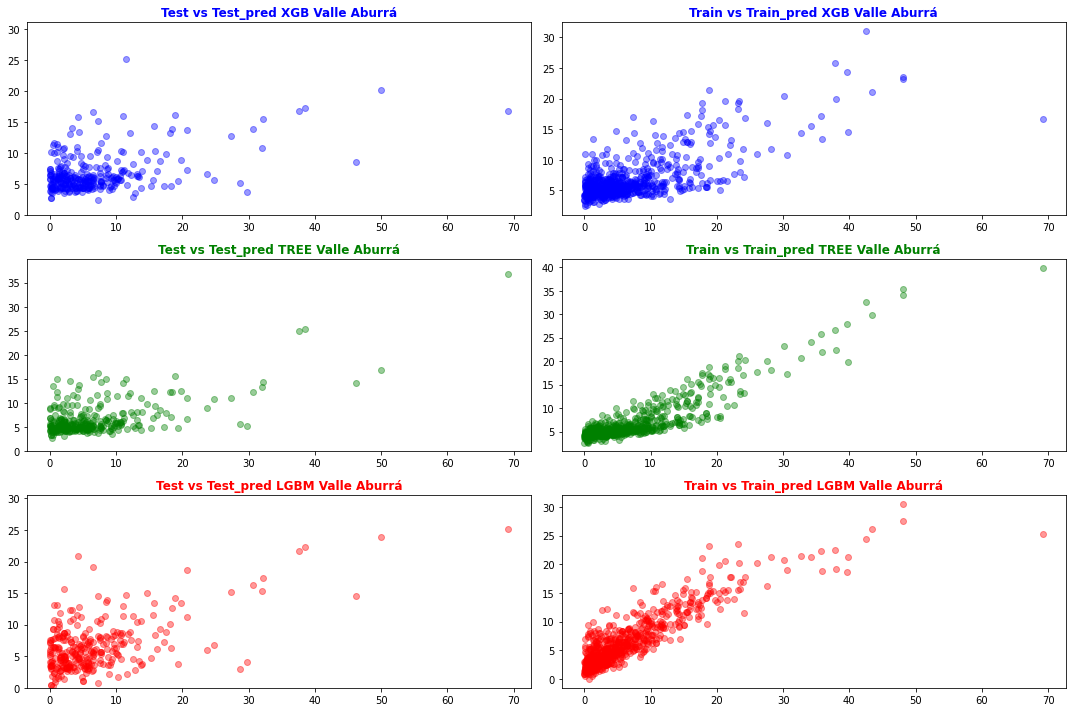

In [190]:
plt.figure(figsize=(15,10))

#XGB
plt.subplot(321)
plt.title('Test vs Test_pred XGB Valle Aburrá', fontweight='bold', color='b')
plt.scatter(y_test_abs_p_va,y_test_pred_abs_P_va_xgb, color='b', alpha=.4)
plt.ylim(0,np.max(y_train_pred_abs_P_va_xgb))

plt.subplot(322)
plt.title('Train vs Train_pred XGB Valle Aburrá', fontweight='bold', color='b')
plt.scatter(y_train_abs_p_va,y_train_pred_abs_P_va_xgb, color='b', alpha=.4)

#TREE
plt.subplot(323)
plt.title('Test vs Test_pred TREE Valle Aburrá', fontweight='bold', color='g')
plt.scatter(y_test_abs_p_va,y_test_pred_abs_P_va_tree, color='g', alpha=.4)
plt.ylim(0,np.max(y_train_pred_abs_P_va_tree))

plt.subplot(324)
plt.title('Train vs Train_pred TREE Valle Aburrá', fontweight='bold', color='g')
plt.scatter(y_train_abs_p_va,y_train_pred_abs_P_va_tree, color='g', alpha=.4)

#LGBM
plt.subplot(325)
plt.title('Test vs Test_pred LGBM Valle Aburrá', fontweight='bold', color='r')
plt.scatter(y_test_abs_p_va,y_test_pred_abs_P_va_lgbm, color='r', alpha=.4)
plt.ylim(0,np.max(y_train_pred_abs_P_va_lgbm))

plt.subplot(326)
plt.title('Train vs Train_pred LGBM Valle Aburrá', fontweight='bold', color='r')
plt.scatter(y_train_abs_p_va,y_train_pred_abs_P_va_lgbm, color='r', alpha=.4)

plt.tight_layout()
plt.show()

In [191]:
# random sampler
sampler = TPESampler(seed=42)
#Train-Test Split + Escalado
X_va = valle_aburra[columns_x_va]
X_va = X_va[[col for col in X_va.columns if (
    (X_va[col].sum()!=0) |
    (col=='alta')|(col=='media')|(col=='baja')
    )]]
r_scaler_va = preprocessing.RobustScaler()
r_scaler_va.fit(X_va)
X_new_va = r_scaler_va.transform(X_va)
y_va = abs(valle_aburra['diferencia_pp_last_ask_price_comite']*100)
X_train_abs_p_va, X_test_abs_p_va, y_train_abs_p_va, y_test_abs_p_va = train_test_split(
    X_new_va, y_va,test_size=0.30, random_state=42)

# define function
def objective_va(trial):

    rf_param = {
        "criterion":"squared_error",
        "max_features":'sqrt',
        "max_depth":trial.suggest_int('max_depth',5, 10),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        "n_jobs":6,
        "random_state":42
    }
    
    # Generate model
    tree_model = RandomForestRegressor(**rf_param)
    tree_model = tree_model.fit(X_train_abs_p_va, y_train_abs_p_va)
                           
    # * 평기 지표이다.
    # 원하는 평가 지표에 따라 사용하면 된다.                         
    MSE = mean_squared_error(y_test_abs_p_va, tree_model.predict(X_test_abs_p_va))
    return MSE

optuna_rf_va = optuna.create_study(direction='minimize', sampler=sampler)


[I 2022-06-21 19:49:38,681] A new study created in memory with name: no-name-2309322e-08ac-4b63-8172-a9ff7138b29d


In [192]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna_rf_va.optimize(objective_va, n_trials=500, n_jobs = 6)

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.


In [195]:
rf_trial_va = optuna_rf_va.best_trial
rf_trial_params_va = rf_trial_va.params

print('Best Trial: score {},\nparams {}'.format(rf_trial_va.value, rf_trial_params_va))

Best Trial: score 41.93785722222289,
params {'max_depth': 10, 'n_estimators': 631}


Best Trial: score 41.93785722222289,
params {'max_depth': 10, 'n_estimators': 631}

In [197]:
# random sampler
sampler_lgbm = TPESampler(seed=42)
# Train-Test split + scaler
X_va = valle_aburra[columns_x_va]
X_va = X_va[[col for col in X_va.columns if (
    (X_va[col].sum()!=0) |
    (col=='alta')|(col=='media')|(col=='baja')
    )]]
r_scaler_va = preprocessing.RobustScaler()
r_scaler_va.fit(X_va)
X_new_va = r_scaler_va.transform(X_va)
y_va = abs(valle_aburra['diferencia_pp_last_ask_price_comite']*100)
X_train_abs_p_va, X_test_abs_p_va, y_train_abs_p_va, y_test_abs_p_va = train_test_split(
    X_new_va, y_va,test_size=0.30, random_state=42)

# define function
def objective_lgbm_va(trial):

    lgbm_param = {        
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': trial.suggest_int('num_leaves', np.int(np.ceil(len(X_va)*0.2)), np.int(np.ceil(len(X_va)*0.25))),
        'min_samples_leaf':trial.suggest_int('min_samples_leaf', 20, 100),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
        'max_depth':trial.suggest_int('max_depth',3, 12),
        'learning_rate': trial.suggest_float('learning_rate',0.01, 0.02),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'verbose': -1
    }

    # Generate model
    lgbm_model = LGBMRegressor(**lgbm_param)
    lgbm_model = lgbm_model.fit(X_train_abs_p_va, y_train_abs_p_va)                           
                      
    MSE = mean_squared_error(y_test_abs_p_va, lgbm_model.predict(X_test_abs_p_va))
    return MSE

optuna_lgbm_va = optuna.create_study(direction='minimize', sampler=sampler_lgbm)

In [200]:
import warnings
warnings.filterwarnings("ignore")

In [203]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna_lgbm_va.optimize(objective_lgbm_va, n_trials=500)

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_

In [204]:
lgbm_trial_va = optuna_lgbm_va.best_trial
lgbm_trial_params_va = lgbm_trial_va.params

print('Best Trial: score {},\nparams {}'.format(lgbm_trial_va.value, lgbm_trial_params_va))

Best Trial: score 39.677287421750364,
params {'num_leaves': 223, 'min_samples_leaf': 20, 'reg_alpha': 0.03617053105519377, 'reg_lambda': 1.2679125685634594, 'max_depth': 6, 'learning_rate': 0.019066756409698744, 'n_estimators': 983}


Best Trial: score 39.677287421750364,
params {'num_leaves': 223, 'min_samples_leaf': 20, 'reg_alpha': 0.03617053105519377, 'reg_lambda': 1.2679125685634594, 'max_depth': 6, 'learning_rate': 0.019066756409698744, 'n_estimators': 983}

In [173]:
heat_va = valle_aburra[list(X_va.columns)+['diferencia_pp_last_ask_price_comite']].copy()
heat_va['objetivo'] = heat_va['diferencia_pp_last_ask_price_comite'].apply(lambda x: np.abs(x)*100)
heat_va.drop(columns=['diferencia_pp_last_ask_price_comite'],inplace=True)

In [174]:
corrs_va = heat_va.corr()

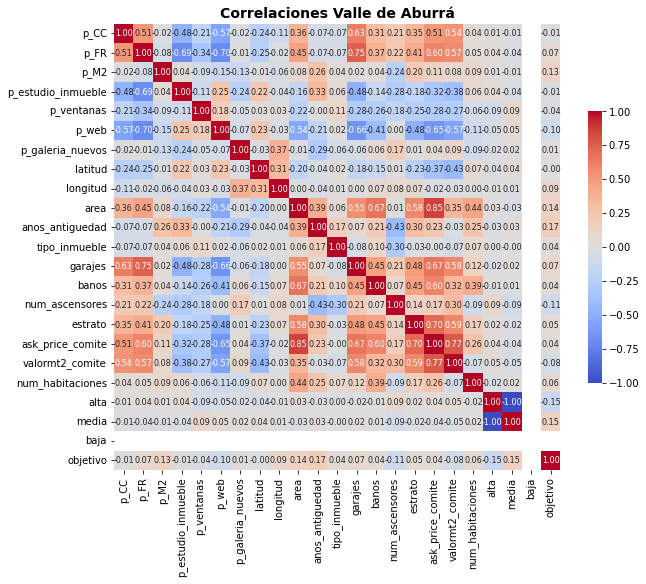

In [175]:
plt.figure(figsize=(10,10))
sns.heatmap(data=corrs_va,square=True,annot=True,annot_kws={'size': 8},fmt= '.2f',cmap='coolwarm',cbar_kws={"shrink": 0.5})
plt.xticks(rotation = 90,fontsize=10, horizontalalignment='center')
plt.yticks(rotation = 0,fontsize=10)
plt.title("Correlaciones Valle de Aburrá",fontsize=14, weight='bold')
plt.show()

In [176]:
aptos_va = heat_va[heat_va.tipo_inmueble == 1].drop(columns=['tipo_inmueble']).copy()
#aptos_va = aptos_va[[col for col in aptos_va.columns if aptos_va[col].sum()!=0]]
casas_va = heat_va[heat_va.tipo_inmueble == 2].drop(columns=['tipo_inmueble']).copy()
#casas_va = casas_va[[col for col in casas_va.columns if casas_va[col].sum()!=0]]
tipo_inmueble_heat_va = [aptos_va,casas_va]

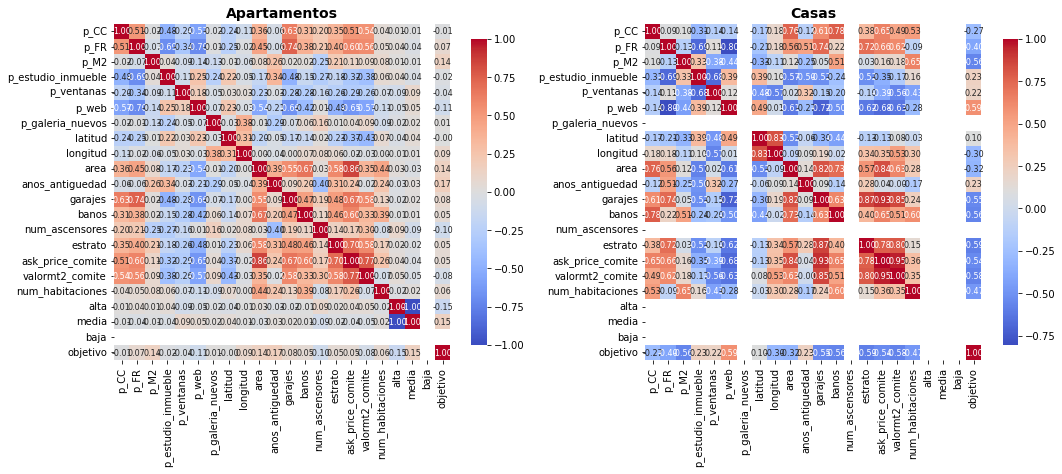

In [177]:
property_names = ['Apartamentos','Casas']
plt.figure(figsize=(15,9))
for i in range(len(tipo_inmueble_heat_va)):
    plt.subplot(1,2,i+1)
    sns.heatmap(data=tipo_inmueble_heat_va[i].corr(),
                square=True,annot=True,annot_kws={'size': 8},fmt= '.2f',cmap='coolwarm',cbar_kws={"shrink": 0.5})
    plt.xticks(rotation = 90,fontsize=10, horizontalalignment='center')
    plt.yticks(rotation = 0,fontsize=10)
    plt.title(property_names[i],fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

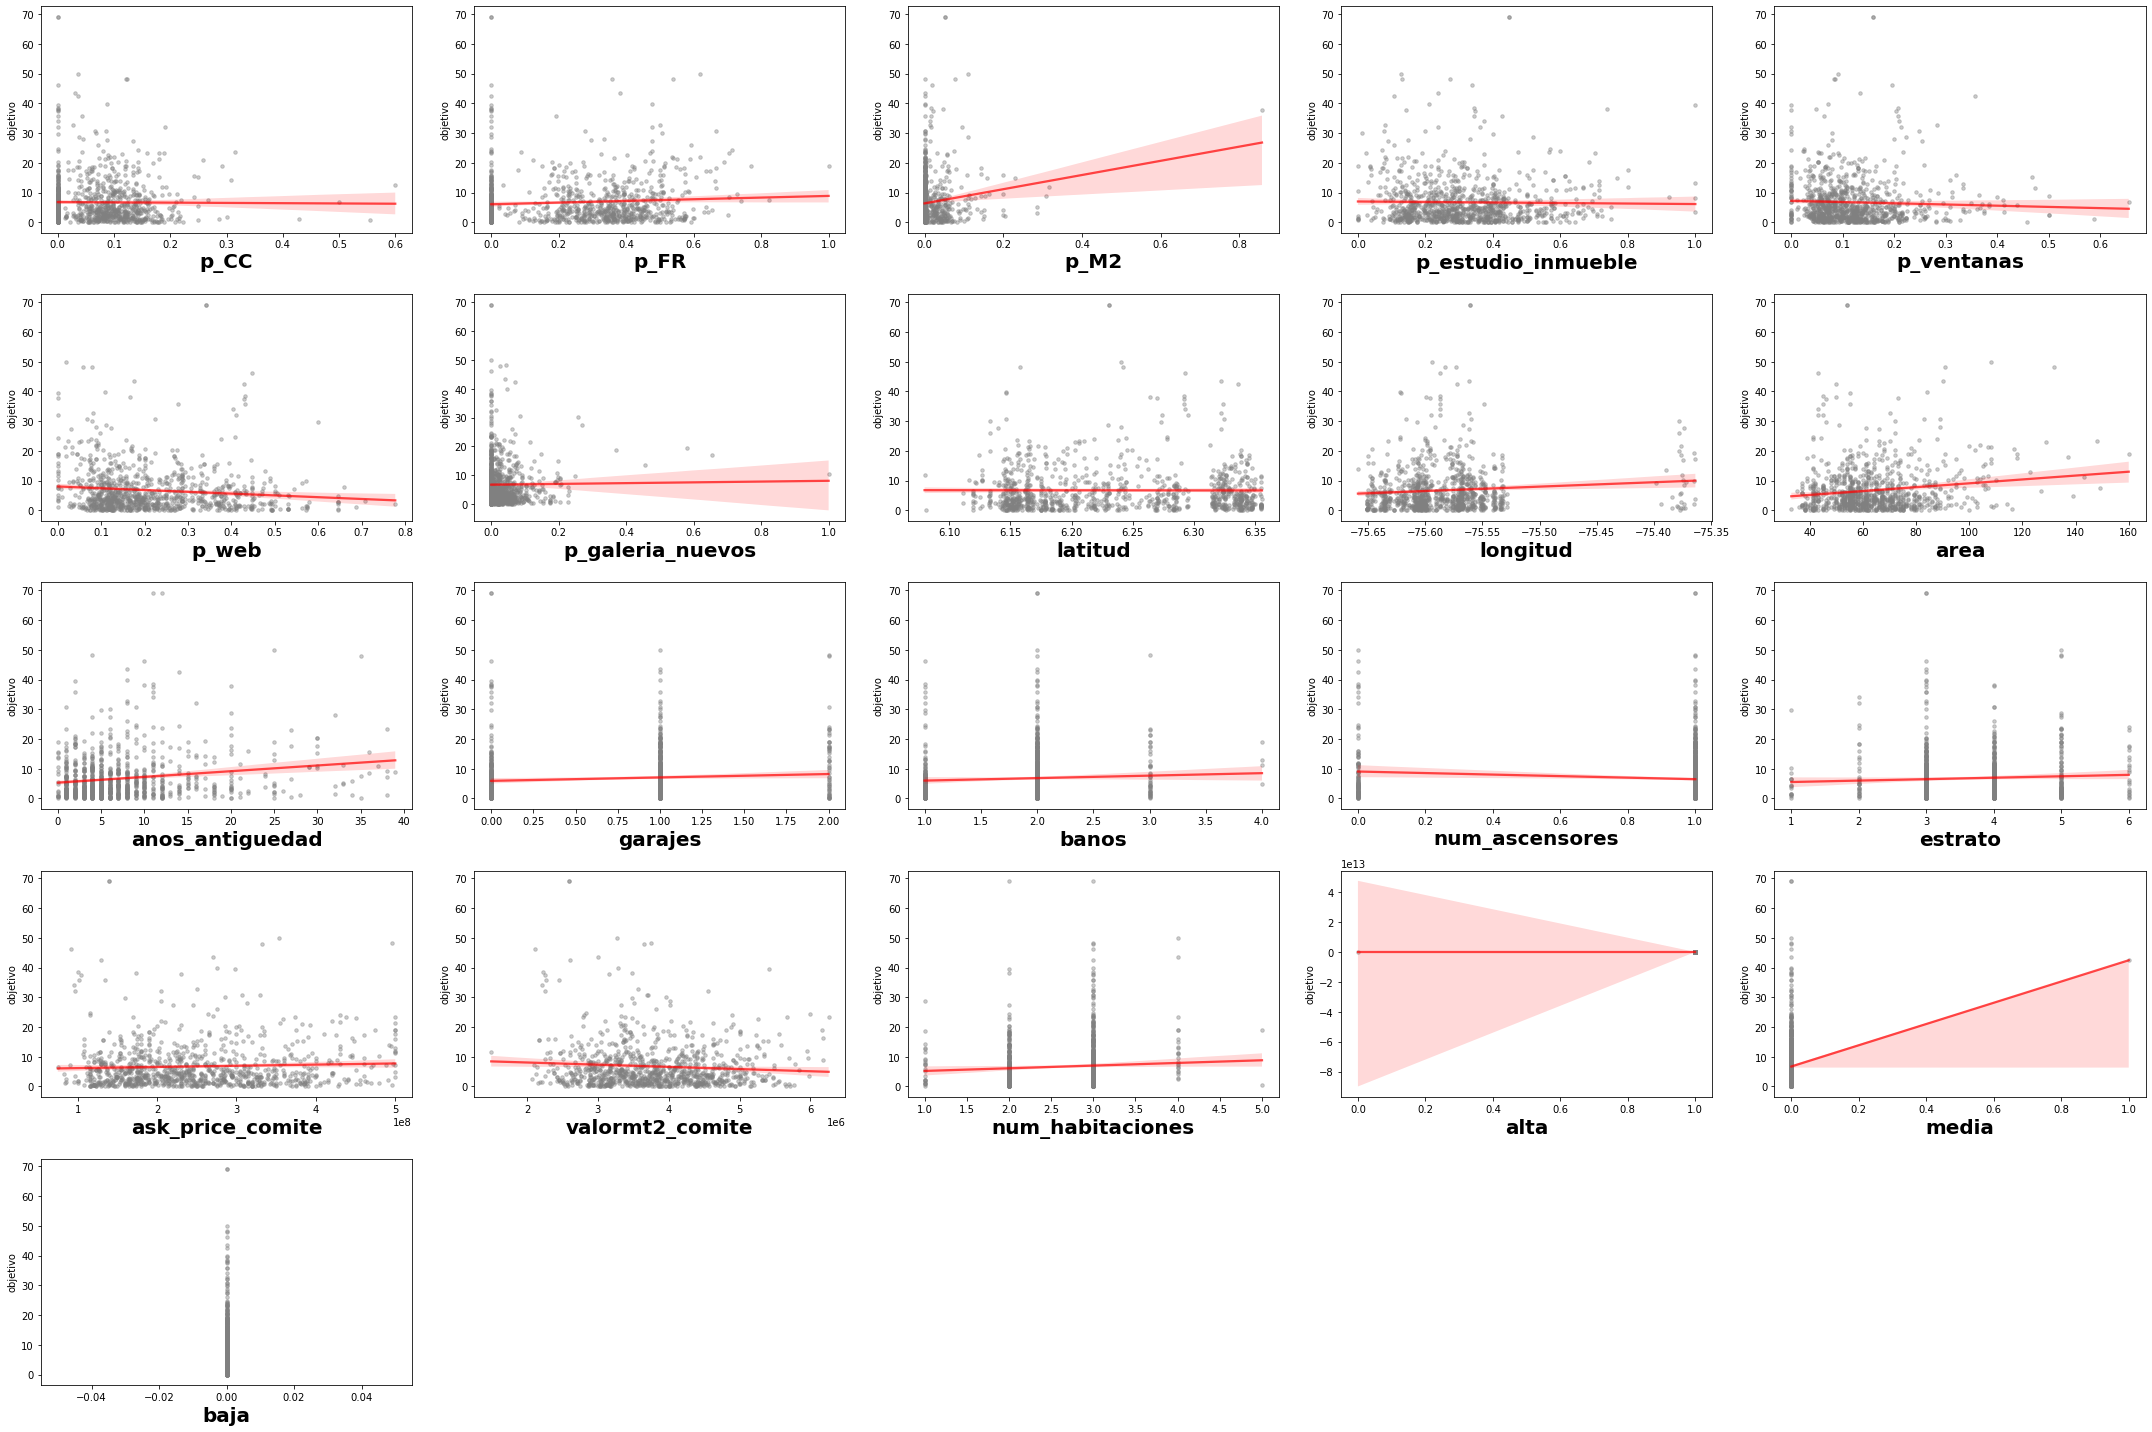

In [178]:
plt.figure(figsize=(30,20))
for idx,col in enumerate(aptos_va.columns):
    if col !='objetivo':
        plt.subplot(5,5,idx+1)
        sns.regplot(
            x           = aptos_va[col],
            y           = aptos_va['objetivo'],
            color       = "gray",
            marker      = '.',
            scatter_kws = {"alpha":0.4,"s":50},
            line_kws    = {"color":"r","alpha":0.7}
        )
        #plt.title(f'{col} vs abs(diferencia_pp_comite)*100', fontweight='bold',fontsize=18, color='#490089')
        plt.xlabel(col, fontweight='bold',fontsize=20)
        #plt.ylabel('abs(diferencia_pp_comite)*100', fontweight='bold',fontsize=18)
plt.tight_layout()

In [179]:
valle_aburra[valle_aburra['ask_price_comite']>1000000000]

Empty DataFrame
Columns: [inmueble_id, negocio_id, nid, fecha_comite, last_ask_price, area, valormt2, valormt2_comite, ask_price_comite, pais, area_metropolitana_id, type_test, ask_price_habimetro, valormt2_habimetro, num_comparables, upper_bound, lower_bound, coef_var, std_comparables, fecha_precio, version, bucket, cantidad_por_fuente, diferencia_pp_last_ask_price, diferencia_pp_valormt2, diferencia_pp_last_ask_price_comite, diferencia_pp_valormt2_comite, consistencia_last_ask_price, consistencia_valormt2, consistencia_last_ask_price_comite, consistencia_valormt2_comite, web, galeria_usados, estudio_inmueble, ventanas, inmobiliarias, galeria_nuevos, CC, FR, M2, lonja_medellin, MLS, PP, p_PP, PP_dummy, p_CC, CC_dummy, p_FR, FR_dummy, p_M2, M2_dummy, p_lonja_medellin, lonja_medellin_dummy, p_MLS, MLS_dummy, p_estudio_inmueble, estudio_inmueble_dummy, p_ventanas, ventanas_dummy, p_web, web_dummy, p_galeria_usados, galeria_usados_dummy, p_inmobiliarias, inmobiliarias_dummy, p_galeria_nuevos, galeria_nuevos_dummy, latitud, longitud, ciudad_id, name, anos_antiguedad, tipo_inmueble, garajes, banos, num_ascensores, estrato, num_habitaciones, alta, baja, media]
Index: []

[0 rows x 81 columns]

In [180]:
aptos_va['ask_price_comite'].min(),aptos_va['ask_price_comite'].max() #Hay un outlier

(75000000.0, 500000000.0)

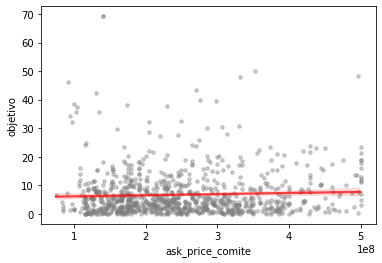

In [181]:
sns.regplot(
            x           = aptos_va['ask_price_comite'],
            y           = aptos_va['objetivo'],
            color       = "gray",
            marker      = '.',
            scatter_kws = {"alpha":0.4,"s":50},
            line_kws    = {"color":"r","alpha":0.7}
        )
plt.show()

In [ ]:
plt.figure(figsize=(30,20))
for idx,col in enumerate(casas_va.columns):
    if col !='objetivo':
        plt.subplot(5,5,idx+1)
        sns.regplot(
            x           = casas_va[col],
            y           = casas_va['objetivo'],
            color       = "gray",
            marker      = '.',
            scatter_kws = {"alpha":0.4,"s":50},
            line_kws    = {"color":"r","alpha":0.7}
        )
        #plt.title(f'{col} vs abs(diferencia_pp_comite)*100', fontweight='bold',fontsize=18, color='#490089')
        plt.xlabel(col, fontweight='bold',fontsize=20)
        #plt.ylabel('abs(diferencia_pp_comite)*100', fontweight='bold',fontsize=18)
plt.tight_layout()
    #break

# Cali

In [13]:
#cali = pd.concat([cali,pd.get_dummies(cali['name'])],axis=1)
columns_x_cali= p_fuentes.copy()
columns_x_cali.extend(['latitud','longitud','area','anos_antiguedad','tipo_inmueble',
                      'garajes', 'banos', 'num_ascensores', 'estrato',
                      'ask_price_comite', 'valormt2_comite','num_habitaciones','alta','media','baja'])
np.array(columns_x_cali).ravel()

array(['p_PP', 'p_CC', 'p_FR', 'p_M2', 'p_lonja_medellin', 'p_MLS',
       'p_estudio_inmueble', 'p_ventanas', 'p_web', 'p_galeria_usados',
       'p_inmobiliarias', 'p_galeria_nuevos', 'latitud', 'longitud',
       'area', 'anos_antiguedad', 'tipo_inmueble', 'garajes', 'banos',
       'num_ascensores', 'estrato', 'ask_price_comite', 'valormt2_comite',
       'num_habitaciones', 'alta', 'media', 'baja'], dtype='<U18')

In [14]:
#Train-Test Split + Escalado
X_cali = cali[columns_x_cali]
X_cali = X_cali[[col for col in X_cali.columns if (
    (X_cali[col].sum()!=0) |
    (col=='alta')|(col=='media')|(col=='baja')
    )]]
r_scaler_cali = preprocessing.RobustScaler()
r_scaler_cali.fit(X_cali)
X_new_cali = r_scaler_cali.transform(X_cali)
y_cali = abs(cali['diferencia_pp_last_ask_price_comite']*100)
X_train_abs_p_cali, X_test_abs_p_cali, y_train_abs_p_cali, y_test_abs_p_cali = train_test_split(
    X_new_cali, y_cali,test_size=0.30, random_state=42)

#Modelo XGB
xgb_cali = xgb.XGBRegressor(objective ='reg:squarederror',
                           eval_metric = 'mae',
                           learning_rate = 0.01,
                           max_depth = 2,
                           n_estimators = 1000, gamma=0.1,random_state=42)
xgb_cali.fit(X_train_abs_p_cali,y_train_abs_p_cali)

#Modelo Tree
tree_cali = RandomForestRegressor(criterion="squared_error",
                                 max_features='sqrt',
                                 max_depth=10,
                                 n_estimators=1000,
                                 n_jobs=6,
                                 random_state=42)
tree_cali.fit(X_train_abs_p_cali,y_train_abs_p_cali)

#LGBM
lightgbm_params_cali = {'objective': 'regression',
          'metric': 'rmse',
          'num_leaves': np.int(np.ceil(len(X_cali)*0.2)),
          'min_data_in_leaf':20,
          'max_depth':10,
          'learning_rate': 0.01,
          'verbose': -1,
        'n_estimators':500
             }

lgbm_cali = LGBMRegressor(**lightgbm_params_cali)
lgbm_model = lgbm_cali.fit(X_train_abs_p_cali, y_train_abs_p_cali)                           

#Predicción
y_train_pred_abs_P_cali_xgb = xgb_cali.predict(X_train_abs_p_cali)
y_test_pred_abs_P_cali_xgb = xgb_cali.predict(X_test_abs_p_cali)

y_train_pred_abs_P_cali_tree = tree_cali.predict(X_train_abs_p_cali)
y_test_pred_abs_P_cali_tree = tree_cali.predict(X_test_abs_p_cali)

y_train_pred_abs_P_cali_lgbm = lgbm_cali.predict(X_train_abs_p_cali)
y_test_pred_abs_P_cali_lgbm = lgbm_cali.predict(X_test_abs_p_cali)

#Métricas
pd.DataFrame({'MSE_train': [mean_squared_error(y_train_abs_p_cali,y_train_pred_abs_P_cali_xgb),
                            mean_squared_error(y_train_abs_p_cali,y_train_pred_abs_P_cali_tree),
                           mean_squared_error(y_train_abs_p_cali,y_train_pred_abs_P_cali_lgbm)],
'RMSE_train': [np.sqrt(mean_squared_error(y_train_abs_p_cali,y_train_pred_abs_P_cali_xgb)),
               np.sqrt(mean_squared_error(y_train_abs_p_cali,y_train_pred_abs_P_cali_tree)),
              np.sqrt(mean_squared_error(y_train_abs_p_cali,y_train_pred_abs_P_cali_lgbm))],
'MSE_test': [mean_squared_error(y_test_abs_p_cali,y_test_pred_abs_P_cali_xgb),
             mean_squared_error(y_test_abs_p_cali,y_test_pred_abs_P_cali_tree),
            mean_squared_error(y_test_abs_p_cali,y_test_pred_abs_P_cali_lgbm)],
'RMSE_test': [np.sqrt(mean_squared_error(y_test_abs_p_cali,y_test_pred_abs_P_cali_xgb)),
              np.sqrt(mean_squared_error(y_test_abs_p_cali,y_test_pred_abs_P_cali_tree)),
             np.sqrt(mean_squared_error(y_test_abs_p_cali,y_test_pred_abs_P_cali_lgbm))],
'MAE_train': [mae(y_train_abs_p_cali,y_train_pred_abs_P_cali_xgb),
              mae(y_train_abs_p_cali,y_train_pred_abs_P_cali_tree),
             mae(y_train_abs_p_cali,y_train_pred_abs_P_cali_lgbm)],
'MAPE_train': [mape(y_train_abs_p_cali,y_train_pred_abs_P_cali_xgb),
               mape(y_train_abs_p_cali,y_train_pred_abs_P_cali_tree),
              mape(y_train_abs_p_cali,y_train_pred_abs_P_cali_lgbm)],
'MAE_test': [mae(y_test_abs_p_cali,y_test_pred_abs_P_cali_xgb),
             mae(y_test_abs_p_cali,y_test_pred_abs_P_cali_tree),
             mae(y_test_abs_p_cali,y_test_pred_abs_P_cali_lgbm)],
'MAPE_test': [mape(y_test_abs_p_cali,y_test_pred_abs_P_cali_xgb),
              mape(y_test_abs_p_cali,y_test_pred_abs_P_cali_tree),
             mape(y_test_abs_p_cali,y_test_pred_abs_P_cali_lgbm)],
'R2_train': [r2_score(y_train_abs_p_cali,y_train_pred_abs_P_cali_xgb),
             r2_score(y_train_abs_p_cali,y_train_pred_abs_P_cali_tree),
            r2_score(y_train_abs_p_cali,y_train_pred_abs_P_cali_lgbm)],
'R2_test': [r2_score(y_test_abs_p_cali,y_test_pred_abs_P_cali_xgb),
            r2_score(y_test_abs_p_cali,y_test_pred_abs_P_cali_tree),
           r2_score(y_test_abs_p_cali,y_test_pred_abs_P_cali_lgbm)]},index=['xgb','tree','lgbm'])

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


divide by zero encountered in true_divide


MSE_train  RMSE_train   MSE_test  RMSE_test  MAE_train  \
xgb   27.665180    5.259770  69.352598   8.327821   3.820635   
tree  12.591598    3.548464  72.083089   8.490176   2.628702   
lgbm  19.303400    4.393563  71.922411   8.480708   2.572526   

                        MAPE_train  MAE_test                     MAPE_test  \
xgb   inf por predicciones exactas  5.014790  inf por predicciones exactas   
tree  inf por predicciones exactas  4.779024  inf por predicciones exactas   
lgbm  inf por predicciones exactas  4.708555  inf por predicciones exactas   

      R2_train   R2_test  
xgb   0.640383  0.315330  
tree  0.836323  0.288374  
lgbm  0.749077  0.289960

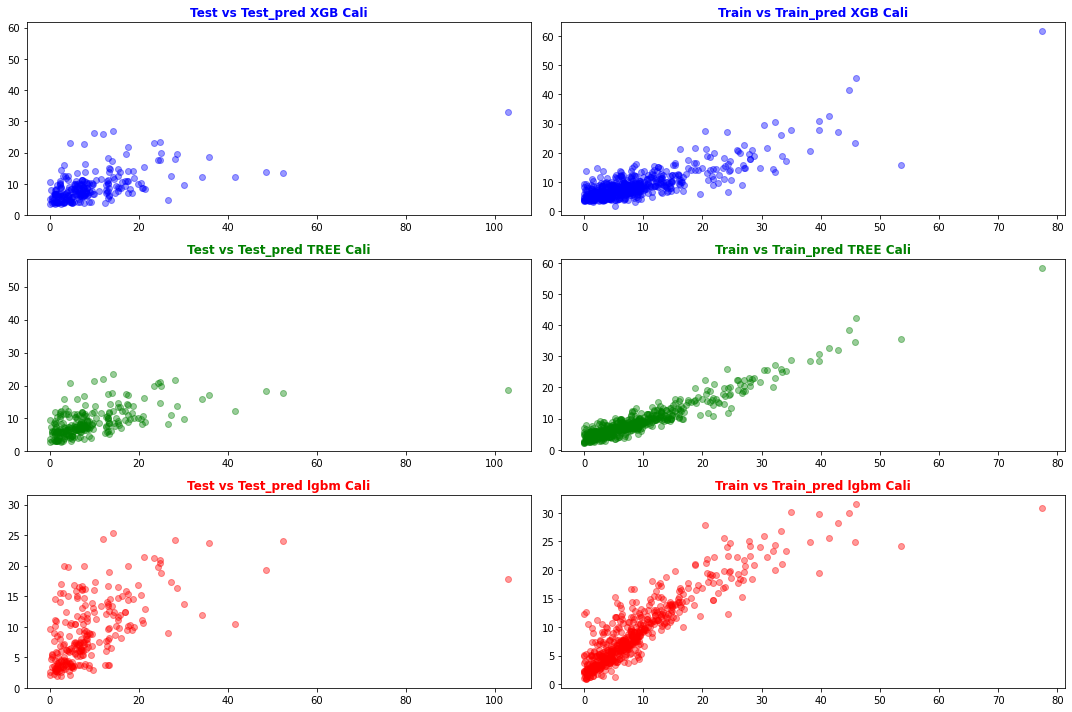

In [15]:
plt.figure(figsize=(15,10))

#XGB
plt.subplot(321)
plt.title('Test vs Test_pred XGB Cali', fontweight='bold', color='b')
plt.scatter(y_test_abs_p_cali,y_test_pred_abs_P_cali_xgb, color='b', alpha=.4)
plt.ylim(0,np.max(y_train_pred_abs_P_cali_xgb))

plt.subplot(322)
plt.title('Train vs Train_pred XGB Cali', fontweight='bold', color='b')
plt.scatter(y_train_abs_p_cali,y_train_pred_abs_P_cali_xgb, color='b', alpha=.4)

#TREE
plt.subplot(323)
plt.title('Test vs Test_pred TREE Cali', fontweight='bold', color='g')
plt.scatter(y_test_abs_p_cali,y_test_pred_abs_P_cali_tree, color='g', alpha=.4)
plt.ylim(0,np.max(y_train_pred_abs_P_cali_tree))

plt.subplot(324)
plt.title('Train vs Train_pred TREE Cali', fontweight='bold', color='g')
plt.scatter(y_train_abs_p_cali,y_train_pred_abs_P_cali_tree, color='g', alpha=.4)

#lgbm
plt.subplot(325)
plt.title('Test vs Test_pred lgbm Cali', fontweight='bold', color='r')
plt.scatter(y_test_abs_p_cali,y_test_pred_abs_P_cali_lgbm, color='r', alpha=.4)
plt.ylim(0,np.max(y_train_pred_abs_P_cali_lgbm))

plt.subplot(326)
plt.title('Train vs Train_pred lgbm Cali', fontweight='bold', color='r')
plt.scatter(y_train_abs_p_cali,y_train_pred_abs_P_cali_lgbm, color='r', alpha=.4)

plt.tight_layout()
plt.show()

In [16]:
# random sampler
sampler = TPESampler(seed=42)
#Train-Test Split + Escalado
X_cali = cali[columns_x_cali]
X_cali = X_cali[[col for col in X_cali.columns if (
    (X_cali[col].sum()!=0) |
    (col=='alta')|(col=='media')|(col=='baja')
    )]]
r_scaler_cali = preprocessing.RobustScaler()
r_scaler_cali.fit(X_cali)
X_new_cali = r_scaler_cali.transform(X_cali)
y_cali = abs(cali['diferencia_pp_last_ask_price_comite']*100)
X_train_abs_p_cali, X_test_abs_p_cali, y_train_abs_p_cali, y_test_abs_p_cali = train_test_split(
    X_new_cali, y_cali,test_size=0.30, random_state=42)

# define function
def objective_cali(trial):

    rf_param = {
        "criterion":"squared_error",
        "max_features":'sqrt',
        "max_depth":trial.suggest_int('max_depth',5, 10),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        "n_jobs":6,
        "random_state":42
    }
    
    # Generate model
    tree_model = RandomForestRegressor(**rf_param)
    tree_model = tree_model.fit(X_train_abs_p_cali, y_train_abs_p_cali)
                           
    # * 평기 지표이다.
    # 원하는 평가 지표에 따라 사용하면 된다.                         
    MSE = mean_squared_error(y_test_abs_p_cali, tree_model.predict(X_test_abs_p_cali))
    return MSE

optuna_rf_cali = optuna.create_study(direction='minimize', sampler=sampler)

[I 2022-06-21 21:29:52,071] A new study created in memory with name: no-name-dfb79a9d-296d-4e15-96b6-c36dbceea169


In [20]:
optuna.logging.set_verbosity(optuna.logging.INFO)
optuna_rf_cali.optimize(objective_cali, n_trials=500, n_jobs = 6)

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2022-06-21 21:37:51,762] Trial 154 finished with value: 71.78666874051295 and parameters: {'max_depth': 10, 'n_estimators': 509}. Best is trial 38 with value: 71.71010728625663.
[I 2022-06-21 21:37:52,615] Trial 153 finished with value: 72.09072965803475 and parameters: {'max_depth': 10, 'n_estimators': 545}. Best is trial 38 with value: 71.71010728625663.
[I 2022-06-21 21:37:52,782] Trial 151 finished with value: 72.06715748951063 and parameters: {'max_depth': 10, 'n_estimators': 546}. Best is trial 38 with value: 71.71010728625663.
[I 2022-06-21 21:37:52,808] Trial 150 finished with value: 72.06715748951063 and parameters: {'max_depth': 10, 'n_estimators': 546}. Best is trial 38 with value: 71.71010728625663.
[I 2022-06-21 21:37:52,810] Trial 152 finished with value: 72.06715748951063 and parameters: {'max_depth': 10, 'n_estimators': 54

In [21]:
rf_trial_cali = optuna_rf_cali.best_trial
rf_trial_params_cali = rf_trial_cali.params

print('Best Trial: score {},\nparams {}'.format(rf_trial_cali.value, rf_trial_params_cali))

Best Trial: score 71.71003682887626,
params {'max_depth': 10, 'n_estimators': 511}


Best Trial: score 71.71003682887626,
params {'max_depth': 10, 'n_estimators': 511}

In [22]:
# random sampler
sampler_lgbm = TPESampler(seed=42)
# Train-Test split + scaler
X_cali = cali[columns_x_cali]
X_cali = X_cali[[col for col in X_cali.columns if (
    (X_cali[col].sum()!=0) |
    (col=='alta')|(col=='media')|(col=='baja')
    )]]
r_scaler_cali = preprocessing.RobustScaler()
r_scaler_cali.fit(X_cali)
X_new_cali = r_scaler_cali.transform(X_cali)
y_cali = abs(cali['diferencia_pp_last_ask_price_comite']*100)
X_train_abs_p_cali, X_test_abs_p_cali, y_train_abs_p_cali, y_test_abs_p_cali = train_test_split(
    X_new_cali, y_cali,test_size=0.30, random_state=42)

# define function
def objective_lgbm_cali(trial):

    lgbm_param = {        
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': trial.suggest_int('num_leaves', np.int(np.ceil(len(X_cali)*0.2)), np.int(np.ceil(len(X_cali)*0.25))),
        'min_samples_leaf':trial.suggest_int('min_samples_leaf', 20, 100),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
        'max_depth':trial.suggest_int('max_depth',3, 12),
        'learning_rate': trial.suggest_float('learning_rate',0.01, 0.02),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'verbose': -1
    }

    # Generate model
    lgbm_model = LGBMRegressor(**lgbm_param)
    lgbm_model = lgbm_model.fit(X_train_abs_p_cali, y_train_abs_p_cali)                           
                      
    MSE = mean_squared_error(y_test_abs_p_cali, lgbm_model.predict(X_test_abs_p_cali))
    return MSE

optuna_lgbm_cali = optuna.create_study(direction='minimize', sampler=sampler_lgbm)

[I 2022-06-21 21:47:17,697] A new study created in memory with name: no-name-46d9c63d-8884-4103-8a37-8f54d938b673


In [23]:
optuna.logging.set_verbosity(optuna.logging.INFO)
optuna_lgbm_cali.optimize(objective_lgbm_cali, n_trials=500, n_jobs = 6)

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 21:47:59,094] Trial 2 finished with value: 76.87984086022496 and parameters: {'num_leaves': 190, 'min_samples_leaf': 45, 'reg_alpha': 0.6945490645953116, 'reg_lambda': 1.384423561655369, 'max_depth': 3, 'learning_rate': 0.016731337524921647, 'n_estimators': 804}. Best is trial 2 with value: 76.87984086022496.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70


[I 2022-06-21 21:47:59,456] Trial 1 finished with value: 75.30496005399057 and parameters: {'num_leaves': 184, 'min_samples_leaf': 87, 'reg_alpha': 0.7254082881207401, 'reg_lambda': 7.728400932109055, 'max_depth': 6, 'learning_rate': 0.010374212618705459, 'n_estimators': 900}. Best is trial 1 with value: 75.30496005399057.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69


[I 2022-06-21 21:48:00,633] Trial 3 finished with value: 74.436809698446 and parameters: {'num_leaves': 201, 'min_samples_leaf': 40, 'reg_alpha': 0.16085891081563042, 'reg_lambda': 9.029146809660116, 'max_depth': 7, 'learning_rate': 0.01517120121825272, 'n_estimators': 782}. Best is trial 3 with value: 74.436809698446.
[I 2022-06-21 21:48:00,822] Trial 6 finished with value: 76.29006793860735 and parameters: {'num_leaves': 202, 'min_samples_leaf': 70, 'reg_alpha': 0.38025071738829297, 'reg_lambda': 5.490646761697607, 'max_depth': 10, 'learning_rate': 0.01992236523531179, 'n_estimators': 646}. Best is trial 3 with value: 74.436809698446.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2022-06-21 21:48:01,284] Trial 7 finished with value: 78.206301961209 and parameters: {'num_leaves': 175, 'min_samples_leaf': 69, 'reg_alpha': 0.8878565360907131, 'reg_lambda': 0.5348332373649223, 'max_depth': 9, 'learning_rate': 0.017723657793305484, 'n_estimators': 593}. Best is trial 3 with value: 74.436809698446.
[I 2022-06-21 21:48:01,335] Trial 4 finished with value: 72.62394043331771 and parameters: {'num_leaves': 202, 'min_samples_leaf': 30, 'reg_alpha': 0.6728532686700749, 'reg_lambda': 7.26365078887227, 'max_depth': 12, 'learning_rate': 0.011458364612878252, 'n_estimators': 696}. Best is trial 4 with value: 72.62394043331771.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


[I 2022-06-21 21:48:02,644] Trial 0 finished with value: 72.63031681136634 and parameters: {'num_leaves': 186, 'min_samples_leaf': 29, 'reg_alpha': 0.8431313066952527, 'reg_lambda': 9.430144074317695, 'max_depth': 11, 'learning_rate': 0.01354643644444052, 'n_estimators': 785}. Best is trial 4 with value: 72.62394043331771.
[I 2022-06-21 21:48:02,881] Trial 9 finished with value: 76.56636380750291 and parameters: {'num_leaves': 178, 'min_samples_leaf': 98, 'reg_alpha': 0.8424972651156737, 'reg_lambda': 0.02317807443022124, 'max_depth': 12, 'learning_rate': 0.012884955214739402, 'n_estimators': 626}. Best is trial 4 with value: 72.62394043331771.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73


[I 2022-06-21 21:48:03,981] Trial 11 finished with value: 75.9175442343128 and parameters: {'num_leaves': 202, 'min_samples_leaf': 64, 'reg_alpha': 0.8685876341209711, 'reg_lambda': 8.739807464292817, 'max_depth': 11, 'learning_rate': 0.01409435646576761, 'n_estimators': 542}. Best is trial 4 with value: 72.62394043331771.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37


[I 2022-06-21 21:48:04,252] Trial 8 finished with value: 77.55399176475636 and parameters: {'num_leaves': 200, 'min_samples_leaf': 63, 'reg_alpha': 0.8366828472415071, 'reg_lambda': 3.0419908575275514, 'max_depth': 4, 'learning_rate': 0.017684735808087965, 'n_estimators': 886}. Best is trial 4 with value: 72.62394043331771.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:48:05,054] Trial 13 finished with value: 77.84775693926152 and parameters: {'num_leaves': 186, 'min_samples_leaf': 73, 'reg_alpha': 0.9010588186044852, 'reg_lambda': 5.768499287115008, 'max_depth': 12, 'learning_rate': 0.011221970564869533, 'n_estimators': 647}. Best is trial 4 with value: 72.62394043331771.
[I 2022-06-21 21:48:05,322] Trial 5 finished with value: 68.82341768590969 and parameters: {'num_leaves': 175, 'min_samples_leaf': 26, 'reg_alpha': 0.030476820041489883, 'reg_lambda': 0.18883051088305236, 'max_depth': 12, 'learning_rate': 0.018341244324344908, 'n_estimators': 920}. Best is trial 5 with value: 68.82341768590969.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:48:06,801] Trial 12 finished with value: 74.57342000950389 and parameters: {'num_leaves': 197, 'min_samples_leaf': 33, 'reg_alpha': 0.015175146973187004, 'reg_lambda': 4.665697703441218, 'max_depth': 12, 'learning_rate': 0.014884212573756155, 'n_estimators': 619}. Best is trial 5 with value: 68.82341768590969.
[I 2022-06-21 21:48:06,925] Trial 14 finished with value: 75.09520453008783 and parameters: {'num_leaves': 184, 'min_samples_leaf': 37, 'reg_alpha': 0.2085156168022433, 'reg_lambda': 6.562987532234868, 'max_depth': 10, 'learning_rate': 0.010871675863597618, 'n_estimators': 569}. Best is trial 5 with value: 68.82341768590969.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:48:07,197] Trial 10 finished with value: 72.33400967399214 and parameters: {'num_leaves': 166, 'min_samples_leaf': 21, 'reg_alpha': 0.012852058798130117, 'reg_lambda': 7.761159687042138, 'max_depth': 9, 'learning_rate': 0.010700000885308314, 'n_estimators': 752}. Best is trial 5 with value: 68.82341768590969.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:48:08,593] Trial 15 finished with value: 72.59937320165733 and parameters: {'num_leaves': 164, 'min_samples_leaf': 22, 'reg_alpha': 0.4688543917825114, 'reg_lambda': 6.114980862058923, 'max_depth': 8, 'learning_rate': 0.010036608212273018, 'n_estimators': 694}. Best is trial 5 with value: 68.82341768590969.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49


[I 2022-06-21 21:48:10,519] Trial 16 finished with value: 71.4391207620009 and parameters: {'num_leaves': 167, 'min_samples_leaf': 21, 'reg_alpha': 0.5219817098374959, 'reg_lambda': 7.497219344034488, 'max_depth': 9, 'learning_rate': 0.012251790477298121, 'n_estimators': 725}. Best is trial 5 with value: 68.82341768590969.
[I 2022-06-21 21:48:10,636] Trial 18 finished with value: 77.15749297661145 and parameters: {'num_leaves': 164, 'min_samples_leaf': 51, 'reg_alpha': 0.49840906014764763, 'reg_lambda': 6.993280664703191, 'max_depth': 9, 'learning_rate': 0.019878941421293164, 'n_estimators': 984}. Best is trial 5 with value: 68.82341768590969.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


[I 2022-06-21 21:48:11,525] Trial 17 finished with value: 68.76712670375284 and parameters: {'num_leaves': 164, 'min_samples_leaf': 23, 'reg_alpha': 0.039877058563558054, 'reg_lambda': 3.8654852482789677, 'max_depth': 9, 'learning_rate': 0.019717815118385464, 'n_estimators': 995}. Best is trial 17 with value: 68.76712670375284.
[I 2022-06-21 21:48:11,732] Trial 21 finished with value: 76.50420558423559 and parameters: {'num_leaves': 167, 'min_samples_leaf': 49, 'reg_alpha': 0.0008494116733310953, 'reg_lambda': 3.674428019733269, 'max_depth': 6, 'learning_rate': 0.019498075965436457, 'n_estimators': 859}. Best is trial 17 with value: 68.76712670375284.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53


[I 2022-06-21 21:48:13,605] Trial 23 finished with value: 77.99319824853293 and parameters: {'num_leaves': 171, 'min_samples_leaf': 52, 'reg_alpha': 0.3612711856805821, 'reg_lambda': 4.051834573255097, 'max_depth': 6, 'learning_rate': 0.0123710356523992, 'n_estimators': 861}. Best is trial 17 with value: 68.76712670375284.
[I 2022-06-21 21:48:13,753] Trial 19 finished with value: 69.11663354732367 and parameters: {'num_leaves': 162, 'min_samples_leaf': 21, 'reg_alpha': 0.5144704019576666, 'reg_lambda': 3.315892968441233, 'max_depth': 8, 'learning_rate': 0.019007189811397027, 'n_estimators': 993}. Best is trial 17 with value: 68.76712670375284.
[I 2022-06-21 21:48:13,885] Trial 20 finished with value: 69.74629266145605 and parameters: {'num_leaves': 163, 'min_samples_leaf': 23, 'reg_alpha': 0.06319100534306721, 'reg_lambda': 3.604190485657992, 'max_depth': 8, 'learning_rate': 0.019376208036761128, 'n_estimators': 993}. Best is trial 17 with value: 68.76712670375284.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 21:48:14,812] Trial 24 finished with value: 76.91016877437896 and parameters: {'num_leaves': 171, 'min_samples_leaf': 57, 'reg_alpha': 0.16415215535119765, 'reg_lambda': 3.8517760443789486, 'max_depth': 5, 'learning_rate': 0.018703950484758352, 'n_estimators': 975}. Best is trial 17 with value: 68.76712670375284.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 21:48:15,102] Trial 22 finished with value: 76.73197624409661 and parameters: {'num_leaves': 171, 'min_samples_leaf': 47, 'reg_alpha': 0.3645142997308023, 'reg_lambda': 3.9606855244693624, 'max_depth': 6, 'learning_rate': 0.019609324153916936, 'n_estimators': 995}. Best is trial 17 with value: 68.76712670375284.
[I 2022-06-21 21:48:15,208] Trial 25 finished with value: 76.66774768750005 and parameters: {'num_leaves': 172, 'min_samples_leaf': 53, 'reg_alpha': 0.1838240791631389, 'reg_lambda': 2.150486781819942, 'max_depth': 7, 'learning_rate': 0.01877275614224756, 'n_estimators': 993}. Best is trial 17 with value: 68.76712670375284.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 21:48:18,533] Trial 27 finished with value: 72.64358210344524 and parameters: {'num_leaves': 173, 'min_samples_leaf': 30, 'reg_alpha': 0.14331355444161767, 'reg_lambda': 2.388624145710775, 'max_depth': 7, 'learning_rate': 0.018638694104060712, 'n_estimators': 958}. Best is trial 17 with value: 68.76712670375284.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


[I 2022-06-21 21:48:19,020] Trial 28 finished with value: 68.58195973612555 and parameters: {'num_leaves': 172, 'min_samples_leaf': 28, 'reg_alpha': 0.18942363499151443, 'reg_lambda': 1.927912587711498, 'max_depth': 7, 'learning_rate': 0.01839628805728021, 'n_estimators': 943}. Best is trial 28 with value: 68.58195973612555.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


[I 2022-06-21 21:48:19,755] Trial 30 finished with value: 74.72343746914356 and parameters: {'num_leaves': 178, 'min_samples_leaf': 39, 'reg_alpha': 0.2563278395186279, 'reg_lambda': 2.3764778376418496, 'max_depth': 7, 'learning_rate': 0.018342446790728068, 'n_estimators': 934}. Best is trial 28 with value: 68.58195973612555.
[I 2022-06-21 21:48:19,804] Trial 26 finished with value: 67.1117033401529 and parameters: {'num_leaves': 170, 'min_samples_leaf': 20, 'reg_alpha': 0.1640009776134146, 'reg_lambda': 1.9142042265955153, 'max_depth': 8, 'learning_rate': 0.017944774301949136, 'n_estimators': 976}. Best is trial 26 with value: 67.1117033401529.
[I 2022-06-21 21:48:19,829] Trial 29 finished with value: 71.70775929690865 and parameters: {'num_leaves': 171, 'min_samples_leaf': 30, 'reg_alpha': 0.2913095548644148, 'reg_lambda': 2.507491154268008, 'max_depth': 7, 'learning_rate': 0.018359207169439326, 'n_estimators': 930}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 21:48:21,027] Trial 31 finished with value: 70.11004983183321 and parameters: {'num_leaves': 176, 'min_samples_leaf': 28, 'reg_alpha': 0.25953779065744065, 'reg_lambda': 2.332668035279843, 'max_depth': 10, 'learning_rate': 0.016617187153275415, 'n_estimators': 935}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 21:48:23,062] Trial 32 finished with value: 75.06899976390086 and parameters: {'num_leaves': 178, 'min_samples_leaf': 40, 'reg_alpha': 0.25055433468507776, 'reg_lambda': 1.4730405006720246, 'max_depth': 10, 'learning_rate': 0.016495297917270085, 'n_estimators': 934}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 21:48:23,398] Trial 33 finished with value: 76.26773591658298 and parameters: {'num_leaves': 178, 'min_samples_leaf': 42, 'reg_alpha': 0.2731236641860262, 'reg_lambda': 1.7990280426724592, 'max_depth': 10, 'learning_rate': 0.016457930652325915, 'n_estimators': 932}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2022-06-21 21:48:25,837] Trial 34 finished with value: 70.59029641868675 and parameters: {'num_leaves': 179, 'min_samples_leaf': 27, 'reg_alpha': 0.3004387343143273, 'reg_lambda': 1.192067103150722, 'max_depth': 10, 'learning_rate': 0.016450575454421443, 'n_estimators': 936}. Best is trial 26 with value: 67.1117033401529.
[I 2022-06-21 21:48:26,038] Trial 36 finished with value: 69.36683517080202 and parameters: {'num_leaves': 178, 'min_samples_leaf': 26, 'reg_alpha': 0.07962457320045752, 'reg_lambda': 1.213114761326572, 'max_depth': 10, 'learning_rate': 0.01661306994145364, 'n_estimators': 934}. Best is trial 26 with value: 67.1117033401529.
[I 2022-06-21 21:48:26,082] Trial 35 finished with value: 69.93968642713357 and parameters: {'num_leaves': 178, 'min_samples_leaf': 26, 'reg_alpha': 0.0999843142674833, 'reg_lambda': 1.2214964005034235, 'max_depth': 10, 'learning_rate': 0.01640642466577299, 'n_estimators': 937}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


[I 2022-06-21 21:48:26,325] Trial 39 finished with value: 75.29784650773699 and parameters: {'num_leaves': 168, 'min_samples_leaf': 34, 'reg_alpha': 0.07535009123134465, 'reg_lambda': 0.8075072318414227, 'max_depth': 5, 'learning_rate': 0.01733660097421335, 'n_estimators': 826}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2022-06-21 21:48:27,708] Trial 37 finished with value: 70.09387244868999 and parameters: {'num_leaves': 180, 'min_samples_leaf': 26, 'reg_alpha': 0.10660418939684929, 'reg_lambda': 1.0384972221826474, 'max_depth': 11, 'learning_rate': 0.016825417545943407, 'n_estimators': 896}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2022-06-21 21:48:28,435] Trial 42 finished with value: 76.23738092402886 and parameters: {'num_leaves': 167, 'min_samples_leaf': 86, 'reg_alpha': 0.09943981057755719, 'reg_lambda': 0.5817044875346551, 'max_depth': 11, 'learning_rate': 0.017549818633758367, 'n_estimators': 900}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2022-06-21 21:48:28,876] Trial 38 finished with value: 69.55701708569259 and parameters: {'num_leaves': 168, 'min_samples_leaf': 27, 'reg_alpha': 0.09674273939673361, 'reg_lambda': 1.1455909063641774, 'max_depth': 11, 'learning_rate': 0.017626819628380738, 'n_estimators': 895}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:48:30,424] Trial 40 finished with value: 74.19087969236521 and parameters: {'num_leaves': 168, 'min_samples_leaf': 35, 'reg_alpha': 0.09642783344313405, 'reg_lambda': 1.003119315786266, 'max_depth': 11, 'learning_rate': 0.01751626312456567, 'n_estimators': 815}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:48:30,922] Trial 41 finished with value: 74.4372148214867 and parameters: {'num_leaves': 168, 'min_samples_leaf': 35, 'reg_alpha': 0.10540763613981735, 'reg_lambda': 0.6036071713246525, 'max_depth': 11, 'learning_rate': 0.01750464515509621, 'n_estimators': 832}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:48:31,965] Trial 43 finished with value: 75.83711070444245 and parameters: {'num_leaves': 181, 'min_samples_leaf': 33, 'reg_alpha': 0.11771039697687535, 'reg_lambda': 0.04633405653055078, 'max_depth': 11, 'learning_rate': 0.015584221381643866, 'n_estimators': 884}. Best is trial 26 with value: 67.1117033401529.
[I 2022-06-21 21:48:32,184] Trial 44 finished with value: 74.40787575838506 and parameters: {'num_leaves': 169, 'min_samples_leaf': 34, 'reg_alpha': 0.9968241765119707, 'reg_lambda': 4.7330917475569985, 'max_depth': 8, 'learning_rate': 0.015589577171403897, 'n_estimators': 871}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:48:32,613] Trial 45 finished with value: 75.72333966399425 and parameters: {'num_leaves': 175, 'min_samples_leaf': 34, 'reg_alpha': 0.2150768161727345, 'reg_lambda': 0.20696077419518533, 'max_depth': 8, 'learning_rate': 0.01562684411042864, 'n_estimators': 812}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:48:34,900] Trial 46 finished with value: 68.89291481433976 and parameters: {'num_leaves': 162, 'min_samples_leaf': 20, 'reg_alpha': 0.6443199032001847, 'reg_lambda': 3.2408584097478013, 'max_depth': 8, 'learning_rate': 0.018981534226881636, 'n_estimators': 962}. Best is trial 26 with value: 67.1117033401529.
[I 2022-06-21 21:48:34,925] Trial 51 finished with value: 75.15855916431877 and parameters: {'num_leaves': 165, 'min_samples_leaf': 20, 'reg_alpha': 0.6333691632922221, 'reg_lambda': 3.1136868540621023, 'max_depth': 3, 'learning_rate': 0.01905167838710965, 'n_estimators': 960}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43


[I 2022-06-21 21:48:36,914] Trial 47 finished with value: 70.03806048139838 and parameters: {'num_leaves': 174, 'min_samples_leaf': 21, 'reg_alpha': 0.6548894653817843, 'reg_lambda': 3.057481047489075, 'max_depth': 8, 'learning_rate': 0.018964992518340537, 'n_estimators': 961}. Best is trial 26 with value: 67.1117033401529.
[I 2022-06-21 21:48:36,935] Trial 48 finished with value: 67.76255681531649 and parameters: {'num_leaves': 162, 'min_samples_leaf': 21, 'reg_alpha': 0.578759291264521, 'reg_lambda': 3.105797702248542, 'max_depth': 8, 'learning_rate': 0.018989703715679263, 'n_estimators': 959}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:48:38,211] Trial 49 finished with value: 67.95507680084548 and parameters: {'num_leaves': 162, 'min_samples_leaf': 20, 'reg_alpha': 0.5828345221991909, 'reg_lambda': 3.0592213503242665, 'max_depth': 8, 'learning_rate': 0.019009377344985322, 'n_estimators': 962}. Best is trial 26 with value: 67.1117033401529.
[I 2022-06-21 21:48:38,234] Trial 50 finished with value: 67.36645891776568 and parameters: {'num_leaves': 162, 'min_samples_leaf': 20, 'reg_alpha': 0.6001968942044816, 'reg_lambda': 1.7675103474271423, 'max_depth': 8, 'learning_rate': 0.019009637977281293, 'n_estimators': 962}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:48:38,546] Trial 53 finished with value: 75.03068734040617 and parameters: {'num_leaves': 162, 'min_samples_leaf': 43, 'reg_alpha': 0.583602615468375, 'reg_lambda': 2.956177842663019, 'max_depth': 6, 'learning_rate': 0.01791976885203615, 'n_estimators': 960}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:48:41,006] Trial 52 finished with value: 68.0250597191813 and parameters: {'num_leaves': 164, 'min_samples_leaf': 24, 'reg_alpha': 0.7659983883476184, 'reg_lambda': 2.9199618998270047, 'max_depth': 9, 'learning_rate': 0.018181645309346146, 'n_estimators': 962}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:48:42,742] Trial 54 finished with value: 67.72353385604193 and parameters: {'num_leaves': 165, 'min_samples_leaf': 24, 'reg_alpha': 0.5644471246164543, 'reg_lambda': 1.695115068024841, 'max_depth': 9, 'learning_rate': 0.018121046026589063, 'n_estimators': 913}. Best is trial 26 with value: 67.1117033401529.
[I 2022-06-21 21:48:42,790] Trial 55 finished with value: 68.53788623519083 and parameters: {'num_leaves': 191, 'min_samples_leaf': 24, 'reg_alpha': 0.5734880521497743, 'reg_lambda': 1.7578073047225795, 'max_depth': 9, 'learning_rate': 0.018113730108368448, 'n_estimators': 910}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 21:48:44,124] Trial 56 finished with value: 67.80338320082953 and parameters: {'num_leaves': 192, 'min_samples_leaf': 24, 'reg_alpha': 0.5820392827312841, 'reg_lambda': 1.802821754184573, 'max_depth': 9, 'learning_rate': 0.01804216471643607, 'n_estimators': 910}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 21:48:44,576] Trial 57 finished with value: 69.23058352977898 and parameters: {'num_leaves': 164, 'min_samples_leaf': 23, 'reg_alpha': 0.5822714157158149, 'reg_lambda': 1.8581745731738804, 'max_depth': 9, 'learning_rate': 0.017990705163043373, 'n_estimators': 915}. Best is trial 26 with value: 67.1117033401529.
[I 2022-06-21 21:48:44,840] Trial 58 finished with value: 68.61314435707303 and parameters: {'num_leaves': 165, 'min_samples_leaf': 24, 'reg_alpha': 0.5862635242133194, 'reg_lambda': 1.7611209214094596, 'max_depth': 9, 'learning_rate': 0.01807495413012982, 'n_estimators': 917}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77


[I 2022-06-21 21:48:45,718] Trial 61 finished with value: 72.41151187474765 and parameters: {'num_leaves': 165, 'min_samples_leaf': 31, 'reg_alpha': 0.7628418576312749, 'reg_lambda': 4.3368523130621535, 'max_depth': 9, 'learning_rate': 0.019471812284133402, 'n_estimators': 509}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 21:48:47,259] Trial 64 finished with value: 76.19756817961084 and parameters: {'num_leaves': 196, 'min_samples_leaf': 77, 'reg_alpha': 0.44919521863231665, 'reg_lambda': 2.5829427370364204, 'max_depth': 8, 'learning_rate': 0.01710896019616296, 'n_estimators': 875}. Best is trial 26 with value: 67.1117033401529.
[I 2022-06-21 21:48:47,335] Trial 59 finished with value: 67.4186308255044 and parameters: {'num_leaves': 165, 'min_samples_leaf': 24, 'reg_alpha': 0.7352894255245488, 'reg_lambda': 2.096936802983801, 'max_depth': 9, 'learning_rate': 0.01825925453298134, 'n_estimators': 912}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:48:47,871] Trial 60 finished with value: 70.06222570554239 and parameters: {'num_leaves': 192, 'min_samples_leaf': 24, 'reg_alpha': 0.7576119103183516, 'reg_lambda': 2.6966615170884065, 'max_depth': 9, 'learning_rate': 0.017127352017209944, 'n_estimators': 770}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:48:48,642] Trial 62 finished with value: 71.28253914507232 and parameters: {'num_leaves': 193, 'min_samples_leaf': 31, 'reg_alpha': 0.7218584251847631, 'reg_lambda': 9.794065747557852, 'max_depth': 9, 'learning_rate': 0.01715781983766837, 'n_estimators': 846}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:48:49,106] Trial 63 finished with value: 71.41711240059962 and parameters: {'num_leaves': 189, 'min_samples_leaf': 31, 'reg_alpha': 0.717563357214994, 'reg_lambda': 2.7232962414803463, 'max_depth': 8, 'learning_rate': 0.01703804622834296, 'n_estimators': 769}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:48:51,572] Trial 65 finished with value: 72.33457957551985 and parameters: {'num_leaves': 192, 'min_samples_leaf': 30, 'reg_alpha': 0.45424668636225757, 'reg_lambda': 2.7315552342268083, 'max_depth': 8, 'learning_rate': 0.017183734843928225, 'n_estimators': 974}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:48:52,327] Trial 66 finished with value: 68.0527273521124 and parameters: {'num_leaves': 163, 'min_samples_leaf': 24, 'reg_alpha': 0.7127486722696192, 'reg_lambda': 2.6853445238223768, 'max_depth': 8, 'learning_rate': 0.01918969142419685, 'n_estimators': 846}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:48:53,281] Trial 67 finished with value: 68.18164327341592 and parameters: {'num_leaves': 187, 'min_samples_leaf': 20, 'reg_alpha': 0.41573505630964536, 'reg_lambda': 2.7474433503809257, 'max_depth': 8, 'learning_rate': 0.019285172165474082, 'n_estimators': 844}. Best is trial 26 with value: 67.1117033401529.
[I 2022-06-21 21:48:53,352] Trial 68 finished with value: 67.9694770531498 and parameters: {'num_leaves': 162, 'min_samples_leaf': 20, 'reg_alpha': 0.7005957822324596, 'reg_lambda': 5.339450775044798, 'max_depth': 8, 'learning_rate': 0.019169184998136378, 'n_estimators': 848}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 21:48:54,814] Trial 70 finished with value: 68.32483684696079 and parameters: {'num_leaves': 162, 'min_samples_leaf': 20, 'reg_alpha': 0.4190955121819205, 'reg_lambda': 1.5397769518909177, 'max_depth': 7, 'learning_rate': 0.01998449135821174, 'n_estimators': 978}. Best is trial 26 with value: 67.1117033401529.
[I 2022-06-21 21:48:55,095] Trial 69 finished with value: 69.08945320907505 and parameters: {'num_leaves': 162, 'min_samples_leaf': 21, 'reg_alpha': 0.5426071111765183, 'reg_lambda': 3.4789445775567662, 'max_depth': 8, 'learning_rate': 0.01921689182537968, 'n_estimators': 977}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 21:48:57,334] Trial 71 finished with value: 68.88712535514614 and parameters: {'num_leaves': 162, 'min_samples_leaf': 21, 'reg_alpha': 0.5352154487712456, 'reg_lambda': 1.5556565786958683, 'max_depth': 7, 'learning_rate': 0.019967499440074334, 'n_estimators': 977}. Best is trial 26 with value: 67.1117033401529.
[I 2022-06-21 21:48:57,560] Trial 72 finished with value: 68.2995946867156 and parameters: {'num_leaves': 166, 'min_samples_leaf': 21, 'reg_alpha': 0.5449067520599482, 'reg_lambda': 1.5676636809236777, 'max_depth': 7, 'learning_rate': 0.018644723226452563, 'n_estimators': 951}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 21:48:57,865] Trial 73 finished with value: 74.06189746634782 and parameters: {'num_leaves': 166, 'min_samples_leaf': 37, 'reg_alpha': 0.5527691282694824, 'reg_lambda': 1.5334793566920815, 'max_depth': 7, 'learning_rate': 0.018736433385375253, 'n_estimators': 981}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 21:48:58,594] Trial 74 finished with value: 69.18226718641515 and parameters: {'num_leaves': 166, 'min_samples_leaf': 28, 'reg_alpha': 0.6187839549578367, 'reg_lambda': 2.0817622874781363, 'max_depth': 7, 'learning_rate': 0.01850878359370232, 'n_estimators': 977}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 21:48:59,539] Trial 75 finished with value: 68.50478527847912 and parameters: {'num_leaves': 166, 'min_samples_leaf': 28, 'reg_alpha': 0.536172123470439, 'reg_lambda': 2.1210898190611855, 'max_depth': 7, 'learning_rate': 0.018589007760468856, 'n_estimators': 912}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 21:49:00,211] Trial 76 finished with value: 69.52331953048015 and parameters: {'num_leaves': 166, 'min_samples_leaf': 28, 'reg_alpha': 0.6212585352850095, 'reg_lambda': 5.265252997506615, 'max_depth': 7, 'learning_rate': 0.01851767372240383, 'n_estimators': 949}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 21:49:04,246] Trial 78 finished with value: 70.14506418148318 and parameters: {'num_leaves': 166, 'min_samples_leaf': 28, 'reg_alpha': 0.6230698642211625, 'reg_lambda': 5.20918616543415, 'max_depth': 9, 'learning_rate': 0.018545516077078748, 'n_estimators': 911}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 21:49:04,617] Trial 77 finished with value: 69.03289671462602 and parameters: {'num_leaves': 166, 'min_samples_leaf': 28, 'reg_alpha': 0.8049990561334969, 'reg_lambda': 5.713537086561912, 'max_depth': 9, 'learning_rate': 0.018552370895550254, 'n_estimators': 948}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 21:49:05,023] Trial 81 finished with value: 69.6647062630185 and parameters: {'num_leaves': 170, 'min_samples_leaf': 25, 'reg_alpha': 0.4879585070694823, 'reg_lambda': 6.204358138007442, 'max_depth': 9, 'learning_rate': 0.0178564751067228, 'n_estimators': 796}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:49:05,701] Trial 80 finished with value: 70.65487386194184 and parameters: {'num_leaves': 170, 'min_samples_leaf': 26, 'reg_alpha': 0.6814702024192185, 'reg_lambda': 5.2294820918612235, 'max_depth': 9, 'learning_rate': 0.013397551830622948, 'n_estimators': 907}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:49:06,118] Trial 79 finished with value: 69.21415569200659 and parameters: {'num_leaves': 199, 'min_samples_leaf': 28, 'reg_alpha': 0.61963161444338, 'reg_lambda': 5.558636538966541, 'max_depth': 9, 'learning_rate': 0.018560293503783014, 'n_estimators': 911}. Best is trial 26 with value: 67.1117033401529.
[I 2022-06-21 21:49:06,262] Trial 82 finished with value: 69.3356491823624 and parameters: {'num_leaves': 170, 'min_samples_leaf': 25, 'reg_alpha': 0.6867111029980582, 'reg_lambda': 5.627031898984172, 'max_depth': 9, 'learning_rate': 0.01964993721207843, 'n_estimators': 883}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:49:09,894] Trial 85 finished with value: 68.24668576593044 and parameters: {'num_leaves': 184, 'min_samples_leaf': 23, 'reg_alpha': 0.6843452052878963, 'reg_lambda': 4.324582378332426, 'max_depth': 10, 'learning_rate': 0.01963005194057908, 'n_estimators': 711}. Best is trial 26 with value: 67.1117033401529.
[I 2022-06-21 21:49:10,024] Trial 86 finished with value: 67.80818427231613 and parameters: {'num_leaves': 163, 'min_samples_leaf': 24, 'reg_alpha': 0.76516610495781, 'reg_lambda': 4.359179516505225, 'max_depth': 8, 'learning_rate': 0.01820967193319071, 'n_estimators': 717}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2022-06-21 21:49:10,386] Trial 83 finished with value: 69.4183759179147 and parameters: {'num_leaves': 169, 'min_samples_leaf': 25, 'reg_alpha': 0.6844022458293344, 'reg_lambda': 4.379978126008192, 'max_depth': 9, 'learning_rate': 0.019607824360831277, 'n_estimators': 890}. Best is trial 26 with value: 67.1117033401529.
[I 2022-06-21 21:49:10,536] Trial 84 finished with value: 69.49531329279762 and parameters: {'num_leaves': 170, 'min_samples_leaf': 25, 'reg_alpha': 0.6769580220760474, 'reg_lambda': 6.67736094929492, 'max_depth': 9, 'learning_rate': 0.01968246656440988, 'n_estimators': 925}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:49:11,500] Trial 88 finished with value: 70.58692511633258 and parameters: {'num_leaves': 163, 'min_samples_leaf': 23, 'reg_alpha': 0.7749064486208701, 'reg_lambda': 4.319026936679255, 'max_depth': 8, 'learning_rate': 0.018208198680085858, 'n_estimators': 926}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:49:11,920] Trial 90 finished with value: 75.08477496235813 and parameters: {'num_leaves': 163, 'min_samples_leaf': 98, 'reg_alpha': 0.7951269119907287, 'reg_lambda': 4.24218727678347, 'max_depth': 8, 'learning_rate': 0.018915043234593112, 'n_estimators': 735}. Best is trial 26 with value: 67.1117033401529.
[I 2022-06-21 21:49:11,980] Trial 87 finished with value: 68.75204905839463 and parameters: {'num_leaves': 164, 'min_samples_leaf': 23, 'reg_alpha': 0.7590359970044385, 'reg_lambda': 4.264379733345157, 'max_depth': 8, 'learning_rate': 0.018112564116572517, 'n_estimators': 999}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67


[I 2022-06-21 21:49:13,637] Trial 94 finished with value: 74.37529307942249 and parameters: {'num_leaves': 164, 'min_samples_leaf': 94, 'reg_alpha': 0.6523498812916407, 'reg_lambda': 4.793027231970948, 'max_depth': 8, 'learning_rate': 0.017743619954069437, 'n_estimators': 694}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:49:14,222] Trial 95 finished with value: 77.45487853992273 and parameters: {'num_leaves': 163, 'min_samples_leaf': 67, 'reg_alpha': 0.877400422572235, 'reg_lambda': 4.780731657502178, 'max_depth': 8, 'learning_rate': 0.01780971707858062, 'n_estimators': 677}. Best is trial 26 with value: 67.1117033401529.
[I 2022-06-21 21:49:14,318] Trial 92 finished with value: 71.33215014317952 and parameters: {'num_leaves': 163, 'min_samples_leaf': 23, 'reg_alpha': 0.8258844094830886, 'reg_lambda': 2.158236024468823, 'max_depth': 8, 'learning_rate': 0.018857282272242884, 'n_estimators': 653}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:49:14,657] Trial 91 finished with value: 71.2181265071637 and parameters: {'num_leaves': 163, 'min_samples_leaf': 22, 'reg_alpha': 0.8118187432714495, 'reg_lambda': 2.2748763887120154, 'max_depth': 8, 'learning_rate': 0.018883184728045666, 'n_estimators': 671}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 21:49:16,020] Trial 93 finished with value: 71.58366930286654 and parameters: {'num_leaves': 164, 'min_samples_leaf': 22, 'reg_alpha': 0.8110354397839632, 'reg_lambda': 4.857496647046706, 'max_depth': 8, 'learning_rate': 0.018928494441523655, 'n_estimators': 679}. Best is trial 26 with value: 67.1117033401529.
[I 2022-06-21 21:49:16,148] Trial 89 finished with value: 69.70331019165958 and parameters: {'num_leaves': 163, 'min_samples_leaf': 23, 'reg_alpha': 0.7573640748628637, 'reg_lambda': 2.2402584205193743, 'max_depth': 8, 'learning_rate': 0.018209009188991244, 'n_estimators': 924}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2022-06-21 21:49:19,494] Trial 101 finished with value: 78.12670605143992 and parameters: {'num_leaves': 165, 'min_samples_leaf': 59, 'reg_alpha': 0.9303181438117409, 'reg_lambda': 3.652443309506248, 'max_depth': 10, 'learning_rate': 0.01827350801405361, 'n_estimators': 966}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 21:49:20,133] Trial 99 finished with value: 72.30529592928 and parameters: {'num_leaves': 165, 'min_samples_leaf': 32, 'reg_alpha': 0.5994291312972104, 'reg_lambda': 3.6850629582104917, 'max_depth': 10, 'learning_rate': 0.0192950722737203, 'n_estimators': 965}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 21:49:20,494] Trial 96 finished with value: 69.98900736399315 and parameters: {'num_leaves': 163, 'min_samples_leaf': 22, 'reg_alpha': 0.5946294447563483, 'reg_lambda': 2.2480184046158675, 'max_depth': 10, 'learning_rate': 0.01825097792229939, 'n_estimators': 948}. Best is trial 26 with value: 67.1117033401529.
[I 2022-06-21 21:49:20,727] Trial 98 finished with value: 70.27510373983797 and parameters: {'num_leaves': 165, 'min_samples_leaf': 22, 'reg_alpha': 0.7433888875350285, 'reg_lambda': 3.440141706320542, 'max_depth': 10, 'learning_rate': 0.018283949902672354, 'n_estimators': 947}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:49:21,014] Trial 97 finished with value: 69.13943744046242 and parameters: {'num_leaves': 164, 'min_samples_leaf': 22, 'reg_alpha': 0.8221248820969375, 'reg_lambda': 2.2396018562934854, 'max_depth': 10, 'learning_rate': 0.01828045900653491, 'n_estimators': 955}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:49:21,876] Trial 100 finished with value: 71.86838362629453 and parameters: {'num_leaves': 165, 'min_samples_leaf': 32, 'reg_alpha': 0.909294122098935, 'reg_lambda': 3.4879330658786984, 'max_depth': 10, 'learning_rate': 0.016149142730031166, 'n_estimators': 966}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:49:25,124] Trial 102 finished with value: 73.43161209194726 and parameters: {'num_leaves': 203, 'min_samples_leaf': 32, 'reg_alpha': 0.8522868887845407, 'reg_lambda': 3.3882886006275768, 'max_depth': 10, 'learning_rate': 0.019210493986056724, 'n_estimators': 941}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:49:26,240] Trial 103 finished with value: 70.05183453342188 and parameters: {'num_leaves': 162, 'min_samples_leaf': 26, 'reg_alpha': 0.7375758649983432, 'reg_lambda': 1.9309544786660404, 'max_depth': 9, 'learning_rate': 0.014188350591562844, 'n_estimators': 988}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:49:26,616] Trial 104 finished with value: 69.51644581719093 and parameters: {'num_leaves': 162, 'min_samples_leaf': 20, 'reg_alpha': 0.5153358558625504, 'reg_lambda': 3.4232862310887224, 'max_depth': 9, 'learning_rate': 0.017445088632419236, 'n_estimators': 743}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 21:49:27,229] Trial 106 finished with value: 68.52434502168389 and parameters: {'num_leaves': 162, 'min_samples_leaf': 20, 'reg_alpha': 0.7059935047891874, 'reg_lambda': 3.2380012484069427, 'max_depth': 9, 'learning_rate': 0.019098728850071824, 'n_estimators': 876}. Best is trial 26 with value: 67.1117033401529.
[I 2022-06-21 21:49:27,428] Trial 105 finished with value: 67.58076135419988 and parameters: {'num_leaves': 167, 'min_samples_leaf': 20, 'reg_alpha': 0.5625859038398007, 'reg_lambda': 2.483037259729427, 'max_depth': 9, 'learning_rate': 0.017390846477691423, 'n_estimators': 991}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 21:49:28,420] Trial 107 finished with value: 68.41251396900232 and parameters: {'num_leaves': 167, 'min_samples_leaf': 20, 'reg_alpha': 0.8565307202931176, 'reg_lambda': 2.939145583409792, 'max_depth': 9, 'learning_rate': 0.01914366028100982, 'n_estimators': 860}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 21:49:31,239] Trial 110 finished with value: 72.25614955066808 and parameters: {'num_leaves': 168, 'min_samples_leaf': 30, 'reg_alpha': 0.710873206297626, 'reg_lambda': 3.050203368752076, 'max_depth': 8, 'learning_rate': 0.019108055793692406, 'n_estimators': 863}. Best is trial 26 with value: 67.1117033401529.
[I 2022-06-21 21:49:31,267] Trial 109 finished with value: 67.39830624895562 and parameters: {'num_leaves': 167, 'min_samples_leaf': 20, 'reg_alpha': 0.5089134297220526, 'reg_lambda': 2.946945564210963, 'max_depth': 9, 'learning_rate': 0.019170182589467254, 'n_estimators': 752}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 21:49:32,067] Trial 108 finished with value: 68.32615103488033 and parameters: {'num_leaves': 167, 'min_samples_leaf': 20, 'reg_alpha': 0.7040384791618525, 'reg_lambda': 8.36356772934335, 'max_depth': 9, 'learning_rate': 0.019093177962268403, 'n_estimators': 865}. Best is trial 26 with value: 67.1117033401529.
[I 2022-06-21 21:49:32,293] Trial 111 finished with value: 72.2078640980101 and parameters: {'num_leaves': 164, 'min_samples_leaf': 30, 'reg_alpha': 0.5633601692994479, 'reg_lambda': 2.912733041765888, 'max_depth': 8, 'learning_rate': 0.019447013131945814, 'n_estimators': 860}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 21:49:32,685] Trial 113 finished with value: 72.32334863542724 and parameters: {'num_leaves': 167, 'min_samples_leaf': 30, 'reg_alpha': 0.5570774162942822, 'reg_lambda': 1.3637600341654328, 'max_depth': 8, 'learning_rate': 0.016870946435023883, 'n_estimators': 710}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 21:49:34,086] Trial 112 finished with value: 69.59201465668797 and parameters: {'num_leaves': 167, 'min_samples_leaf': 26, 'reg_alpha': 0.5697990308124888, 'reg_lambda': 3.011748322114013, 'max_depth': 9, 'learning_rate': 0.01792437582287072, 'n_estimators': 998}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:49:35,668] Trial 114 finished with value: 69.68868519106596 and parameters: {'num_leaves': 167, 'min_samples_leaf': 26, 'reg_alpha': 0.48486960212887753, 'reg_lambda': 1.3083077802904932, 'max_depth': 9, 'learning_rate': 0.017933637186794086, 'n_estimators': 721}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 21:49:35,979] Trial 117 finished with value: 70.21627860959707 and parameters: {'num_leaves': 167, 'min_samples_leaf': 26, 'reg_alpha': 0.4876203234946576, 'reg_lambda': 1.2683097218744313, 'max_depth': 9, 'learning_rate': 0.01768079057750018, 'n_estimators': 606}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:49:37,490] Trial 115 finished with value: 68.11172911632642 and parameters: {'num_leaves': 167, 'min_samples_leaf': 26, 'reg_alpha': 0.5630460362379869, 'reg_lambda': 1.3080084035978539, 'max_depth': 9, 'learning_rate': 0.0194263015815095, 'n_estimators': 988}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:49:37,969] Trial 116 finished with value: 70.21551303022659 and parameters: {'num_leaves': 164, 'min_samples_leaf': 26, 'reg_alpha': 0.5616350593799168, 'reg_lambda': 2.5429357108454824, 'max_depth': 9, 'learning_rate': 0.018015839397263922, 'n_estimators': 989}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:49:39,409] Trial 118 finished with value: 68.72943930652441 and parameters: {'num_leaves': 188, 'min_samples_leaf': 26, 'reg_alpha': 0.4922461658051701, 'reg_lambda': 1.9044736010783345, 'max_depth': 9, 'learning_rate': 0.017738308319600035, 'n_estimators': 1000}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:49:40,854] Trial 119 finished with value: 68.47774970857382 and parameters: {'num_leaves': 182, 'min_samples_leaf': 24, 'reg_alpha': 0.48150890254675494, 'reg_lambda': 2.546412481937513, 'max_depth': 9, 'learning_rate': 0.01731909406304343, 'n_estimators': 985}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75


[I 2022-06-21 21:49:41,632] Trial 122 finished with value: 67.55849479220417 and parameters: {'num_leaves': 169, 'min_samples_leaf': 24, 'reg_alpha': 0.5115637827884534, 'reg_lambda': 2.519366018656795, 'max_depth': 8, 'learning_rate': 0.018734141411269143, 'n_estimators': 766}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:49:42,034] Trial 120 finished with value: 69.80113627387234 and parameters: {'num_leaves': 169, 'min_samples_leaf': 25, 'reg_alpha': 0.515073111502361, 'reg_lambda': 2.4691816680322196, 'max_depth': 9, 'learning_rate': 0.017654201528708273, 'n_estimators': 902}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:49:42,454] Trial 121 finished with value: 67.46179005032583 and parameters: {'num_leaves': 164, 'min_samples_leaf': 24, 'reg_alpha': 0.7846254540398115, 'reg_lambda': 2.5255000866502115, 'max_depth': 8, 'learning_rate': 0.01880409750963012, 'n_estimators': 989}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:49:43,233] Trial 125 finished with value: 76.3455552470857 and parameters: {'num_leaves': 169, 'min_samples_leaf': 75, 'reg_alpha': 0.5197356099296531, 'reg_lambda': 0.9433661310126167, 'max_depth': 8, 'learning_rate': 0.018747820753216956, 'n_estimators': 762}. Best is trial 26 with value: 67.1117033401529.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:49:43,947] Trial 123 finished with value: 66.9142641228512 and parameters: {'num_leaves': 182, 'min_samples_leaf': 24, 'reg_alpha': 0.6618184633027061, 'reg_lambda': 0.8279737586488283, 'max_depth': 8, 'learning_rate': 0.018472002364186904, 'n_estimators': 968}. Best is trial 123 with value: 66.9142641228512.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:49:45,073] Trial 124 finished with value: 67.99876108089892 and parameters: {'num_leaves': 195, 'min_samples_leaf': 24, 'reg_alpha': 0.5217864082235923, 'reg_lambda': 2.4820452149528975, 'max_depth': 8, 'learning_rate': 0.017301056524659967, 'n_estimators': 898}. Best is trial 123 with value: 66.9142641228512.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:49:46,332] Trial 126 finished with value: 67.6451917928941 and parameters: {'num_leaves': 169, 'min_samples_leaf': 24, 'reg_alpha': 0.6029760334065711, 'reg_lambda': 1.7171101032930827, 'max_depth': 8, 'learning_rate': 0.018718617358137877, 'n_estimators': 764}. Best is trial 123 with value: 66.9142641228512.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:49:46,661] Trial 127 finished with value: 70.84418417848214 and parameters: {'num_leaves': 165, 'min_samples_leaf': 22, 'reg_alpha': 0.6062488273256785, 'reg_lambda': 0.960853353789653, 'max_depth': 8, 'learning_rate': 0.018685700686761723, 'n_estimators': 765}. Best is trial 123 with value: 66.9142641228512.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 21:49:47,075] Trial 128 finished with value: 69.70604658694002 and parameters: {'num_leaves': 195, 'min_samples_leaf': 22, 'reg_alpha': 0.6619153225245771, 'reg_lambda': 1.6880837549953323, 'max_depth': 8, 'learning_rate': 0.019824853922263543, 'n_estimators': 755}. Best is trial 123 with value: 66.9142641228512.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 21:49:47,509] Trial 129 finished with value: 71.4794014043623 and parameters: {'num_leaves': 173, 'min_samples_leaf': 22, 'reg_alpha': 0.6029591024669083, 'reg_lambda': 5.997315630631943, 'max_depth': 7, 'learning_rate': 0.018711534752392185, 'n_estimators': 753}. Best is trial 123 with value: 66.9142641228512.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 21:49:48,027] Trial 130 finished with value: 69.54710035495322 and parameters: {'num_leaves': 172, 'min_samples_leaf': 22, 'reg_alpha': 0.6044015423826137, 'reg_lambda': 1.7292535657344574, 'max_depth': 7, 'learning_rate': 0.01838827848234741, 'n_estimators': 779}. Best is trial 123 with value: 66.9142641228512.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:49:50,593] Trial 133 finished with value: 71.30628434237191 and parameters: {'num_leaves': 173, 'min_samples_leaf': 29, 'reg_alpha': 0.4499921447368766, 'reg_lambda': 0.4290321100052268, 'max_depth': 7, 'learning_rate': 0.018392632959662696, 'n_estimators': 785}. Best is trial 123 with value: 66.9142641228512.
[I 2022-06-21 21:49:50,660] Trial 131 finished with value: 70.9343552582629 and parameters: {'num_leaves': 172, 'min_samples_leaf': 22, 'reg_alpha': 0.5989527115084068, 'reg_lambda': 0.6985432231986632, 'max_depth': 7, 'learning_rate': 0.018492700124383303, 'n_estimators': 972}. Best is trial 123 with value: 66.9142641228512.
[I 2022-06-21 21:49:50,915] Trial 132 finished with value: 69.51114671271536 and parameters: {'num_leaves': 172, 'min_samples_leaf': 22, 'reg_alpha': 0.6586762037466033, 'reg_lambda': 1.6980225191579814, 'max_depth': 7, 'learning_rate': 0.01836009990637176, 'n_estimators': 760}. Best is trial 123 with value: 66.9142641228512.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:49:50,958] Trial 134 finished with value: 69.58891143504566 and parameters: {'num_leaves': 173, 'min_samples_leaf': 28, 'reg_alpha': 0.6355840069753574, 'reg_lambda': 0.6804006822954889, 'max_depth': 7, 'learning_rate': 0.018410632299062334, 'n_estimators': 792}. Best is trial 123 with value: 66.9142641228512.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:49:51,583] Trial 135 finished with value: 69.70749856351215 and parameters: {'num_leaves': 186, 'min_samples_leaf': 28, 'reg_alpha': 0.4563235585905955, 'reg_lambda': 0.4286974109237501, 'max_depth': 7, 'learning_rate': 0.018431966366940018, 'n_estimators': 730}. Best is trial 123 with value: 66.9142641228512.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:49:52,558] Trial 136 finished with value: 67.38641667817126 and parameters: {'num_leaves': 185, 'min_samples_leaf': 24, 'reg_alpha': 0.6366636578599671, 'reg_lambda': 2.0296952088397826, 'max_depth': 8, 'learning_rate': 0.01841146945182393, 'n_estimators': 741}. Best is trial 123 with value: 66.9142641228512.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:49:53,522] Trial 137 finished with value: 77.08764401055875 and parameters: {'num_leaves': 185, 'min_samples_leaf': 55, 'reg_alpha': 0.6391061677011912, 'reg_lambda': 2.0045222345634968, 'max_depth': 8, 'learning_rate': 0.018898412193292753, 'n_estimators': 721}. Best is trial 123 with value: 66.9142641228512.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:49:55,256] Trial 138 finished with value: 69.15750000991507 and parameters: {'num_leaves': 186, 'min_samples_leaf': 24, 'reg_alpha': 0.644329146509028, 'reg_lambda': 2.0343780642196094, 'max_depth': 8, 'learning_rate': 0.011691457426859276, 'n_estimators': 730}. Best is trial 123 with value: 66.9142641228512.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48


[I 2022-06-21 21:49:55,601] Trial 139 finished with value: 67.56479912549813 and parameters: {'num_leaves': 168, 'min_samples_leaf': 24, 'reg_alpha': 0.6313253193517457, 'reg_lambda': 2.0131070967384743, 'max_depth': 8, 'learning_rate': 0.018883807617513442, 'n_estimators': 733}. Best is trial 123 with value: 66.9142641228512.
[I 2022-06-21 21:49:55,774] Trial 140 finished with value: 68.4734616301847 and parameters: {'num_leaves': 168, 'min_samples_leaf': 24, 'reg_alpha': 0.5747591198585625, 'reg_lambda': 2.0131438278605644, 'max_depth': 8, 'learning_rate': 0.018809071857107628, 'n_estimators': 740}. Best is trial 123 with value: 66.9142641228512.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:49:57,037] Trial 141 finished with value: 66.93566843290056 and parameters: {'num_leaves': 168, 'min_samples_leaf': 24, 'reg_alpha': 0.4117782049252836, 'reg_lambda': 1.9492518813115003, 'max_depth': 8, 'learning_rate': 0.018842658726158448, 'n_estimators': 939}. Best is trial 123 with value: 66.9142641228512.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:49:57,370] Trial 142 finished with value: 66.97336917090595 and parameters: {'num_leaves': 183, 'min_samples_leaf': 24, 'reg_alpha': 0.7846976633822775, 'reg_lambda': 2.0747184689157825, 'max_depth': 8, 'learning_rate': 0.018779041966212655, 'n_estimators': 743}. Best is trial 123 with value: 66.9142641228512.
[I 2022-06-21 21:49:57,589] Trial 143 finished with value: 68.26303522882748 and parameters: {'num_leaves': 189, 'min_samples_leaf': 24, 'reg_alpha': 0.7856703773481737, 'reg_lambda': 1.9715426183276465, 'max_depth': 8, 'learning_rate': 0.018106588272527754, 'n_estimators': 710}. Best is trial 123 with value: 66.9142641228512.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:49:57,962] Trial 144 finished with value: 77.25814952025394 and parameters: {'num_leaves': 190, 'min_samples_leaf': 48, 'reg_alpha': 0.7825868429309735, 'reg_lambda': 2.380429672153294, 'max_depth': 8, 'learning_rate': 0.01876670304793023, 'n_estimators': 581}. Best is trial 123 with value: 66.9142641228512.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:49:59,831] Trial 146 finished with value: 67.73394328238383 and parameters: {'num_leaves': 183, 'min_samples_leaf': 24, 'reg_alpha': 0.5305608318888875, 'reg_lambda': 2.330194353025242, 'max_depth': 8, 'learning_rate': 0.018072104337406927, 'n_estimators': 709}. Best is trial 123 with value: 66.9142641228512.
[I 2022-06-21 21:49:59,862] Trial 145 finished with value: 67.05741517119864 and parameters: {'num_leaves': 177, 'min_samples_leaf': 24, 'reg_alpha': 0.5318755114314142, 'reg_lambda': 1.5226478676010924, 'max_depth': 8, 'learning_rate': 0.018787040003204282, 'n_estimators': 742}. Best is trial 123 with value: 66.9142641228512.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:03,143] Trial 148 finished with value: 66.8928821048575 and parameters: {'num_leaves': 184, 'min_samples_leaf': 20, 'reg_alpha': 0.3578331287477705, 'reg_lambda': 2.4209583785222675, 'max_depth': 8, 'learning_rate': 0.019341675935483856, 'n_estimators': 742}. Best is trial 148 with value: 66.8928821048575.
[I 2022-06-21 21:50:03,242] Trial 147 finished with value: 68.6863623894602 and parameters: {'num_leaves': 176, 'min_samples_leaf': 20, 'reg_alpha': 0.5329312612726425, 'reg_lambda': 2.4069524767040047, 'max_depth': 8, 'learning_rate': 0.018729541385307642, 'n_estimators': 748}. Best is trial 148 with value: 66.8928821048575.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:04,024] Trial 149 finished with value: 67.94538753738378 and parameters: {'num_leaves': 183, 'min_samples_leaf': 20, 'reg_alpha': 0.3969208179480495, 'reg_lambda': 2.351738381059465, 'max_depth': 8, 'learning_rate': 0.01937145189453758, 'n_estimators': 780}. Best is trial 148 with value: 66.8928821048575.
[I 2022-06-21 21:50:04,264] Trial 150 finished with value: 66.45780344490699 and parameters: {'num_leaves': 184, 'min_samples_leaf': 20, 'reg_alpha': 0.5348223329641465, 'reg_lambda': 1.4747523097377397, 'max_depth': 8, 'learning_rate': 0.01938980956435076, 'n_estimators': 747}. Best is trial 150 with value: 66.45780344490699.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 21:50:05,257] Trial 151 finished with value: 65.51842926809239 and parameters: {'num_leaves': 184, 'min_samples_leaf': 20, 'reg_alpha': 0.40852116574429975, 'reg_lambda': 1.5854612488370685, 'max_depth': 8, 'learning_rate': 0.01929160758342408, 'n_estimators': 772}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:05,827] Trial 152 finished with value: 70.60483144189291 and parameters: {'num_leaves': 183, 'min_samples_leaf': 27, 'reg_alpha': 0.3338783735341684, 'reg_lambda': 1.5093707496353788, 'max_depth': 8, 'learning_rate': 0.019397605730991488, 'n_estimators': 747}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:50:08,009] Trial 154 finished with value: 71.06811115390218 and parameters: {'num_leaves': 180, 'min_samples_leaf': 27, 'reg_alpha': 0.0366757713603508, 'reg_lambda': 2.7480294785788715, 'max_depth': 8, 'learning_rate': 0.019364036026348744, 'n_estimators': 778}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:50:08,236] Trial 155 finished with value: 70.16976746353916 and parameters: {'num_leaves': 180, 'min_samples_leaf': 28, 'reg_alpha': 0.3581883011179397, 'reg_lambda': 1.5427707326144349, 'max_depth': 8, 'learning_rate': 0.01932085405729263, 'n_estimators': 739}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:50:08,716] Trial 153 finished with value: 65.8407411500881 and parameters: {'num_leaves': 180, 'min_samples_leaf': 20, 'reg_alpha': 0.32625829489633873, 'reg_lambda': 1.5477095349219459, 'max_depth': 8, 'learning_rate': 0.019350394372189845, 'n_estimators': 747}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:50:08,930] Trial 156 finished with value: 70.36772579235475 and parameters: {'num_leaves': 180, 'min_samples_leaf': 27, 'reg_alpha': 0.37638178298426844, 'reg_lambda': 1.5756795058207702, 'max_depth': 8, 'learning_rate': 0.019381509385055628, 'n_estimators': 742}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:50:10,068] Trial 157 finished with value: 67.22008575571294 and parameters: {'num_leaves': 184, 'min_samples_leaf': 20, 'reg_alpha': 0.32977326117879463, 'reg_lambda': 1.519023133590028, 'max_depth': 8, 'learning_rate': 0.01949850062821513, 'n_estimators': 744}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:50:10,544] Trial 158 finished with value: 69.20280155651359 and parameters: {'num_leaves': 180, 'min_samples_leaf': 21, 'reg_alpha': 0.3419577658567198, 'reg_lambda': 2.135818720392501, 'max_depth': 8, 'learning_rate': 0.019577389695233056, 'n_estimators': 744}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:11,204] Trial 161 finished with value: 76.43182866463006 and parameters: {'num_leaves': 184, 'min_samples_leaf': 82, 'reg_alpha': 0.4253655149856206, 'reg_lambda': 1.042038608154112, 'max_depth': 8, 'learning_rate': 0.019790276328885706, 'n_estimators': 806}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:50:12,480] Trial 159 finished with value: 69.46692261220018 and parameters: {'num_leaves': 185, 'min_samples_leaf': 21, 'reg_alpha': 0.4266048929230802, 'reg_lambda': 1.4998115795495621, 'max_depth': 8, 'learning_rate': 0.019618173736881524, 'n_estimators': 737}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:50:13,415] Trial 160 finished with value: 70.12128773523979 and parameters: {'num_leaves': 185, 'min_samples_leaf': 21, 'reg_alpha': 0.3232275621767104, 'reg_lambda': 1.1308606056582227, 'max_depth': 8, 'learning_rate': 0.01976997319407533, 'n_estimators': 751}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:50:13,635] Trial 162 finished with value: 69.91100027135936 and parameters: {'num_leaves': 182, 'min_samples_leaf': 21, 'reg_alpha': 0.30629008631632776, 'reg_lambda': 1.0284627421207417, 'max_depth': 8, 'learning_rate': 0.019682236361832903, 'n_estimators': 699}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:50:14,879] Trial 163 finished with value: 69.96260623603973 and parameters: {'num_leaves': 185, 'min_samples_leaf': 21, 'reg_alpha': 0.35192536730837165, 'reg_lambda': 0.9910427261627318, 'max_depth': 8, 'learning_rate': 0.019744287399034645, 'n_estimators': 773}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:50:15,324] Trial 164 finished with value: 65.77845353316745 and parameters: {'num_leaves': 184, 'min_samples_leaf': 20, 'reg_alpha': 0.39374540075745956, 'reg_lambda': 1.0696260481249884, 'max_depth': 8, 'learning_rate': 0.01981396894372646, 'n_estimators': 770}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:50:16,491] Trial 165 finished with value: 71.25438740414832 and parameters: {'num_leaves': 182, 'min_samples_leaf': 21, 'reg_alpha': 0.3131631780114167, 'reg_lambda': 1.14195886134512, 'max_depth': 8, 'learning_rate': 0.019993069111706795, 'n_estimators': 772}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:50:17,244] Trial 166 finished with value: 71.29219194450668 and parameters: {'num_leaves': 182, 'min_samples_leaf': 22, 'reg_alpha': 0.41059658365176194, 'reg_lambda': 1.8810052300521107, 'max_depth': 8, 'learning_rate': 0.019031515937423416, 'n_estimators': 728}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:50:17,872] Trial 167 finished with value: 70.0543550665837 and parameters: {'num_leaves': 181, 'min_samples_leaf': 23, 'reg_alpha': 0.3238144555744978, 'reg_lambda': 1.3295941053920672, 'max_depth': 8, 'learning_rate': 0.018966639740920298, 'n_estimators': 772}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45


[I 2022-06-21 21:50:18,298] Trial 168 finished with value: 69.77105878334922 and parameters: {'num_leaves': 182, 'min_samples_leaf': 23, 'reg_alpha': 0.3848623981076358, 'reg_lambda': 1.903780212693458, 'max_depth': 8, 'learning_rate': 0.01907846726888205, 'n_estimators': 771}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:19,546] Trial 169 finished with value: 70.14482034488074 and parameters: {'num_leaves': 181, 'min_samples_leaf': 23, 'reg_alpha': 0.38882670720790247, 'reg_lambda': 1.8414018592441528, 'max_depth': 8, 'learning_rate': 0.018952256558065286, 'n_estimators': 722}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:50:19,617] Trial 172 finished with value: 74.1196259740746 and parameters: {'num_leaves': 184, 'min_samples_leaf': 23, 'reg_alpha': 0.2861946360307717, 'reg_lambda': 1.3143412380068629, 'max_depth': 4, 'learning_rate': 0.019210670854109504, 'n_estimators': 755}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:20,027] Trial 170 finished with value: 69.75439623009001 and parameters: {'num_leaves': 182, 'min_samples_leaf': 23, 'reg_alpha': 0.270802599910469, 'reg_lambda': 1.3791341994209385, 'max_depth': 8, 'learning_rate': 0.0199562423089764, 'n_estimators': 761}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:21,285] Trial 173 finished with value: 77.95608704276253 and parameters: {'num_leaves': 184, 'min_samples_leaf': 45, 'reg_alpha': 0.39584562757813846, 'reg_lambda': 1.8313415702450309, 'max_depth': 8, 'learning_rate': 0.019156752671194377, 'n_estimators': 796}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:50:21,373] Trial 171 finished with value: 70.39608628455386 and parameters: {'num_leaves': 181, 'min_samples_leaf': 23, 'reg_alpha': 0.397427391303233, 'reg_lambda': 1.356630447877484, 'max_depth': 8, 'learning_rate': 0.019134819275472018, 'n_estimators': 756}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:23,936] Trial 174 finished with value: 67.00824501797369 and parameters: {'num_leaves': 184, 'min_samples_leaf': 20, 'reg_alpha': 0.27533777361119843, 'reg_lambda': 1.4697020094423674, 'max_depth': 8, 'learning_rate': 0.019262921161017167, 'n_estimators': 790}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:24,840] Trial 176 finished with value: 67.06907677145632 and parameters: {'num_leaves': 186, 'min_samples_leaf': 20, 'reg_alpha': 0.20879690958562677, 'reg_lambda': 0.7891593851820651, 'max_depth': 8, 'learning_rate': 0.019537497823631695, 'n_estimators': 796}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:50:24,988] Trial 175 finished with value: 68.10840288798397 and parameters: {'num_leaves': 186, 'min_samples_leaf': 20, 'reg_alpha': 0.22848746722985933, 'reg_lambda': 2.1265068916587273, 'max_depth': 8, 'learning_rate': 0.019209013963893098, 'n_estimators': 761}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:25,529] Trial 177 finished with value: 67.54264180750161 and parameters: {'num_leaves': 187, 'min_samples_leaf': 20, 'reg_alpha': 0.47253020057722683, 'reg_lambda': 2.1513675881611856, 'max_depth': 8, 'learning_rate': 0.01953760321916157, 'n_estimators': 795}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:26,163] Trial 179 finished with value: 67.76390062400449 and parameters: {'num_leaves': 187, 'min_samples_leaf': 20, 'reg_alpha': 0.46691197659619327, 'reg_lambda': 2.1375405886907495, 'max_depth': 8, 'learning_rate': 0.01945329731646829, 'n_estimators': 731}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:50:26,166] Trial 178 finished with value: 66.40032643961251 and parameters: {'num_leaves': 177, 'min_samples_leaf': 20, 'reg_alpha': 0.14817049452951975, 'reg_lambda': 0.8034779303587629, 'max_depth': 8, 'learning_rate': 0.019575484650434103, 'n_estimators': 730}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:29,008] Trial 180 finished with value: 68.8528135674445 and parameters: {'num_leaves': 187, 'min_samples_leaf': 20, 'reg_alpha': 0.15021600858176537, 'reg_lambda': 2.165312083150079, 'max_depth': 8, 'learning_rate': 0.019429924160563272, 'n_estimators': 786}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:50:29,314] Trial 182 finished with value: 67.73082005380755 and parameters: {'num_leaves': 187, 'min_samples_leaf': 20, 'reg_alpha': 0.13117765665187758, 'reg_lambda': 0.8919724952046512, 'max_depth': 7, 'learning_rate': 0.019392367554143294, 'n_estimators': 818}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:50:29,534] Trial 181 finished with value: 67.92301668594826 and parameters: {'num_leaves': 186, 'min_samples_leaf': 20, 'reg_alpha': 0.2322790768923712, 'reg_lambda': 0.8125616572292743, 'max_depth': 7, 'learning_rate': 0.01945098909752486, 'n_estimators': 820}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 21:50:29,735] Trial 183 finished with value: 69.30256720339753 and parameters: {'num_leaves': 184, 'min_samples_leaf': 20, 'reg_alpha': 0.18091924664067635, 'reg_lambda': 0.8806780720029648, 'max_depth': 7, 'learning_rate': 0.01954018753530215, 'n_estimators': 786}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 21:50:30,752] Trial 184 finished with value: 68.67783940113266 and parameters: {'num_leaves': 177, 'min_samples_leaf': 20, 'reg_alpha': 0.1402796473388936, 'reg_lambda': 0.8451174819033443, 'max_depth': 7, 'learning_rate': 0.019520920994898865, 'n_estimators': 747}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:50:30,813] Trial 185 finished with value: 68.95780444784926 and parameters: {'num_leaves': 183, 'min_samples_leaf': 20, 'reg_alpha': 0.13339767954145165, 'reg_lambda': 0.8157976925263718, 'max_depth': 7, 'learning_rate': 0.019545412400579526, 'n_estimators': 830}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 21:50:33,382] Trial 186 finished with value: 70.28844655569104 and parameters: {'num_leaves': 176, 'min_samples_leaf': 22, 'reg_alpha': 0.18838263977265926, 'reg_lambda': 0.348053357708393, 'max_depth': 8, 'learning_rate': 0.01955976035071457, 'n_estimators': 749}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 21:50:33,766] Trial 187 finished with value: 70.10117307923645 and parameters: {'num_leaves': 183, 'min_samples_leaf': 25, 'reg_alpha': 0.19636407878514284, 'reg_lambda': 0.7295635429853524, 'max_depth': 8, 'learning_rate': 0.014700223416222522, 'n_estimators': 743}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 21:50:34,176] Trial 188 finished with value: 68.36952385833061 and parameters: {'num_leaves': 176, 'min_samples_leaf': 25, 'reg_alpha': 0.17934459872925626, 'reg_lambda': 0.6866194716456261, 'max_depth': 8, 'learning_rate': 0.019767310065628606, 'n_estimators': 747}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:50:34,455] Trial 189 finished with value: 70.08141848732636 and parameters: {'num_leaves': 177, 'min_samples_leaf': 25, 'reg_alpha': 0.17641528299183973, 'reg_lambda': 0.2454037319560719, 'max_depth': 8, 'learning_rate': 0.014677223919173374, 'n_estimators': 747}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:50:35,251] Trial 191 finished with value: 70.56550367949481 and parameters: {'num_leaves': 185, 'min_samples_leaf': 25, 'reg_alpha': 0.17387457316130778, 'reg_lambda': 0.17941263964987308, 'max_depth': 8, 'learning_rate': 0.018552225362093683, 'n_estimators': 700}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:50:35,559] Trial 190 finished with value: 69.30233108902554 and parameters: {'num_leaves': 183, 'min_samples_leaf': 25, 'reg_alpha': 0.19803955692267983, 'reg_lambda': 0.4959571893330598, 'max_depth': 8, 'learning_rate': 0.019774909064153093, 'n_estimators': 749}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:50:37,462] Trial 192 finished with value: 69.83262851421937 and parameters: {'num_leaves': 185, 'min_samples_leaf': 26, 'reg_alpha': 0.360577144810418, 'reg_lambda': 0.584607146137731, 'max_depth': 8, 'learning_rate': 0.014756488357724131, 'n_estimators': 715}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:50:38,504] Trial 194 finished with value: 70.34095502768184 and parameters: {'num_leaves': 185, 'min_samples_leaf': 22, 'reg_alpha': 0.2607283848103876, 'reg_lambda': 0.16082811893738347, 'max_depth': 8, 'learning_rate': 0.01853370248886648, 'n_estimators': 719}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:50:38,777] Trial 195 finished with value: 70.1982494841599 and parameters: {'num_leaves': 185, 'min_samples_leaf': 22, 'reg_alpha': 0.362293459923665, 'reg_lambda': 1.6370527490677234, 'max_depth': 8, 'learning_rate': 0.0192346222688434, 'n_estimators': 719}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:50:38,966] Trial 193 finished with value: 68.83042491109842 and parameters: {'num_leaves': 185, 'min_samples_leaf': 25, 'reg_alpha': 0.2833182344199193, 'reg_lambda': 1.6592296362254473, 'max_depth': 8, 'learning_rate': 0.019778668393091885, 'n_estimators': 804}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:50:40,444] Trial 196 finished with value: 69.20855052009266 and parameters: {'num_leaves': 188, 'min_samples_leaf': 22, 'reg_alpha': 0.3697624187425654, 'reg_lambda': 1.6007591306488593, 'max_depth': 8, 'learning_rate': 0.019202652491617563, 'n_estimators': 804}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:50:41,156] Trial 197 finished with value: 70.61902798107937 and parameters: {'num_leaves': 179, 'min_samples_leaf': 22, 'reg_alpha': 0.2969642671929428, 'reg_lambda': 1.2277280200604495, 'max_depth': 8, 'learning_rate': 0.019232814951578504, 'n_estimators': 969}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:50:41,730] Trial 198 finished with value: 70.89305442558876 and parameters: {'num_leaves': 184, 'min_samples_leaf': 22, 'reg_alpha': 0.4420343257957553, 'reg_lambda': 1.6439304377509107, 'max_depth': 8, 'learning_rate': 0.01921046985167432, 'n_estimators': 724}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:43,352] Trial 199 finished with value: 69.58446631443022 and parameters: {'num_leaves': 179, 'min_samples_leaf': 22, 'reg_alpha': 0.4364303281859572, 'reg_lambda': 1.5958665117383566, 'max_depth': 8, 'learning_rate': 0.019228420811453654, 'n_estimators': 806}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63


[I 2022-06-21 21:50:44,008] Trial 200 finished with value: 70.49370463936673 and parameters: {'num_leaves': 184, 'min_samples_leaf': 22, 'reg_alpha': 0.24211542400889546, 'reg_lambda': 1.4773390010693277, 'max_depth': 8, 'learning_rate': 0.01895049518272707, 'n_estimators': 794}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:44,630] Trial 201 finished with value: 69.96625518182711 and parameters: {'num_leaves': 179, 'min_samples_leaf': 22, 'reg_alpha': 0.7381729116823619, 'reg_lambda': 1.4006717554547876, 'max_depth': 8, 'learning_rate': 0.018955931918753697, 'n_estimators': 972}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:45,559] Trial 203 finished with value: 71.57510137039795 and parameters: {'num_leaves': 184, 'min_samples_leaf': 22, 'reg_alpha': 0.43359189624305855, 'reg_lambda': 1.4642181330991964, 'max_depth': 8, 'learning_rate': 0.018893644766089877, 'n_estimators': 736}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:46,002] Trial 205 finished with value: 77.06689095085999 and parameters: {'num_leaves': 184, 'min_samples_leaf': 63, 'reg_alpha': 0.4058138313482505, 'reg_lambda': 1.1147675013214686, 'max_depth': 8, 'learning_rate': 0.018757964386676873, 'n_estimators': 795}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:46,512] Trial 204 finished with value: 66.6697796081098 and parameters: {'num_leaves': 184, 'min_samples_leaf': 20, 'reg_alpha': 0.7344102430211435, 'reg_lambda': 1.438348078481185, 'max_depth': 8, 'learning_rate': 0.018863177309476353, 'n_estimators': 734}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:50:46,561] Trial 202 finished with value: 69.81959307358858 and parameters: {'num_leaves': 184, 'min_samples_leaf': 22, 'reg_alpha': 0.4272560491738932, 'reg_lambda': 1.1826601966890573, 'max_depth': 8, 'learning_rate': 0.018986301053580512, 'n_estimators': 972}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:48,847] Trial 206 finished with value: 66.70136235334355 and parameters: {'num_leaves': 183, 'min_samples_leaf': 20, 'reg_alpha': 0.7324174357665609, 'reg_lambda': 2.6034466226721342, 'max_depth': 8, 'learning_rate': 0.01885120476112781, 'n_estimators': 764}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:49,483] Trial 207 finished with value: 69.07181086137382 and parameters: {'num_leaves': 186, 'min_samples_leaf': 20, 'reg_alpha': 0.4756628577288877, 'reg_lambda': 2.625563099826469, 'max_depth': 8, 'learning_rate': 0.018724142680539686, 'n_estimators': 765}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:50,572] Trial 208 finished with value: 67.42222857851957 and parameters: {'num_leaves': 186, 'min_samples_leaf': 20, 'reg_alpha': 0.4920431203095946, 'reg_lambda': 2.5820340479828388, 'max_depth': 8, 'learning_rate': 0.018627298642095516, 'n_estimators': 771}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:50,876] Trial 209 finished with value: 67.37458710350197 and parameters: {'num_leaves': 186, 'min_samples_leaf': 20, 'reg_alpha': 0.4718663983761443, 'reg_lambda': 2.614796711343, 'max_depth': 8, 'learning_rate': 0.018692477464052802, 'n_estimators': 763}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:51,250] Trial 211 finished with value: 68.65483724063972 and parameters: {'num_leaves': 183, 'min_samples_leaf': 20, 'reg_alpha': 0.3400149098268832, 'reg_lambda': 1.8958809918634183, 'max_depth': 8, 'learning_rate': 0.01861348139648705, 'n_estimators': 732}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:51,704] Trial 210 finished with value: 68.03249957626133 and parameters: {'num_leaves': 186, 'min_samples_leaf': 20, 'reg_alpha': 0.34335880309293954, 'reg_lambda': 1.792748152887325, 'max_depth': 8, 'learning_rate': 0.018631860850426583, 'n_estimators': 735}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:50:54,010] Trial 212 finished with value: 67.49972867193462 and parameters: {'num_leaves': 183, 'min_samples_leaf': 20, 'reg_alpha': 0.7320514343778708, 'reg_lambda': 2.7996531354809555, 'max_depth': 8, 'learning_rate': 0.018701072730957183, 'n_estimators': 759}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:50:54,439] Trial 213 finished with value: 67.93985446122306 and parameters: {'num_leaves': 183, 'min_samples_leaf': 20, 'reg_alpha': 0.7383090829526004, 'reg_lambda': 1.8840549400949866, 'max_depth': 8, 'learning_rate': 0.01864119181022815, 'n_estimators': 735}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:50:56,221] Trial 215 finished with value: 67.26512780502082 and parameters: {'num_leaves': 183, 'min_samples_leaf': 20, 'reg_alpha': 0.7211239576516811, 'reg_lambda': 1.8244533182904041, 'max_depth': 9, 'learning_rate': 0.01850373878043657, 'n_estimators': 757}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:50:56,417] Trial 214 finished with value: 68.1581659929404 and parameters: {'num_leaves': 183, 'min_samples_leaf': 20, 'reg_alpha': 0.7237246843188483, 'reg_lambda': 1.827297716960748, 'max_depth': 9, 'learning_rate': 0.01853245292299523, 'n_estimators': 756}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:50:56,471] Trial 216 finished with value: 67.46101855864224 and parameters: {'num_leaves': 186, 'min_samples_leaf': 20, 'reg_alpha': 0.727870966856086, 'reg_lambda': 1.7927539439375837, 'max_depth': 8, 'learning_rate': 0.018520567731434706, 'n_estimators': 757}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 2

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:50:58,710] Trial 218 finished with value: 70.41441485336297 and parameters: {'num_leaves': 182, 'min_samples_leaf': 21, 'reg_alpha': 0.6763170914975772, 'reg_lambda': 2.307388979347256, 'max_depth': 8, 'learning_rate': 0.01842655931101329, 'n_estimators': 776}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:50:59,378] Trial 219 finished with value: 70.3521912572527 and parameters: {'num_leaves': 188, 'min_samples_leaf': 23, 'reg_alpha': 0.15645606794996106, 'reg_lambda': 2.267807459257165, 'max_depth': 8, 'learning_rate': 0.01837041152824701, 'n_estimators': 780}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:51:01,601] Trial 220 finished with value: 68.72363821859676 and parameters: {'num_leaves': 181, 'min_samples_leaf': 23, 'reg_alpha': 0.3784583236350507, 'reg_lambda': 2.296822686112199, 'max_depth': 9, 'learning_rate': 0.018414788323550584, 'n_estimators': 757}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:51:01,737] Trial 223 finished with value: 70.39745749117418 and parameters: {'num_leaves': 181, 'min_samples_leaf': 23, 'reg_alpha': 0.7639928823414357, 'reg_lambda': 1.127355473234673, 'max_depth': 9, 'learning_rate': 0.01905174255838252, 'n_estimators': 771}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:51:02,096] Trial 221 finished with value: 68.94913264183329 and parameters: {'num_leaves': 181, 'min_samples_leaf': 23, 'reg_alpha': 0.6944736548138238, 'reg_lambda': 2.2885321838922814, 'max_depth': 9, 'learning_rate': 0.019029564910762978, 'n_estimators': 780}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:51:02,745] Trial 222 finished with value: 70.51333912583956 and parameters: {'num_leaves': 181, 'min_samples_leaf': 23, 'reg_alpha': 0.6973998506586873, 'reg_lambda': 1.3035586600484856, 'max_depth': 9, 'learning_rate': 0.019112507950882835, 'n_estimators': 773}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:51:05,293] Trial 224 finished with value: 70.15028781329337 and parameters: {'num_leaves': 181, 'min_samples_leaf': 23, 'reg_alpha': 0.74616080862254, 'reg_lambda': 1.2040429160374742, 'max_depth': 9, 'learning_rate': 0.019005637395973437, 'n_estimators': 782}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:51:05,696] Trial 225 finished with value: 69.40030657206412 and parameters: {'num_leaves': 181, 'min_samples_leaf': 23, 'reg_alpha': 0.7579611490087067, 'reg_lambda': 1.1464666807266637, 'max_depth': 9, 'learning_rate': 0.0190134694257166, 'n_estimators': 741}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:51:07,802] Trial 228 finished with value: 70.47410376486675 and parameters: {'num_leaves': 184, 'min_samples_leaf': 21, 'reg_alpha': 0.5436075479628923, 'reg_lambda': 2.072370231130796, 'max_depth': 8, 'learning_rate': 0.018892218936885793, 'n_estimators': 740}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:51:08,008] Trial 227 finished with value: 71.53615682916138 and parameters: {'num_leaves': 185, 'min_samples_leaf': 21, 'reg_alpha': 0.6960422157758172, 'reg_lambda': 2.0435274808103023, 'max_depth': 9, 'learning_rate': 0.01884856200583456, 'n_estimators': 767}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:51:08,117] Trial 226 finished with value: 70.32426444316769 and parameters: {'num_leaves': 185, 'min_samples_leaf': 23, 'reg_alpha': 0.6654971558577533, 'reg_lambda': 2.0435993415091005, 'max_depth': 9, 'learning_rate': 0.018856981351723128, 'n_estimators': 766}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-2

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:51:09,992] Trial 230 finished with value: 68.94650337903155 and parameters: {'num_leaves': 185, 'min_samples_leaf': 21, 'reg_alpha': 0.5037809101044713, 'reg_lambda': 1.4584019644382604, 'max_depth': 8, 'learning_rate': 0.019352007961550732, 'n_estimators': 745}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:51:10,409] Trial 234 finished with value: 75.61051497472326 and parameters: {'num_leaves': 184, 'min_samples_leaf': 94, 'reg_alpha': 0.49430735881485227, 'reg_lambda': 1.4837274636043871, 'max_depth': 8, 'learning_rate': 0.010468976375640806, 'n_estimators': 954}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:51:10,980] Trial 231 finished with value: 69.51005685350783 and parameters: {'num_leaves': 174, 'min_samples_leaf': 21, 'reg_alpha': 0.4992571481426922, 'reg_lambda': 2.0186342582264762, 'max_depth': 8, 'learning_rate': 0.019359792388495816, 'n_estimators': 766}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:51:12,620] Trial 232 finished with value: 69.11220498078052 and parameters: {'num_leaves': 185, 'min_samples_leaf': 21, 'reg_alpha': 0.502354396663677, 'reg_lambda': 1.4936002806899844, 'max_depth': 8, 'learning_rate': 0.019347519543808197, 'n_estimators': 751}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:51:13,105] Trial 235 finished with value: 67.60286147143464 and parameters: {'num_leaves': 187, 'min_samples_leaf': 20, 'reg_alpha': 0.310233571032586, 'reg_lambda': 1.451277470316343, 'max_depth': 8, 'learning_rate': 0.01965021213869418, 'n_estimators': 727}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:51:14,417] Trial 233 finished with value: 70.0033888978765 and parameters: {'num_leaves': 185, 'min_samples_leaf': 21, 'reg_alpha': 0.49625067623276853, 'reg_lambda': 1.509098280252142, 'max_depth': 8, 'learning_rate': 0.01933247755379312, 'n_estimators': 956}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:51:14,697] Trial 236 finished with value: 67.3261897396036 and parameters: {'num_leaves': 186, 'min_samples_leaf': 20, 'reg_alpha': 0.7173961222138288, 'reg_lambda': 1.7201005794879916, 'max_depth': 8, 'learning_rate': 0.018210919851359874, 'n_estimators': 752}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:51:15,159] Trial 237 finished with value: 68.3913493415471 and parameters: {'num_leaves': 187, 'min_samples_leaf': 20, 'reg_alpha': 0.726454672627104, 'reg_lambda': 1.7508162186701661, 'max_depth': 8, 'learning_rate': 0.019615469193408386, 'n_estimators': 754}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:51:16,331] Trial 238 finished with value: 69.58286422886063 and parameters: {'num_leaves': 186, 'min_samples_leaf': 20, 'reg_alpha': 0.7325040665395616, 'reg_lambda': 1.7396341897630414, 'max_depth': 8, 'learning_rate': 0.012711402300692438, 'n_estimators': 754}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:51:17,881] Trial 239 finished with value: 66.36362949843317 and parameters: {'num_leaves': 187, 'min_samples_leaf': 20, 'reg_alpha': 0.718395880533161, 'reg_lambda': 1.7546240633950148, 'max_depth': 8, 'learning_rate': 0.018203370317689684, 'n_estimators': 728}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:51:18,420] Trial 240 finished with value: 67.75596646584094 and parameters: {'num_leaves': 186, 'min_samples_leaf': 20, 'reg_alpha': 0.7267769082255866, 'reg_lambda': 1.8129036454172702, 'max_depth': 8, 'learning_rate': 0.01825833302338596, 'n_estimators': 755}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:51:19,102] Trial 241 finished with value: 67.96943427419559 and parameters: {'num_leaves': 186, 'min_samples_leaf': 20, 'reg_alpha': 0.1199054422484055, 'reg_lambda': 1.7964596717391155, 'max_depth': 8, 'learning_rate': 0.018182850376138954, 'n_estimators': 751}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:51:20,499] Trial 243 finished with value: 67.42304699140422 and parameters: {'num_leaves': 186, 'min_samples_leaf': 24, 'reg_alpha': 0.45732767503880006, 'reg_lambda': 1.7612252828614714, 'max_depth': 8, 'learning_rate': 0.01829860920428335, 'n_estimators': 941}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:51:20,548] Trial 244 finished with value: 67.72513223090934 and parameters: {'num_leaves': 182, 'min_samples_leaf': 24, 'reg_alpha': 0.7136730735971499, 'reg_lambda': 2.692868382897223, 'max_depth': 8, 'learning_rate': 0.018232158443435325, 'n_estimators': 731}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:51:21,639] Trial 242 finished with value: 68.30607890304874 and parameters: {'num_leaves': 184, 'min_samples_leaf': 24, 'reg_alpha': 0.7084990131750589, 'reg_lambda': 1.717950137926575, 'max_depth': 12, 'learning_rate': 0.018225633826660873, 'n_estimators': 939}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:51:23,164] Trial 246 finished with value: 71.94815427203731 and parameters: {'num_leaves': 188, 'min_samples_leaf': 22, 'reg_alpha': 0.713658770220634, 'reg_lambda': 2.5968068316403548, 'max_depth': 8, 'learning_rate': 0.018096933807018666, 'n_estimators': 726}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:51:23,922] Trial 245 finished with value: 69.47692926319971 and parameters: {'num_leaves': 183, 'min_samples_leaf': 24, 'reg_alpha': 0.7035042779211901, 'reg_lambda': 1.656032340433438, 'max_depth': 12, 'learning_rate': 0.017883533282072612, 'n_estimators': 730}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:51:23,985] Trial 247 finished with value: 70.8342694712057 and parameters: {'num_leaves': 184, 'min_samples_leaf': 22, 'reg_alpha': 0.7155488100429249, 'reg_lambda': 2.659462903209386, 'max_depth': 8, 'learning_rate': 0.0181588382337688, 'n_estimators': 731}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:51:24,844] Trial 248 finished with value: 71.45473103308328 and parameters: {'num_leaves': 188, 'min_samples_leaf': 22, 'reg_alpha': 0.668470581384431, 'reg_lambda': 2.569054766371605, 'max_depth': 8, 'learning_rate': 0.017999872991295657, 'n_estimators': 728}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:51:25,285] Trial 249 finished with value: 69.91075872704856 and parameters: {'num_leaves': 188, 'min_samples_leaf': 22, 'reg_alpha': 0.6751967473741814, 'reg_lambda': 2.4757058252050808, 'max_depth': 8, 'learning_rate': 0.018107560676024106, 'n_estimators': 727}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:51:25,881] Trial 250 finished with value: 71.21777839698869 and parameters: {'num_leaves': 184, 'min_samples_leaf': 22, 'reg_alpha': 0.7965361713542464, 'reg_lambda': 2.490175179983058, 'max_depth': 8, 'learning_rate': 0.01792720225975624, 'n_estimators': 726}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:51:27,674] Trial 251 finished with value: 71.84487120155178 and parameters: {'num_leaves': 184, 'min_samples_leaf': 22, 'reg_alpha': 0.7926845483185454, 'reg_lambda': 2.4780850921820803, 'max_depth': 8, 'learning_rate': 0.01783830478164205, 'n_estimators': 741}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:51:28,391] Trial 253 finished with value: 70.96373801691277 and parameters: {'num_leaves': 184, 'min_samples_leaf': 22, 'reg_alpha': 0.7773101641863198, 'reg_lambda': 0.9803424033620253, 'max_depth': 8, 'learning_rate': 0.018635101002745496, 'n_estimators': 743}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


[I 2022-06-21 21:51:28,891] Trial 252 finished with value: 69.7016562035265 and parameters: {'num_leaves': 184, 'min_samples_leaf': 21, 'reg_alpha': 0.7778098838435261, 'reg_lambda': 1.0124222457963485, 'max_depth': 8, 'learning_rate': 0.019901671216745905, 'n_estimators': 742}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:51:29,766] Trial 254 finished with value: 71.03616954903963 and parameters: {'num_leaves': 184, 'min_samples_leaf': 22, 'reg_alpha': 0.7957082534898361, 'reg_lambda': 0.9393890596221234, 'max_depth': 8, 'learning_rate': 0.018577264458655107, 'n_estimators': 744}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:51:29,949] Trial 255 finished with value: 67.58354811263987 and parameters: {'num_leaves': 184, 'min_samples_leaf': 20, 'reg_alpha': 0.772113383882518, 'reg_lambda': 1.2673600456600795, 'max_depth': 8, 'learning_rate': 0.019921176882044107, 'n_estimators': 743}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 21:51:30,763] Trial 258 finished with value: 76.67191616184148 and parameters: {'num_leaves': 183, 'min_samples_leaf': 68, 'reg_alpha': 0.7491081572635018, 'reg_lambda': 1.2956207639271056, 'max_depth': 8, 'learning_rate': 0.019982230262868432, 'n_estimators': 763}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:51:31,012] Trial 256 finished with value: 66.41542579903106 and parameters: {'num_leaves': 183, 'min_samples_leaf': 20, 'reg_alpha': 0.3332222306179154, 'reg_lambda': 0.9556605037915139, 'max_depth': 8, 'learning_rate': 0.018594348490450694, 'n_estimators': 740}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 21:51:32,336] Trial 260 finished with value: 76.901510965774 and parameters: {'num_leaves': 187, 'min_samples_leaf': 71, 'reg_alpha': 0.7516046884585106, 'reg_lambda': 1.3372890396737787, 'max_depth': 8, 'learning_rate': 0.01619949382309436, 'n_estimators': 762}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:51:32,574] Trial 257 finished with value: 68.17679163059937 and parameters: {'num_leaves': 182, 'min_samples_leaf': 20, 'reg_alpha': 0.32521067993009223, 'reg_lambda': 0.9872560406725674, 'max_depth': 8, 'learning_rate': 0.019955723044419282, 'n_estimators': 765}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 21:51:34,035] Trial 262 finished with value: 70.7895044835647 and parameters: {'num_leaves': 182, 'min_samples_leaf': 25, 'reg_alpha': 0.3732959229556076, 'reg_lambda': 2.192818480603212, 'max_depth': 5, 'learning_rate': 0.01620643740480502, 'n_estimators': 774}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:51:34,165] Trial 259 finished with value: 67.66031437380197 and parameters: {'num_leaves': 182, 'min_samples_leaf': 20, 'reg_alpha': 0.3242520308218872, 'reg_lambda': 1.3125084769639108, 'max_depth': 8, 'learning_rate': 0.018777717981305606, 'n_estimators': 765}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:51:34,191] Trial 261 finished with value: 70.5462759144978 and parameters: {'num_leaves': 182, 'min_samples_leaf': 26, 'reg_alpha': 0.37607570471001234, 'reg_lambda': 2.1639044443682978, 'max_depth': 8, 'learning_rate': 0.015810178680246926, 'n_estimators': 707}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:51:35,044] Trial 263 finished with value: 68.99215868099955 and parameters: {'num_leaves': 182, 'min_samples_leaf': 26, 'reg_alpha': 0.3311931340246424, 'reg_lambda': 0.5691655247815695, 'max_depth': 8, 'learning_rate': 0.018803957418453244, 'n_estimators': 708}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:51:35,117] Trial 264 finished with value: 70.93698811323578 and parameters: {'num_leaves': 177, 'min_samples_leaf': 25, 'reg_alpha': 0.332672309791519, 'reg_lambda': 0.6710630107239997, 'max_depth': 5, 'learning_rate': 0.01916339548131319, 'n_estimators': 707}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:51:36,954] Trial 265 finished with value: 69.62368743013516 and parameters: {'num_leaves': 182, 'min_samples_leaf': 26, 'reg_alpha': 0.3468989549925892, 'reg_lambda': 0.5676782816094224, 'max_depth': 8, 'learning_rate': 0.018812807013710697, 'n_estimators': 702}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:51:37,220] Trial 268 finished with value: 69.03015743992164 and parameters: {'num_leaves': 175, 'min_samples_leaf': 24, 'reg_alpha': 0.33634448540209994, 'reg_lambda': 0.535219781439177, 'max_depth': 7, 'learning_rate': 0.019558215171904952, 'n_estimators': 558}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:51:38,173] Trial 266 finished with value: 68.9763842424912 and parameters: {'num_leaves': 183, 'min_samples_leaf': 26, 'reg_alpha': 0.35465742836224495, 'reg_lambda': 0.5960501104608033, 'max_depth': 7, 'learning_rate': 0.019159927201060394, 'n_estimators': 713}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:51:39,073] Trial 270 finished with value: 67.51310087405565 and parameters: {'num_leaves': 171, 'min_samples_leaf': 20, 'reg_alpha': 0.2951582875581221, 'reg_lambda': 1.9529329675101548, 'max_depth': 7, 'learning_rate': 0.019561040445092884, 'n_estimators': 718}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:51:39,120] Trial 267 finished with value: 66.51987755492449 and parameters: {'num_leaves': 175, 'min_samples_leaf': 24, 'reg_alpha': 0.38953870045486383, 'reg_lambda': 0.7899881245358231, 'max_depth': 7, 'learning_rate': 0.019134126601321057, 'n_estimators': 980}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:51:40,013] Trial 271 finished with value: 69.29478026290128 and parameters: {'num_leaves': 170, 'min_samples_leaf': 20, 'reg_alpha': 0.4108643672236663, 'reg_lambda': 1.9616504012422076, 'max_depth': 7, 'learning_rate': 0.01957285470185132, 'n_estimators': 545}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:51:40,281] Trial 269 finished with value: 68.49958676998658 and parameters: {'num_leaves': 177, 'min_samples_leaf': 24, 'reg_alpha': 0.3488019741751085, 'reg_lambda': 1.5866745374523323, 'max_depth': 7, 'learning_rate': 0.019617077913184785, 'n_estimators': 981}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:51:42,820] Trial 274 finished with value: 69.1015439348924 and parameters: {'num_leaves': 183, 'min_samples_leaf': 22, 'reg_alpha': 0.40735222135284443, 'reg_lambda': 1.57383644506302, 'max_depth': 6, 'learning_rate': 0.019229992181031347, 'n_estimators': 752}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:51:43,161] Trial 275 finished with value: 71.71679929706929 and parameters: {'num_leaves': 174, 'min_samples_leaf': 22, 'reg_alpha': 0.4123076655164029, 'reg_lambda': 7.743335372444579, 'max_depth': 7, 'learning_rate': 0.01901824574673364, 'n_estimators': 751}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:51:43,566] Trial 273 finished with value: 67.9072193189053 and parameters: {'num_leaves': 171, 'min_samples_leaf': 20, 'reg_alpha': 0.29692614374561993, 'reg_lambda': 8.099412313585635, 'max_depth': 9, 'learning_rate': 0.018471539125875954, 'n_estimators': 751}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:51:44,105] Trial 272 finished with value: 67.90143342939618 and parameters: {'num_leaves': 183, 'min_samples_leaf': 20, 'reg_alpha': 0.28777750638587396, 'reg_lambda': 7.4517479109865725, 'max_depth': 9, 'learning_rate': 0.019073899696953386, 'n_estimators': 980}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:51:44,339] Trial 276 finished with value: 77.59404777181425 and parameters: {'num_leaves': 178, 'min_samples_leaf': 50, 'reg_alpha': 0.4022114209490348, 'reg_lambda': 0.8820890038081504, 'max_depth': 7, 'learning_rate': 0.01907095865557833, 'n_estimators': 984}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:51:44,810] Trial 277 finished with value: 70.25829018112466 and parameters: {'num_leaves': 178, 'min_samples_leaf': 22, 'reg_alpha': 0.39256052134463165, 'reg_lambda': 1.1677501311879086, 'max_depth': 6, 'learning_rate': 0.019099517753323976, 'n_estimators': 980}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:51:46,019] Trial 278 finished with value: 71.18813128320507 and parameters: {'num_leaves': 174, 'min_samples_leaf': 22, 'reg_alpha': 0.6522490964870054, 'reg_lambda': 0.7997061447539837, 'max_depth': 8, 'learning_rate': 0.018949801654156585, 'n_estimators': 507}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:51:47,333] Trial 279 finished with value: 67.85026312066 and parameters: {'num_leaves': 179, 'min_samples_leaf': 20, 'reg_alpha': 0.38097599880584226, 'reg_lambda': 0.7689315971296795, 'max_depth': 8, 'learning_rate': 0.019045066149840008, 'n_estimators': 688}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:51:47,626] Trial 280 finished with value: 70.70786358594347 and parameters: {'num_leaves': 178, 'min_samples_leaf': 22, 'reg_alpha': 0.3782701309195331, 'reg_lambda': 0.8720111257278911, 'max_depth': 8, 'learning_rate': 0.01900942938600439, 'n_estimators': 623}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:51:48,298] Trial 281 finished with value: 69.30022112819147 and parameters: {'num_leaves': 179, 'min_samples_leaf': 23, 'reg_alpha': 0.1590568750466005, 'reg_lambda': 0.8234469430920973, 'max_depth': 8, 'learning_rate': 0.019400026134252166, 'n_estimators': 638}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:51:48,518] Trial 283 finished with value: 71.32773710906848 and parameters: {'num_leaves': 185, 'min_samples_leaf': 23, 'reg_alpha': 0.6323824270745062, 'reg_lambda': 0.7853562853155331, 'max_depth': 8, 'learning_rate': 0.019390811924128174, 'n_estimators': 628}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:51:50,013] Trial 282 finished with value: 69.47313446684986 and parameters: {'num_leaves': 185, 'min_samples_leaf': 23, 'reg_alpha': 0.14896210223778733, 'reg_lambda': 0.7759675915625636, 'max_depth': 8, 'learning_rate': 0.019355037718286876, 'n_estimators': 962}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:51:50,668] Trial 284 finished with value: 69.44241105424808 and parameters: {'num_leaves': 185, 'min_samples_leaf': 23, 'reg_alpha': 0.15532720209220288, 'reg_lambda': 1.6379261144837658, 'max_depth': 8, 'learning_rate': 0.019326366643940527, 'n_estimators': 789}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:51:52,829] Trial 286 finished with value: 68.87288106352443 and parameters: {'num_leaves': 185, 'min_samples_leaf': 23, 'reg_alpha': 0.1666611639725198, 'reg_lambda': 1.6123747076439763, 'max_depth': 8, 'learning_rate': 0.019401415339660555, 'n_estimators': 963}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:51:52,841] Trial 285 finished with value: 69.58258651515939 and parameters: {'num_leaves': 185, 'min_samples_leaf': 23, 'reg_alpha': 0.2519047888533711, 'reg_lambda': 1.6288958398915088, 'max_depth': 8, 'learning_rate': 0.01937895292798866, 'n_estimators': 962}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:51:53,282] Trial 288 finished with value: 67.81339663085934 and parameters: {'num_leaves': 176, 'min_samples_leaf': 20, 'reg_alpha': 0.2721873219465812, 'reg_lambda': 1.6093107219065936, 'max_depth': 8, 'learning_rate': 0.0187431547114957, 'n_estimators': 737}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:51:53,749] Trial 287 finished with value: 67.48251196110054 and parameters: {'num_leaves': 185, 'min_samples_leaf': 24, 'reg_alpha': 0.532590646800496, 'reg_lambda': 1.6075065532099764, 'max_depth': 8, 'learning_rate': 0.018767725028942597, 'n_estimators': 962}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:51:55,335] Trial 289 finished with value: 69.1203138493676 and parameters: {'num_leaves': 176, 'min_samples_leaf': 20, 'reg_alpha': 0.2712942154248563, 'reg_lambda': 1.4442658772856916, 'max_depth': 8, 'learning_rate': 0.01867290045877246, 'n_estimators': 786}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:51:55,872] Trial 290 finished with value: 66.60038395331686 and parameters: {'num_leaves': 176, 'min_samples_leaf': 20, 'reg_alpha': 0.07691770140654967, 'reg_lambda': 1.1788622806681917, 'max_depth': 8, 'learning_rate': 0.018651738165353756, 'n_estimators': 736}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:51:57,820] Trial 293 finished with value: 71.16402798722523 and parameters: {'num_leaves': 186, 'min_samples_leaf': 21, 'reg_alpha': 0.5261378588892148, 'reg_lambda': 1.0651633042612674, 'max_depth': 8, 'learning_rate': 0.01520673423930086, 'n_estimators': 737}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:51:57,861] Trial 292 finished with value: 66.60485843457488 and parameters: {'num_leaves': 183, 'min_samples_leaf': 20, 'reg_alpha': 0.5386187456955207, 'reg_lambda': 1.164355497413227, 'max_depth': 8, 'learning_rate': 0.018656083757966572, 'n_estimators': 741}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:51:58,148] Trial 291 finished with value: 66.71624189375085 and parameters: {'num_leaves': 176, 'min_samples_leaf': 20, 'reg_alpha': 0.10503988059731106, 'reg_lambda': 1.1141899815104572, 'max_depth': 8, 'learning_rate': 0.01867792912909935, 'n_estimators': 732}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:51:58,677] Trial 294 finished with value: 70.29332794051598 and parameters: {'num_leaves': 183, 'min_samples_leaf': 21, 'reg_alpha': 0.6198553399332012, 'reg_lambda': 9.15420517721003, 'max_depth': 8, 'learning_rate': 0.01852438189332088, 'n_estimators': 737}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:51:59,937] Trial 295 finished with value: 69.39511096974775 and parameters: {'num_leaves': 183, 'min_samples_leaf': 21, 'reg_alpha': 0.09850056991308094, 'reg_lambda': 1.125835214090425, 'max_depth': 8, 'learning_rate': 0.018418074623550777, 'n_estimators': 736}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:52:00,334] Trial 296 finished with value: 70.01139917911973 and parameters: {'num_leaves': 175, 'min_samples_leaf': 21, 'reg_alpha': 0.02198255624695676, 'reg_lambda': 1.1736000544111056, 'max_depth': 8, 'learning_rate': 0.01844569835100766, 'n_estimators': 737}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:52:03,514] Trial 300 finished with value: 69.44469524766652 and parameters: {'num_leaves': 175, 'min_samples_leaf': 21, 'reg_alpha': 0.11111517865314602, 'reg_lambda': 1.1729432517565528, 'max_depth': 8, 'learning_rate': 0.018457281182022292, 'n_estimators': 720}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:52:03,527] Trial 297 finished with value: 73.6906740575866 and parameters: {'num_leaves': 175, 'min_samples_leaf': 38, 'reg_alpha': 0.5435575749307809, 'reg_lambda': 9.14622888331434, 'max_depth': 8, 'learning_rate': 0.018519134327480414, 'n_estimators': 718}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:52:03,837] Trial 298 finished with value: 70.2059786176316 and parameters: {'num_leaves': 175, 'min_samples_leaf': 21, 'reg_alpha': 0.10270123722311206, 'reg_lambda': 1.154881756152441, 'max_depth': 8, 'learning_rate': 0.018493868163613696, 'n_estimators': 723}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:52:05,323] Trial 301 finished with value: 67.54479786117048 and parameters: {'num_leaves': 176, 'min_samples_leaf': 20, 'reg_alpha': 0.03986030805905168, 'reg_lambda': 1.2699217109628487, 'max_depth': 8, 'learning_rate': 0.019682160726836193, 'n_estimators': 723}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:52:06,268] Trial 302 finished with value: 68.35551354658865 and parameters: {'num_leaves': 177, 'min_samples_leaf': 20, 'reg_alpha': 0.06589786092737175, 'reg_lambda': 1.3397523460550058, 'max_depth': 8, 'learning_rate': 0.013447231145855443, 'n_estimators': 722}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:52:06,865] Trial 303 finished with value: 77.22568810306726 and parameters: {'num_leaves': 177, 'min_samples_leaf': 53, 'reg_alpha': 0.20931026714676854, 'reg_lambda': 1.3177824047505626, 'max_depth': 8, 'learning_rate': 0.019753491886588596, 'n_estimators': 748}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:52:08,409] Trial 306 finished with value: 69.60524740481412 and parameters: {'num_leaves': 177, 'min_samples_leaf': 20, 'reg_alpha': 0.07959331043955341, 'reg_lambda': 1.3925104617731052, 'max_depth': 7, 'learning_rate': 0.011130401412999799, 'n_estimators': 751}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 21:52:08,875] Trial 304 finished with value: 67.54090461194798 and parameters: {'num_leaves': 177, 'min_samples_leaf': 20, 'reg_alpha': 0.2172583756507928, 'reg_lambda': 1.3606458353558022, 'max_depth': 8, 'learning_rate': 0.018858928381302528, 'n_estimators': 749}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:52:09,223] Trial 305 finished with value: 67.40792262813156 and parameters: {'num_leaves': 177, 'min_samples_leaf': 20, 'reg_alpha': 0.06329615032522294, 'reg_lambda': 1.3683974686680533, 'max_depth': 8, 'learning_rate': 0.019788684326427938, 'n_estimators': 750}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 21:52:09,994] Trial 307 finished with value: 70.72290522137345 and parameters: {'num_leaves': 177, 'min_samples_leaf': 22, 'reg_alpha': 0.06776719384257296, 'reg_lambda': 1.3582006956993853, 'max_depth': 8, 'learning_rate': 0.01880700896889256, 'n_estimators': 749}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:52:10,630] Trial 308 finished with value: 69.99200551332336 and parameters: {'num_leaves': 173, 'min_samples_leaf': 22, 'reg_alpha': 0.20734387273656912, 'reg_lambda': 1.0357526766423906, 'max_depth': 7, 'learning_rate': 0.01884944348171788, 'n_estimators': 748}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:52:10,853] Trial 309 finished with value: 69.51297787178729 and parameters: {'num_leaves': 180, 'min_samples_leaf': 22, 'reg_alpha': 0.840661537568561, 'reg_lambda': 1.4274575274373187, 'max_depth': 7, 'learning_rate': 0.018840311393021534, 'n_estimators': 756}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 21:52:12,577] Trial 311 finished with value: 68.8688328155198 and parameters: {'num_leaves': 183, 'min_samples_leaf': 24, 'reg_alpha': 0.8305655888178337, 'reg_lambda': 0.993279006583589, 'max_depth': 7, 'learning_rate': 0.014145214931296621, 'n_estimators': 734}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:52:12,689] Trial 310 finished with value: 69.58481444192265 and parameters: {'num_leaves': 180, 'min_samples_leaf': 25, 'reg_alpha': 0.059254219197704794, 'reg_lambda': 1.0401408289301908, 'max_depth': 8, 'learning_rate': 0.018824790530743294, 'n_estimators': 732}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 21:52:13,835] Trial 312 finished with value: 70.224622173882 and parameters: {'num_leaves': 180, 'min_samples_leaf': 25, 'reg_alpha': 0.11593916164170738, 'reg_lambda': 1.8673372702231683, 'max_depth': 8, 'learning_rate': 0.018796755987062153, 'n_estimators': 732}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80


[I 2022-06-21 21:52:14,314] Trial 313 finished with value: 67.42080818739879 and parameters: {'num_leaves': 180, 'min_samples_leaf': 24, 'reg_alpha': 0.3568904731295425, 'reg_lambda': 0.9915922626692055, 'max_depth': 8, 'learning_rate': 0.018886324796630008, 'n_estimators': 730}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:52:15,240] Trial 315 finished with value: 69.64805037096185 and parameters: {'num_leaves': 183, 'min_samples_leaf': 25, 'reg_alpha': 0.1207456841851143, 'reg_lambda': 0.9534876492204601, 'max_depth': 6, 'learning_rate': 0.01918561904089021, 'n_estimators': 993}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:52:16,423] Trial 316 finished with value: 74.76485120083849 and parameters: {'num_leaves': 182, 'min_samples_leaf': 40, 'reg_alpha': 0.3681900987461348, 'reg_lambda': 0.41375536743958796, 'max_depth': 8, 'learning_rate': 0.01829002756394174, 'n_estimators': 771}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:52:16,424] Trial 314 finished with value: 66.35668815812097 and parameters: {'num_leaves': 180, 'min_samples_leaf': 24, 'reg_alpha': 0.3619674069238231, 'reg_lambda': 0.4634050743095314, 'max_depth': 8, 'learning_rate': 0.01922803740710565, 'n_estimators': 996}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:52:16,455] Trial 318 finished with value: 78.09344638754182 and parameters: {'num_leaves': 184, 'min_samples_leaf': 80, 'reg_alpha': 0.1289644096126498, 'reg_lambda': 0.2933926505274722, 'max_depth': 8, 'learning_rate': 0.011882126407910573, 'n_estimators': 995}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 21:52:18,144] Trial 317 finished with value: 70.61589315370072 and parameters: {'num_leaves': 189, 'min_samples_leaf': 27, 'reg_alpha': 0.11923745705359735, 'reg_lambda': 1.846148969706727, 'max_depth': 8, 'learning_rate': 0.01919579570644449, 'n_estimators': 971}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61


[I 2022-06-21 21:52:19,929] Trial 320 finished with value: 70.42790491410133 and parameters: {'num_leaves': 189, 'min_samples_leaf': 22, 'reg_alpha': 0.5818758032124213, 'reg_lambda': 1.8297645430026528, 'max_depth': 8, 'learning_rate': 0.019226172696550952, 'n_estimators': 775}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 21:52:20,255] Trial 321 finished with value: 76.34787706804542 and parameters: {'num_leaves': 178, 'min_samples_leaf': 61, 'reg_alpha': 0.3182721747115572, 'reg_lambda': 0.60094936410157, 'max_depth': 8, 'learning_rate': 0.019538249570716974, 'n_estimators': 1000}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:52:20,349] Trial 319 finished with value: 70.61349613302625 and parameters: {'num_leaves': 184, 'min_samples_leaf': 22, 'reg_alpha': 0.5541951717149809, 'reg_lambda': 1.8381536097714148, 'max_depth': 8, 'learning_rate': 0.019198855549255846, 'n_estimators': 996}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 21:52:21,387] Trial 324 finished with value: 77.4390294332818 and parameters: {'num_leaves': 181, 'min_samples_leaf': 61, 'reg_alpha': 0.3145166038016489, 'reg_lambda': 0.42462640729721174, 'max_depth': 8, 'learning_rate': 0.019580765130660118, 'n_estimators': 988}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 21:52:22,032] Trial 323 finished with value: 70.85769792785081 and parameters: {'num_leaves': 181, 'min_samples_leaf': 27, 'reg_alpha': 0.3111252089044563, 'reg_lambda': 0.610179371205799, 'max_depth': 8, 'learning_rate': 0.019553354479714943, 'n_estimators': 975}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:52:22,636] Trial 322 finished with value: 68.68132097237924 and parameters: {'num_leaves': 178, 'min_samples_leaf': 27, 'reg_alpha': 0.3120725289861426, 'reg_lambda': 0.5995312155639931, 'max_depth': 8, 'learning_rate': 0.01951918258728343, 'n_estimators': 991}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 21:52:24,618] Trial 326 finished with value: 71.24655858811657 and parameters: {'num_leaves': 182, 'min_samples_leaf': 29, 'reg_alpha': 0.3883283555838771, 'reg_lambda': 0.39865960916923293, 'max_depth': 8, 'learning_rate': 0.01952915487588287, 'n_estimators': 760}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:52:24,766] Trial 327 finished with value: 70.29605120872675 and parameters: {'num_leaves': 182, 'min_samples_leaf': 27, 'reg_alpha': 0.3130158422315922, 'reg_lambda': 0.06046212292220865, 'max_depth': 8, 'learning_rate': 0.01957509348559691, 'n_estimators': 762}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:52:25,597] Trial 328 finished with value: 69.82541085671431 and parameters: {'num_leaves': 182, 'min_samples_leaf': 27, 'reg_alpha': 0.3929556212175681, 'reg_lambda': 0.06471546739316103, 'max_depth': 8, 'learning_rate': 0.019679416859958783, 'n_estimators': 663}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:52:26,154] Trial 325 finished with value: 71.58152976224322 and parameters: {'num_leaves': 181, 'min_samples_leaf': 29, 'reg_alpha': 0.31590424948289464, 'reg_lambda': 0.4043126486229737, 'max_depth': 8, 'learning_rate': 0.019504255199407284, 'n_estimators': 990}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:52:26,589] Trial 329 finished with value: 67.82036958531992 and parameters: {'num_leaves': 182, 'min_samples_leaf': 24, 'reg_alpha': 0.3625235119997347, 'reg_lambda': 0.7566529340280972, 'max_depth': 8, 'learning_rate': 0.01379472453583448, 'n_estimators': 760}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:52:27,506] Trial 330 finished with value: 72.70900718712092 and parameters: {'num_leaves': 182, 'min_samples_leaf': 29, 'reg_alpha': 0.3916664507529921, 'reg_lambda': 0.3593060540672359, 'max_depth': 8, 'learning_rate': 0.013890659370156582, 'n_estimators': 763}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:52:28,941] Trial 331 finished with value: 69.36653363223805 and parameters: {'num_leaves': 183, 'min_samples_leaf': 23, 'reg_alpha': 0.3635136290241723, 'reg_lambda': 0.8627171115536695, 'max_depth': 8, 'learning_rate': 0.018648129589222864, 'n_estimators': 741}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:52:29,122] Trial 332 finished with value: 68.38293996093743 and parameters: {'num_leaves': 183, 'min_samples_leaf': 23, 'reg_alpha': 0.3579745299773094, 'reg_lambda': 0.8128043517863736, 'max_depth': 8, 'learning_rate': 0.019809435316654855, 'n_estimators': 740}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:52:29,928] Trial 333 finished with value: 67.7195820585816 and parameters: {'num_leaves': 183, 'min_samples_leaf': 24, 'reg_alpha': 0.3615010290030703, 'reg_lambda': 0.8261142621211455, 'max_depth': 8, 'learning_rate': 0.01829465946292892, 'n_estimators': 742}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:52:30,602] Trial 334 finished with value: 69.80558132471101 and parameters: {'num_leaves': 183, 'min_samples_leaf': 24, 'reg_alpha': 0.3565499802312817, 'reg_lambda': 6.710560274430745, 'max_depth': 8, 'learning_rate': 0.013902928999015178, 'n_estimators': 740}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:52:31,338] Trial 335 finished with value: 70.72253771645693 and parameters: {'num_leaves': 184, 'min_samples_leaf': 23, 'reg_alpha': 0.34227383211616313, 'reg_lambda': 1.4763529628035077, 'max_depth': 8, 'learning_rate': 0.01861753716335377, 'n_estimators': 744}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:52:31,701] Trial 336 finished with value: 70.90447686899623 and parameters: {'num_leaves': 183, 'min_samples_leaf': 23, 'reg_alpha': 0.34930018833267396, 'reg_lambda': 1.5350381475623665, 'max_depth': 8, 'learning_rate': 0.018593478796157758, 'n_estimators': 741}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:52:33,268] Trial 338 finished with value: 67.33708273536332 and parameters: {'num_leaves': 184, 'min_samples_leaf': 20, 'reg_alpha': 0.3395971489574186, 'reg_lambda': 1.138872782232458, 'max_depth': 7, 'learning_rate': 0.01902712610153555, 'n_estimators': 715}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:52:34,114] Trial 337 finished with value: 69.3438101743103 and parameters: {'num_leaves': 184, 'min_samples_leaf': 20, 'reg_alpha': 0.41723798099091713, 'reg_lambda': 1.5921637681468865, 'max_depth': 8, 'learning_rate': 0.018613662098023457, 'n_estimators': 740}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:52:34,173] Trial 339 finished with value: 67.8803597677047 and parameters: {'num_leaves': 174, 'min_samples_leaf': 20, 'reg_alpha': 0.425949894627032, 'reg_lambda': 1.5167616329023557, 'max_depth': 7, 'learning_rate': 0.01902594391379113, 'n_estimators': 778}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:52:34,895] Trial 340 finished with value: 67.53363100180313 and parameters: {'num_leaves': 184, 'min_samples_leaf': 20, 'reg_alpha': 0.4234327541955307, 'reg_lambda': 1.5157029850801904, 'max_depth': 7, 'learning_rate': 0.01895822062805292, 'n_estimators': 712}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


[I 2022-06-21 21:52:35,262] Trial 343 finished with value: 76.11645178118432 and parameters: {'num_leaves': 174, 'min_samples_leaf': 20, 'reg_alpha': 0.6887154005608312, 'reg_lambda': 1.7216667143860116, 'max_depth': 3, 'learning_rate': 0.019272606098759304, 'n_estimators': 785}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:52:35,459] Trial 342 finished with value: 68.90377298865562 and parameters: {'num_leaves': 179, 'min_samples_leaf': 20, 'reg_alpha': 0.4415093471684944, 'reg_lambda': 1.236736249424964, 'max_depth': 7, 'learning_rate': 0.019011651650318637, 'n_estimators': 712}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


[I 2022-06-21 21:52:36,019] Trial 341 finished with value: 68.55147948111117 and parameters: {'num_leaves': 187, 'min_samples_leaf': 20, 'reg_alpha': 0.44217759583671473, 'reg_lambda': 1.5151115286841799, 'max_depth': 7, 'learning_rate': 0.019017171604070144, 'n_estimators': 787}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[I 2022-06-21 21:52:37,060] Trial 344 finished with value: 77.20177636468158 and parameters: {'num_leaves': 187, 'min_samples_leaf': 56, 'reg_alpha': 0.24199503529350755, 'reg_lambda': 1.0802244068422915, 'max_depth': 8, 'learning_rate': 0.019239882006162154, 'n_estimators': 693}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:52:37,910] Trial 349 finished with value: 75.1662721252362 and parameters: {'num_leaves': 176, 'min_samples_leaf': 88, 'reg_alpha': 0.23708859201792032, 'reg_lambda': 1.0562033744486428, 'max_depth': 8, 'learning_rate': 0.018057551355828465, 'n_estimators': 724}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


[I 2022-06-21 21:52:38,684] Trial 346 finished with value: 75.81996441506001 and parameters: {'num_leaves': 187, 'min_samples_leaf': 44, 'reg_alpha': 0.9575332349656999, 'reg_lambda': 1.1910692158911627, 'max_depth': 8, 'learning_rate': 0.01829993173229581, 'n_estimators': 787}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:52:38,931] Trial 348 finished with value: 74.96828810750178 and parameters: {'num_leaves': 176, 'min_samples_leaf': 42, 'reg_alpha': 0.7518606391404486, 'reg_lambda': 1.0894795368086023, 'max_depth': 8, 'learning_rate': 0.018313729640756546, 'n_estimators': 731}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:52:39,220] Trial 345 finished with value: 70.37100277121931 and parameters: {'num_leaves': 187, 'min_samples_leaf': 22, 'reg_alpha': 0.6886153528612751, 'reg_lambda': 1.2150745554040578, 'max_depth': 8, 'learning_rate': 0.019147975476163807, 'n_estimators': 730}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:52:39,480] Trial 347 finished with value: 70.35965081558491 and parameters: {'num_leaves': 187, 'min_samples_leaf': 22, 'reg_alpha': 8.555021236393567e-05, 'reg_lambda': 1.1428766710099842, 'max_depth': 8, 'learning_rate': 0.018266974529261976, 'n_estimators': 727}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:52:41,330] Trial 350 finished with value: 71.72442650132147 and parameters: {'num_leaves': 176, 'min_samples_leaf': 22, 'reg_alpha': 0.7529182163175752, 'reg_lambda': 2.0501607405367146, 'max_depth': 8, 'learning_rate': 0.018272047773247185, 'n_estimators': 729}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:52:41,738] Trial 351 finished with value: 76.77823544964181 and parameters: {'num_leaves': 186, 'min_samples_leaf': 46, 'reg_alpha': 0.08660019247091462, 'reg_lambda': 1.9742596194879103, 'max_depth': 8, 'learning_rate': 0.018212479078469554, 'n_estimators': 840}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:52:43,026] Trial 352 finished with value: 71.5952463129813 and parameters: {'num_leaves': 184, 'min_samples_leaf': 22, 'reg_alpha': 0.7627156262673939, 'reg_lambda': 1.8699969543038166, 'max_depth': 8, 'learning_rate': 0.01934481795380962, 'n_estimators': 729}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 21:52:43,798] Trial 354 finished with value: 72.8490716847241 and parameters: {'num_leaves': 201, 'min_samples_leaf': 22, 'reg_alpha': 0.7454730370313726, 'reg_lambda': 2.1842737300496626, 'max_depth': 8, 'learning_rate': 0.013081587079438281, 'n_estimators': 755}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:52:43,883] Trial 353 finished with value: 70.20734962490606 and parameters: {'num_leaves': 186, 'min_samples_leaf': 22, 'reg_alpha': 0.7291723415217567, 'reg_lambda': 2.082039475264783, 'max_depth': 8, 'learning_rate': 0.019313213022778337, 'n_estimators': 801}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 21:52:44,852] Trial 355 finished with value: 69.99953709163975 and parameters: {'num_leaves': 185, 'min_samples_leaf': 22, 'reg_alpha': 0.7334096791522497, 'reg_lambda': 2.0324227535942514, 'max_depth': 9, 'learning_rate': 0.018675989133716063, 'n_estimators': 757}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2022-06-21 21:52:46,303] Trial 356 finished with value: 69.15848484575774 and parameters: {'num_leaves': 185, 'min_samples_leaf': 22, 'reg_alpha': 0.08211705179924837, 'reg_lambda': 1.967463694148282, 'max_depth': 9, 'learning_rate': 0.019327646181944415, 'n_estimators': 759}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:52:46,491] Trial 361 finished with value: 74.40984696990355 and parameters: {'num_leaves': 179, 'min_samples_leaf': 100, 'reg_alpha': 0.14776187231305513, 'reg_lambda': 0.6760419342001225, 'max_depth': 9, 'learning_rate': 0.019806122443770675, 'n_estimators': 771}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 21:52:46,856] Trial 357 finished with value: 68.98869417864161 and parameters: {'num_leaves': 184, 'min_samples_leaf': 22, 'reg_alpha': 0.8067786529695532, 'reg_lambda': 1.729834567948604, 'max_depth': 9, 'learning_rate': 0.01979813353408172, 'n_estimators': 756}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


[I 2022-06-21 21:52:48,293] Trial 358 finished with value: 69.26618971420238 and parameters: {'num_leaves': 185, 'min_samples_leaf': 25, 'reg_alpha': 0.14149128970671243, 'reg_lambda': 0.6553855432263082, 'max_depth': 9, 'learning_rate': 0.019797725840481492, 'n_estimators': 799}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:52:48,487] Trial 359 finished with value: 69.46731477133154 and parameters: {'num_leaves': 185, 'min_samples_leaf': 25, 'reg_alpha': 0.1418467130952465, 'reg_lambda': 0.6160422355824556, 'max_depth': 9, 'learning_rate': 0.01871539232034988, 'n_estimators': 757}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:52:48,887] Trial 360 finished with value: 69.14822110362753 and parameters: {'num_leaves': 185, 'min_samples_leaf': 25, 'reg_alpha': 0.7188211456555235, 'reg_lambda': 1.6521989169231386, 'max_depth': 9, 'learning_rate': 0.01862754811397785, 'n_estimators': 771}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:52:50,566] Trial 363 finished with value: 70.53758652319307 and parameters: {'num_leaves': 184, 'min_samples_leaf': 25, 'reg_alpha': 0.1817315157280768, 'reg_lambda': 1.772442880973209, 'max_depth': 11, 'learning_rate': 0.01870915251017146, 'n_estimators': 606}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:52:50,780] Trial 362 finished with value: 68.79433312621549 and parameters: {'num_leaves': 179, 'min_samples_leaf': 25, 'reg_alpha': 0.28703016066068593, 'reg_lambda': 1.6789293325718473, 'max_depth': 8, 'learning_rate': 0.018838517990523287, 'n_estimators': 774}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:52:51,855] Trial 364 finished with value: 76.06786688695098 and parameters: {'num_leaves': 181, 'min_samples_leaf': 36, 'reg_alpha': 0.3851840106723336, 'reg_lambda': 1.362086098397036, 'max_depth': 8, 'learning_rate': 0.018802750220445617, 'n_estimators': 982}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:52:54,071] Trial 365 finished with value: 70.22462221334868 and parameters: {'num_leaves': 181, 'min_samples_leaf': 25, 'reg_alpha': 0.17597909591581687, 'reg_lambda': 1.36325004787039, 'max_depth': 11, 'learning_rate': 0.018632839402018077, 'n_estimators': 770}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:52:54,463] Trial 367 finished with value: 68.85022918929394 and parameters: {'num_leaves': 183, 'min_samples_leaf': 20, 'reg_alpha': 0.37541013427578107, 'reg_lambda': 4.00567916134559, 'max_depth': 8, 'learning_rate': 0.018885457463191944, 'n_estimators': 813}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:52:54,919] Trial 366 finished with value: 66.66616865381575 and parameters: {'num_leaves': 181, 'min_samples_leaf': 20, 'reg_alpha': 0.1918289704294907, 'reg_lambda': 1.3736382131158376, 'max_depth': 8, 'learning_rate': 0.01895612559455037, 'n_estimators': 979}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:52:55,939] Trial 368 finished with value: 66.7568796601711 and parameters: {'num_leaves': 175, 'min_samples_leaf': 20, 'reg_alpha': 0.38475367878213407, 'reg_lambda': 1.2744108948099573, 'max_depth': 8, 'learning_rate': 0.018845466528583207, 'n_estimators': 744}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:52:57,158] Trial 369 finished with value: 66.41918360693575 and parameters: {'num_leaves': 181, 'min_samples_leaf': 20, 'reg_alpha': 0.39434646247750066, 'reg_lambda': 0.950647953832213, 'max_depth': 8, 'learning_rate': 0.018974999838778886, 'n_estimators': 982}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:52:57,169] Trial 370 finished with value: 66.75729770642909 and parameters: {'num_leaves': 170, 'min_samples_leaf': 20, 'reg_alpha': 0.8646911825671981, 'reg_lambda': 0.9227446379159032, 'max_depth': 8, 'learning_rate': 0.01912983397920361, 'n_estimators': 746}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:52:58,707] Trial 371 finished with value: 67.29259648516029 and parameters: {'num_leaves': 183, 'min_samples_leaf': 20, 'reg_alpha': 0.40392457069063326, 'reg_lambda': 0.8768227149730472, 'max_depth': 8, 'learning_rate': 0.019124772659223774, 'n_estimators': 743}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:52:59,255] Trial 372 finished with value: 66.89922010564322 and parameters: {'num_leaves': 168, 'min_samples_leaf': 20, 'reg_alpha': 0.39765671986327195, 'reg_lambda': 0.9488773374731301, 'max_depth': 8, 'learning_rate': 0.019129773399693135, 'n_estimators': 746}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:53:01,453] Trial 373 finished with value: 70.46411463893602 and parameters: {'num_leaves': 182, 'min_samples_leaf': 21, 'reg_alpha': 0.2565154780503104, 'reg_lambda': 0.9457938106903615, 'max_depth': 8, 'learning_rate': 0.019137565543604178, 'n_estimators': 977}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:53:02,917] Trial 374 finished with value: 68.99318716463101 and parameters: {'num_leaves': 180, 'min_samples_leaf': 21, 'reg_alpha': 0.40943980977081135, 'reg_lambda': 0.8978561239736073, 'max_depth': 8, 'learning_rate': 0.019184990449659427, 'n_estimators': 975}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:53:04,178] Trial 375 finished with value: 69.8845214955071 and parameters: {'num_leaves': 180, 'min_samples_leaf': 21, 'reg_alpha': 0.42042008582809415, 'reg_lambda': 0.9124595472356255, 'max_depth': 8, 'learning_rate': 0.019074758363441278, 'n_estimators': 985}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:53:04,472] Trial 376 finished with value: 69.76476773110332 and parameters: {'num_leaves': 175, 'min_samples_leaf': 21, 'reg_alpha': 0.8884977450446839, 'reg_lambda': 0.8723474036877146, 'max_depth': 8, 'learning_rate': 0.01908762311724987, 'n_estimators': 976}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:53:05,671] Trial 378 finished with value: 68.58133949655223 and parameters: {'num_leaves': 180, 'min_samples_leaf': 23, 'reg_alpha': 0.39024516777113866, 'reg_lambda': 1.001765206662419, 'max_depth': 8, 'learning_rate': 0.019025459009612146, 'n_estimators': 974}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:53:06,086] Trial 377 finished with value: 69.2355731262097 and parameters: {'num_leaves': 175, 'min_samples_leaf': 23, 'reg_alpha': 0.8660566205316426, 'reg_lambda': 0.9443622962952942, 'max_depth': 8, 'learning_rate': 0.019025193013802018, 'n_estimators': 977}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:53:06,721] Trial 381 finished with value: 76.6553355381624 and parameters: {'num_leaves': 175, 'min_samples_leaf': 65, 'reg_alpha': 0.3917201093707908, 'reg_lambda': 1.0585115877964828, 'max_depth': 8, 'learning_rate': 0.01891577987174968, 'n_estimators': 718}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:53:08,370] Trial 379 finished with value: 69.40977473760161 and parameters: {'num_leaves': 168, 'min_samples_leaf': 23, 'reg_alpha': 0.8984850973239683, 'reg_lambda': 0.9461203180201252, 'max_depth': 8, 'learning_rate': 0.018940535906889128, 'n_estimators': 980}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:53:09,318] Trial 380 finished with value: 68.1697815833607 and parameters: {'num_leaves': 168, 'min_samples_leaf': 23, 'reg_alpha': 0.3811613456618563, 'reg_lambda': 1.0349639461654287, 'max_depth': 8, 'learning_rate': 0.01901991681265542, 'n_estimators': 999}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:53:09,930] Trial 385 finished with value: 73.56887810413492 and parameters: {'num_leaves': 170, 'min_samples_leaf': 24, 'reg_alpha': 0.37390410078107955, 'reg_lambda': 1.236109242794797, 'max_depth': 4, 'learning_rate': 0.0188888062467784, 'n_estimators': 995}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:53:09,990] Trial 382 finished with value: 69.17534259357654 and parameters: {'num_leaves': 178, 'min_samples_leaf': 23, 'reg_alpha': 0.38263844243720635, 'reg_lambda': 1.1019073399089352, 'max_depth': 8, 'learning_rate': 0.018917960004808988, 'n_estimators': 954}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:53:11,355] Trial 383 finished with value: 69.79143461314044 and parameters: {'num_leaves': 175, 'min_samples_leaf': 23, 'reg_alpha': 0.9863152450202874, 'reg_lambda': 1.2790503625396261, 'max_depth': 8, 'learning_rate': 0.018890511799829084, 'n_estimators': 997}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:53:11,696] Trial 386 finished with value: 68.27303825072457 and parameters: {'num_leaves': 169, 'min_samples_leaf': 24, 'reg_alpha': 0.37877452379574866, 'reg_lambda': 1.2273075622859975, 'max_depth': 8, 'learning_rate': 0.01930923031636053, 'n_estimators': 526}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:53:11,768] Trial 384 finished with value: 66.87203640699231 and parameters: {'num_leaves': 169, 'min_samples_leaf': 24, 'reg_alpha': 0.394367909685467, 'reg_lambda': 1.2514579325557946, 'max_depth': 8, 'learning_rate': 0.018917429093106237, 'n_estimators': 954}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:53:14,956] Trial 388 finished with value: 70.06866812890419 and parameters: {'num_leaves': 169, 'min_samples_leaf': 21, 'reg_alpha': 0.9410778032320106, 'reg_lambda': 0.5387318348194848, 'max_depth': 8, 'learning_rate': 0.019303552149985387, 'n_estimators': 737}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:53:15,002] Trial 389 finished with value: 68.39348746162081 and parameters: {'num_leaves': 169, 'min_samples_leaf': 20, 'reg_alpha': 0.4515720743419545, 'reg_lambda': 9.845276851216404, 'max_depth': 8, 'learning_rate': 0.019290070715754823, 'n_estimators': 736}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:53:15,479] Trial 387 finished with value: 71.0710463447363 and parameters: {'num_leaves': 170, 'min_samples_leaf': 22, 'reg_alpha': 0.4085943175873318, 'reg_lambda': 1.2567752331094473, 'max_depth': 8, 'learning_rate': 0.014425500781499729, 'n_estimators': 947}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:53:16,359] Trial 390 finished with value: 67.31211754525309 and parameters: {'num_leaves': 169, 'min_samples_leaf': 20, 'reg_alpha': 0.4072442395812164, 'reg_lambda': 0.6912875430370811, 'max_depth': 8, 'learning_rate': 0.014419688055218012, 'n_estimators': 736}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:53:18,123] Trial 392 finished with value: 68.5647063683325 and parameters: {'num_leaves': 169, 'min_samples_leaf': 20, 'reg_alpha': 0.40797704066648766, 'reg_lambda': 0.7170782996975114, 'max_depth': 8, 'learning_rate': 0.01930978297366715, 'n_estimators': 949}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:53:18,284] Trial 391 finished with value: 67.92817720237262 and parameters: {'num_leaves': 181, 'min_samples_leaf': 20, 'reg_alpha': 0.40544499589811056, 'reg_lambda': 9.834738855946092, 'max_depth': 8, 'learning_rate': 0.01932322651855556, 'n_estimators': 953}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 21:53:20,714] Trial 393 finished with value: 68.98460382722452 and parameters: {'num_leaves': 168, 'min_samples_leaf': 22, 'reg_alpha': 0.40265528521476995, 'reg_lambda': 0.6991667648941069, 'max_depth': 8, 'learning_rate': 0.01938169629070966, 'n_estimators': 955}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 21:53:21,133] Trial 395 finished with value: 66.84620197794048 and parameters: {'num_leaves': 167, 'min_samples_leaf': 20, 'reg_alpha': 0.40504465891239594, 'reg_lambda': 0.30843546064769556, 'max_depth': 8, 'learning_rate': 0.019422493311524694, 'n_estimators': 963}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:53:21,377] Trial 394 finished with value: 71.87403764362121 and parameters: {'num_leaves': 167, 'min_samples_leaf': 22, 'reg_alpha': 0.40695335113425574, 'reg_lambda': 0.7125886829460785, 'max_depth': 8, 'learning_rate': 0.01004117948069346, 'n_estimators': 948}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 21:53:21,787] Trial 396 finished with value: 70.26659482820516 and parameters: {'num_leaves': 168, 'min_samples_leaf': 22, 'reg_alpha': 0.4190739084219246, 'reg_lambda': 0.2164887213933745, 'max_depth': 7, 'learning_rate': 0.01939616909088108, 'n_estimators': 964}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 21:53:23,042] Trial 398 finished with value: 67.88416311409887 and parameters: {'num_leaves': 168, 'min_samples_leaf': 26, 'reg_alpha': 0.05225653060995117, 'reg_lambda': 1.3628272483861184, 'max_depth': 7, 'learning_rate': 0.01876008069569789, 'n_estimators': 984}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:53:23,195] Trial 397 finished with value: 68.83580923736173 and parameters: {'num_leaves': 167, 'min_samples_leaf': 26, 'reg_alpha': 0.3638689714368015, 'reg_lambda': 0.6810606037179712, 'max_depth': 7, 'learning_rate': 0.018733431611911298, 'n_estimators': 930}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:53:26,005] Trial 400 finished with value: 68.18934319726051 and parameters: {'num_leaves': 166, 'min_samples_leaf': 26, 'reg_alpha': 0.4323589894656596, 'reg_lambda': 0.14665745497725632, 'max_depth': 7, 'learning_rate': 0.018732128179231308, 'n_estimators': 929}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:53:26,062] Trial 399 finished with value: 67.41603263465478 and parameters: {'num_leaves': 172, 'min_samples_leaf': 27, 'reg_alpha': 0.8219714681937118, 'reg_lambda': 0.3137305536120988, 'max_depth': 7, 'learning_rate': 0.018731173216225534, 'n_estimators': 966}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:53:26,066] Trial 401 finished with value: 68.43269153415744 and parameters: {'num_leaves': 168, 'min_samples_leaf': 26, 'reg_alpha': 0.4402259833584243, 'reg_lambda': 0.4267939823576903, 'max_depth': 7, 'learning_rate': 0.01870240068965773, 'n_estimators': 940}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:53:26,809] Trial 402 finished with value: 67.66809404007672 and parameters: {'num_leaves': 166, 'min_samples_leaf': 26, 'reg_alpha': 0.4637128186128725, 'reg_lambda': 0.2396712572580314, 'max_depth': 8, 'learning_rate': 0.018722420128921204, 'n_estimators': 922}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:53:27,941] Trial 404 finished with value: 70.66908552193891 and parameters: {'num_leaves': 167, 'min_samples_leaf': 21, 'reg_alpha': 0.4683238331845458, 'reg_lambda': 0.2662047993664458, 'max_depth': 8, 'learning_rate': 0.019126792849515125, 'n_estimators': 704}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:53:29,348] Trial 403 finished with value: 69.68988262740854 and parameters: {'num_leaves': 166, 'min_samples_leaf': 21, 'reg_alpha': 0.43956071489509324, 'reg_lambda': 0.1983686318579858, 'max_depth': 8, 'learning_rate': 0.019161013241944618, 'n_estimators': 968}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:53:31,782] Trial 407 finished with value: 69.38112203508553 and parameters: {'num_leaves': 171, 'min_samples_leaf': 21, 'reg_alpha': 0.37393561988297513, 'reg_lambda': 0.8465108054298793, 'max_depth': 8, 'learning_rate': 0.019046331391448967, 'n_estimators': 962}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:53:32,235] Trial 406 finished with value: 69.96603769169579 and parameters: {'num_leaves': 166, 'min_samples_leaf': 21, 'reg_alpha': 0.4344653857672838, 'reg_lambda': 0.4806642954962529, 'max_depth': 8, 'learning_rate': 0.01916130086275115, 'n_estimators': 970}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:53:32,503] Trial 405 finished with value: 68.91176489386109 and parameters: {'num_leaves': 171, 'min_samples_leaf': 21, 'reg_alpha': 0.39019300953666086, 'reg_lambda': 4.560752154873305, 'max_depth': 8, 'learning_rate': 0.019128697878524753, 'n_estimators': 967}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:53:32,860] Trial 408 finished with value: 69.75853560265172 and parameters: {'num_leaves': 173, 'min_samples_leaf': 21, 'reg_alpha': 0.8563777208167622, 'reg_lambda': 0.46067443750298875, 'max_depth': 8, 'learning_rate': 0.01912794588400547, 'n_estimators': 970}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:53:33,457] Trial 409 finished with value: 66.64385842210878 and parameters: {'num_leaves': 174, 'min_samples_leaf': 24, 'reg_alpha': 0.9178484645650675, 'reg_lambda': 0.5724805724374047, 'max_depth': 8, 'learning_rate': 0.019134541661943505, 'n_estimators': 967}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:53:35,337] Trial 410 finished with value: 67.02821567005861 and parameters: {'num_leaves': 170, 'min_samples_leaf': 24, 'reg_alpha': 0.35016836633445114, 'reg_lambda': 0.43010115320771125, 'max_depth': 8, 'learning_rate': 0.015213893338792969, 'n_estimators': 963}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:53:36,852] Trial 413 finished with value: 67.74207926038073 and parameters: {'num_leaves': 181, 'min_samples_leaf': 24, 'reg_alpha': 0.34384181204697317, 'reg_lambda': 0.5074663192637556, 'max_depth': 8, 'learning_rate': 0.019640693701812637, 'n_estimators': 721}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:53:36,879] Trial 411 finished with value: 68.23634866673038 and parameters: {'num_leaves': 180, 'min_samples_leaf': 24, 'reg_alpha': 0.9133602956534475, 'reg_lambda': 0.5457096343486509, 'max_depth': 8, 'learning_rate': 0.019512039159681246, 'n_estimators': 972}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:53:37,289] Trial 414 finished with value: 69.94076706975353 and parameters: {'num_leaves': 181, 'min_samples_leaf': 23, 'reg_alpha': 0.9175466326552545, 'reg_lambda': 1.103542289929937, 'max_depth': 8, 'learning_rate': 0.019629394864824873, 'n_estimators': 720}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:53:37,841] Trial 412 finished with value: 66.97308504871192 and parameters: {'num_leaves': 181, 'min_samples_leaf': 24, 'reg_alpha': 0.34777610027006056, 'reg_lambda': 0.0023463019199581048, 'max_depth': 8, 'learning_rate': 0.019624941447613977, 'n_estimators': 986}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:53:38,878] Trial 415 finished with value: 69.35781951087516 and parameters: {'num_leaves': 174, 'min_samples_leaf': 23, 'reg_alpha': 0.9771859856129257, 'reg_lambda': 1.063996091010389, 'max_depth': 8, 'learning_rate': 0.01950311094533886, 'n_estimators': 956}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:53:41,319] Trial 416 finished with value: 67.96923598106314 and parameters: {'num_leaves': 174, 'min_samples_leaf': 23, 'reg_alpha': 0.36958748162535493, 'reg_lambda': 0.7926296728498674, 'max_depth': 8, 'learning_rate': 0.019544466779794913, 'n_estimators': 956}. Best is trial 151 with value: 65.51842926809239.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:53:43,407] Trial 419 finished with value: 68.7118750171882 and parameters: {'num_leaves': 174, 'min_samples_leaf': 20, 'reg_alpha': 0.9995904966773059, 'reg_lambda': 0.8081484254723534, 'max_depth': 8, 'learning_rate': 0.019455425170591085, 'n_estimators': 984}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:53:43,469] Trial 418 finished with value: 66.69541043097055 and parameters: {'num_leaves': 175, 'min_samples_leaf': 20, 'reg_alpha': 0.9556670018680719, 'reg_lambda': 1.0962011416934274, 'max_depth': 8, 'learning_rate': 0.019464822081250877, 'n_estimators': 988}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 21:53:43,572] Trial 417 finished with value: 66.33287619943194 and parameters: {'num_leaves': 173, 'min_samples_leaf': 20, 'reg_alpha': 0.9416066053291515, 'reg_lambda': 1.0699272321538, 'max_depth': 8, 'learning_rate': 0.019447032513162765, 'n_estimators': 986}. Best is trial 151 with value: 65.51842926809239.
[I 2022-06-21 

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:53:45,143] Trial 421 finished with value: 65.42061416865216 and parameters: {'num_leaves': 174, 'min_samples_leaf': 20, 'reg_alpha': 0.9425103692342229, 'reg_lambda': 0.838680973354628, 'max_depth': 8, 'learning_rate': 0.018947409636838334, 'n_estimators': 955}. Best is trial 421 with value: 65.42061416865216.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:53:47,510] Trial 422 finished with value: 64.9088935905693 and parameters: {'num_leaves': 174, 'min_samples_leaf': 20, 'reg_alpha': 0.4244445893302454, 'reg_lambda': 0.9024890004666295, 'max_depth': 8, 'learning_rate': 0.01893225017500318, 'n_estimators': 988}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:53:49,675] Trial 423 finished with value: 67.76452250216438 and parameters: {'num_leaves': 176, 'min_samples_leaf': 20, 'reg_alpha': 0.9640587857086572, 'reg_lambda': 0.967387092489435, 'max_depth': 8, 'learning_rate': 0.01946393806561492, 'n_estimators': 992}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:53:49,698] Trial 424 finished with value: 67.9286344553115 and parameters: {'num_leaves': 176, 'min_samples_leaf': 20, 'reg_alpha': 0.9508485401355311, 'reg_lambda': 1.253280228788739, 'max_depth': 8, 'learning_rate': 0.019918100272671577, 'n_estimators': 1000}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:53:49,772] Trial 426 finished with value: 65.81354582047818 and parameters: {'num_leaves': 174, 'min_samples_leaf': 20, 'reg_alpha': 0.9835366940311622, 'reg_lambda': 1.2285478729785235, 'max_depth': 8, 'learning_rate': 0.01972062797210736, 'n_estimators': 989}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:53:50,370] Trial 425 finished with value: 66.91865596315105 and parameters: {'num_leaves': 174, 'min_samples_leaf': 20, 'reg_alpha': 0.9758373821380932, 'reg_lambda': 1.2526504525632354, 'max_depth': 8, 'learning_rate': 0.019951232967606532, 'n_estimators': 989}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:53:51,594] Trial 427 finished with value: 69.32982268175262 and parameters: {'num_leaves': 194, 'min_samples_leaf': 20, 'reg_alpha': 0.963044336080276, 'reg_lambda': 1.1735468956494164, 'max_depth': 8, 'learning_rate': 0.01995552739738581, 'n_estimators': 991}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:53:53,632] Trial 428 finished with value: 67.54008673304133 and parameters: {'num_leaves': 193, 'min_samples_leaf': 20, 'reg_alpha': 0.9587008903631836, 'reg_lambda': 0.6540309643378452, 'max_depth': 8, 'learning_rate': 0.019900109828953953, 'n_estimators': 989}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:53:55,918] Trial 431 finished with value: 68.38969399103844 and parameters: {'num_leaves': 173, 'min_samples_leaf': 20, 'reg_alpha': 0.9650123811920465, 'reg_lambda': 1.0398394199180312, 'max_depth': 8, 'learning_rate': 0.019947027888973227, 'n_estimators': 986}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:53:56,043] Trial 429 finished with value: 68.40318938575179 and parameters: {'num_leaves': 193, 'min_samples_leaf': 20, 'reg_alpha': 0.936549867048717, 'reg_lambda': 1.0568984367122507, 'max_depth': 8, 'learning_rate': 0.01991075914929192, 'n_estimators': 987}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:53:56,091] Trial 430 finished with value: 66.82568533441656 and parameters: {'num_leaves': 174, 'min_samples_leaf': 20, 'reg_alpha': 0.9778748025685109, 'reg_lambda': 1.0778609528566852, 'max_depth': 8, 'learning_rate': 0.019784885971119326, 'n_estimators': 984}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 2

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:53:57,093] Trial 433 finished with value: 70.03605488520103 and parameters: {'num_leaves': 191, 'min_samples_leaf': 22, 'reg_alpha': 0.9400683405673373, 'reg_lambda': 0.7162231800199205, 'max_depth': 8, 'learning_rate': 0.01977522453935378, 'n_estimators': 983}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:53:59,846] Trial 434 finished with value: 70.47060277256374 and parameters: {'num_leaves': 191, 'min_samples_leaf': 22, 'reg_alpha': 0.9312651390223604, 'reg_lambda': 1.004497197164536, 'max_depth': 8, 'learning_rate': 0.019748409376742063, 'n_estimators': 979}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:54:01,859] Trial 435 finished with value: 70.67468771473717 and parameters: {'num_leaves': 190, 'min_samples_leaf': 22, 'reg_alpha': 0.9250832278892706, 'reg_lambda': 0.7874022386949251, 'max_depth': 8, 'learning_rate': 0.019690342228897966, 'n_estimators': 974}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:54:02,304] Trial 437 finished with value: 68.47874039122776 and parameters: {'num_leaves': 172, 'min_samples_leaf': 21, 'reg_alpha': 0.9399562452908212, 'reg_lambda': 0.7983820893909057, 'max_depth': 8, 'learning_rate': 0.01966556641991915, 'n_estimators': 998}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:54:02,370] Trial 438 finished with value: 70.28956315446592 and parameters: {'num_leaves': 191, 'min_samples_leaf': 22, 'reg_alpha': 0.9349220643207751, 'reg_lambda': 0.8109394062841796, 'max_depth': 8, 'learning_rate': 0.01966087967933139, 'n_estimators': 980}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:54:03,568] Trial 436 finished with value: 70.34025680339215 and parameters: {'num_leaves': 191, 'min_samples_leaf': 22, 'reg_alpha': 0.9458559201476846, 'reg_lambda': 0.7778292279877114, 'max_depth': 8, 'learning_rate': 0.01967672018139475, 'n_estimators': 998}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:54:04,488] Trial 439 finished with value: 70.45862805658624 and parameters: {'num_leaves': 173, 'min_samples_leaf': 22, 'reg_alpha': 0.9205611593060812, 'reg_lambda': 0.8503440847924857, 'max_depth': 8, 'learning_rate': 0.019664695048864186, 'n_estimators': 980}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:54:06,311] Trial 440 finished with value: 70.09708562572567 and parameters: {'num_leaves': 172, 'min_samples_leaf': 22, 'reg_alpha': 0.9230499525314351, 'reg_lambda': 0.8103076124616779, 'max_depth': 8, 'learning_rate': 0.01928799090841883, 'n_estimators': 995}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:54:08,628] Trial 441 finished with value: 70.05482245626962 and parameters: {'num_leaves': 172, 'min_samples_leaf': 22, 'reg_alpha': 0.9900458321839285, 'reg_lambda': 1.3866319321896867, 'max_depth': 8, 'learning_rate': 0.01930436709476738, 'n_estimators': 999}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:54:09,276] Trial 443 finished with value: 70.19399193435044 and parameters: {'num_leaves': 175, 'min_samples_leaf': 22, 'reg_alpha': 0.8770934589214593, 'reg_lambda': 0.5944830495815698, 'max_depth': 8, 'learning_rate': 0.01934452151395223, 'n_estimators': 997}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:54:09,288] Trial 442 finished with value: 70.23786700630912 and parameters: {'num_leaves': 173, 'min_samples_leaf': 22, 'reg_alpha': 0.9995364154936077, 'reg_lambda': 1.3872862922583808, 'max_depth': 8, 'learning_rate': 0.019401251463882607, 'n_estimators': 1000}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:54:09,440] Trial 444 finished with value: 69.6913958756938 and parameters: {'num_leaves': 175, 'min_samples_leaf': 22, 'reg_alpha': 0.9005167830085966, 'reg_lambda': 1.3875888225894177, 'max_depth': 8, 'learning_rate': 0.019338440283092007, 'n_estimators': 977}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:54:10,203] Trial 445 finished with value: 68.02195389058468 and parameters: {'num_leaves': 175, 'min_samples_leaf': 20, 'reg_alpha': 0.9751017638641446, 'reg_lambda': 1.3837015269687651, 'max_depth': 7, 'learning_rate': 0.019307079115108743, 'n_estimators': 998}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:54:11,415] Trial 446 finished with value: 69.15932635124244 and parameters: {'num_leaves': 173, 'min_samples_leaf': 20, 'reg_alpha': 0.8959482740565197, 'reg_lambda': 1.3807758515707662, 'max_depth': 7, 'learning_rate': 0.01937131753848284, 'n_estimators': 976}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:54:14,252] Trial 447 finished with value: 67.32913689897467 and parameters: {'num_leaves': 175, 'min_samples_leaf': 20, 'reg_alpha': 0.9001115947554856, 'reg_lambda': 1.3789677742661248, 'max_depth': 7, 'learning_rate': 0.01945001569953277, 'n_estimators': 974}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:54:14,823] Trial 449 finished with value: 69.15151274518989 and parameters: {'num_leaves': 175, 'min_samples_leaf': 20, 'reg_alpha': 0.8944789861489282, 'reg_lambda': 1.2061491830225002, 'max_depth': 7, 'learning_rate': 0.0189822499098776, 'n_estimators': 978}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:54:14,893] Trial 450 finished with value: 69.14814456989711 and parameters: {'num_leaves': 174, 'min_samples_leaf': 20, 'reg_alpha': 0.9810101615243019, 'reg_lambda': 1.1846529066507328, 'max_depth': 7, 'learning_rate': 0.016743801657877155, 'n_estimators': 972}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:54:14,919] Trial 448 finished with value: 67.86553919621296 and parameters: {'num_leaves': 198, 'min_samples_leaf': 20, 'reg_alpha': 0.9063059900295687, 'reg_lambda': 4.971542593574928, 'max_depth': 7, 'learning_rate': 0.01897519887297204, 'n_estimators': 973}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:54:16,724] Trial 451 finished with value: 66.84826591747407 and parameters: {'num_leaves': 198, 'min_samples_leaf': 20, 'reg_alpha': 0.9795047303723269, 'reg_lambda': 1.2006326809650734, 'max_depth': 8, 'learning_rate': 0.016749538642413606, 'n_estimators': 971}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75


[I 2022-06-21 21:54:17,419] Trial 452 finished with value: 66.64831165346098 and parameters: {'num_leaves': 174, 'min_samples_leaf': 20, 'reg_alpha': 0.9794176198492613, 'reg_lambda': 1.1547793683792296, 'max_depth': 8, 'learning_rate': 0.018945306037121197, 'n_estimators': 973}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[I 2022-06-21 21:54:18,637] Trial 457 finished with value: 77.45488120864331 and parameters: {'num_leaves': 174, 'min_samples_leaf': 75, 'reg_alpha': 0.9596183981265862, 'reg_lambda': 0.9349961444775376, 'max_depth': 8, 'learning_rate': 0.019166267735790905, 'n_estimators': 687}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:54:19,734] Trial 458 finished with value: 73.93359275343896 and parameters: {'num_leaves': 174, 'min_samples_leaf': 88, 'reg_alpha': 0.998124829407162, 'reg_lambda': 1.0384789776006795, 'max_depth': 8, 'learning_rate': 0.018531399011550247, 'n_estimators': 989}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:54:19,944] Trial 453 finished with value: 66.597789899216 and parameters: {'num_leaves': 174, 'min_samples_leaf': 20, 'reg_alpha': 0.9720388997633351, 'reg_lambda': 1.1707806989385257, 'max_depth': 8, 'learning_rate': 0.01897299468110344, 'n_estimators': 970}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:54:20,810] Trial 456 finished with value: 69.96106824764338 and parameters: {'num_leaves': 174, 'min_samples_leaf': 22, 'reg_alpha': 0.9854435743673472, 'reg_lambda': 0.9393541814639641, 'max_depth': 8, 'learning_rate': 0.019135876606223894, 'n_estimators': 987}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:54:20,996] Trial 454 finished with value: 65.9299956444903 and parameters: {'num_leaves': 174, 'min_samples_leaf': 20, 'reg_alpha': 0.9660651549568734, 'reg_lambda': 0.5723089259924662, 'max_depth': 8, 'learning_rate': 0.019177807985046803, 'n_estimators': 985}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:54:20,997] Trial 455 finished with value: 69.95967200863028 and parameters: {'num_leaves': 174, 'min_samples_leaf': 22, 'reg_alpha': 0.9572247567140793, 'reg_lambda': 0.9647384966345608, 'max_depth': 8, 'learning_rate': 0.018902170955477807, 'n_estimators': 987}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 21:54:24,359] Trial 459 finished with value: 69.98727705593375 and parameters: {'num_leaves': 174, 'min_samples_leaf': 22, 'reg_alpha': 0.9996284634578207, 'reg_lambda': 0.5294548566811044, 'max_depth': 8, 'learning_rate': 0.018894875369932555, 'n_estimators': 962}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:54:25,788] Trial 460 finished with value: 69.53529908860318 and parameters: {'num_leaves': 174, 'min_samples_leaf': 22, 'reg_alpha': 0.963297024777519, 'reg_lambda': 0.5603513659638011, 'max_depth': 8, 'learning_rate': 0.018897323714932402, 'n_estimators': 965}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:54:25,815] Trial 461 finished with value: 70.32372555464461 and parameters: {'num_leaves': 173, 'min_samples_leaf': 22, 'reg_alpha': 0.964434591939246, 'reg_lambda': 6.256518286288189, 'max_depth': 8, 'learning_rate': 0.018965973722293222, 'n_estimators': 967}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:54:26,627] Trial 462 finished with value: 68.12316941437322 and parameters: {'num_leaves': 173, 'min_samples_leaf': 23, 'reg_alpha': 0.9638644684517793, 'reg_lambda': 0.5312988300955379, 'max_depth': 8, 'learning_rate': 0.01948615529896155, 'n_estimators': 965}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:54:26,660] Trial 464 finished with value: 68.59430543437227 and parameters: {'num_leaves': 172, 'min_samples_leaf': 23, 'reg_alpha': 0.9628815880737767, 'reg_lambda': 0.564451928008998, 'max_depth': 8, 'learning_rate': 0.019493244482234495, 'n_estimators': 956}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:54:26,713] Trial 463 finished with value: 68.41093780472994 and parameters: {'num_leaves': 172, 'min_samples_leaf': 23, 'reg_alpha': 0.9549728313520233, 'reg_lambda': 6.0097760505056375, 'max_depth': 8, 'learning_rate': 0.01949060396427092, 'n_estimators': 964}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:54:30,025] Trial 466 finished with value: 69.248540232199 and parameters: {'num_leaves': 173, 'min_samples_leaf': 24, 'reg_alpha': 0.9495373216350195, 'reg_lambda': 0.5575635754291653, 'max_depth': 9, 'learning_rate': 0.01580655215588669, 'n_estimators': 583}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:54:30,333] Trial 465 finished with value: 67.78932689945982 and parameters: {'num_leaves': 173, 'min_samples_leaf': 24, 'reg_alpha': 0.9664544008467977, 'reg_lambda': 0.46838349068460755, 'max_depth': 9, 'learning_rate': 0.01951094512462555, 'n_estimators': 966}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:54:32,402] Trial 469 finished with value: 65.70744147464293 and parameters: {'num_leaves': 173, 'min_samples_leaf': 20, 'reg_alpha': 0.9373724557013636, 'reg_lambda': 0.6830348280005438, 'max_depth': 8, 'learning_rate': 0.019122489360486283, 'n_estimators': 984}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:54:32,525] Trial 467 finished with value: 67.18048132448799 and parameters: {'num_leaves': 173, 'min_samples_leaf': 24, 'reg_alpha': 0.9774927445200481, 'reg_lambda': 0.6083400540690914, 'max_depth': 9, 'learning_rate': 0.019488109163043034, 'n_estimators': 986}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:54:33,308] Trial 468 finished with value: 67.99025999386483 and parameters: {'num_leaves': 173, 'min_samples_leaf': 24, 'reg_alpha': 0.9491642316512942, 'reg_lambda': 0.35653994123690314, 'max_depth': 9, 'learning_rate': 0.019137190097224744, 'n_estimators': 885}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:54:33,929] Trial 470 finished with value: 68.26093655477463 and parameters: {'num_leaves': 173, 'min_samples_leaf': 20, 'reg_alpha': 0.9762749656781344, 'reg_lambda': 0.7076366409825919, 'max_depth': 9, 'learning_rate': 0.019183309778572733, 'n_estimators': 984}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:54:35,318] Trial 472 finished with value: 68.73922558384942 and parameters: {'num_leaves': 175, 'min_samples_leaf': 20, 'reg_alpha': 0.9832974569733535, 'reg_lambda': 0.6909072289507231, 'max_depth': 6, 'learning_rate': 0.01919094748995913, 'n_estimators': 944}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 21:54:37,028] Trial 471 finished with value: 68.26784077196564 and parameters: {'num_leaves': 173, 'min_samples_leaf': 20, 'reg_alpha': 0.9855739791336119, 'reg_lambda': 8.559904633533693, 'max_depth': 8, 'learning_rate': 0.019208073210080927, 'n_estimators': 982}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:54:37,124] Trial 474 finished with value: 67.97819966730299 and parameters: {'num_leaves': 175, 'min_samples_leaf': 21, 'reg_alpha': 0.9408639452449719, 'reg_lambda': 0.3593187968518283, 'max_depth': 6, 'learning_rate': 0.019189098894907795, 'n_estimators': 980}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:54:37,696] Trial 475 finished with value: 67.50333622779146 and parameters: {'num_leaves': 175, 'min_samples_leaf': 21, 'reg_alpha': 0.9362924679263782, 'reg_lambda': 0.7508584716617552, 'max_depth': 6, 'learning_rate': 0.019221613806394602, 'n_estimators': 982}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:54:38,673] Trial 476 finished with value: 70.89971824551581 and parameters: {'num_leaves': 175, 'min_samples_leaf': 21, 'reg_alpha': 0.9219632889473687, 'reg_lambda': 8.703757464270296, 'max_depth': 6, 'learning_rate': 0.019193776885473437, 'n_estimators': 977}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:54:38,853] Trial 473 finished with value: 65.70076699420395 and parameters: {'num_leaves': 173, 'min_samples_leaf': 20, 'reg_alpha': 0.9266267790536323, 'reg_lambda': 0.7134501117375033, 'max_depth': 8, 'learning_rate': 0.019198328871374282, 'n_estimators': 981}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:54:41,469] Trial 477 finished with value: 70.57142625431835 and parameters: {'num_leaves': 175, 'min_samples_leaf': 21, 'reg_alpha': 0.9353921197691123, 'reg_lambda': 0.3320182006646817, 'max_depth': 8, 'learning_rate': 0.01925810849802662, 'n_estimators': 980}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2022-06-21 21:54:42,611] Trial 479 finished with value: 70.4940901861442 and parameters: {'num_leaves': 172, 'min_samples_leaf': 22, 'reg_alpha': 0.9181651575246713, 'reg_lambda': 0.8779203526849777, 'max_depth': 8, 'learning_rate': 0.019001154265349193, 'n_estimators': 991}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:54:42,756] Trial 478 finished with value: 69.28439505098162 and parameters: {'num_leaves': 175, 'min_samples_leaf': 22, 'reg_alpha': 0.9248448000595274, 'reg_lambda': 0.9212775085029551, 'max_depth': 8, 'learning_rate': 0.01904135541322383, 'n_estimators': 988}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 21:54:43,422] Trial 480 finished with value: 70.13393125371819 and parameters: {'num_leaves': 174, 'min_samples_leaf': 22, 'reg_alpha': 0.9148395043781875, 'reg_lambda': 1.134826818874413, 'max_depth': 8, 'learning_rate': 0.0189820574048594, 'n_estimators': 1000}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:54:44,490] Trial 482 finished with value: 71.01356402067802 and parameters: {'num_leaves': 172, 'min_samples_leaf': 22, 'reg_alpha': 0.9252836282221435, 'reg_lambda': 0.870190579080294, 'max_depth': 8, 'learning_rate': 0.018975873194831756, 'n_estimators': 947}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:54:45,199] Trial 481 finished with value: 70.00213489879434 and parameters: {'num_leaves': 174, 'min_samples_leaf': 22, 'reg_alpha': 0.9252210195374817, 'reg_lambda': 1.1378452343975027, 'max_depth': 8, 'learning_rate': 0.018974202127019963, 'n_estimators': 972}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2022-06-21 21:54:45,865] Trial 483 finished with value: 73.76524820614755 and parameters: {'num_leaves': 172, 'min_samples_leaf': 33, 'reg_alpha': 0.9151103266945878, 'reg_lambda': 0.7218055067240695, 'max_depth': 8, 'learning_rate': 0.019021242675230095, 'n_estimators': 948}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:54:48,126] Trial 484 finished with value: 71.01154415162316 and parameters: {'num_leaves': 174, 'min_samples_leaf': 22, 'reg_alpha': 0.9970825332956286, 'reg_lambda': 0.6625602063560894, 'max_depth': 8, 'learning_rate': 0.018945093855979048, 'n_estimators': 947}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:54:48,656] Trial 485 finished with value: 70.73081143768906 and parameters: {'num_leaves': 172, 'min_samples_leaf': 22, 'reg_alpha': 0.9981636784007538, 'reg_lambda': 0.6433459479580153, 'max_depth': 8, 'learning_rate': 0.012456233664317602, 'n_estimators': 956}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2022-06-21 21:54:49,367] Trial 486 finished with value: 67.84495516971162 and parameters: {'num_leaves': 172, 'min_samples_leaf': 20, 'reg_alpha': 0.023785536687976498, 'reg_lambda': 0.6646986847292824, 'max_depth': 8, 'learning_rate': 0.01887208938323454, 'n_estimators': 949}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48


[I 2022-06-21 21:54:50,069] Trial 488 finished with value: 74.68623592914076 and parameters: {'num_leaves': 172, 'min_samples_leaf': 33, 'reg_alpha': 0.9958076914762021, 'reg_lambda': 0.7125432292441706, 'max_depth': 8, 'learning_rate': 0.018598677125236336, 'n_estimators': 973}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 21:54:50,747] Trial 487 finished with value: 66.5692375035964 and parameters: {'num_leaves': 172, 'min_samples_leaf': 20, 'reg_alpha': 0.9473670385881563, 'reg_lambda': 0.6484390237011012, 'max_depth': 8, 'learning_rate': 0.018625234573250122, 'n_estimators': 971}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:54:52,083] Trial 491 finished with value: 78.47011429605992 and parameters: {'num_leaves': 176, 'min_samples_leaf': 59, 'reg_alpha': 0.9469640066571507, 'reg_lambda': 1.5051713622010672, 'max_depth': 8, 'learning_rate': 0.018576768063900337, 'n_estimators': 969}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:54:52,126] Trial 489 finished with value: 65.97003865383085 and parameters: {'num_leaves': 174, 'min_samples_leaf': 20, 'reg_alpha': 0.9994707813698546, 'reg_lambda': 0.136186588317751, 'max_depth': 8, 'learning_rate': 0.018552615799798052, 'n_estimators': 970}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 21:54:53,396] Trial 492 finished with value: 76.32192170969161 and parameters: {'num_leaves': 174, 'min_samples_leaf': 48, 'reg_alpha': 0.5506757589964499, 'reg_lambda': 0.16314732620871125, 'max_depth': 8, 'learning_rate': 0.018621250598482336, 'n_estimators': 971}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 21:54:53,983] Trial 490 finished with value: 66.49132002080039 and parameters: {'num_leaves': 171, 'min_samples_leaf': 20, 'reg_alpha': 0.9502691594434289, 'reg_lambda': 0.21721841468174452, 'max_depth': 8, 'learning_rate': 0.018607886574933997, 'n_estimators': 959}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71


[I 2022-06-21 21:54:55,564] Trial 493 finished with value: 68.1594991304366 and parameters: {'num_leaves': 174, 'min_samples_leaf': 25, 'reg_alpha': 0.9511207248772863, 'reg_lambda': 0.14913599861634763, 'max_depth': 8, 'learning_rate': 0.019669151175898843, 'n_estimators': 973}. Best is trial 422 with value: 64.9088935905693.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 21:54:56,623] Trial 494 finished with value: 67.12495839756308 and parameters: {'num_leaves': 171, 'min_samples_leaf': 24, 'reg_alpha': 0.9474635037246952, 'reg_lambda': 0.20237720953587807, 'max_depth': 8, 'learning_rate': 0.01860058844893808, 'n_estimators': 961}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:54:56,737] Trial 498 finished with value: 76.85626426960998 and parameters: {'num_leaves': 171, 'min_samples_leaf': 71, 'reg_alpha': 0.9456019770911369, 'reg_lambda': 0.08580685313489259, 'max_depth': 8, 'learning_rate': 0.01842301035061791, 'n_estimators': 957}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-21 21:54:57,901] Trial 495 finished with value: 69.29069149127643 and parameters: {'num_leaves': 171, 'min_samples_leaf': 25, 'reg_alpha': 0.9644704667101482, 'reg_lambda': 0.14067735174926393, 'max_depth': 8, 'learning_rate': 0.018440137518023772, 'n_estimators': 958}. Best is trial 422 with value: 64.9088935905693.
[I 2022-06-2

In [25]:
lgbm_trial_cali = optuna_lgbm_cali.best_trial
lgbm_trial_params_cali = lgbm_trial_cali.params

print('Best Trial: score {},\nparams {}'.format(lgbm_trial_cali.value, lgbm_trial_params_cali))

Best Trial: score 64.9088935905693,
params {'num_leaves': 174, 'min_samples_leaf': 20, 'reg_alpha': 0.4244445893302454, 'reg_lambda': 0.9024890004666295, 'max_depth': 8, 'learning_rate': 0.01893225017500318, 'n_estimators': 988}


Best Trial: score 64.9088935905693,
params {'num_leaves': 174, 'min_samples_leaf': 20, 'reg_alpha': 0.4244445893302454, 'reg_lambda': 0.9024890004666295, 'max_depth': 8, 'learning_rate': 0.01893225017500318, 'n_estimators': 988}

In [186]:
heat_cali = cali[list(X_cali.columns)+['diferencia_pp_last_ask_price_comite']].copy()
heat_cali['objetivo'] = heat_cali['diferencia_pp_last_ask_price_comite'].apply(lambda x: np.abs(x)*100)
heat_cali.drop(columns=['diferencia_pp_last_ask_price_comite'],inplace=True)

In [187]:
corrs_cali = heat_cali.corr()

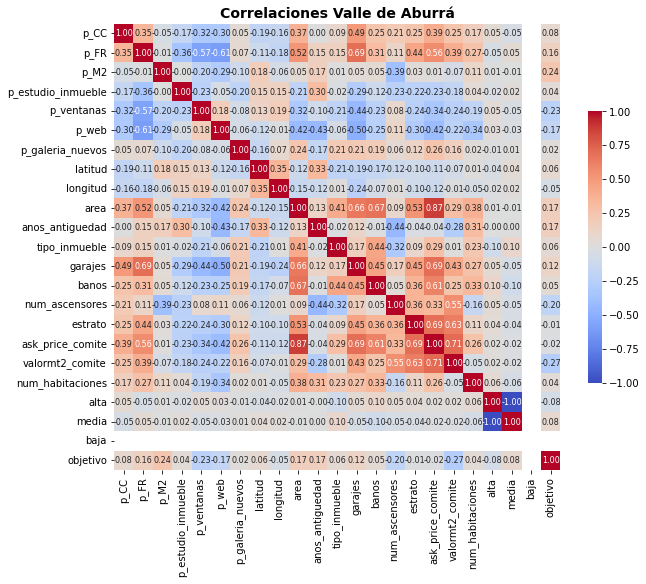

In [188]:
plt.figure(figsize=(10,10))
sns.heatmap(data=corrs_cali,square=True,annot=True,annot_kws={'size': 8},fmt= '.2f',cmap='coolwarm',cbar_kws={"shrink": 0.5})
plt.xticks(rotation = 90,fontsize=10, horizontalalignment='center')
plt.yticks(rotation = 0,fontsize=10)
plt.title("Correlaciones Valle de Aburrá",fontsize=14, weight='bold')
plt.show()

In [189]:
aptos_cali = heat_cali[heat_cali.tipo_inmueble == 1].drop(columns=['tipo_inmueble']).copy()
#aptos_cali = aptos_cali[[col for col in aptos_cali.columns if aptos_cali[col].sum()!=0]]
casas_cali = heat_cali[heat_cali.tipo_inmueble == 2].drop(columns=['tipo_inmueble']).copy()
#casas_cali = casas_cali[[col for col in casas_cali.columns if casas_cali[col].sum()!=0]]
tipo_inmueble_heat_cali = [aptos_cali,casas_cali]

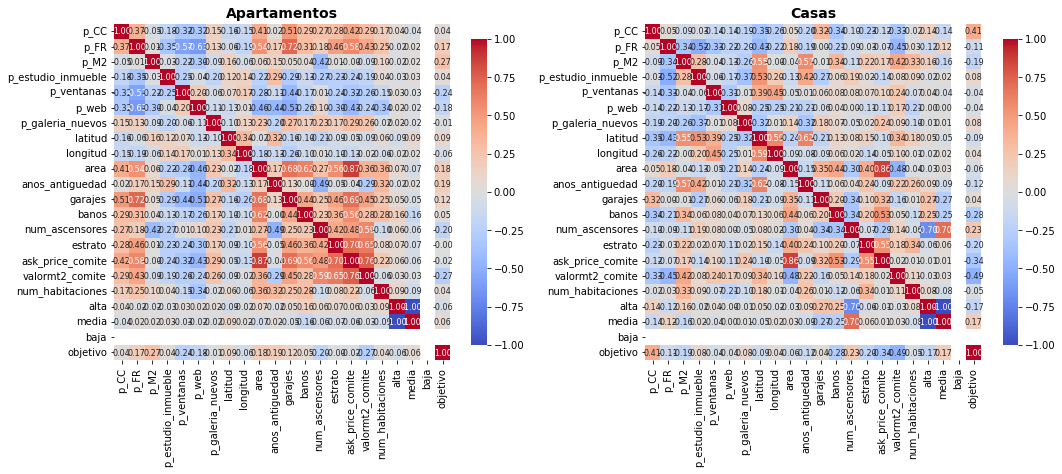

In [190]:
property_names = ['Apartamentos','Casas']
plt.figure(figsize=(15,9))
for i in range(len(tipo_inmueble_heat_cali)):
    plt.subplot(1,2,i+1)
    sns.heatmap(data=tipo_inmueble_heat_cali[i].corr(),
                square=True,annot=True,annot_kws={'size': 8},fmt= '.2f',cmap='coolwarm',cbar_kws={"shrink": 0.5})
    plt.xticks(rotation = 90,fontsize=10, horizontalalignment='center')
    plt.yticks(rotation = 0,fontsize=10)
    plt.title(property_names[i],fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

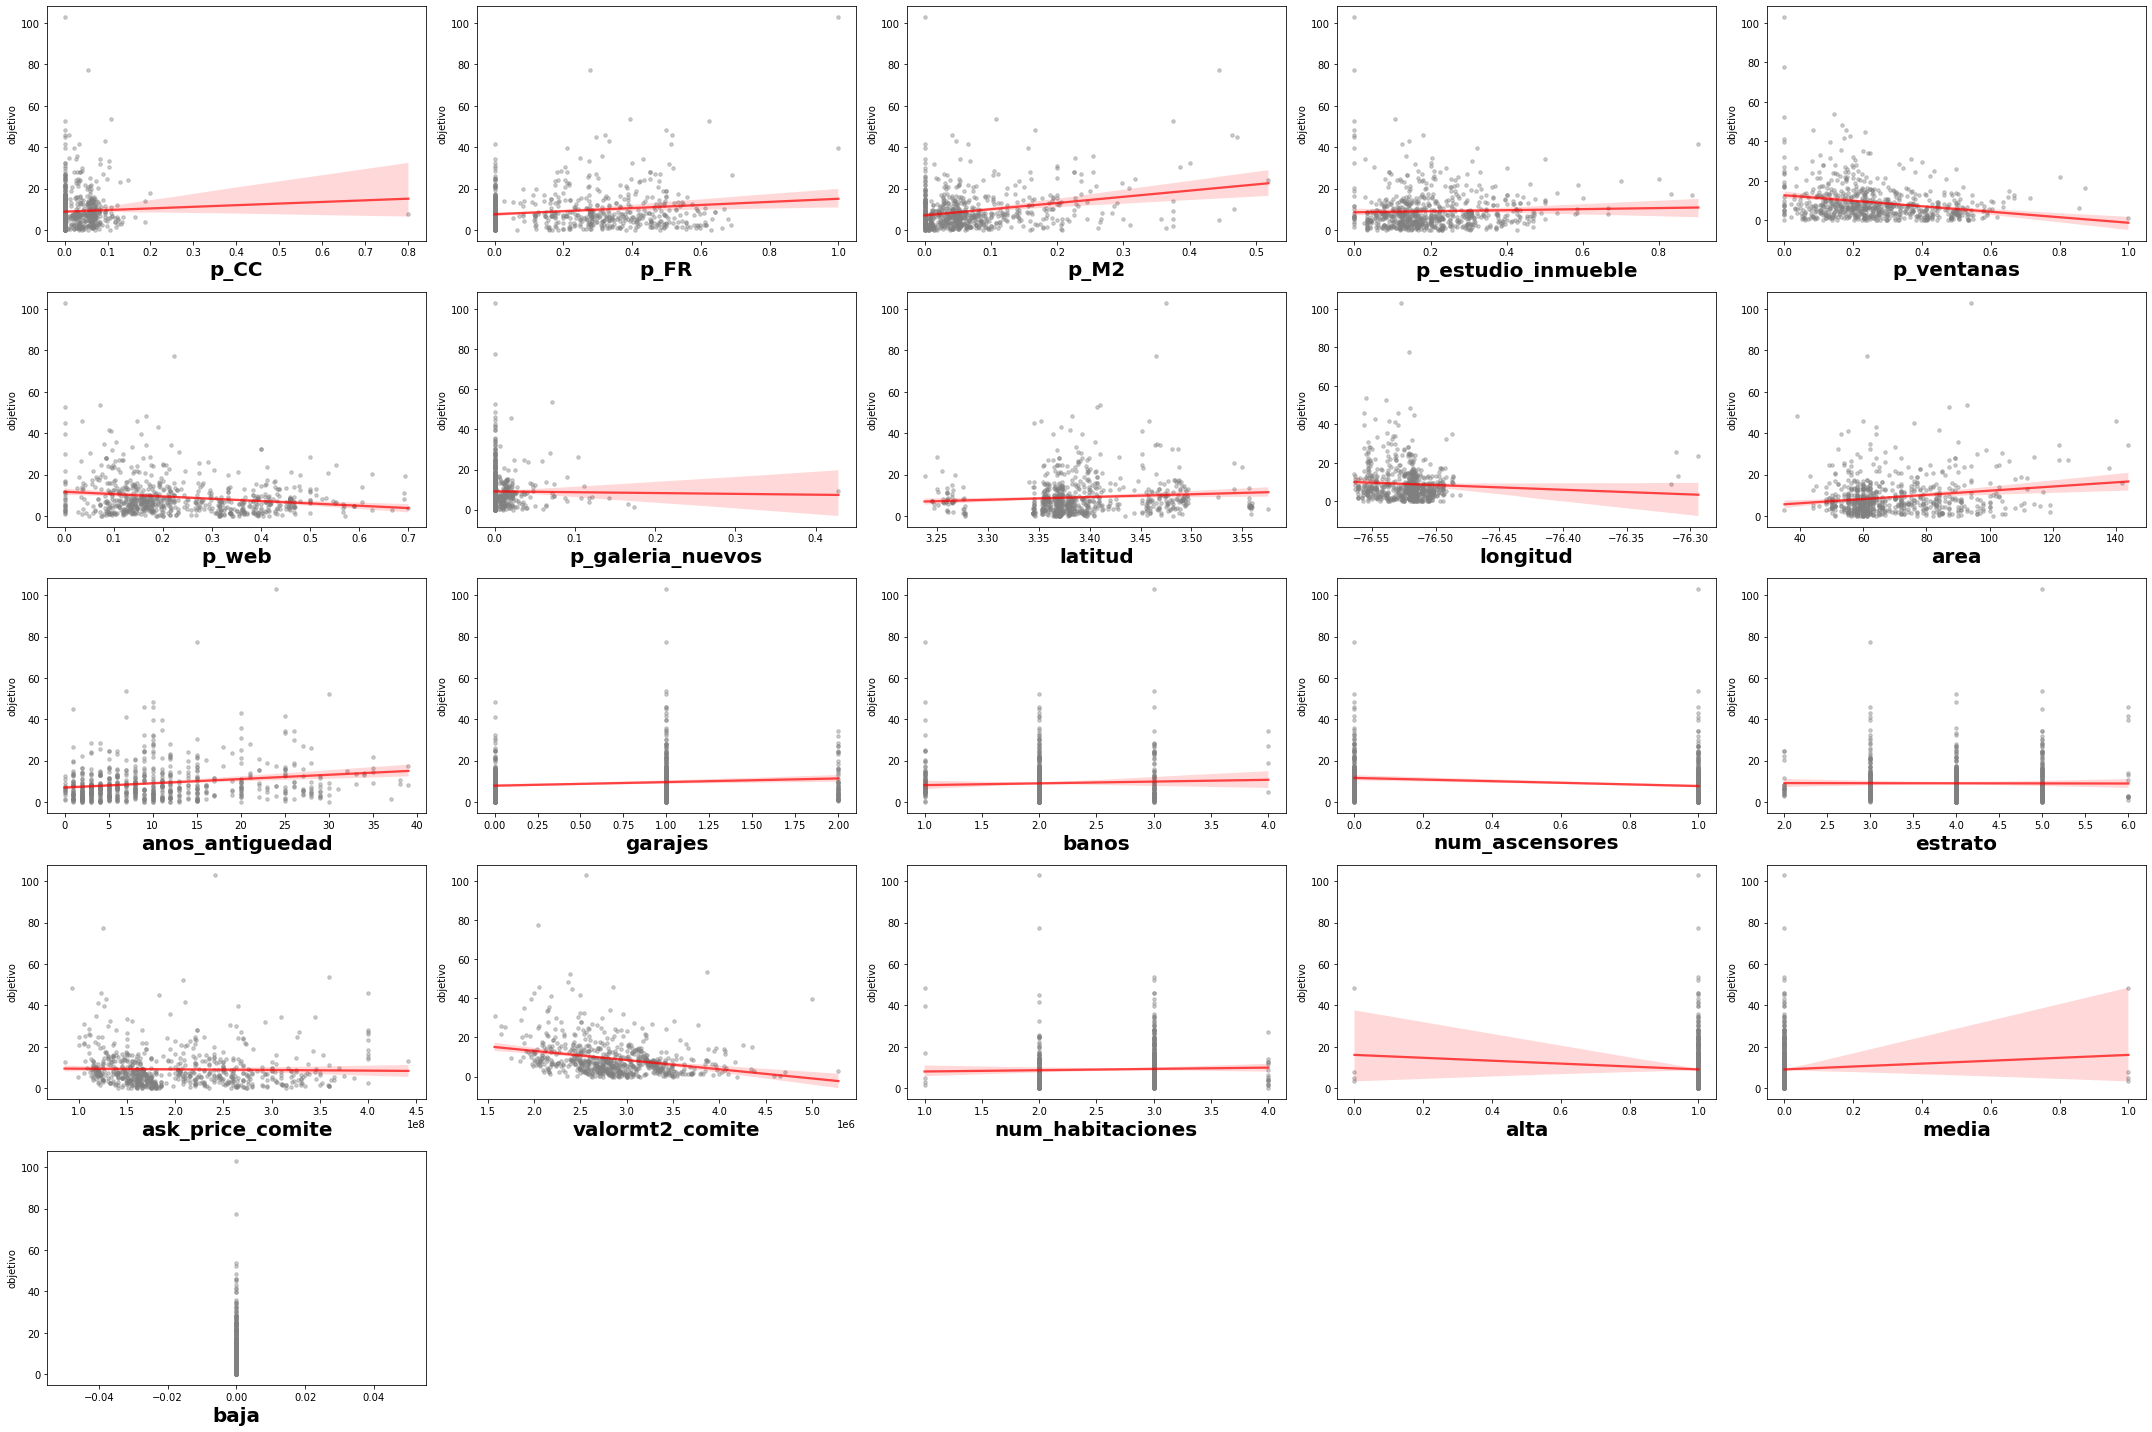

In [191]:
plt.figure(figsize=(30,20))
for idx,col in enumerate(aptos_cali.columns):
    if col !='objetivo':
        plt.subplot(5,5,idx+1)
        sns.regplot(
            x           = aptos_cali[col],
            y           = aptos_cali['objetivo'],
            color       = "gray",
            marker      = '.',
            scatter_kws = {"alpha":0.4,"s":50},
            line_kws    = {"color":"r","alpha":0.7}
        )
        #plt.title(f'{col} vs abs(diferencia_pp_comite)*100', fontweight='bold',fontsize=18, color='#490089')
        plt.xlabel(col, fontweight='bold',fontsize=20)
        #plt.ylabel('abs(diferencia_pp_comite)*100', fontweight='bold',fontsize=18)
plt.tight_layout()

In [192]:
#un precio de comité raro?
aptos_cali.p_CC.min(),aptos_cali.p_CC.max()


(0.0, 0.8)

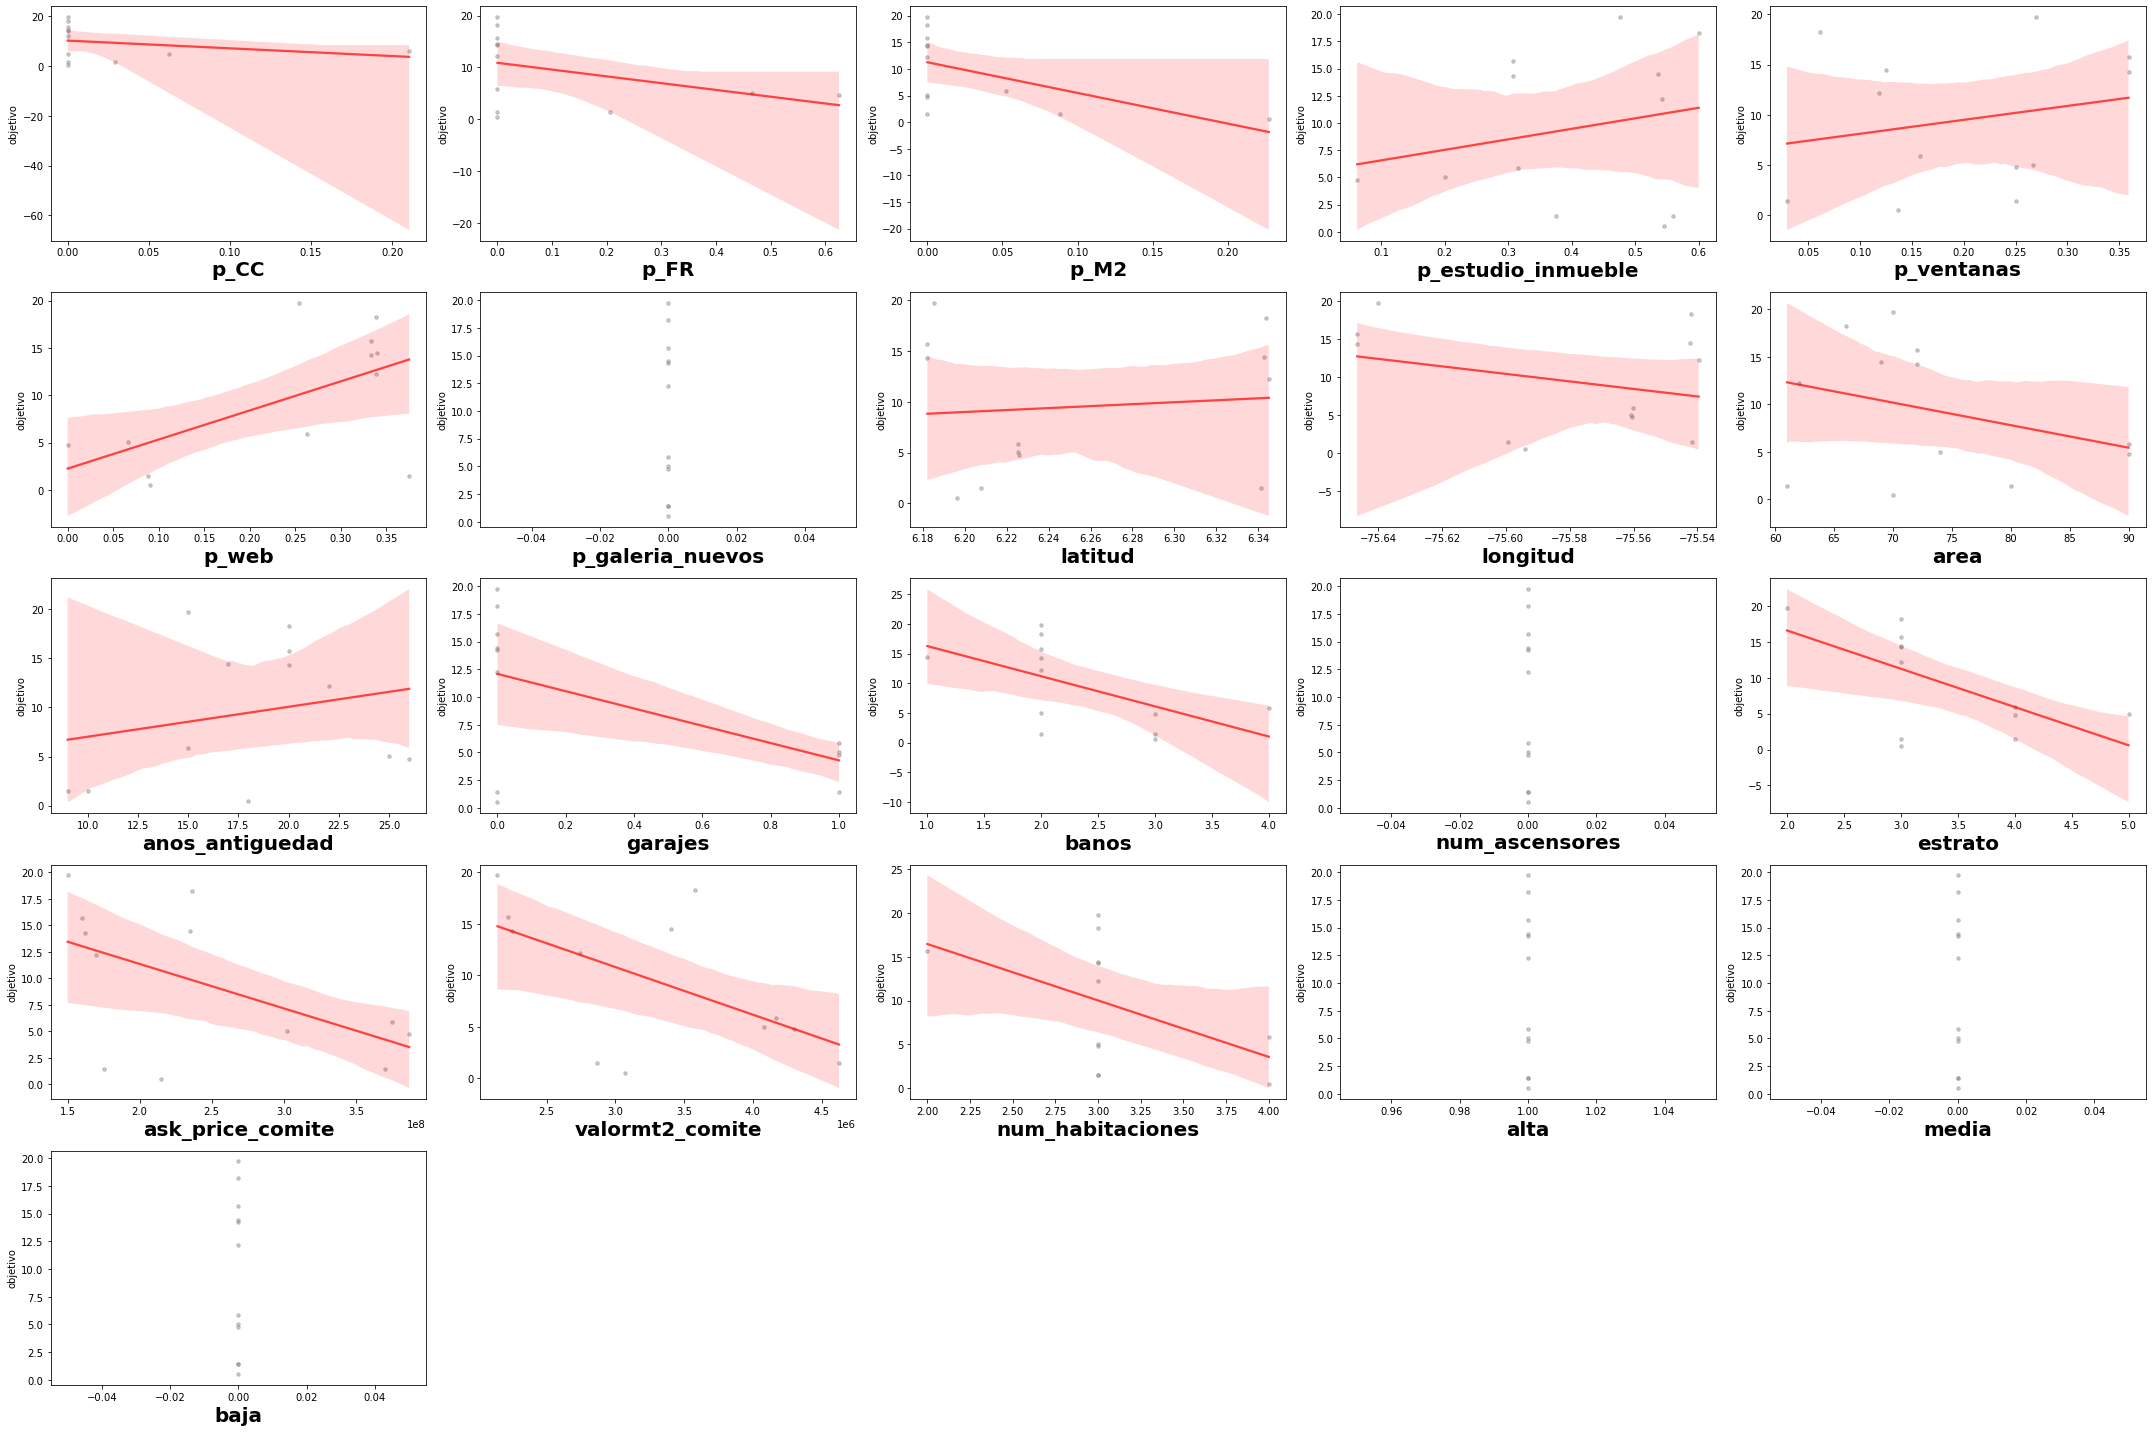

In [193]:
plt.figure(figsize=(30,20))
for idx,col in enumerate(casas_va.columns):
    if col !='objetivo':
        plt.subplot(5,5,idx+1)
        sns.regplot(
            x           = casas_va[col],
            y           = casas_va['objetivo'],
            color       = "gray",
            marker      = '.',
            scatter_kws = {"alpha":0.4,"s":50},
            line_kws    = {"color":"r","alpha":0.7}
        )
        #plt.title(f'{col} vs abs(diferencia_pp_comite)*100', fontweight='bold',fontsize=18, color='#490089')
        plt.xlabel(col, fontweight='bold',fontsize=20)
        #plt.ylabel('abs(diferencia_pp_comite)*100', fontweight='bold',fontsize=18)
plt.tight_layout()
    #break

# Quillami

In [26]:
#bquilla = pd.concat([bquilla,pd.get_dummies(bquilla['name'])],axis=1)
columns_x_baq= p_fuentes.copy()
columns_x_baq.extend(['latitud','longitud','area','anos_antiguedad','tipo_inmueble',
                      'garajes', 'banos', 'num_ascensores', 'estrato',
                      'ask_price_comite', 'valormt2_comite','num_habitaciones','alta','media','baja'])
np.array(columns_x_baq).ravel()

array(['p_PP', 'p_CC', 'p_FR', 'p_M2', 'p_lonja_medellin', 'p_MLS',
       'p_estudio_inmueble', 'p_ventanas', 'p_web', 'p_galeria_usados',
       'p_inmobiliarias', 'p_galeria_nuevos', 'latitud', 'longitud',
       'area', 'anos_antiguedad', 'tipo_inmueble', 'garajes', 'banos',
       'num_ascensores', 'estrato', 'ask_price_comite', 'valormt2_comite',
       'num_habitaciones', 'alta', 'media', 'baja'], dtype='<U18')

In [27]:
#Train-Test Split + Escalado
X_baq = bquilla[columns_x_baq]
X_baq = X_baq[[col for col in X_baq.columns if (
    (X_baq[col].sum()!=0) |
    (col=='alta')|(col=='media')|(col=='baja')
    )]]
r_scaler_baq = preprocessing.RobustScaler()
r_scaler_baq.fit(X_baq)
X_new_baq = r_scaler_baq.transform(X_baq)
y_baq = abs(bquilla['diferencia_pp_last_ask_price_comite']*100)
X_train_abs_p_baq, X_test_abs_p_baq, y_train_abs_p_baq, y_test_abs_p_baq = train_test_split(
    X_new_baq, y_baq,test_size=0.30, random_state=42)

#Modelo XGB
xgb_baq = xgb.XGBRegressor(objective ='reg:squarederror',
                           eval_metric = 'mae',
                           learning_rate = 0.01,
                           max_depth = 2,
                           n_estimators = 1000, gamma=0.1,random_state=42)
xgb_baq.fit(X_train_abs_p_baq,y_train_abs_p_baq)

#Modelo Tree
tree_baq = RandomForestRegressor(criterion="squared_error",
                                 max_features='sqrt',
                                 max_depth=10,
                                 n_estimators=1000,
                                 n_jobs=6,
                                 random_state=42)
tree_baq.fit(X_train_abs_p_baq,y_train_abs_p_baq)

#LGBM
lightgbm_params_baq = {'objective': 'regression',
          'metric': 'rmse',
          'num_leaves': np.int(np.ceil(len(X_baq)*0.2)),
          'min_data_in_leaf':20,
          'max_depth':10,
          'learning_rate': 0.01,
          'verbose': -1,
        'n_estimators':500
             }

lgbm_baq = LGBMRegressor(**lightgbm_params_baq)
lgbm_model = lgbm_baq.fit(X_train_abs_p_baq, y_train_abs_p_baq)                           

#Predicción
y_train_pred_abs_P_baq_xgb = xgb_baq.predict(X_train_abs_p_baq)
y_test_pred_abs_P_baq_xgb = xgb_baq.predict(X_test_abs_p_baq)

y_train_pred_abs_P_baq_tree = tree_baq.predict(X_train_abs_p_baq)
y_test_pred_abs_P_baq_tree = tree_baq.predict(X_test_abs_p_baq)

y_train_pred_abs_P_baq_lgbm = lgbm_baq.predict(X_train_abs_p_baq)
y_test_pred_abs_P_baq_lgbm = lgbm_baq.predict(X_test_abs_p_baq)

#Métricas
pd.DataFrame({'MSE_train': [mean_squared_error(y_train_abs_p_baq,y_train_pred_abs_P_baq_xgb),
                            mean_squared_error(y_train_abs_p_baq,y_train_pred_abs_P_baq_tree),
                           mean_squared_error(y_train_abs_p_baq,y_train_pred_abs_P_baq_lgbm)],
'RMSE_train': [np.sqrt(mean_squared_error(y_train_abs_p_baq,y_train_pred_abs_P_baq_xgb)),
               np.sqrt(mean_squared_error(y_train_abs_p_baq,y_train_pred_abs_P_baq_tree)),
              np.sqrt(mean_squared_error(y_train_abs_p_baq,y_train_pred_abs_P_baq_lgbm))],
'MSE_test': [mean_squared_error(y_test_abs_p_baq,y_test_pred_abs_P_baq_xgb),
             mean_squared_error(y_test_abs_p_baq,y_test_pred_abs_P_baq_tree),
            mean_squared_error(y_test_abs_p_baq,y_test_pred_abs_P_baq_lgbm)],
'RMSE_test': [np.sqrt(mean_squared_error(y_test_abs_p_baq,y_test_pred_abs_P_baq_xgb)),
              np.sqrt(mean_squared_error(y_test_abs_p_baq,y_test_pred_abs_P_baq_tree)),
             np.sqrt(mean_squared_error(y_test_abs_p_baq,y_test_pred_abs_P_baq_lgbm))],
'MAE_train': [mae(y_train_abs_p_baq,y_train_pred_abs_P_baq_xgb),
              mae(y_train_abs_p_baq,y_train_pred_abs_P_baq_tree),
             mae(y_train_abs_p_baq,y_train_pred_abs_P_baq_lgbm)],
'MAPE_train': [mape(y_train_abs_p_baq,y_train_pred_abs_P_baq_xgb),
               mape(y_train_abs_p_baq,y_train_pred_abs_P_baq_tree),
              mape(y_train_abs_p_baq,y_train_pred_abs_P_baq_lgbm)],
'MAE_test': [mae(y_test_abs_p_baq,y_test_pred_abs_P_baq_xgb),
             mae(y_test_abs_p_baq,y_test_pred_abs_P_baq_tree),
             mae(y_test_abs_p_baq,y_test_pred_abs_P_baq_lgbm)],
'MAPE_test': [mape(y_test_abs_p_baq,y_test_pred_abs_P_baq_xgb),
              mape(y_test_abs_p_baq,y_test_pred_abs_P_baq_tree),
             mape(y_test_abs_p_baq,y_test_pred_abs_P_baq_lgbm)],
'R2_train': [r2_score(y_train_abs_p_baq,y_train_pred_abs_P_baq_xgb),
             r2_score(y_train_abs_p_baq,y_train_pred_abs_P_baq_tree),
            r2_score(y_train_abs_p_baq,y_train_pred_abs_P_baq_lgbm)],
'R2_test': [r2_score(y_test_abs_p_baq,y_test_pred_abs_P_baq_xgb),
            r2_score(y_test_abs_p_baq,y_test_pred_abs_P_baq_tree),
           r2_score(y_test_abs_p_baq,y_test_pred_abs_P_baq_lgbm)]},index=['xgb','tree','lgbm'])

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


divide by zero encountered in true_divide


MSE_train  RMSE_train   MSE_test  RMSE_test  MAE_train  \
xgb   29.581905    5.438925  63.469995   7.966806   4.002396   
tree  15.555452    3.944040  54.276531   7.367261   2.955878   
lgbm  21.138533    4.597666  54.645778   7.392278   2.880140   

                        MAPE_train  MAE_test                     MAPE_test  \
xgb   inf por predicciones exactas  5.695200  inf por predicciones exactas   
tree  inf por predicciones exactas  5.108286  inf por predicciones exactas   
lgbm  inf por predicciones exactas  5.045922  inf por predicciones exactas   

      R2_train   R2_test  
xgb   0.664569  0.208864  
tree  0.823616  0.323458  
lgbm  0.760309  0.318855

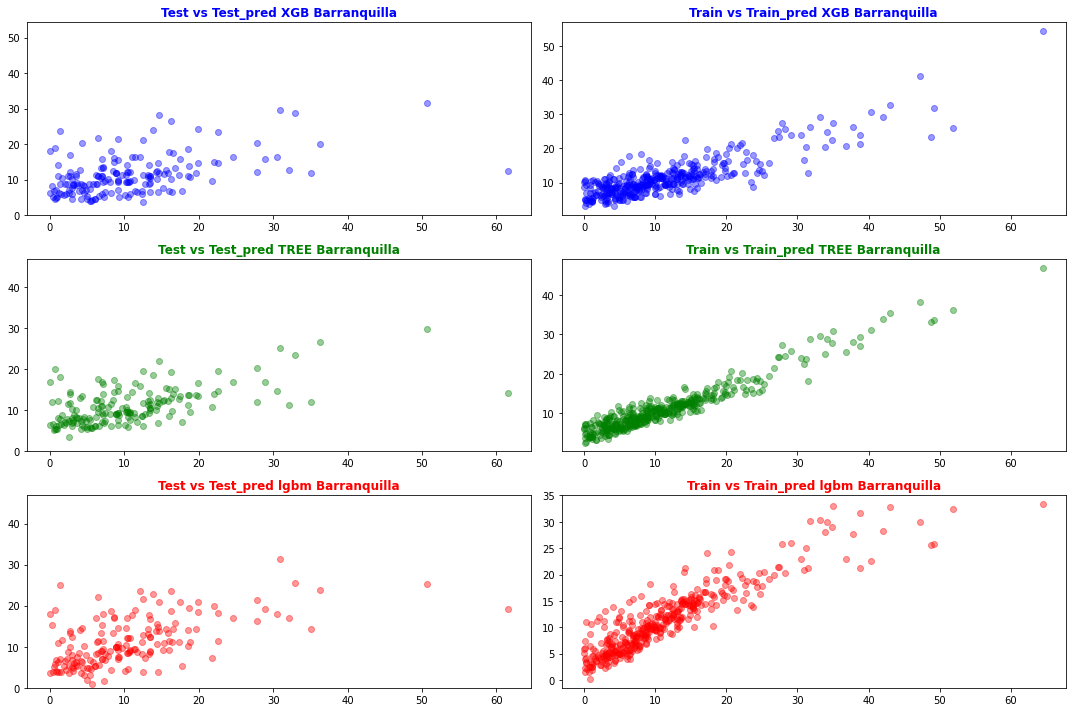

In [28]:
plt.figure(figsize=(15,10))

#XGB
plt.subplot(321)
plt.title('Test vs Test_pred XGB Barranquilla', fontweight='bold', color='b')
plt.scatter(y_test_abs_p_baq,y_test_pred_abs_P_baq_xgb, color='b', alpha=.4)
plt.ylim(0,np.max(y_train_pred_abs_P_baq_xgb))

plt.subplot(322)
plt.title('Train vs Train_pred XGB Barranquilla', fontweight='bold', color='b')
plt.scatter(y_train_abs_p_baq,y_train_pred_abs_P_baq_xgb, color='b', alpha=.4)

#TREE
plt.subplot(323)
plt.title('Test vs Test_pred TREE Barranquilla', fontweight='bold', color='g')
plt.scatter(y_test_abs_p_baq,y_test_pred_abs_P_baq_tree, color='g', alpha=.4)
plt.ylim(0,np.max(y_train_pred_abs_P_baq_tree))

plt.subplot(324)
plt.title('Train vs Train_pred TREE Barranquilla', fontweight='bold', color='g')
plt.scatter(y_train_abs_p_baq,y_train_pred_abs_P_baq_tree, color='g', alpha=.4)

#lgbm
plt.subplot(325)
plt.title('Test vs Test_pred lgbm Barranquilla', fontweight='bold', color='r')
plt.scatter(y_test_abs_p_baq,y_test_pred_abs_P_baq_lgbm, color='r', alpha=.4)
plt.ylim(0,np.max(y_train_pred_abs_P_baq_tree))

plt.subplot(326)
plt.title('Train vs Train_pred lgbm Barranquilla', fontweight='bold', color='r')
plt.scatter(y_train_abs_p_baq,y_train_pred_abs_P_baq_lgbm, color='r', alpha=.4)

plt.tight_layout()
plt.show()

In [29]:
# random sampler
sampler = TPESampler(seed=42)
#Train-Test Split + Escalado
X_baq = bquilla[columns_x_baq]
X_baq = X_baq[[col for col in X_baq.columns if (
    (X_baq[col].sum()!=0) |
    (col=='alta')|(col=='media')|(col=='baja')
    )]]
r_scaler_baq = preprocessing.RobustScaler()
r_scaler_baq.fit(X_baq)
X_new_baq = r_scaler_baq.transform(X_baq)
y_baq = abs(bquilla['diferencia_pp_last_ask_price_comite']*100)
X_train_abs_p_baq, X_test_abs_p_baq, y_train_abs_p_baq, y_test_abs_p_baq = train_test_split(
    X_new_baq, y_baq,test_size=0.30, random_state=42)

# define function
def objective_baq(trial):

    rf_param = {
        "criterion":"squared_error",
        "max_features":'sqrt',
        "max_depth":trial.suggest_int('max_depth',5, 10),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        "n_jobs":6,
        "random_state":42
    }
    
    # Generate model
    tree_model = RandomForestRegressor(**rf_param)
    tree_model = tree_model.fit(X_train_abs_p_baq, y_train_abs_p_baq)
                           
    # * 평기 지표이다.
    # 원하는 평가 지표에 따라 사용하면 된다.                         
    MSE = mean_squared_error(y_test_abs_p_baq, tree_model.predict(X_test_abs_p_baq))
    return MSE

optuna_rf_baq = optuna.create_study(direction='minimize', sampler=sampler)

[I 2022-06-21 21:59:43,443] A new study created in memory with name: no-name-a088ecd7-6737-4d90-baec-341badadb013


In [30]:
optuna.logging.set_verbosity(optuna.logging.INFO)
optuna_rf_baq.optimize(objective_baq, n_trials=500, n_jobs = 6)

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2022-06-21 22:00:19,265] Trial 4 finished with value: 56.55168374936806 and parameters: {'max_depth': 7, 'n_estimators': 551}. Best is trial 4 with value: 56.55168374936806.
[I 2022-06-21 22:00:20,847] Trial 3 finished with value: 55.4981980364227 and parameters: {'max_depth': 8, 'n_estimators': 645}. Best is trial 3 with value: 55.4981980364227.
[I 2022-06-21 22:00:22,224] Trial 1 finished with value: 57.67411418041875 and parameters: {'max_depth': 6, 'n_estimators': 794}. Best is trial 3 with value: 55.4981980364227.
[I 2022-06-21 22:00:22,984] Trial 2 finished with value: 55.6183619726635 and parameters: {'max_depth': 8, 'n_estimators': 758}. Best is trial 3 with value: 55.4981980364227.
[I 2022-06-21 22:00:23,533] Trial 0 finished with value: 55.720716643949345 and parameters: {'max_depth': 8, 'n_estimators': 778}. Best is trial 3 wit

In [31]:
rf_trial_baq = optuna_rf_baq.best_trial
rf_trial_params_baq = rf_trial_baq.params

print('Best Trial: score {},\nparams {}'.format(rf_trial_baq.value, rf_trial_params_baq))

Best Trial: score 54.04276726736679,
params {'max_depth': 10, 'n_estimators': 691}


Best Trial: score 54.04276726736679,
params {'max_depth': 10, 'n_estimators': 691}

In [32]:
# random sampler
sampler_lgbm = TPESampler(seed=42)
# Train-Test split + scaler
X_baq = bquilla[columns_x_baq]
X_baq = X_baq[[col for col in X_baq.columns if (
    (X_baq[col].sum()!=0) |
    (col=='alta')|(col=='media')|(col=='baja')
    )]]
r_scaler_baq = preprocessing.RobustScaler()
r_scaler_baq.fit(X_baq)
X_new_baq = r_scaler_baq.transform(X_baq)
y_baq = abs(bquilla['diferencia_pp_last_ask_price_comite']*100)
X_train_abs_p_baq, X_test_abs_p_baq, y_train_abs_p_baq, y_test_abs_p_baq = train_test_split(
    X_new_baq, y_baq,test_size=0.30, random_state=42)

# define function
def objective_lgbm_baq(trial):

    lgbm_param = {        
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': trial.suggest_int('num_leaves', np.int(np.ceil(len(X_baq)*0.2)), np.int(np.ceil(len(X_baq)*0.25))),
        'min_samples_leaf':trial.suggest_int('min_samples_leaf', 20, 100),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
        'max_depth':trial.suggest_int('max_depth',3, 12),
        'learning_rate': trial.suggest_float('learning_rate',0.01, 0.02),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'verbose': -1
    }

    # Generate model
    lgbm_model = LGBMRegressor(**lgbm_param)
    lgbm_model = lgbm_model.fit(X_train_abs_p_baq, y_train_abs_p_baq)                           
                      
    MSE = mean_squared_error(y_test_abs_p_baq, lgbm_model.predict(X_test_abs_p_baq))
    return MSE

optuna_lgbm_baq = optuna.create_study(direction='minimize', sampler=sampler_lgbm)

[I 2022-06-21 22:17:30,783] A new study created in memory with name: no-name-c92b5a21-bca4-4643-a924-7e79e224c45c


In [33]:
optuna.logging.set_verbosity(optuna.logging.INFO)
optuna_lgbm_baq.optimize(objective_lgbm_baq, n_trials=500, n_jobs = 6)

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75


[I 2022-06-21 22:18:18,168] Trial 3 finished with value: 61.151925590656354 and parameters: {'num_leaves': 116, 'min_samples_leaf': 64, 'reg_alpha': 0.39733431285648557, 'reg_lambda': 3.3709945467721347, 'max_depth': 10, 'learning_rate': 0.01289181349776786, 'n_estimators': 513}. Best is trial 3 with value: 61.151925590656354.
[I 2022-06-21 22:18:18,358] Trial 1 finished with value: 60.745797704949986 and parameters: {'num_leaves': 138, 'min_samples_leaf': 77, 'reg_alpha': 0.30204377775061064, 'reg_lambda': 1.44375687823596, 'max_depth': 4, 'learning_rate': 0.016912616609840534, 'n_estimators': 615}. Best is trial 1 with value: 60.745797704949986.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74


[I 2022-06-21 22:18:18,576] Trial 4 finished with value: 60.257941255168774 and parameters: {'num_leaves': 142, 'min_samples_leaf': 85, 'reg_alpha': 0.5543302053576159, 'reg_lambda': 0.08926366372233319, 'max_depth': 6, 'learning_rate': 0.0128088036905945, 'n_estimators': 906}. Best is trial 4 with value: 60.257941255168774.
[I 2022-06-21 22:18:18,602] Trial 0 finished with value: 59.270681018055015 and parameters: {'num_leaves': 135, 'min_samples_leaf': 60, 'reg_alpha': 0.24343631207185923, 'reg_lambda': 7.312286129543591, 'max_depth': 8, 'learning_rate': 0.016735091661284493, 'n_estimators': 613}. Best is trial 0 with value: 59.270681018055015.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73


[I 2022-06-21 22:18:18,829] Trial 5 finished with value: 60.004322587376116 and parameters: {'num_leaves': 142, 'min_samples_leaf': 75, 'reg_alpha': 0.3019806588316607, 'reg_lambda': 1.8293609360763163, 'max_depth': 6, 'learning_rate': 0.010455072085366071, 'n_estimators': 813}. Best is trial 0 with value: 59.270681018055015.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2022-06-21 22:18:19,270] Trial 2 finished with value: 59.67461172642464 and parameters: {'num_leaves': 120, 'min_samples_leaf': 53, 'reg_alpha': 0.0900765770378712, 'reg_lambda': 9.089346639103862, 'max_depth': 4, 'learning_rate': 0.010304484028274235, 'n_estimators': 941}. Best is trial 0 with value: 59.270681018055015.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53


[I 2022-06-21 22:18:19,901] Trial 7 finished with value: 59.73765703536837 and parameters: {'num_leaves': 126, 'min_samples_leaf': 74, 'reg_alpha': 0.9343017643445154, 'reg_lambda': 1.7876484743782295, 'max_depth': 3, 'learning_rate': 0.011797825866969678, 'n_estimators': 874}. Best is trial 0 with value: 59.270681018055015.
[I 2022-06-21 22:18:20,032] Trial 9 finished with value: 59.395103427722546 and parameters: {'num_leaves': 124, 'min_samples_leaf': 73, 'reg_alpha': 0.5581528410297957, 'reg_lambda': 9.063639411470128, 'max_depth': 7, 'learning_rate': 0.01884957339949063, 'n_estimators': 709}. Best is trial 0 with value: 59.270681018055015.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2022-06-21 22:18:20,152] Trial 8 finished with value: 59.004768314924306 and parameters: {'num_leaves': 140, 'min_samples_leaf': 84, 'reg_alpha': 0.6724665515693085, 'reg_lambda': 0.5826947574909136, 'max_depth': 8, 'learning_rate': 0.01947279204540723, 'n_estimators': 942}. Best is trial 8 with value: 59.004768314924306.
[I 2022-06-21 22:18:20,298] Trial 10 finished with value: 62.70234214063708 and parameters: {'num_leaves': 122, 'min_samples_leaf': 96, 'reg_alpha': 0.8424983817245911, 'reg_lambda': 6.955891548145994, 'max_depth': 7, 'learning_rate': 0.014861110539988537, 'n_estimators': 945}. Best is trial 8 with value: 59.004768314924306.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 22:18:21,611] Trial 6 finished with value: 56.27576950840001 and parameters: {'num_leaves': 118, 'min_samples_leaf': 26, 'reg_alpha': 0.7122519901299862, 'reg_lambda': 3.91804863996697, 'max_depth': 7, 'learning_rate': 0.01660621358158777, 'n_estimators': 845}. Best is trial 6 with value: 56.27576950840001.
[I 2022-06-21 22:18:21,624] Trial 13 finished with value: 57.973758767293624 and parameters: {'num_leaves': 139, 'min_samples_leaf': 59, 'reg_alpha': 0.8189945591546535, 'reg_lambda': 1.5950576013945261, 'max_depth': 4, 'learning_rate': 0.018196140652361886, 'n_estimators': 733}. Best is trial 6 with value: 56.27576950840001.
[I 2022-06-21 22:18:21,707] Trial 11 finished with value: 59.489405248789694 and parameters: {'num_leaves': 128, 'min_samples_leaf': 53, 'reg_alpha': 0.5010559896308289, 'reg_lambda': 4.369484242876581, 'max_depth': 8, 'learning_rate': 0.01656520226071245, 'n_estimators': 926}. Best is trial 6 with value: 56.27576950840001.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 22:18:22,188] Trial 14 finished with value: 58.66658942918068 and parameters: {'num_leaves': 125, 'min_samples_leaf': 69, 'reg_alpha': 0.6772525903779362, 'reg_lambda': 2.102727436517112, 'max_depth': 5, 'learning_rate': 0.01790405500797536, 'n_estimators': 864}. Best is trial 6 with value: 56.27576950840001.
[I 2022-06-21 22:18:22,230] Trial 12 finished with value: 59.11360044727371 and parameters: {'num_leaves': 124, 'min_samples_leaf': 53, 'reg_alpha': 0.03794172386671102, 'reg_lambda': 0.0045804604660237835, 'max_depth': 9, 'learning_rate': 0.01957343705029385, 'n_estimators': 873}. Best is trial 6 with value: 56.27576950840001.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 22:18:25,316] Trial 18 finished with value: 57.181687890145504 and parameters: {'num_leaves': 132, 'min_samples_leaf': 25, 'reg_alpha': 0.7628188449406635, 'reg_lambda': 3.699350083924305, 'max_depth': 12, 'learning_rate': 0.018638776057138, 'n_estimators': 759}. Best is trial 6 with value: 56.27576950840001.
[I 2022-06-21 22:18:25,317] Trial 16 finished with value: 55.66327541432048 and parameters: {'num_leaves': 131, 'min_samples_leaf': 24, 'reg_alpha': 0.7643166247846085, 'reg_lambda': 3.566253089676329, 'max_depth': 12, 'learning_rate': 0.016964853970130492, 'n_estimators': 755}. Best is trial 16 with value: 55.66327541432048.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:18:25,647] Trial 15 finished with value: 57.22040787359723 and parameters: {'num_leaves': 131, 'min_samples_leaf': 25, 'reg_alpha': 0.7290307083620968, 'reg_lambda': 4.78769555108063, 'max_depth': 12, 'learning_rate': 0.01988005326012328, 'n_estimators': 989}. Best is trial 16 with value: 55.66327541432048.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


[I 2022-06-21 22:18:26,084] Trial 20 finished with value: 54.79334916505313 and parameters: {'num_leaves': 132, 'min_samples_leaf': 27, 'reg_alpha': 0.7895668343128551, 'reg_lambda': 3.7949967597930225, 'max_depth': 12, 'learning_rate': 0.01536461477434416, 'n_estimators': 750}. Best is trial 20 with value: 54.79334916505313.
[I 2022-06-21 22:18:26,085] Trial 19 finished with value: 55.09888215151715 and parameters: {'num_leaves': 134, 'min_samples_leaf': 24, 'reg_alpha': 0.7852703022121077, 'reg_lambda': 3.687728666736322, 'max_depth': 12, 'learning_rate': 0.015196549993394967, 'n_estimators': 764}. Best is trial 20 with value: 54.79334916505313.
[I 2022-06-21 22:18:26,139] Trial 17 finished with value: 56.614510359845774 and parameters: {'num_leaves': 131, 'min_samples_leaf': 22, 'reg_alpha': 0.7376858174460887, 'reg_lambda': 3.4807773316571025, 'max_depth': 11, 'learning_rate': 0.01818591495154756, 'n_estimators': 744}. Best is trial 20 with value: 54.79334916505313.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37


[I 2022-06-21 22:18:28,180] Trial 24 finished with value: 55.87611063392544 and parameters: {'num_leaves': 145, 'min_samples_leaf': 41, 'reg_alpha': 0.9645955795752214, 'reg_lambda': 6.143014426583415, 'max_depth': 10, 'learning_rate': 0.015275707324422601, 'n_estimators': 664}. Best is trial 20 with value: 54.79334916505313.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37


[I 2022-06-21 22:18:28,474] Trial 26 finished with value: 54.853420353916064 and parameters: {'num_leaves': 135, 'min_samples_leaf': 37, 'reg_alpha': 0.9740419081774018, 'reg_lambda': 5.871856339921411, 'max_depth': 11, 'learning_rate': 0.014964581226469886, 'n_estimators': 681}. Best is trial 20 with value: 54.79334916505313.
[I 2022-06-21 22:18:28,511] Trial 25 finished with value: 54.73471769482903 and parameters: {'num_leaves': 135, 'min_samples_leaf': 37, 'reg_alpha': 0.9851810518012607, 'reg_lambda': 5.42456463349651, 'max_depth': 11, 'learning_rate': 0.014880372717965953, 'n_estimators': 687}. Best is trial 25 with value: 54.73471769482903.
[I 2022-06-21 22:18:28,758] Trial 23 finished with value: 55.56902599403786 and parameters: {'num_leaves': 116, 'min_samples_leaf': 38, 'reg_alpha': 0.9694872968597514, 'reg_lambda': 6.342915771254285, 'max_depth': 10, 'learning_rate': 0.015382188817164529, 'n_estimators': 801}. Best is trial 25 with value: 54.73471769482903.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


[I 2022-06-21 22:18:30,116] Trial 22 finished with value: 53.05406479556637 and parameters: {'num_leaves': 131, 'min_samples_leaf': 21, 'reg_alpha': 0.9440621697478381, 'reg_lambda': 5.581423701506894, 'max_depth': 12, 'learning_rate': 0.01542832981471525, 'n_estimators': 797}. Best is trial 22 with value: 53.05406479556637.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 22:18:30,967] Trial 27 finished with value: 54.68210231563464 and parameters: {'num_leaves': 135, 'min_samples_leaf': 37, 'reg_alpha': 0.8712201491852489, 'reg_lambda': 5.366524591125903, 'max_depth': 11, 'learning_rate': 0.014963120267739561, 'n_estimators': 782}. Best is trial 22 with value: 53.05406479556637.
[I 2022-06-21 22:18:31,007] Trial 30 finished with value: 55.06064524740841 and parameters: {'num_leaves': 135, 'min_samples_leaf': 36, 'reg_alpha': 0.9221659842537647, 'reg_lambda': 5.42224444676738, 'max_depth': 11, 'learning_rate': 0.01415242560641309, 'n_estimators': 674}. Best is trial 22 with value: 53.05406479556637.
[I 2022-06-21 22:18:31,073] Trial 29 finished with value: 54.63471453422385 and parameters: {'num_leaves': 136, 'min_samples_leaf': 37, 'reg_alpha': 0.9995423600687575, 'reg_lambda': 5.848630813786649, 'max_depth': 10, 'learning_rate': 0.01452344854835398, 'n_estimators': 669}. Best is trial 22 with value: 53.05406479556637.
[I 2022-06-21 22:18

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43


[I 2022-06-21 22:18:31,704] Trial 21 finished with value: 53.381401427815966 and parameters: {'num_leaves': 131, 'min_samples_leaf': 21, 'reg_alpha': 0.9833729329292272, 'reg_lambda': 5.655147857566588, 'max_depth': 12, 'learning_rate': 0.015108305386665268, 'n_estimators': 996}. Best is trial 22 with value: 53.05406479556637.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45


[I 2022-06-21 22:18:32,838] Trial 31 finished with value: 57.14104715521085 and parameters: {'num_leaves': 129, 'min_samples_leaf': 32, 'reg_alpha': 0.8902557988980244, 'reg_lambda': 5.530628273214455, 'max_depth': 11, 'learning_rate': 0.014028352737006066, 'n_estimators': 643}. Best is trial 22 with value: 53.05406479556637.
[I 2022-06-21 22:18:32,917] Trial 32 finished with value: 57.678037258444526 and parameters: {'num_leaves': 128, 'min_samples_leaf': 44, 'reg_alpha': 0.8743504595320216, 'reg_lambda': 7.5512700270267965, 'max_depth': 9, 'learning_rate': 0.0135413120861511, 'n_estimators': 590}. Best is trial 22 with value: 53.05406479556637.
[I 2022-06-21 22:18:32,956] Trial 33 finished with value: 58.390408258793485 and parameters: {'num_leaves': 128, 'min_samples_leaf': 45, 'reg_alpha': 0.8788443733821463, 'reg_lambda': 7.949770313223773, 'max_depth': 9, 'learning_rate': 0.013489362596278101, 'n_estimators': 610}. Best is trial 22 with value: 53.05406479556637.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2022-06-21 22:18:33,196] Trial 34 finished with value: 57.81268795578104 and parameters: {'num_leaves': 128, 'min_samples_leaf': 43, 'reg_alpha': 0.8624810376525183, 'reg_lambda': 7.995149412207262, 'max_depth': 9, 'learning_rate': 0.013706335163263318, 'n_estimators': 600}. Best is trial 22 with value: 53.05406479556637.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 22:18:33,642] Trial 36 finished with value: 57.54536917535137 and parameters: {'num_leaves': 128, 'min_samples_leaf': 45, 'reg_alpha': 0.8804332039789386, 'reg_lambda': 7.920005951982459, 'max_depth': 9, 'learning_rate': 0.015995939030176765, 'n_estimators': 610}. Best is trial 22 with value: 53.05406479556637.
[I 2022-06-21 22:18:33,909] Trial 35 finished with value: 54.429354886892696 and parameters: {'num_leaves': 128, 'min_samples_leaf': 30, 'reg_alpha': 0.859079453980688, 'reg_lambda': 7.977353016938116, 'max_depth': 11, 'learning_rate': 0.01605343031311433, 'n_estimators': 607}. Best is trial 22 with value: 53.05406479556637.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:18:34,595] Trial 38 finished with value: 58.75258742295281 and parameters: {'num_leaves': 137, 'min_samples_leaf': 47, 'reg_alpha': 0.1983174400850578, 'reg_lambda': 4.711041190390878, 'max_depth': 11, 'learning_rate': 0.015996942997143382, 'n_estimators': 559}. Best is trial 22 with value: 53.05406479556637.
[I 2022-06-21 22:18:34,810] Trial 37 finished with value: 59.05714247517674 and parameters: {'num_leaves': 137, 'min_samples_leaf': 47, 'reg_alpha': 0.867312050476609, 'reg_lambda': 8.202606780935056, 'max_depth': 9, 'learning_rate': 0.016060435691385676, 'n_estimators': 585}. Best is trial 22 with value: 53.05406479556637.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 22:18:35,287] Trial 39 finished with value: 57.26173518708612 and parameters: {'num_leaves': 137, 'min_samples_leaf': 33, 'reg_alpha': 0.8322295838236451, 'reg_lambda': 6.954765080132251, 'max_depth': 11, 'learning_rate': 0.01603452485100719, 'n_estimators': 575}. Best is trial 22 with value: 53.05406479556637.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:18:35,615] Trial 40 finished with value: 54.85857028637582 and parameters: {'num_leaves': 137, 'min_samples_leaf': 29, 'reg_alpha': 0.1984127940760434, 'reg_lambda': 6.717017152391497, 'max_depth': 11, 'learning_rate': 0.015697785561635542, 'n_estimators': 536}. Best is trial 22 with value: 53.05406479556637.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:18:36,817] Trial 43 finished with value: 53.9731257674757 and parameters: {'num_leaves': 137, 'min_samples_leaf': 30, 'reg_alpha': 0.9922545566500306, 'reg_lambda': 9.516738232780865, 'max_depth': 12, 'learning_rate': 0.017394390591722077, 'n_estimators': 532}. Best is trial 22 with value: 53.05406479556637.
[I 2022-06-21 22:18:36,919] Trial 44 finished with value: 56.034420033622425 and parameters: {'num_leaves': 133, 'min_samples_leaf': 30, 'reg_alpha': 0.6002879498213132, 'reg_lambda': 6.931027137574141, 'max_depth': 12, 'learning_rate': 0.012795419499646792, 'n_estimators': 503}. Best is trial 22 with value: 53.05406479556637.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:18:37,287] Trial 42 finished with value: 55.496993155211555 and parameters: {'num_leaves': 137, 'min_samples_leaf': 20, 'reg_alpha': 0.9926280540018549, 'reg_lambda': 9.942639687191125, 'max_depth': 12, 'learning_rate': 0.01710718355937884, 'n_estimators': 555}. Best is trial 22 with value: 53.05406479556637.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 22:18:38,603] Trial 45 finished with value: 54.98746597956584 and parameters: {'num_leaves': 133, 'min_samples_leaf': 20, 'reg_alpha': 0.6544137575646611, 'reg_lambda': 2.6461033845965143, 'max_depth': 12, 'learning_rate': 0.01248879163687346, 'n_estimators': 543}. Best is trial 22 with value: 53.05406479556637.
[I 2022-06-21 22:18:38,793] Trial 41 finished with value: 55.15852994847292 and parameters: {'num_leaves': 137, 'min_samples_leaf': 20, 'reg_alpha': 0.1358737174523288, 'reg_lambda': 6.835132817613013, 'max_depth': 11, 'learning_rate': 0.016010672731031912, 'n_estimators': 800}. Best is trial 22 with value: 53.05406479556637.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-06-21 22:18:39,525] Trial 49 finished with value: 55.128371234035626 and parameters: {'num_leaves': 141, 'min_samples_leaf': 31, 'reg_alpha': 0.3985184777247981, 'reg_lambda': 8.837962115607318, 'max_depth': 10, 'learning_rate': 0.017407069088418093, 'n_estimators': 529}. Best is trial 22 with value: 53.05406479556637.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 22:18:40,034] Trial 47 finished with value: 55.35215323211393 and parameters: {'num_leaves': 141, 'min_samples_leaf': 20, 'reg_alpha': 0.99903625424317, 'reg_lambda': 9.713175119715881, 'max_depth': 12, 'learning_rate': 0.017379807833301175, 'n_estimators': 511}. Best is trial 22 with value: 53.05406479556637.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 22:18:40,350] Trial 46 finished with value: 52.5544880577007 and parameters: {'num_leaves': 133, 'min_samples_leaf': 21, 'reg_alpha': 0.6353367148789877, 'reg_lambda': 8.921106627370998, 'max_depth': 12, 'learning_rate': 0.017326372119452094, 'n_estimators': 781}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 22:18:40,705] Trial 48 finished with value: 54.38984429044371 and parameters: {'num_leaves': 140, 'min_samples_leaf': 22, 'reg_alpha': 0.9971886911996067, 'reg_lambda': 9.97429912272592, 'max_depth': 12, 'learning_rate': 0.017213867290334632, 'n_estimators': 637}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 22:18:41,310] Trial 51 finished with value: 56.35790839389441 and parameters: {'num_leaves': 141, 'min_samples_leaf': 32, 'reg_alpha': 0.4292585791429149, 'reg_lambda': 8.889653459393829, 'max_depth': 10, 'learning_rate': 0.01745503764251933, 'n_estimators': 637}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 22:18:41,649] Trial 50 finished with value: 54.69415450800259 and parameters: {'num_leaves': 141, 'min_samples_leaf': 31, 'reg_alpha': 0.40741050238667387, 'reg_lambda': 8.935647908518607, 'max_depth': 10, 'learning_rate': 0.017531766167801888, 'n_estimators': 629}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 22:18:42,338] Trial 52 finished with value: 54.097819955229234 and parameters: {'num_leaves': 126, 'min_samples_leaf': 28, 'reg_alpha': 0.9255738475356612, 'reg_lambda': 9.830954037854923, 'max_depth': 10, 'learning_rate': 0.014429196292149995, 'n_estimators': 636}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 22:18:43,113] Trial 53 finished with value: 53.19332623011227 and parameters: {'num_leaves': 126, 'min_samples_leaf': 27, 'reg_alpha': 0.9359675038248321, 'reg_lambda': 8.742055961251804, 'max_depth': 10, 'learning_rate': 0.014414545295441462, 'n_estimators': 638}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 22:18:43,859] Trial 55 finished with value: 53.53878470015901 and parameters: {'num_leaves': 139, 'min_samples_leaf': 27, 'reg_alpha': 0.3715712891218721, 'reg_lambda': 9.497903788424946, 'max_depth': 12, 'learning_rate': 0.01669175715772598, 'n_estimators': 719}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 22:18:44,274] Trial 54 finished with value: 54.25495848184073 and parameters: {'num_leaves': 130, 'min_samples_leaf': 28, 'reg_alpha': 0.41945341813800413, 'reg_lambda': 8.576841718199889, 'max_depth': 12, 'learning_rate': 0.016627010538111532, 'n_estimators': 824}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:18:45,287] Trial 56 finished with value: 54.86212135427028 and parameters: {'num_leaves': 139, 'min_samples_leaf': 28, 'reg_alpha': 0.9371122014022444, 'reg_lambda': 9.351391544854419, 'max_depth': 12, 'learning_rate': 0.016512803442739164, 'n_estimators': 830}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:18:45,532] Trial 57 finished with value: 53.95469333925447 and parameters: {'num_leaves': 144, 'min_samples_leaf': 27, 'reg_alpha': 0.9402321029877795, 'reg_lambda': 9.454535294507833, 'max_depth': 12, 'learning_rate': 0.01658036599889832, 'n_estimators': 836}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


[I 2022-06-21 22:18:46,196] Trial 58 finished with value: 54.33178170221162 and parameters: {'num_leaves': 122, 'min_samples_leaf': 27, 'reg_alpha': 0.9346893672217843, 'reg_lambda': 9.496763568809834, 'max_depth': 12, 'learning_rate': 0.018698056651997228, 'n_estimators': 835}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84


[I 2022-06-21 22:18:46,494] Trial 59 finished with value: 54.5030808879727 and parameters: {'num_leaves': 126, 'min_samples_leaf': 27, 'reg_alpha': 0.9349053878063772, 'reg_lambda': 9.396172994729424, 'max_depth': 12, 'learning_rate': 0.016565091432431334, 'n_estimators': 720}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:18:47,150] Trial 63 finished with value: 60.91033799331916 and parameters: {'num_leaves': 143, 'min_samples_leaf': 81, 'reg_alpha': 0.3202351116447491, 'reg_lambda': 9.30313625729751, 'max_depth': 6, 'learning_rate': 0.010782055690754357, 'n_estimators': 903}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:18:47,521] Trial 64 finished with value: 62.521990185332264 and parameters: {'num_leaves': 145, 'min_samples_leaf': 84, 'reg_alpha': 0.30096697802297145, 'reg_lambda': 7.392600700929256, 'max_depth': 8, 'learning_rate': 0.010651697055955922, 'n_estimators': 720}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:18:47,774] Trial 60 finished with value: 54.42120230500436 and parameters: {'num_leaves': 122, 'min_samples_leaf': 26, 'reg_alpha': 0.3335413929481585, 'reg_lambda': 9.345561941842991, 'max_depth': 12, 'learning_rate': 0.016701558342030774, 'n_estimators': 850}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:18:47,807] Trial 61 finished with value: 53.7429854988315 and parameters: {'num_leaves': 144, 'min_samples_leaf': 24, 'reg_alpha': 0.3401541921369239, 'reg_lambda': 9.407819766213048, 'max_depth': 12, 'learning_rate': 0.016543155575358424, 'n_estimators': 716}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:18:48,974] Trial 62 finished with value: 54.77605055242031 and parameters: {'num_leaves': 121, 'min_samples_leaf': 24, 'reg_alpha': 0.3358117570343901, 'reg_lambda': 9.394448762176657, 'max_depth': 12, 'learning_rate': 0.010730700655262354, 'n_estimators': 721}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:18:49,456] Trial 68 finished with value: 58.25687499182768 and parameters: {'num_leaves': 132, 'min_samples_leaf': 24, 'reg_alpha': 0.4754797077861564, 'reg_lambda': 3.1085903662386936, 'max_depth': 3, 'learning_rate': 0.015602850818043945, 'n_estimators': 772}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


[I 2022-06-21 22:18:50,510] Trial 65 finished with value: 57.747695961349365 and parameters: {'num_leaves': 144, 'min_samples_leaf': 23, 'reg_alpha': 0.35873184571936584, 'reg_lambda': 8.442137928709084, 'max_depth': 6, 'learning_rate': 0.01783521177397991, 'n_estimators': 980}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:18:50,527] Trial 70 finished with value: 58.3138776600361 and parameters: {'num_leaves': 143, 'min_samples_leaf': 23, 'reg_alpha': 0.4527894243182492, 'reg_lambda': 8.497810873074314, 'max_depth': 3, 'learning_rate': 0.017971875941177412, 'n_estimators': 701}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65


[I 2022-06-21 22:18:51,769] Trial 71 finished with value: 58.5097644176017 and parameters: {'num_leaves': 143, 'min_samples_leaf': 64, 'reg_alpha': 0.26451366023550704, 'reg_lambda': 8.481961159698486, 'max_depth': 11, 'learning_rate': 0.017838262754059662, 'n_estimators': 994}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:18:52,021] Trial 66 finished with value: 56.92311883611963 and parameters: {'num_leaves': 145, 'min_samples_leaf': 23, 'reg_alpha': 0.49593931675102165, 'reg_lambda': 8.452159694816636, 'max_depth': 12, 'learning_rate': 0.015609098571488414, 'n_estimators': 855}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


[I 2022-06-21 22:18:52,478] Trial 72 finished with value: 59.31737470819442 and parameters: {'num_leaves': 143, 'min_samples_leaf': 65, 'reg_alpha': 0.5389313572297995, 'reg_lambda': 4.370494194666491, 'max_depth': 11, 'learning_rate': 0.016340068838313303, 'n_estimators': 795}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2022-06-21 22:18:53,158] Trial 69 finished with value: 57.377403724885355 and parameters: {'num_leaves': 143, 'min_samples_leaf': 23, 'reg_alpha': 0.35153447477057786, 'reg_lambda': 8.45147538703119, 'max_depth': 11, 'learning_rate': 0.0179212375305233, 'n_estimators': 971}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:18:53,264] Trial 67 finished with value: 54.623808048446364 and parameters: {'num_leaves': 143, 'min_samples_leaf': 24, 'reg_alpha': 0.47546719907401724, 'reg_lambda': 8.515382959142755, 'max_depth': 12, 'learning_rate': 0.01817253310566021, 'n_estimators': 994}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2022-06-21 22:18:53,636] Trial 73 finished with value: 54.78632245333193 and parameters: {'num_leaves': 130, 'min_samples_leaf': 34, 'reg_alpha': 0.8025336363975071, 'reg_lambda': 7.585708932767288, 'max_depth': 11, 'learning_rate': 0.014555052975259244, 'n_estimators': 790}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2022-06-21 22:18:54,538] Trial 78 finished with value: 62.098121025958484 and parameters: {'num_leaves': 130, 'min_samples_leaf': 100, 'reg_alpha': 0.9623142663854337, 'reg_lambda': 9.04994494343839, 'max_depth': 12, 'learning_rate': 0.01698260291365194, 'n_estimators': 891}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:18:54,756] Trial 74 finished with value: 56.49492419438234 and parameters: {'num_leaves': 139, 'min_samples_leaf': 33, 'reg_alpha': 0.7943690674434281, 'reg_lambda': 5.030913027213538, 'max_depth': 11, 'learning_rate': 0.014549085287253339, 'n_estimators': 787}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 22:18:55,231] Trial 75 finished with value: 54.268232057628914 and parameters: {'num_leaves': 130, 'min_samples_leaf': 35, 'reg_alpha': 0.8110784406175111, 'reg_lambda': 7.711142186339481, 'max_depth': 11, 'learning_rate': 0.014669063680117653, 'n_estimators': 896}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:18:55,479] Trial 76 finished with value: 54.478459661330305 and parameters: {'num_leaves': 133, 'min_samples_leaf': 34, 'reg_alpha': 0.9581689028252585, 'reg_lambda': 9.11948283934481, 'max_depth': 12, 'learning_rate': 0.014473078378285329, 'n_estimators': 743}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55


[I 2022-06-21 22:18:56,427] Trial 79 finished with value: 55.15537033861866 and parameters: {'num_leaves': 133, 'min_samples_leaf': 34, 'reg_alpha': 0.9504376291754436, 'reg_lambda': 1.0895607999394845, 'max_depth': 12, 'learning_rate': 0.016951719493209286, 'n_estimators': 743}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39


[I 2022-06-21 22:18:57,387] Trial 83 finished with value: 58.51093241493879 and parameters: {'num_leaves': 118, 'min_samples_leaf': 55, 'reg_alpha': 0.9033390252667269, 'reg_lambda': 9.544737114950468, 'max_depth': 12, 'learning_rate': 0.01688739345349943, 'n_estimators': 813}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:18:57,626] Trial 82 finished with value: 54.76053855424858 and parameters: {'num_leaves': 133, 'min_samples_leaf': 40, 'reg_alpha': 0.9586422252661783, 'reg_lambda': 8.78568578263254, 'max_depth': 12, 'learning_rate': 0.019041013195232985, 'n_estimators': 696}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:18:57,885] Trial 80 finished with value: 55.19913591192362 and parameters: {'num_leaves': 139, 'min_samples_leaf': 34, 'reg_alpha': 0.9647748676826832, 'reg_lambda': 5.101163885646505, 'max_depth': 12, 'learning_rate': 0.01918877609151371, 'n_estimators': 813}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 22:18:57,935] Trial 77 finished with value: 57.23264022565561 and parameters: {'num_leaves': 130, 'min_samples_leaf': 26, 'reg_alpha': 0.9506043930439931, 'reg_lambda': 0.4122428828166047, 'max_depth': 12, 'learning_rate': 0.014612489081205325, 'n_estimators': 890}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:18:58,135] Trial 81 finished with value: 54.11936617184837 and parameters: {'num_leaves': 133, 'min_samples_leaf': 26, 'reg_alpha': 0.9554872683896252, 'reg_lambda': 9.135876670773927, 'max_depth': 12, 'learning_rate': 0.016311430120049226, 'n_estimators': 699}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 22:18:59,650] Trial 84 finished with value: 54.72158407165383 and parameters: {'num_leaves': 119, 'min_samples_leaf': 39, 'reg_alpha': 0.8965480224592777, 'reg_lambda': 9.654856113707968, 'max_depth': 12, 'learning_rate': 0.015120891002354133, 'n_estimators': 926}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2022-06-21 22:19:00,847] Trial 89 finished with value: 54.30799687143934 and parameters: {'num_leaves': 124, 'min_samples_leaf': 29, 'reg_alpha': 0.8427258358068602, 'reg_lambda': 9.802978633835107, 'max_depth': 7, 'learning_rate': 0.01418884922754339, 'n_estimators': 654}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:19:01,292] Trial 86 finished with value: 54.31134824358491 and parameters: {'num_leaves': 125, 'min_samples_leaf': 26, 'reg_alpha': 0.9011101689229634, 'reg_lambda': 9.723893211918359, 'max_depth': 8, 'learning_rate': 0.016274516805144856, 'n_estimators': 775}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:01,759] Trial 88 finished with value: 54.563606561458144 and parameters: {'num_leaves': 126, 'min_samples_leaf': 29, 'reg_alpha': 0.9048276692018629, 'reg_lambda': 9.767906791696026, 'max_depth': 7, 'learning_rate': 0.014224348338083115, 'n_estimators': 769}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:19:02,179] Trial 87 finished with value: 54.52761057536753 and parameters: {'num_leaves': 126, 'min_samples_leaf': 26, 'reg_alpha': 0.9080708211007659, 'reg_lambda': 9.856921116208495, 'max_depth': 7, 'learning_rate': 0.015186085890097019, 'n_estimators': 759}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:19:03,578] Trial 90 finished with value: 54.47350044550203 and parameters: {'num_leaves': 124, 'min_samples_leaf': 30, 'reg_alpha': 0.8396141667619674, 'reg_lambda': 9.706033140402468, 'max_depth': 8, 'learning_rate': 0.015488848853703377, 'n_estimators': 656}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:19:04,006] Trial 85 finished with value: 55.11318680498292 and parameters: {'num_leaves': 134, 'min_samples_leaf': 20, 'reg_alpha': 0.6007818817172218, 'reg_lambda': 6.5716643910720975, 'max_depth': 12, 'learning_rate': 0.016305591886682895, 'n_estimators': 927}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:19:05,777] Trial 91 finished with value: 53.642728534777056 and parameters: {'num_leaves': 126, 'min_samples_leaf': 21, 'reg_alpha': 0.9157921174295064, 'reg_lambda': 6.5295217009590205, 'max_depth': 8, 'learning_rate': 0.015346050303083496, 'n_estimators': 773}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:19:06,539] Trial 92 finished with value: 55.113256881265016 and parameters: {'num_leaves': 127, 'min_samples_leaf': 22, 'reg_alpha': 0.7003211601094078, 'reg_lambda': 6.451302164706386, 'max_depth': 10, 'learning_rate': 0.013787212290620361, 'n_estimators': 729}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:19:06,850] Trial 94 finished with value: 55.193156760093736 and parameters: {'num_leaves': 127, 'min_samples_leaf': 20, 'reg_alpha': 0.6924818632485823, 'reg_lambda': 9.977797702873406, 'max_depth': 10, 'learning_rate': 0.01557701871850775, 'n_estimators': 623}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:07,010] Trial 93 finished with value: 53.285608965335285 and parameters: {'num_leaves': 127, 'min_samples_leaf': 21, 'reg_alpha': 0.3755524121771404, 'reg_lambda': 9.959712154863235, 'max_depth': 11, 'learning_rate': 0.013759095689046591, 'n_estimators': 730}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:19:07,182] Trial 95 finished with value: 54.84686831916007 and parameters: {'num_leaves': 129, 'min_samples_leaf': 22, 'reg_alpha': 0.6201602588178549, 'reg_lambda': 8.240602425669145, 'max_depth': 10, 'learning_rate': 0.01327315965914795, 'n_estimators': 622}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:19:08,264] Trial 96 finished with value: 52.8914732534571 and parameters: {'num_leaves': 132, 'min_samples_leaf': 21, 'reg_alpha': 0.3759232888608912, 'reg_lambda': 9.110225794457103, 'max_depth': 11, 'learning_rate': 0.0157973781281503, 'n_estimators': 733}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:19:08,711] Trial 97 finished with value: 55.63359474255433 and parameters: {'num_leaves': 127, 'min_samples_leaf': 21, 'reg_alpha': 0.9798427025129832, 'reg_lambda': 5.831926634407362, 'max_depth': 5, 'learning_rate': 0.015839480758105803, 'n_estimators': 728}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 22:19:09,573] Trial 99 finished with value: 56.63635910831162 and parameters: {'num_leaves': 129, 'min_samples_leaf': 22, 'reg_alpha': 0.9315053752226627, 'reg_lambda': 5.78347763453379, 'max_depth': 5, 'learning_rate': 0.013153316702119855, 'n_estimators': 683}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 22:19:10,935] Trial 98 finished with value: 53.06122794407852 and parameters: {'num_leaves': 131, 'min_samples_leaf': 21, 'reg_alpha': 0.013184436892710816, 'reg_lambda': 5.979311914690924, 'max_depth': 11, 'learning_rate': 0.01582381238769568, 'n_estimators': 733}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 22:19:11,273] Trial 100 finished with value: 55.62490140439281 and parameters: {'num_leaves': 129, 'min_samples_leaf': 22, 'reg_alpha': 0.25621176745961133, 'reg_lambda': 5.884512240834057, 'max_depth': 11, 'learning_rate': 0.01363031670316812, 'n_estimators': 681}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:11,534] Trial 101 finished with value: 53.37041341979509 and parameters: {'num_leaves': 129, 'min_samples_leaf': 21, 'reg_alpha': 0.30404427057811645, 'reg_lambda': 5.645255259223557, 'max_depth': 11, 'learning_rate': 0.015833210733265445, 'n_estimators': 680}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 22:19:12,162] Trial 103 finished with value: 54.39246863286119 and parameters: {'num_leaves': 131, 'min_samples_leaf': 25, 'reg_alpha': 0.28549883319761815, 'reg_lambda': 7.138891641038107, 'max_depth': 11, 'learning_rate': 0.014972182639253755, 'n_estimators': 683}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:19:12,617] Trial 102 finished with value: 52.59198928058453 and parameters: {'num_leaves': 125, 'min_samples_leaf': 21, 'reg_alpha': 0.35866286022096666, 'reg_lambda': 5.805576697415534, 'max_depth': 11, 'learning_rate': 0.014844795981901696, 'n_estimators': 734}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:19:13,533] Trial 104 finished with value: 54.29545421443735 and parameters: {'num_leaves': 131, 'min_samples_leaf': 25, 'reg_alpha': 0.37384665926061306, 'reg_lambda': 9.209448558073792, 'max_depth': 11, 'learning_rate': 0.01581595574718272, 'n_estimators': 749}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:19:14,176] Trial 105 finished with value: 55.349163839748655 and parameters: {'num_leaves': 131, 'min_samples_leaf': 25, 'reg_alpha': 0.15918653727252136, 'reg_lambda': 5.674941312018341, 'max_depth': 11, 'learning_rate': 0.014845382969712875, 'n_estimators': 714}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:19:14,879] Trial 106 finished with value: 54.186518744767056 and parameters: {'num_leaves': 131, 'min_samples_leaf': 24, 'reg_alpha': 0.37751410473492464, 'reg_lambda': 8.721977165407498, 'max_depth': 11, 'learning_rate': 0.01533427135763184, 'n_estimators': 711}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:19:15,291] Trial 107 finished with value: 55.21653621809387 and parameters: {'num_leaves': 131, 'min_samples_leaf': 25, 'reg_alpha': 0.3777907270365472, 'reg_lambda': 5.60963007879462, 'max_depth': 11, 'learning_rate': 0.014803696828224355, 'n_estimators': 713}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:19:17,022] Trial 108 finished with value: 55.87259017172165 and parameters: {'num_leaves': 132, 'min_samples_leaf': 20, 'reg_alpha': 0.025449760111305064, 'reg_lambda': 6.148907800647306, 'max_depth': 11, 'learning_rate': 0.015242502215305515, 'n_estimators': 711}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:19:17,557] Trial 109 finished with value: 55.64519361836387 and parameters: {'num_leaves': 132, 'min_samples_leaf': 20, 'reg_alpha': 0.3780764152018732, 'reg_lambda': 5.604526525084829, 'max_depth': 11, 'learning_rate': 0.015362072905378716, 'n_estimators': 740}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:19:18,743] Trial 110 finished with value: 55.00756757006605 and parameters: {'num_leaves': 125, 'min_samples_leaf': 20, 'reg_alpha': 0.0583490177643237, 'reg_lambda': 5.27040142795344, 'max_depth': 11, 'learning_rate': 0.014845809091877684, 'n_estimators': 741}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:18,948] Trial 111 finished with value: 55.96918217243434 and parameters: {'num_leaves': 123, 'min_samples_leaf': 20, 'reg_alpha': 0.378994234763678, 'reg_lambda': 5.280339437629007, 'max_depth': 11, 'learning_rate': 0.015233140599407476, 'n_estimators': 734}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:19:19,476] Trial 113 finished with value: 53.364715304545264 and parameters: {'num_leaves': 123, 'min_samples_leaf': 21, 'reg_alpha': 0.736972615912801, 'reg_lambda': 6.134640998220763, 'max_depth': 9, 'learning_rate': 0.01581651057695273, 'n_estimators': 756}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:19,687] Trial 112 finished with value: 55.25150481373491 and parameters: {'num_leaves': 125, 'min_samples_leaf': 20, 'reg_alpha': 0.05311815204106578, 'reg_lambda': 4.776736116613039, 'max_depth': 10, 'learning_rate': 0.014740749696518432, 'n_estimators': 757}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:19:21,782] Trial 115 finished with value: 55.852072845616135 and parameters: {'num_leaves': 127, 'min_samples_leaf': 22, 'reg_alpha': 0.4426719068621461, 'reg_lambda': 4.74070988193489, 'max_depth': 9, 'learning_rate': 0.015803006725554233, 'n_estimators': 755}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:21,803] Trial 114 finished with value: 53.58373456064763 and parameters: {'num_leaves': 123, 'min_samples_leaf': 21, 'reg_alpha': 0.06581557972915159, 'reg_lambda': 6.12245339610658, 'max_depth': 9, 'learning_rate': 0.015413841870579235, 'n_estimators': 737}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2022-06-21 22:19:23,010] Trial 121 finished with value: 62.04411091633682 and parameters: {'num_leaves': 121, 'min_samples_leaf': 92, 'reg_alpha': 0.21911589416000657, 'reg_lambda': 6.214304645834414, 'max_depth': 9, 'learning_rate': 0.013967498734129157, 'n_estimators': 695}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 22:19:23,310] Trial 117 finished with value: 56.438901074244136 and parameters: {'num_leaves': 129, 'min_samples_leaf': 22, 'reg_alpha': 0.20276092143505853, 'reg_lambda': 4.628592861787028, 'max_depth': 10, 'learning_rate': 0.016111723432765734, 'n_estimators': 752}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:23,363] Trial 116 finished with value: 56.04899496806621 and parameters: {'num_leaves': 127, 'min_samples_leaf': 22, 'reg_alpha': 0.43225525076821425, 'reg_lambda': 4.670916447794278, 'max_depth': 10, 'learning_rate': 0.01577291131359174, 'n_estimators': 779}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 22:19:23,814] Trial 118 finished with value: 55.58798672278039 and parameters: {'num_leaves': 123, 'min_samples_leaf': 22, 'reg_alpha': 0.7321266007999809, 'reg_lambda': 4.610556277105016, 'max_depth': 9, 'learning_rate': 0.015796285340526788, 'n_estimators': 754}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:23,873] Trial 119 finished with value: 57.17341123359801 and parameters: {'num_leaves': 127, 'min_samples_leaf': 23, 'reg_alpha': 0.4434123777438792, 'reg_lambda': 6.142686665345182, 'max_depth': 9, 'learning_rate': 0.015830681901241136, 'n_estimators': 778}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-06-21 22:19:26,118] Trial 122 finished with value: 55.11882618866029 and parameters: {'num_leaves': 124, 'min_samples_leaf': 28, 'reg_alpha': 0.01355071759632994, 'reg_lambda': 4.27997996976956, 'max_depth': 9, 'learning_rate': 0.016179881738446342, 'n_estimators': 672}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:26,140] Trial 120 finished with value: 57.22317605161728 and parameters: {'num_leaves': 129, 'min_samples_leaf': 23, 'reg_alpha': 0.11713528626284739, 'reg_lambda': 6.273714796473123, 'max_depth': 9, 'learning_rate': 0.016134579667775203, 'n_estimators': 730}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:26,423] Trial 123 finished with value: 54.89421448357821 and parameters: {'num_leaves': 123, 'min_samples_leaf': 27, 'reg_alpha': 0.7436476220403344, 'reg_lambda': 5.948823619510068, 'max_depth': 9, 'learning_rate': 0.015064708447486322, 'n_estimators': 673}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:19:26,863] Trial 124 finished with value: 55.1106767087375 and parameters: {'num_leaves': 123, 'min_samples_leaf': 28, 'reg_alpha': 0.09471371086648193, 'reg_lambda': 6.071263779262323, 'max_depth': 9, 'learning_rate': 0.01546456515831503, 'n_estimators': 729}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:19:27,311] Trial 126 finished with value: 54.8702399502962 and parameters: {'num_leaves': 124, 'min_samples_leaf': 28, 'reg_alpha': 0.3164091296756284, 'reg_lambda': 5.9778592956369785, 'max_depth': 10, 'learning_rate': 0.014329243824824636, 'n_estimators': 729}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:19:27,654] Trial 125 finished with value: 54.76791192621323 and parameters: {'num_leaves': 136, 'min_samples_leaf': 28, 'reg_alpha': 0.7670308000703148, 'reg_lambda': 6.149159035058602, 'max_depth': 8, 'learning_rate': 0.015468142392944187, 'n_estimators': 765}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:19:29,514] Trial 128 finished with value: 54.691033047631336 and parameters: {'num_leaves': 123, 'min_samples_leaf': 27, 'reg_alpha': 0.537711914255008, 'reg_lambda': 5.99540573612679, 'max_depth': 8, 'learning_rate': 0.01434203562182455, 'n_estimators': 765}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:29,772] Trial 127 finished with value: 54.79902862057052 and parameters: {'num_leaves': 123, 'min_samples_leaf': 27, 'reg_alpha': 0.5355879476101472, 'reg_lambda': 6.699960448796156, 'max_depth': 8, 'learning_rate': 0.015050959790659534, 'n_estimators': 762}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:19:29,818] Trial 129 finished with value: 55.0124734545686 and parameters: {'num_leaves': 123, 'min_samples_leaf': 24, 'reg_alpha': 0.5161036101212011, 'reg_lambda': 6.639504503313093, 'max_depth': 8, 'learning_rate': 0.015485578389862035, 'n_estimators': 763}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71


[I 2022-06-21 22:19:30,415] Trial 130 finished with value: 53.70177669634989 and parameters: {'num_leaves': 128, 'min_samples_leaf': 24, 'reg_alpha': 0.3170767116468267, 'reg_lambda': 6.5910199261832565, 'max_depth': 8, 'learning_rate': 0.01432568889964006, 'n_estimators': 764}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:19:31,174] Trial 131 finished with value: 54.37250638260056 and parameters: {'num_leaves': 128, 'min_samples_leaf': 24, 'reg_alpha': 0.5607294546328494, 'reg_lambda': 6.797201475384457, 'max_depth': 10, 'learning_rate': 0.015481492322848962, 'n_estimators': 802}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:31,252] Trial 135 finished with value: 60.13633105492919 and parameters: {'num_leaves': 128, 'min_samples_leaf': 71, 'reg_alpha': 0.41344745191618154, 'reg_lambda': 5.498484530951367, 'max_depth': 11, 'learning_rate': 0.014037019863419011, 'n_estimators': 704}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:19:31,817] Trial 132 finished with value: 53.857609710379016 and parameters: {'num_leaves': 125, 'min_samples_leaf': 24, 'reg_alpha': 0.40173355971677194, 'reg_lambda': 6.5982359314397145, 'max_depth': 8, 'learning_rate': 0.015029726410655952, 'n_estimators': 803}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:19:33,835] Trial 134 finished with value: 54.38801097484711 and parameters: {'num_leaves': 125, 'min_samples_leaf': 24, 'reg_alpha': 0.6696729974228092, 'reg_lambda': 5.37840663234487, 'max_depth': 11, 'learning_rate': 0.01643450488203036, 'n_estimators': 808}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:33,847] Trial 133 finished with value: 54.7261215575614 and parameters: {'num_leaves': 125, 'min_samples_leaf': 24, 'reg_alpha': 0.003002132415075501, 'reg_lambda': 6.481777406820866, 'max_depth': 11, 'learning_rate': 0.013872052238488954, 'n_estimators': 803}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:19:34,671] Trial 136 finished with value: 52.863731997008045 and parameters: {'num_leaves': 128, 'min_samples_leaf': 21, 'reg_alpha': 0.2851973859547652, 'reg_lambda': 7.140386353904437, 'max_depth': 8, 'learning_rate': 0.013857312399056514, 'n_estimators': 808}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:34,674] Trial 138 finished with value: 53.25247054019334 and parameters: {'num_leaves': 126, 'min_samples_leaf': 21, 'reg_alpha': 0.29331315329258684, 'reg_lambda': 6.420620261824778, 'max_depth': 8, 'learning_rate': 0.013880617885823614, 'n_estimators': 649}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:19:35,746] Trial 139 finished with value: 55.605510398759364 and parameters: {'num_leaves': 126, 'min_samples_leaf': 22, 'reg_alpha': 0.0009297332591221945, 'reg_lambda': 6.392196982632589, 'max_depth': 11, 'learning_rate': 0.016807052290665776, 'n_estimators': 739}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:35,838] Trial 137 finished with value: 53.38151312541173 and parameters: {'num_leaves': 125, 'min_samples_leaf': 21, 'reg_alpha': 0.40865286582656846, 'reg_lambda': 6.426012924736773, 'max_depth': 11, 'learning_rate': 0.016760524196685334, 'n_estimators': 741}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-21 22:19:38,476] Trial 142 finished with value: 53.20247389021583 and parameters: {'num_leaves': 132, 'min_samples_leaf': 21, 'reg_alpha': 0.2641488721810711, 'reg_lambda': 7.136623611846007, 'max_depth': 12, 'learning_rate': 0.01319994102087189, 'n_estimators': 652}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:38,508] Trial 145 finished with value: 54.644094686146204 and parameters: {'num_leaves': 132, 'min_samples_leaf': 31, 'reg_alpha': 0.2931116624459446, 'reg_lambda': 5.070490028307864, 'max_depth': 12, 'learning_rate': 0.013270062011723592, 'n_estimators': 648}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:38,545] Trial 140 finished with value: 53.74559356622046 and parameters: {'num_leaves': 126, 'min_samples_leaf': 21, 'reg_alpha': 0.3594625025951237, 'reg_lambda': 7.007170617539218, 'max_depth': 12, 'learning_rate': 0.017613207912090156, 'n_estimators': 789}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:19:39,400] Trial 143 finished with value: 52.836290393062505 and parameters: {'num_leaves': 132, 'min_samples_leaf': 21, 'reg_alpha': 0.30348564476340606, 'reg_lambda': 7.062033646293441, 'max_depth': 12, 'learning_rate': 0.01310233139387145, 'n_estimators': 786}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:39,578] Trial 144 finished with value: 53.00647722844772 and parameters: {'num_leaves': 132, 'min_samples_leaf': 21, 'reg_alpha': 0.2818098362928416, 'reg_lambda': 7.320937138527903, 'max_depth': 12, 'learning_rate': 0.01342589579775851, 'n_estimators': 646}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:39,599] Trial 141 finished with value: 53.78429563394306 and parameters: {'num_leaves': 130, 'min_samples_leaf': 21, 'reg_alpha': 0.3117870980775942, 'reg_lambda': 7.278378676269298, 'max_depth': 12, 'learning_rate': 0.01676419929639924, 'n_estimators': 956}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:19:41,484] Trial 150 finished with value: 59.26711980500494 and parameters: {'num_leaves': 134, 'min_samples_leaf': 51, 'reg_alpha': 0.267652023882673, 'reg_lambda': 7.164153586671965, 'max_depth': 12, 'learning_rate': 0.012509503356623467, 'n_estimators': 664}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:19:42,570] Trial 147 finished with value: 55.05019911519488 and parameters: {'num_leaves': 130, 'min_samples_leaf': 20, 'reg_alpha': 0.2574732713007303, 'reg_lambda': 7.284933526965628, 'max_depth': 12, 'learning_rate': 0.012374901075514224, 'n_estimators': 640}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 22:19:42,887] Trial 146 finished with value: 52.70856955895228 and parameters: {'num_leaves': 132, 'min_samples_leaf': 21, 'reg_alpha': 0.334535279313593, 'reg_lambda': 8.903413751275242, 'max_depth': 12, 'learning_rate': 0.012975209222710568, 'n_estimators': 663}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:42,939] Trial 148 finished with value: 55.53181329963949 and parameters: {'num_leaves': 130, 'min_samples_leaf': 20, 'reg_alpha': 0.2677349698314435, 'reg_lambda': 7.217898645803642, 'max_depth': 12, 'learning_rate': 0.012988430053624017, 'n_estimators': 658}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 22:19:43,338] Trial 149 finished with value: 52.84830482894564 and parameters: {'num_leaves': 132, 'min_samples_leaf': 21, 'reg_alpha': 0.2798005271445513, 'reg_lambda': 7.234426055927053, 'max_depth': 12, 'learning_rate': 0.012597290034919816, 'n_estimators': 657}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:43,405] Trial 151 finished with value: 55.86415671329161 and parameters: {'num_leaves': 134, 'min_samples_leaf': 20, 'reg_alpha': 0.26360847874369103, 'reg_lambda': 7.694927836578264, 'max_depth': 12, 'learning_rate': 0.012652223772970598, 'n_estimators': 634}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:19:45,220] Trial 152 finished with value: 55.651974592030584 and parameters: {'num_leaves': 132, 'min_samples_leaf': 20, 'reg_alpha': 0.22408100050160595, 'reg_lambda': 7.417134688097247, 'max_depth': 12, 'learning_rate': 0.01284959419204891, 'n_estimators': 637}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:19:45,757] Trial 153 finished with value: 55.36651053205714 and parameters: {'num_leaves': 132, 'min_samples_leaf': 25, 'reg_alpha': 0.2309552425995579, 'reg_lambda': 6.885285365855708, 'max_depth': 12, 'learning_rate': 0.013069445841514486, 'n_estimators': 600}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:19:46,720] Trial 154 finished with value: 54.0405555256298 and parameters: {'num_leaves': 132, 'min_samples_leaf': 26, 'reg_alpha': 0.289310082027212, 'reg_lambda': 7.744977681486594, 'max_depth': 12, 'learning_rate': 0.013506268120097134, 'n_estimators': 820}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:46,914] Trial 156 finished with value: 55.766500226750864 and parameters: {'num_leaves': 132, 'min_samples_leaf': 23, 'reg_alpha': 0.23097054618428953, 'reg_lambda': 7.82437712776618, 'max_depth': 12, 'learning_rate': 0.012025852697244141, 'n_estimators': 646}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:46,920] Trial 155 finished with value: 53.63993882966093 and parameters: {'num_leaves': 132, 'min_samples_leaf': 26, 'reg_alpha': 0.23106629350363944, 'reg_lambda': 7.733196368017817, 'max_depth': 12, 'learning_rate': 0.013420793777844478, 'n_estimators': 822}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:19:47,715] Trial 157 finished with value: 56.87385757516513 and parameters: {'num_leaves': 132, 'min_samples_leaf': 23, 'reg_alpha': 0.22083858407963325, 'reg_lambda': 8.141528699383349, 'max_depth': 12, 'learning_rate': 0.013520957350560858, 'n_estimators': 822}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:19:48,533] Trial 158 finished with value: 56.27329405882504 and parameters: {'num_leaves': 133, 'min_samples_leaf': 23, 'reg_alpha': 0.2829484685505119, 'reg_lambda': 8.146235337744976, 'max_depth': 12, 'learning_rate': 0.013448789652528822, 'n_estimators': 619}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:19:50,089] Trial 160 finished with value: 55.5849125227159 and parameters: {'num_leaves': 133, 'min_samples_leaf': 23, 'reg_alpha': 0.34481286608319306, 'reg_lambda': 8.141447959181853, 'max_depth': 12, 'learning_rate': 0.012180986284498718, 'n_estimators': 644}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:50,195] Trial 159 finished with value: 56.73560051303591 and parameters: {'num_leaves': 133, 'min_samples_leaf': 23, 'reg_alpha': 0.3377199738026799, 'reg_lambda': 8.12741229071607, 'max_depth': 12, 'learning_rate': 0.013392580794735078, 'n_estimators': 820}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:19:50,606] Trial 161 finished with value: 56.00090575736924 and parameters: {'num_leaves': 133, 'min_samples_leaf': 22, 'reg_alpha': 0.3345866967981087, 'reg_lambda': 8.001211453055587, 'max_depth': 11, 'learning_rate': 0.013731470704426754, 'n_estimators': 649}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:19:51,077] Trial 162 finished with value: 55.162694610627355 and parameters: {'num_leaves': 133, 'min_samples_leaf': 22, 'reg_alpha': 0.33324585118417965, 'reg_lambda': 7.481424443180657, 'max_depth': 11, 'learning_rate': 0.013707158690200213, 'n_estimators': 690}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:51,131] Trial 163 finished with value: 55.60490881757729 and parameters: {'num_leaves': 133, 'min_samples_leaf': 22, 'reg_alpha': 0.3405496551189269, 'reg_lambda': 7.509888687507314, 'max_depth': 11, 'learning_rate': 0.012370277097750163, 'n_estimators': 623}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:19:52,474] Trial 164 finished with value: 55.21161045982642 and parameters: {'num_leaves': 134, 'min_samples_leaf': 22, 'reg_alpha': 0.3402484383226074, 'reg_lambda': 8.730598308528997, 'max_depth': 11, 'learning_rate': 0.013718716575590203, 'n_estimators': 650}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:19:53,737] Trial 165 finished with value: 54.655362969795114 and parameters: {'num_leaves': 134, 'min_samples_leaf': 22, 'reg_alpha': 0.3317241244680878, 'reg_lambda': 8.699868042282377, 'max_depth': 11, 'learning_rate': 0.013716041460341416, 'n_estimators': 664}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:53,933] Trial 166 finished with value: 55.63862849732957 and parameters: {'num_leaves': 131, 'min_samples_leaf': 22, 'reg_alpha': 0.30380339928009154, 'reg_lambda': 8.959628928058835, 'max_depth': 11, 'learning_rate': 0.013760298678632816, 'n_estimators': 666}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:19:54,482] Trial 167 finished with value: 53.058056723143814 and parameters: {'num_leaves': 131, 'min_samples_leaf': 21, 'reg_alpha': 0.3045769407058573, 'reg_lambda': 5.756607824851144, 'max_depth': 11, 'learning_rate': 0.012751488723102828, 'n_estimators': 668}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 22:19:54,807] Trial 168 finished with value: 52.92809853748068 and parameters: {'num_leaves': 131, 'min_samples_leaf': 21, 'reg_alpha': 0.3046325796526628, 'reg_lambda': 8.984505128950344, 'max_depth': 12, 'learning_rate': 0.01288660204373054, 'n_estimators': 657}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:54,936] Trial 169 finished with value: 55.237604102220786 and parameters: {'num_leaves': 131, 'min_samples_leaf': 20, 'reg_alpha': 0.17327322850016363, 'reg_lambda': 8.919230778860861, 'max_depth': 12, 'learning_rate': 0.013193522212854076, 'n_estimators': 670}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


[I 2022-06-21 22:19:56,345] Trial 175 finished with value: 60.028320600496976 and parameters: {'num_leaves': 131, 'min_samples_leaf': 60, 'reg_alpha': 0.28379970704832114, 'reg_lambda': 7.0859971771204915, 'max_depth': 12, 'learning_rate': 0.012759438705394668, 'n_estimators': 629}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:56,384] Trial 170 finished with value: 56.341763623656426 and parameters: {'num_leaves': 131, 'min_samples_leaf': 20, 'reg_alpha': 0.3048992197493399, 'reg_lambda': 5.708415336774241, 'max_depth': 12, 'learning_rate': 0.012742404442328529, 'n_estimators': 670}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 22:19:57,505] Trial 171 finished with value: 55.22298933987067 and parameters: {'num_leaves': 131, 'min_samples_leaf': 20, 'reg_alpha': 0.16527050608205515, 'reg_lambda': 5.719258386530915, 'max_depth': 12, 'learning_rate': 0.013174133375532674, 'n_estimators': 670}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:57,510] Trial 173 finished with value: 55.11247830163355 and parameters: {'num_leaves': 131, 'min_samples_leaf': 25, 'reg_alpha': 0.15852637908389539, 'reg_lambda': 5.716615935393122, 'max_depth': 7, 'learning_rate': 0.011492739976048822, 'n_estimators': 676}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 22:19:58,751] Trial 172 finished with value: 55.6034997050725 and parameters: {'num_leaves': 131, 'min_samples_leaf': 20, 'reg_alpha': 0.28627358128543323, 'reg_lambda': 5.756230175937205, 'max_depth': 12, 'learning_rate': 0.013233628442490937, 'n_estimators': 785}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:19:58,827] Trial 174 finished with value: 54.60940342297856 and parameters: {'num_leaves': 131, 'min_samples_leaf': 25, 'reg_alpha': 0.2814550930181285, 'reg_lambda': 9.147014641067136, 'max_depth': 12, 'learning_rate': 0.011502074764878767, 'n_estimators': 784}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 22:19:59,651] Trial 176 finished with value: 54.06664874320876 and parameters: {'num_leaves': 130, 'min_samples_leaf': 25, 'reg_alpha': 0.36104147399888653, 'reg_lambda': 9.186625170659635, 'max_depth': 10, 'learning_rate': 0.0128667199288722, 'n_estimators': 659}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:19:59,992] Trial 177 finished with value: 54.96856991227193 and parameters: {'num_leaves': 129, 'min_samples_leaf': 25, 'reg_alpha': 0.2501271115014449, 'reg_lambda': 9.103790410300762, 'max_depth': 10, 'learning_rate': 0.012941763410736148, 'n_estimators': 680}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:20:01,073] Trial 179 finished with value: 54.07240638446182 and parameters: {'num_leaves': 129, 'min_samples_leaf': 25, 'reg_alpha': 0.24437257922988087, 'reg_lambda': 9.23776611844821, 'max_depth': 10, 'learning_rate': 0.013008161378812345, 'n_estimators': 657}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:20:01,196] Trial 178 finished with value: 54.105289077895684 and parameters: {'num_leaves': 129, 'min_samples_leaf': 25, 'reg_alpha': 0.35977113585374115, 'reg_lambda': 9.223317910155574, 'max_depth': 10, 'learning_rate': 0.013029473975309274, 'n_estimators': 656}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:20:02,767] Trial 181 finished with value: 55.30401460139937 and parameters: {'num_leaves': 129, 'min_samples_leaf': 25, 'reg_alpha': 0.24602163207031552, 'reg_lambda': 6.9194040296789705, 'max_depth': 10, 'learning_rate': 0.012572644802487072, 'n_estimators': 657}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:20:03,731] Trial 180 finished with value: 54.801595160934525 and parameters: {'num_leaves': 130, 'min_samples_leaf': 25, 'reg_alpha': 0.25127918074223893, 'reg_lambda': 6.820728880974534, 'max_depth': 11, 'learning_rate': 0.012946665743800791, 'n_estimators': 688}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:20:04,445] Trial 182 finished with value: 53.03147007010985 and parameters: {'num_leaves': 127, 'min_samples_leaf': 21, 'reg_alpha': 0.31778855162458153, 'reg_lambda': 5.21532789410679, 'max_depth': 11, 'learning_rate': 0.012983426365656438, 'n_estimators': 689}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:20:05,123] Trial 185 finished with value: 53.441629825712376 and parameters: {'num_leaves': 132, 'min_samples_leaf': 21, 'reg_alpha': 0.31789253638231596, 'reg_lambda': 6.955054471558347, 'max_depth': 11, 'learning_rate': 0.014043777444451665, 'n_estimators': 611}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:20:05,374] Trial 183 finished with value: 52.839823950340886 and parameters: {'num_leaves': 132, 'min_samples_leaf': 21, 'reg_alpha': 0.31359417269360046, 'reg_lambda': 5.442722379798314, 'max_depth': 11, 'learning_rate': 0.014156709911119367, 'n_estimators': 655}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:20:05,847] Trial 184 finished with value: 52.871794637105225 and parameters: {'num_leaves': 132, 'min_samples_leaf': 21, 'reg_alpha': 0.3141681660492424, 'reg_lambda': 5.220400573153277, 'max_depth': 11, 'learning_rate': 0.012613203540881324, 'n_estimators': 690}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:20:07,510] Trial 187 finished with value: 53.20191092842873 and parameters: {'num_leaves': 132, 'min_samples_leaf': 21, 'reg_alpha': 0.3004433011422113, 'reg_lambda': 5.499316063860536, 'max_depth': 12, 'learning_rate': 0.013935332813775318, 'n_estimators': 641}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:20:07,881] Trial 191 finished with value: 55.96547792571173 and parameters: {'num_leaves': 132, 'min_samples_leaf': 23, 'reg_alpha': 0.3088212930714237, 'reg_lambda': 4.974301706441459, 'max_depth': 4, 'learning_rate': 0.012160535102975722, 'n_estimators': 702}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:20:08,582] Trial 186 finished with value: 52.77372204158686 and parameters: {'num_leaves': 132, 'min_samples_leaf': 21, 'reg_alpha': 0.3105936909366745, 'reg_lambda': 5.2082432121100455, 'max_depth': 11, 'learning_rate': 0.013980585997768077, 'n_estimators': 864}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78


[I 2022-06-21 22:20:09,001] Trial 190 finished with value: 56.395148236036704 and parameters: {'num_leaves': 127, 'min_samples_leaf': 23, 'reg_alpha': 0.38963823692354466, 'reg_lambda': 5.198717459570931, 'max_depth': 11, 'learning_rate': 0.014172854678690306, 'n_estimators': 637}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:20:09,258] Trial 189 finished with value: 52.72812963458505 and parameters: {'num_leaves': 127, 'min_samples_leaf': 21, 'reg_alpha': 0.30879664166370396, 'reg_lambda': 5.192478087566239, 'max_depth': 11, 'learning_rate': 0.01332175200178341, 'n_estimators': 697}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:20:09,346] Trial 188 finished with value: 53.8770992873378 and parameters: {'num_leaves': 127, 'min_samples_leaf': 21, 'reg_alpha': 0.29681515623554827, 'reg_lambda': 5.23107388585513, 'max_depth': 11, 'learning_rate': 0.019863031589940686, 'n_estimators': 795}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:20:10,010] Trial 194 finished with value: 61.4546774244333 and parameters: {'num_leaves': 132, 'min_samples_leaf': 78, 'reg_alpha': 0.31617236024381995, 'reg_lambda': 5.2710533135143605, 'max_depth': 11, 'learning_rate': 0.014165552415043919, 'n_estimators': 692}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:20:10,381] Trial 192 finished with value: 56.071265810081364 and parameters: {'num_leaves': 132, 'min_samples_leaf': 23, 'reg_alpha': 0.3060059897833076, 'reg_lambda': 5.194127061150056, 'max_depth': 6, 'learning_rate': 0.01412810072825787, 'n_estimators': 648}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:20:11,506] Trial 193 finished with value: 57.03099687569774 and parameters: {'num_leaves': 132, 'min_samples_leaf': 23, 'reg_alpha': 0.2757822675771609, 'reg_lambda': 5.297670314434476, 'max_depth': 12, 'learning_rate': 0.014077008773755633, 'n_estimators': 629}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:20:13,822] Trial 198 finished with value: 55.92556371841731 and parameters: {'num_leaves': 133, 'min_samples_leaf': 20, 'reg_alpha': 0.27739898005380437, 'reg_lambda': 4.945700447754492, 'max_depth': 11, 'learning_rate': 0.012531085130124351, 'n_estimators': 642}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:20:13,878] Trial 197 finished with value: 55.57947743593884 and parameters: {'num_leaves': 132, 'min_samples_leaf': 20, 'reg_alpha': 0.32258945390521293, 'reg_lambda': 4.962601284794713, 'max_depth': 11, 'learning_rate': 0.012696308229215544, 'n_estimators': 693}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:20:14,132] Trial 195 finished with value: 55.2172851308143 and parameters: {'num_leaves': 132, 'min_samples_leaf': 20, 'reg_alpha': 0.27190196112132153, 'reg_lambda': 5.4482246806127, 'max_depth': 11, 'learning_rate': 0.012555671564050632, 'n_estimators': 842}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:20:14,407] Trial 196 finished with value: 55.300957669850746 and parameters: {'num_leaves': 132, 'min_samples_leaf': 20, 'reg_alpha': 0.2748408184499505, 'reg_lambda': 5.452237875641341, 'max_depth': 11, 'learning_rate': 0.01277615733878728, 'n_estimators': 846}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:20:14,842] Trial 199 finished with value: 55.15014455628412 and parameters: {'num_leaves': 133, 'min_samples_leaf': 20, 'reg_alpha': 0.2714627668352018, 'reg_lambda': 4.973476225590546, 'max_depth': 11, 'learning_rate': 0.012637665290827212, 'n_estimators': 706}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:20:16,573] Trial 200 finished with value: 55.53537893382213 and parameters: {'num_leaves': 133, 'min_samples_leaf': 20, 'reg_alpha': 0.3239768712164341, 'reg_lambda': 5.414093996661411, 'max_depth': 11, 'learning_rate': 0.012589085372178517, 'n_estimators': 842}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:20:17,902] Trial 202 finished with value: 56.47178310579382 and parameters: {'num_leaves': 134, 'min_samples_leaf': 22, 'reg_alpha': 0.32363783345867025, 'reg_lambda': 5.4293303457166955, 'max_depth': 12, 'learning_rate': 0.013303056470906328, 'n_estimators': 706}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:20:18,540] Trial 205 finished with value: 56.54463459365278 and parameters: {'num_leaves': 134, 'min_samples_leaf': 22, 'reg_alpha': 0.3519193627514325, 'reg_lambda': 5.506045632012823, 'max_depth': 12, 'learning_rate': 0.013350746630286207, 'n_estimators': 679}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:20:19,032] Trial 203 finished with value: 55.76576629777939 and parameters: {'num_leaves': 133, 'min_samples_leaf': 22, 'reg_alpha': 0.35866434737404407, 'reg_lambda': 5.463598092912558, 'max_depth': 12, 'learning_rate': 0.01338480247623784, 'n_estimators': 869}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:20:19,110] Trial 201 finished with value: 55.87003578078566 and parameters: {'num_leaves': 135, 'min_samples_leaf': 20, 'reg_alpha': 0.322296968320774, 'reg_lambda': 5.502057597340154, 'max_depth': 12, 'learning_rate': 0.013323571620101664, 'n_estimators': 862}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:20:19,932] Trial 204 finished with value: 55.77732139013048 and parameters: {'num_leaves': 135, 'min_samples_leaf': 22, 'reg_alpha': 0.35669580632193043, 'reg_lambda': 5.477445099763082, 'max_depth': 12, 'learning_rate': 0.0144820596720523, 'n_estimators': 859}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:20:20,491] Trial 206 finished with value: 56.09368674709973 and parameters: {'num_leaves': 126, 'min_samples_leaf': 22, 'reg_alpha': 0.2901353762802937, 'reg_lambda': 5.545831400206511, 'max_depth': 12, 'learning_rate': 0.013314210224778899, 'n_estimators': 665}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:20:22,707] Trial 209 finished with value: 56.61846846840669 and parameters: {'num_leaves': 126, 'min_samples_leaf': 23, 'reg_alpha': 0.30243542959321035, 'reg_lambda': 5.815962751779393, 'max_depth': 12, 'learning_rate': 0.013931955450548454, 'n_estimators': 663}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:20:23,045] Trial 207 finished with value: 55.3451961507934 and parameters: {'num_leaves': 126, 'min_samples_leaf': 22, 'reg_alpha': 0.3495467523693031, 'reg_lambda': 5.892597462135533, 'max_depth': 12, 'learning_rate': 0.014454958527129927, 'n_estimators': 868}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:20:23,316] Trial 211 finished with value: 54.64981202215338 and parameters: {'num_leaves': 126, 'min_samples_leaf': 24, 'reg_alpha': 0.2921597454239055, 'reg_lambda': 5.841440913909003, 'max_depth': 12, 'learning_rate': 0.013564329444765762, 'n_estimators': 649}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:20:23,526] Trial 208 finished with value: 55.85945352454116 and parameters: {'num_leaves': 126, 'min_samples_leaf': 22, 'reg_alpha': 0.29785474887161756, 'reg_lambda': 5.937155452986252, 'max_depth': 12, 'learning_rate': 0.014469383564074897, 'n_estimators': 859}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:20:23,819] Trial 212 finished with value: 53.939060465830146 and parameters: {'num_leaves': 131, 'min_samples_leaf': 24, 'reg_alpha': 0.2985462642625404, 'reg_lambda': 5.8630068938524165, 'max_depth': 11, 'learning_rate': 0.013924509614529307, 'n_estimators': 649}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:20:24,218] Trial 210 finished with value: 57.19620087678214 and parameters: {'num_leaves': 126, 'min_samples_leaf': 23, 'reg_alpha': 0.2966271694258391, 'reg_lambda': 5.908943937492157, 'max_depth': 12, 'learning_rate': 0.014468544132431156, 'n_estimators': 879}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:20:24,827] Trial 215 finished with value: 61.28683216436169 and parameters: {'num_leaves': 130, 'min_samples_leaf': 87, 'reg_alpha': 0.3025314655046881, 'reg_lambda': 7.3366134915781105, 'max_depth': 11, 'learning_rate': 0.013922264744127987, 'n_estimators': 641}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:20:26,522] Trial 214 finished with value: 54.13848754725262 and parameters: {'num_leaves': 131, 'min_samples_leaf': 24, 'reg_alpha': 0.30002962888334667, 'reg_lambda': 8.63488504855219, 'max_depth': 11, 'learning_rate': 0.018505845806452252, 'n_estimators': 648}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:20:27,375] Trial 213 finished with value: 54.18205934444133 and parameters: {'num_leaves': 131, 'min_samples_leaf': 24, 'reg_alpha': 0.30253892397291504, 'reg_lambda': 5.925791315881135, 'max_depth': 11, 'learning_rate': 0.013010839130880008, 'n_estimators': 877}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:20:27,429] Trial 216 finished with value: 54.64939771532968 and parameters: {'num_leaves': 128, 'min_samples_leaf': 24, 'reg_alpha': 0.38319442578655155, 'reg_lambda': 8.672201778482476, 'max_depth': 11, 'learning_rate': 0.01384808294911559, 'n_estimators': 721}. Best is trial 46 with value: 52.5544880577007.
[I 2022-06-21 22:20:27,529] Trial 217 finished with value: 52.89600222349387 and parameters: {'num_leaves': 131, 'min_samples_leaf': 21, 'reg_alpha': 0.32641728075175963, 'reg_lambda': 8.621719379108255, 'max_depth': 11, 'learning_rate': 0.01846321039303724, 'n_estimators': 637}. Best is trial 46 with value: 52.5544880577007.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:20:28,609] Trial 218 finished with value: 52.54494642838234 and parameters: {'num_leaves': 130, 'min_samples_leaf': 21, 'reg_alpha': 0.37800660836585026, 'reg_lambda': 8.864399647057224, 'max_depth': 11, 'learning_rate': 0.013123984693053712, 'n_estimators': 725}. Best is trial 218 with value: 52.54494642838234.
[I 2022-06-21 22:20:28,899] Trial 219 finished with value: 52.68960655509752 and parameters: {'num_leaves': 127, 'min_samples_leaf': 21, 'reg_alpha': 0.39043221928234906, 'reg_lambda': 8.611551689725697, 'max_depth': 11, 'learning_rate': 0.018476891979906023, 'n_estimators': 683}. Best is trial 218 with value: 52.54494642838234.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:20:30,745] Trial 220 finished with value: 53.16085196586418 and parameters: {'num_leaves': 128, 'min_samples_leaf': 21, 'reg_alpha': 0.389010127462236, 'reg_lambda': 8.912541897437752, 'max_depth': 11, 'learning_rate': 0.013106112400424759, 'n_estimators': 722}. Best is trial 218 with value: 52.54494642838234.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:20:31,134] Trial 222 finished with value: 52.64194984421239 and parameters: {'num_leaves': 127, 'min_samples_leaf': 21, 'reg_alpha': 0.3366541868094615, 'reg_lambda': 5.158906718109872, 'max_depth': 11, 'learning_rate': 0.013574010170757753, 'n_estimators': 624}. Best is trial 218 with value: 52.54494642838234.
[I 2022-06-21 22:20:31,183] Trial 223 finished with value: 52.49457456208669 and parameters: {'num_leaves': 132, 'min_samples_leaf': 21, 'reg_alpha': 0.3357645722152936, 'reg_lambda': 8.444156905753195, 'max_depth': 11, 'learning_rate': 0.012337309381915053, 'n_estimators': 634}. Best is trial 223 with value: 52.49457456208669.
[I 2022-06-21 22:20:31,329] Trial 221 finished with value: 52.707248628497375 and parameters: {'num_leaves': 127, 'min_samples_leaf': 21, 'reg_alpha': 0.33310069752018445, 'reg_lambda': 5.059707452258656, 'max_depth': 11, 'learning_rate': 0.013580350056530788, 'n_estimators': 631}. Best is trial 223 with value: 52.49457456208669.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:20:32,139] Trial 224 finished with value: 52.56945558798982 and parameters: {'num_leaves': 130, 'min_samples_leaf': 21, 'reg_alpha': 0.33334691970126806, 'reg_lambda': 8.41873737954826, 'max_depth': 11, 'learning_rate': 0.012314991951338587, 'n_estimators': 717}. Best is trial 223 with value: 52.49457456208669.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:20:33,206] Trial 225 finished with value: 53.017353100975285 and parameters: {'num_leaves': 130, 'min_samples_leaf': 21, 'reg_alpha': 0.36937467331523055, 'reg_lambda': 8.426063849305592, 'max_depth': 11, 'learning_rate': 0.01830699841456013, 'n_estimators': 718}. Best is trial 223 with value: 52.49457456208669.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:20:34,735] Trial 226 finished with value: 52.449318321951985 and parameters: {'num_leaves': 128, 'min_samples_leaf': 21, 'reg_alpha': 0.3946245993756259, 'reg_lambda': 8.379921053314458, 'max_depth': 11, 'learning_rate': 0.01872872281509828, 'n_estimators': 714}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:20:35,195] Trial 228 finished with value: 54.70325188099295 and parameters: {'num_leaves': 128, 'min_samples_leaf': 20, 'reg_alpha': 0.39895295334454867, 'reg_lambda': 8.307133412802738, 'max_depth': 11, 'learning_rate': 0.012174672934930438, 'n_estimators': 602}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:20:35,307] Trial 229 finished with value: 54.99365903081425 and parameters: {'num_leaves': 130, 'min_samples_leaf': 20, 'reg_alpha': 0.33637772378699804, 'reg_lambda': 8.483181167863757, 'max_depth': 11, 'learning_rate': 0.012362476077688934, 'n_estimators': 620}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:20:35,409] Trial 227 finished with value: 52.70518996408692 and parameters: {'num_leaves': 127, 'min_samples_leaf': 21, 'reg_alpha': 0.39466876550378405, 'reg_lambda': 8.401761049390771, 'max_depth': 11, 'learning_rate': 0.012334113347156634, 'n_estimators': 715}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:20:35,886] Trial 230 finished with value: 55.09953339671381 and parameters: {'num_leaves': 130, 'min_samples_leaf': 20, 'reg_alpha': 0.33904004654672043, 'reg_lambda': 4.461959231963262, 'max_depth': 11, 'learning_rate': 0.01836436301679619, 'n_estimators': 602}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:20:36,790] Trial 231 finished with value: 55.293982822359865 and parameters: {'num_leaves': 130, 'min_samples_leaf': 20, 'reg_alpha': 0.3435629250143322, 'reg_lambda': 8.302477645329207, 'max_depth': 11, 'learning_rate': 0.018639879394679194, 'n_estimators': 602}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:20:39,009] Trial 235 finished with value: 56.39476826836731 and parameters: {'num_leaves': 128, 'min_samples_leaf': 23, 'reg_alpha': 0.3678182562936449, 'reg_lambda': 8.368964091894638, 'max_depth': 11, 'learning_rate': 0.018397461116305337, 'n_estimators': 714}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:20:39,069] Trial 233 finished with value: 54.81551263569983 and parameters: {'num_leaves': 127, 'min_samples_leaf': 22, 'reg_alpha': 0.3443906783765114, 'reg_lambda': 8.458912232948588, 'max_depth': 11, 'learning_rate': 0.01853774991618696, 'n_estimators': 714}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:20:39,070] Trial 232 finished with value: 54.74495908599326 and parameters: {'num_leaves': 128, 'min_samples_leaf': 20, 'reg_alpha': 0.41693844458945395, 'reg_lambda': 8.406426103744236, 'max_depth': 11, 'learning_rate': 0.018323651674190755, 'n_estimators': 718}. Best is trial 226 with value: 52.449318321951985.
[I 2022

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:20:39,816] Trial 236 finished with value: 55.49004466507561 and parameters: {'num_leaves': 127, 'min_samples_leaf': 22, 'reg_alpha': 0.4227065257415397, 'reg_lambda': 8.335085969172763, 'max_depth': 11, 'learning_rate': 0.018389212474284614, 'n_estimators': 714}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:20:41,021] Trial 237 finished with value: 55.62700012109382 and parameters: {'num_leaves': 127, 'min_samples_leaf': 22, 'reg_alpha': 0.4203465708285805, 'reg_lambda': 8.427536578099621, 'max_depth': 11, 'learning_rate': 0.018783412319508166, 'n_estimators': 710}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:20:42,961] Trial 240 finished with value: 54.82314168442377 and parameters: {'num_leaves': 127, 'min_samples_leaf': 22, 'reg_alpha': 0.3922221986886238, 'reg_lambda': 8.746192838790133, 'max_depth': 11, 'learning_rate': 0.018019251524521867, 'n_estimators': 697}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:20:43,302] Trial 239 finished with value: 55.202475074906744 and parameters: {'num_leaves': 127, 'min_samples_leaf': 22, 'reg_alpha': 0.36870215754270536, 'reg_lambda': 8.866290508764799, 'max_depth': 11, 'learning_rate': 0.01904450351834181, 'n_estimators': 701}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:20:43,351] Trial 241 finished with value: 57.70312702876797 and parameters: {'num_leaves': 127, 'min_samples_leaf': 23, 'reg_alpha': 0.39628233542597535, 'reg_lambda': 8.838726175420874, 'max_depth': 11, 'learning_rate': 0.019263133987942743, 'n_estimators': 702}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:20:43,380] Trial 238 finished with value: 55.27298748188201 and parameters: {'num_leaves': 127, 'min_samples_leaf': 22, 'reg_alpha': 0.4132907232121309, 'reg_lambda': 8.924695569951588, 'max_depth': 11, 'learning_rate': 0.018891650452791092, 'n_estimators': 697}. Best is trial 226 with value: 52.449318321951985.
[I 20

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:20:44,886] Trial 243 finished with value: 55.321477613345245 and parameters: {'num_leaves': 129, 'min_samples_leaf': 23, 'reg_alpha': 0.3917604712106958, 'reg_lambda': 8.726559671719476, 'max_depth': 11, 'learning_rate': 0.012460963568616751, 'n_estimators': 697}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:20:45,194] Trial 246 finished with value: 59.55824069031085 and parameters: {'num_leaves': 131, 'min_samples_leaf': 66, 'reg_alpha': 0.4716710751640133, 'reg_lambda': 7.947175838375218, 'max_depth': 11, 'learning_rate': 0.012419104590004011, 'n_estimators': 727}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:20:46,741] Trial 245 finished with value: 54.66882846151725 and parameters: {'num_leaves': 128, 'min_samples_leaf': 24, 'reg_alpha': 0.3263200358676013, 'reg_lambda': 8.589676639579226, 'max_depth': 11, 'learning_rate': 0.01229221024632081, 'n_estimators': 630}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:20:47,127] Trial 244 finished with value: 56.862145831385774 and parameters: {'num_leaves': 128, 'min_samples_leaf': 23, 'reg_alpha': 0.3681564680569713, 'reg_lambda': 8.885002428620737, 'max_depth': 11, 'learning_rate': 0.01813754923283083, 'n_estimators': 685}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:20:47,211] Trial 248 finished with value: 55.49672219495571 and parameters: {'num_leaves': 131, 'min_samples_leaf': 20, 'reg_alpha': 0.3596568590167154, 'reg_lambda': 8.608942524249937, 'max_depth': 11, 'learning_rate': 0.012333996424815136, 'n_estimators': 630}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:20:47,735] Trial 247 finished with value: 54.91409920776328 and parameters: {'num_leaves': 131, 'min_samples_leaf': 20, 'reg_alpha': 0.3273913609480022, 'reg_lambda': 4.899353400062703, 'max_depth': 11, 'learning_rate': 0.011978554069259994, 'n_estimators': 629}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:20:49,210] Trial 250 finished with value: 55.45967896731846 and parameters: {'num_leaves': 132, 'min_samples_leaf': 20, 'reg_alpha': 0.32805012057145816, 'reg_lambda': 4.866592965128395, 'max_depth': 11, 'learning_rate': 0.018180655499031206, 'n_estimators': 630}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:20:49,579] Trial 249 finished with value: 55.608661071371316 and parameters: {'num_leaves': 131, 'min_samples_leaf': 20, 'reg_alpha': 0.4603608554551649, 'reg_lambda': 5.158295740094955, 'max_depth': 11, 'learning_rate': 0.012070604026314765, 'n_estimators': 726}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:20:50,963] Trial 251 finished with value: 55.24099597700252 and parameters: {'num_leaves': 132, 'min_samples_leaf': 20, 'reg_alpha': 0.3566259578900319, 'reg_lambda': 4.821745498141723, 'max_depth': 11, 'learning_rate': 0.011766774945404537, 'n_estimators': 687}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 22:20:51,599] Trial 253 finished with value: 52.719940190010384 and parameters: {'num_leaves': 130, 'min_samples_leaf': 21, 'reg_alpha': 0.3260722624701712, 'reg_lambda': 4.791768583340323, 'max_depth': 11, 'learning_rate': 0.011824615961929935, 'n_estimators': 733}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 22:20:52,618] Trial 254 finished with value: 52.84082249935441 and parameters: {'num_leaves': 132, 'min_samples_leaf': 21, 'reg_alpha': 0.32299971232663044, 'reg_lambda': 5.124966549468062, 'max_depth': 11, 'learning_rate': 0.01286297169620433, 'n_estimators': 743}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 22:20:53,022] Trial 252 finished with value: 54.851735925966445 and parameters: {'num_leaves': 132, 'min_samples_leaf': 20, 'reg_alpha': 0.3234821429619435, 'reg_lambda': 5.096090556454388, 'max_depth': 11, 'learning_rate': 0.013593124154224234, 'n_estimators': 912}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 22:20:53,772] Trial 256 finished with value: 52.70125114702917 and parameters: {'num_leaves': 132, 'min_samples_leaf': 21, 'reg_alpha': 0.34742048048297053, 'reg_lambda': 9.084218088959705, 'max_depth': 11, 'learning_rate': 0.013586237234649644, 'n_estimators': 741}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:20:53,811] Trial 255 finished with value: 52.93433051423423 and parameters: {'num_leaves': 132, 'min_samples_leaf': 21, 'reg_alpha': 0.3518844553646526, 'reg_lambda': 9.097958623874128, 'max_depth': 11, 'learning_rate': 0.011919518107291412, 'n_estimators': 747}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 22:20:54,969] Trial 257 finished with value: 55.52777660481 and parameters: {'num_leaves': 130, 'min_samples_leaf': 26, 'reg_alpha': 0.3204500089391643, 'reg_lambda': 5.109995890840935, 'max_depth': 11, 'learning_rate': 0.013607575157124342, 'n_estimators': 739}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:20:55,288] Trial 258 finished with value: 55.10777828126395 and parameters: {'num_leaves': 130, 'min_samples_leaf': 26, 'reg_alpha': 0.3427767696532935, 'reg_lambda': 5.090478611292225, 'max_depth': 11, 'learning_rate': 0.011683612957930575, 'n_estimators': 743}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:20:56,438] Trial 260 finished with value: 55.727450990118214 and parameters: {'num_leaves': 130, 'min_samples_leaf': 26, 'reg_alpha': 0.3444290878682895, 'reg_lambda': 4.656803284045228, 'max_depth': 11, 'learning_rate': 0.012878103797376035, 'n_estimators': 745}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:20:56,719] Trial 259 finished with value: 54.891280411486 and parameters: {'num_leaves': 130, 'min_samples_leaf': 26, 'reg_alpha': 0.3514905866099023, 'reg_lambda': 4.600565532358324, 'max_depth': 11, 'learning_rate': 0.011451740874951499, 'n_estimators': 744}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:20:57,411] Trial 262 finished with value: 54.235084949757386 and parameters: {'num_leaves': 133, 'min_samples_leaf': 26, 'reg_alpha': 0.34910680172322134, 'reg_lambda': 9.047899472729485, 'max_depth': 11, 'learning_rate': 0.01186218747410678, 'n_estimators': 743}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:20:57,836] Trial 261 finished with value: 55.00218433352295 and parameters: {'num_leaves': 133, 'min_samples_leaf': 24, 'reg_alpha': 0.3501364622366813, 'reg_lambda': 4.060304795603274, 'max_depth': 11, 'learning_rate': 0.011797098490699471, 'n_estimators': 747}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:20:59,096] Trial 264 finished with value: 54.33562362432249 and parameters: {'num_leaves': 133, 'min_samples_leaf': 24, 'reg_alpha': 0.3500134448986752, 'reg_lambda': 9.072277815228283, 'max_depth': 11, 'learning_rate': 0.01119567368896044, 'n_estimators': 745}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:20:59,100] Trial 263 finished with value: 53.49279133330914 and parameters: {'num_leaves': 133, 'min_samples_leaf': 24, 'reg_alpha': 0.34690614435980616, 'reg_lambda': 9.045211671029207, 'max_depth': 11, 'learning_rate': 0.01201431138237564, 'n_estimators': 749}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:21:00,231] Trial 265 finished with value: 54.675285265911704 and parameters: {'num_leaves': 133, 'min_samples_leaf': 24, 'reg_alpha': 0.6333509859935061, 'reg_lambda': 9.075655188983108, 'max_depth': 11, 'learning_rate': 0.01184073096131569, 'n_estimators': 732}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:21:00,644] Trial 266 finished with value: 54.73306051720243 and parameters: {'num_leaves': 133, 'min_samples_leaf': 24, 'reg_alpha': 0.37752862742353577, 'reg_lambda': 9.117781737406602, 'max_depth': 11, 'learning_rate': 0.011938443086214662, 'n_estimators': 736}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:21:01,529] Trial 267 finished with value: 55.23024308310161 and parameters: {'num_leaves': 133, 'min_samples_leaf': 24, 'reg_alpha': 0.32319082370034946, 'reg_lambda': 3.967803571476155, 'max_depth': 11, 'learning_rate': 0.017183921454319708, 'n_estimators': 733}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:21:01,858] Trial 268 finished with value: 56.270205551404665 and parameters: {'num_leaves': 132, 'min_samples_leaf': 22, 'reg_alpha': 0.6394583445399742, 'reg_lambda': 9.359987760772599, 'max_depth': 11, 'learning_rate': 0.01195054550616507, 'n_estimators': 730}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


[I 2022-06-21 22:21:04,282] Trial 270 finished with value: 55.20379254570697 and parameters: {'num_leaves': 132, 'min_samples_leaf': 22, 'reg_alpha': 0.3194267007606478, 'reg_lambda': 9.09844212141645, 'max_depth': 11, 'learning_rate': 0.0172362998521877, 'n_estimators': 730}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:21:04,356] Trial 269 finished with value: 54.83511772935932 and parameters: {'num_leaves': 132, 'min_samples_leaf': 22, 'reg_alpha': 0.37463391345582325, 'reg_lambda': 9.241791006324716, 'max_depth': 11, 'learning_rate': 0.012198764745993405, 'n_estimators': 735}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:21:05,345] Trial 271 finished with value: 55.09429193743924 and parameters: {'num_leaves': 132, 'min_samples_leaf': 22, 'reg_alpha': 0.37617669788902247, 'reg_lambda': 9.358963395116149, 'max_depth': 11, 'learning_rate': 0.012224221210160565, 'n_estimators': 735}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


[I 2022-06-21 22:21:05,739] Trial 273 finished with value: 54.98067348411782 and parameters: {'num_leaves': 132, 'min_samples_leaf': 22, 'reg_alpha': 0.32645862154502586, 'reg_lambda': 9.301726153949685, 'max_depth': 6, 'learning_rate': 0.012228848382914432, 'n_estimators': 759}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:21:06,144] Trial 274 finished with value: 56.1218496837159 and parameters: {'num_leaves': 132, 'min_samples_leaf': 42, 'reg_alpha': 0.3185521773137139, 'reg_lambda': 8.712434222211636, 'max_depth': 10, 'learning_rate': 0.012251476066274565, 'n_estimators': 754}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:21:06,189] Trial 272 finished with value: 54.97811543531253 and parameters: {'num_leaves': 132, 'min_samples_leaf': 22, 'reg_alpha': 0.31876766195597805, 'reg_lambda': 9.297798220303228, 'max_depth': 10, 'learning_rate': 0.012180054910345765, 'n_estimators': 726}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:21:07,211] Trial 276 finished with value: 54.948271210077685 and parameters: {'num_leaves': 131, 'min_samples_leaf': 42, 'reg_alpha': 0.32844891836054874, 'reg_lambda': 4.8123088453758776, 'max_depth': 6, 'learning_rate': 0.012823064552802922, 'n_estimators': 777}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:21:08,285] Trial 277 finished with value: 55.231212756626036 and parameters: {'num_leaves': 131, 'min_samples_leaf': 42, 'reg_alpha': 0.3301683098938041, 'reg_lambda': 3.205729262108053, 'max_depth': 10, 'learning_rate': 0.017737761885567353, 'n_estimators': 759}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:21:09,125] Trial 275 finished with value: 54.648382152504915 and parameters: {'num_leaves': 132, 'min_samples_leaf': 22, 'reg_alpha': 0.30948706177217256, 'reg_lambda': 8.622819782334851, 'max_depth': 10, 'learning_rate': 0.01278657030920463, 'n_estimators': 757}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:21:09,250] Trial 278 finished with value: 52.51645698844776 and parameters: {'num_leaves': 131, 'min_samples_leaf': 21, 'reg_alpha': 0.33281486611259564, 'reg_lambda': 8.624945007198226, 'max_depth': 10, 'learning_rate': 0.012751810728636208, 'n_estimators': 614}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:21:11,018] Trial 281 finished with value: 53.33115293451926 and parameters: {'num_leaves': 129, 'min_samples_leaf': 21, 'reg_alpha': 0.43804210829584644, 'reg_lambda': 9.582852982169829, 'max_depth': 11, 'learning_rate': 0.013100786005423875, 'n_estimators': 676}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:21:11,075] Trial 279 finished with value: 52.590611402990845 and parameters: {'num_leaves': 131, 'min_samples_leaf': 21, 'reg_alpha': 0.33580103834308256, 'reg_lambda': 8.135286722266171, 'max_depth': 11, 'learning_rate': 0.012737800391962071, 'n_estimators': 768}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:21:11,141] Trial 280 finished with value: 52.654417943352485 and parameters: {'num_leaves': 131, 'min_samples_leaf': 21, 'reg_alpha': 0.3376125752136015, 'reg_lambda': 8.046102707297356, 'max_depth': 11, 'learning_rate': 0.012765521378393424, 'n_estimators': 769}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


[I 2022-06-21 22:21:11,797] Trial 282 finished with value: 54.48514837423326 and parameters: {'num_leaves': 129, 'min_samples_leaf': 21, 'reg_alpha': 0.2764201816117443, 'reg_lambda': 8.146204480263002, 'max_depth': 5, 'learning_rate': 0.013105304578664278, 'n_estimators': 771}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


[I 2022-06-21 22:21:13,083] Trial 284 finished with value: 55.145920859858386 and parameters: {'num_leaves': 131, 'min_samples_leaf': 20, 'reg_alpha': 0.4403469771892774, 'reg_lambda': 8.19184925185854, 'max_depth': 11, 'learning_rate': 0.013130660128313418, 'n_estimators': 616}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:21:13,184] Trial 283 finished with value: 54.940538019595316 and parameters: {'num_leaves': 131, 'min_samples_leaf': 20, 'reg_alpha': 0.362606807672398, 'reg_lambda': 8.188661330193371, 'max_depth': 11, 'learning_rate': 0.01309326279307773, 'n_estimators': 709}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:21:13,417] Trial 288 finished with value: 59.66226677078159 and parameters: {'num_leaves': 128, 'min_samples_leaf': 51, 'reg_alpha': 0.38301530567086706, 'reg_lambda': 7.884826630948792, 'max_depth': 11, 'learning_rate': 0.012725383657331162, 'n_estimators': 611}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:21:13,715] Trial 285 finished with value: 58.666569603811894 and parameters: {'num_leaves': 129, 'min_samples_leaf': 48, 'reg_alpha': 0.3628478824459367, 'reg_lambda': 8.064483006948242, 'max_depth': 11, 'learning_rate': 0.012576820365027644, 'n_estimators': 773}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:21:13,800] Trial 287 finished with value: 59.610116168752185 and parameters: {'num_leaves': 129, 'min_samples_leaf': 50, 'reg_alpha': 0.386481880033965, 'reg_lambda': 8.077513347486267, 'max_depth': 11, 'learning_rate': 0.012605082995184268, 'n_estimators': 778}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:21:14,924] Trial 286 finished with value: 55.14483762970274 and parameters: {'num_leaves': 131, 'min_samples_leaf': 20, 'reg_alpha': 0.36413132868235465, 'reg_lambda': 8.1448613350999, 'max_depth': 11, 'learning_rate': 0.01268992925321827, 'n_estimators': 615}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:21:16,199] Trial 289 finished with value: 55.764143513286704 and parameters: {'num_leaves': 134, 'min_samples_leaf': 23, 'reg_alpha': 0.3898712939619767, 'reg_lambda': 7.8884081225214535, 'max_depth': 11, 'learning_rate': 0.012575795058489122, 'n_estimators': 587}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:21:16,946] Trial 293 finished with value: 55.65530579925643 and parameters: {'num_leaves': 134, 'min_samples_leaf': 23, 'reg_alpha': 0.3413127169778323, 'reg_lambda': 7.616061031023709, 'max_depth': 11, 'learning_rate': 0.013507277363727426, 'n_estimators': 590}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:21:17,113] Trial 290 finished with value: 55.510900846382384 and parameters: {'num_leaves': 128, 'min_samples_leaf': 23, 'reg_alpha': 0.3780885641101792, 'reg_lambda': 7.975410316027292, 'max_depth': 11, 'learning_rate': 0.012588514577310528, 'n_estimators': 772}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:21:17,473] Trial 291 finished with value: 59.243888660993605 and parameters: {'num_leaves': 134, 'min_samples_leaf': 23, 'reg_alpha': 0.3635618032856562, 'reg_lambda': 2.156466421230228, 'max_depth': 11, 'learning_rate': 0.012626572752251779, 'n_estimators': 774}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:21:17,896] Trial 292 finished with value: 56.79934896768834 and parameters: {'num_leaves': 117, 'min_samples_leaf': 23, 'reg_alpha': 0.38801519774235615, 'reg_lambda': 7.635970720580009, 'max_depth': 11, 'learning_rate': 0.013569164773770086, 'n_estimators': 791}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:21:18,923] Trial 294 finished with value: 56.2513278836855 and parameters: {'num_leaves': 134, 'min_samples_leaf': 23, 'reg_alpha': 0.4034133451999759, 'reg_lambda': 7.846044255009976, 'max_depth': 11, 'learning_rate': 0.013510501987591537, 'n_estimators': 787}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:21:20,340] Trial 295 finished with value: 55.92118800212362 and parameters: {'num_leaves': 128, 'min_samples_leaf': 23, 'reg_alpha': 0.3433701992638147, 'reg_lambda': 8.549657700647423, 'max_depth': 11, 'learning_rate': 0.013541958524407415, 'n_estimators': 770}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:21:21,440] Trial 296 finished with value: 56.52882716462981 and parameters: {'num_leaves': 128, 'min_samples_leaf': 23, 'reg_alpha': 0.2861061684137628, 'reg_lambda': 4.48552500421847, 'max_depth': 10, 'learning_rate': 0.012900728102425308, 'n_estimators': 795}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:21:22,067] Trial 298 finished with value: 56.13725470223254 and parameters: {'num_leaves': 130, 'min_samples_leaf': 20, 'reg_alpha': 0.28460897593484163, 'reg_lambda': 4.264672870642324, 'max_depth': 11, 'learning_rate': 0.012884130755925559, 'n_estimators': 723}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:21:22,078] Trial 297 finished with value: 55.00307748652566 and parameters: {'num_leaves': 130, 'min_samples_leaf': 20, 'reg_alpha': 0.3053627923932984, 'reg_lambda': 8.555297326518668, 'max_depth': 11, 'learning_rate': 0.012955480492661015, 'n_estimators': 719}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:21:22,264] Trial 299 finished with value: 55.034409856867015 and parameters: {'num_leaves': 133, 'min_samples_leaf': 20, 'reg_alpha': 0.2885034820155233, 'reg_lambda': 8.510393964914023, 'max_depth': 10, 'learning_rate': 0.01294573181129577, 'n_estimators': 720}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 22:21:23,195] Trial 300 finished with value: 55.778541336903295 and parameters: {'num_leaves': 130, 'min_samples_leaf': 20, 'reg_alpha': 0.2843718444652752, 'reg_lambda': 5.245783147980309, 'max_depth': 10, 'learning_rate': 0.012881139103210421, 'n_estimators': 707}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 22:21:24,947] Trial 301 finished with value: 55.30232078215703 and parameters: {'num_leaves': 130, 'min_samples_leaf': 20, 'reg_alpha': 0.28808898155791945, 'reg_lambda': 5.218965205727968, 'max_depth': 10, 'learning_rate': 0.012941433164871303, 'n_estimators': 720}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58


[I 2022-06-21 22:21:25,765] Trial 303 finished with value: 54.96225856589066 and parameters: {'num_leaves': 125, 'min_samples_leaf': 25, 'reg_alpha': 0.2645737450549691, 'reg_lambda': 4.958873811558896, 'max_depth': 10, 'learning_rate': 0.013191876942123353, 'n_estimators': 710}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:21:25,860] Trial 302 finished with value: 55.342223813303 and parameters: {'num_leaves': 130, 'min_samples_leaf': 20, 'reg_alpha': 0.3082639532875331, 'reg_lambda': 5.272392930940845, 'max_depth': 11, 'learning_rate': 0.013292492519176094, 'n_estimators': 721}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:21:25,903] Trial 305 finished with value: 55.647298869070184 and parameters: {'num_leaves': 131, 'min_samples_leaf': 25, 'reg_alpha': 0.33652736413963613, 'reg_lambda': 4.863269976348162, 'max_depth': 11, 'learning_rate': 0.013315534205311353, 'n_estimators': 706}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:21:26,215] Trial 304 finished with value: 56.18161246573871 and parameters: {'num_leaves': 125, 'min_samples_leaf': 25, 'reg_alpha': 0.26246412320353174, 'reg_lambda': 5.278623299325344, 'max_depth': 10, 'learning_rate': 0.013280226147632098, 'n_estimators': 812}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:21:26,402] Trial 306 finished with value: 57.29992585169903 and parameters: {'num_leaves': 125, 'min_samples_leaf': 25, 'reg_alpha': 0.2555431637023637, 'reg_lambda': 5.002375657727506, 'max_depth': 11, 'learning_rate': 0.01948853672288516, 'n_estimators': 622}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:21:26,781] Trial 307 finished with value: 58.683231608485606 and parameters: {'num_leaves': 125, 'min_samples_leaf': 58, 'reg_alpha': 0.26043236778963735, 'reg_lambda': 4.945568885202889, 'max_depth': 11, 'learning_rate': 0.012402284860200164, 'n_estimators': 682}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:21:29,508] Trial 308 finished with value: 55.75682933155442 and parameters: {'num_leaves': 131, 'min_samples_leaf': 22, 'reg_alpha': 0.33473002467538665, 'reg_lambda': 8.342402638072366, 'max_depth': 11, 'learning_rate': 0.012404275341990168, 'n_estimators': 684}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:21:29,688] Trial 310 finished with value: 54.77447988765798 and parameters: {'num_leaves': 132, 'min_samples_leaf': 22, 'reg_alpha': 0.33760093284746223, 'reg_lambda': 8.37436135713195, 'max_depth': 11, 'learning_rate': 0.019464416129067828, 'n_estimators': 622}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:21:30,316] Trial 311 finished with value: 54.70719813309215 and parameters: {'num_leaves': 132, 'min_samples_leaf': 22, 'reg_alpha': 0.5832809697358924, 'reg_lambda': 8.287697690250145, 'max_depth': 11, 'learning_rate': 0.010054609607953784, 'n_estimators': 763}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:21:30,412] Trial 309 finished with value: 55.776914077007014 and parameters: {'num_leaves': 132, 'min_samples_leaf': 22, 'reg_alpha': 0.33834536658358616, 'reg_lambda': 8.787282255433587, 'max_depth': 11, 'learning_rate': 0.01372168892115566, 'n_estimators': 763}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:21:30,826] Trial 313 finished with value: 55.748848409779235 and parameters: {'num_leaves': 132, 'min_samples_leaf': 22, 'reg_alpha': 0.3401181482998455, 'reg_lambda': 8.248740400141587, 'max_depth': 11, 'learning_rate': 0.012526149856727464, 'n_estimators': 752}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:21:30,841] Trial 312 finished with value: 55.5752323058183 and parameters: {'num_leaves': 132, 'min_samples_leaf': 22, 'reg_alpha': 0.3356293252078543, 'reg_lambda': 8.39077555878001, 'max_depth': 11, 'learning_rate': 0.012445863729767005, 'n_estimators': 752}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:21:33,591] Trial 314 finished with value: 55.39544600861564 and parameters: {'num_leaves': 132, 'min_samples_leaf': 22, 'reg_alpha': 0.31809996537328883, 'reg_lambda': 8.837202184398253, 'max_depth': 11, 'learning_rate': 0.013869679859371455, 'n_estimators': 754}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:21:33,778] Trial 317 finished with value: 53.207653223404854 and parameters: {'num_leaves': 133, 'min_samples_leaf': 21, 'reg_alpha': 0.41750499848993144, 'reg_lambda': 8.799276965461193, 'max_depth': 11, 'learning_rate': 0.01377631825708598, 'n_estimators': 577}. Best is trial 226 with value: 52.449318321951985.
[I 2022-06-21 22:21:33,819] Trial 315 finished with value: 55.602243706034706 and parameters: {'num_leaves': 133, 'min_samples_leaf': 22, 'reg_alpha': 0.4971961703383023, 'reg_lambda': 8.628107521947324, 'max_depth': 11, 'learning_rate': 0.013715599481271705, 'n_estimators': 758}. Best is trial 226 with value: 52.449318321951985.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:21:35,027] Trial 318 finished with value: 52.27796022730422 and parameters: {'num_leaves': 133, 'min_samples_leaf': 21, 'reg_alpha': 0.31024557054887203, 'reg_lambda': 8.696883636117397, 'max_depth': 12, 'learning_rate': 0.013836139003370973, 'n_estimators': 675}. Best is trial 318 with value: 52.27796022730422.
[I 2022-06-21 22:21:35,148] Trial 316 finished with value: 53.30720808106745 and parameters: {'num_leaves': 132, 'min_samples_leaf': 21, 'reg_alpha': 0.30900239437709376, 'reg_lambda': 8.84484455531327, 'max_depth': 11, 'learning_rate': 0.013738676866755718, 'n_estimators': 753}. Best is trial 318 with value: 52.27796022730422.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:21:35,558] Trial 319 finished with value: 52.175416136878034 and parameters: {'num_leaves': 126, 'min_samples_leaf': 21, 'reg_alpha': 0.3091064369088436, 'reg_lambda': 8.898192453319107, 'max_depth': 12, 'learning_rate': 0.013790430568796136, 'n_estimators': 736}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:21:37,659] Trial 320 finished with value: 52.80589775314732 and parameters: {'num_leaves': 133, 'min_samples_leaf': 21, 'reg_alpha': 0.3108397802663822, 'reg_lambda': 8.824928937131142, 'max_depth': 12, 'learning_rate': 0.013706645774644139, 'n_estimators': 738}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:21:38,184] Trial 321 finished with value: 53.931849794980735 and parameters: {'num_leaves': 127, 'min_samples_leaf': 24, 'reg_alpha': 0.31162984681924366, 'reg_lambda': 5.111074327720183, 'max_depth': 12, 'learning_rate': 0.014285439426489828, 'n_estimators': 782}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:21:38,359] Trial 323 finished with value: 55.09684775300057 and parameters: {'num_leaves': 126, 'min_samples_leaf': 24, 'reg_alpha': 0.3103748311242055, 'reg_lambda': 8.53038938386136, 'max_depth': 12, 'learning_rate': 0.014219755023608203, 'n_estimators': 679}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:21:38,429] Trial 322 finished with value: 54.235694755770936 and parameters: {'num_leaves': 127, 'min_samples_leaf': 24, 'reg_alpha': 0.30993494955020473, 'reg_lambda': 4.668236394893778, 'max_depth': 12, 'learning_rate': 0.01279698371810904, 'n_estimators': 786}. Best is trial 319 with value: 52.175416136878034.
[I 20

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:21:39,907] Trial 325 finished with value: 53.79731001152799 and parameters: {'num_leaves': 126, 'min_samples_leaf': 24, 'reg_alpha': 0.30880777780002133, 'reg_lambda': 8.669871042571964, 'max_depth': 12, 'learning_rate': 0.014181337049073692, 'n_estimators': 784}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:21:41,251] Trial 326 finished with value: 54.71433382610514 and parameters: {'num_leaves': 126, 'min_samples_leaf': 24, 'reg_alpha': 0.3082641667552597, 'reg_lambda': 8.65639481193155, 'max_depth': 12, 'learning_rate': 0.013451417233682037, 'n_estimators': 666}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:21:42,056] Trial 328 finished with value: 54.151742700458755 and parameters: {'num_leaves': 126, 'min_samples_leaf': 27, 'reg_alpha': 0.3647481613649254, 'reg_lambda': 8.734715093711662, 'max_depth': 12, 'learning_rate': 0.014087697604101198, 'n_estimators': 730}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:21:43,070] Trial 330 finished with value: 55.51352055999159 and parameters: {'num_leaves': 126, 'min_samples_leaf': 20, 'reg_alpha': 0.3659757724987608, 'reg_lambda': 8.961802977803483, 'max_depth': 12, 'learning_rate': 0.013471808816507124, 'n_estimators': 738}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:21:43,121] Trial 327 finished with value: 55.9985949710479 and parameters: {'num_leaves': 126, 'min_samples_leaf': 20, 'reg_alpha': 0.36354292193145504, 'reg_lambda': 8.665104899434604, 'max_depth': 12, 'learning_rate': 0.014004468649405348, 'n_estimators': 736}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:21:43,906] Trial 329 finished with value: 55.088692358450785 and parameters: {'num_leaves': 126, 'min_samples_leaf': 20, 'reg_alpha': 0.3565288113096758, 'reg_lambda': 8.957864222696742, 'max_depth': 12, 'learning_rate': 0.013441128401676408, 'n_estimators': 940}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:21:44,663] Trial 331 finished with value: 55.06131239307448 and parameters: {'num_leaves': 126, 'min_samples_leaf': 20, 'reg_alpha': 0.35854203033744697, 'reg_lambda': 8.921268026069594, 'max_depth': 12, 'learning_rate': 0.01343907104933372, 'n_estimators': 733}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:21:45,698] Trial 332 finished with value: 55.341993795507065 and parameters: {'num_leaves': 133, 'min_samples_leaf': 20, 'reg_alpha': 0.35567752126060775, 'reg_lambda': 8.920505845971485, 'max_depth': 12, 'learning_rate': 0.013602766947924219, 'n_estimators': 738}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:21:46,276] Trial 333 finished with value: 55.38169390573086 and parameters: {'num_leaves': 124, 'min_samples_leaf': 20, 'reg_alpha': 0.3671758657008895, 'reg_lambda': 8.981890242214288, 'max_depth': 12, 'learning_rate': 0.013478529553976111, 'n_estimators': 743}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:21:46,476] Trial 334 finished with value: 55.20083824171303 and parameters: {'num_leaves': 133, 'min_samples_leaf': 20, 'reg_alpha': 0.349130947779459, 'reg_lambda': 8.90542873245261, 'max_depth': 12, 'learning_rate': 0.013156121133970263, 'n_estimators': 659}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


[I 2022-06-21 22:21:47,238] Trial 335 finished with value: 52.938820283739425 and parameters: {'num_leaves': 124, 'min_samples_leaf': 21, 'reg_alpha': 0.34999481324608905, 'reg_lambda': 8.975698175167643, 'max_depth': 12, 'learning_rate': 0.013642558727716298, 'n_estimators': 741}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:21:47,651] Trial 340 finished with value: 62.096533060735965 and parameters: {'num_leaves': 134, 'min_samples_leaf': 76, 'reg_alpha': 0.3282222988606862, 'reg_lambda': 8.364063364340977, 'max_depth': 12, 'learning_rate': 0.011274355113244873, 'n_estimators': 608}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:21:48,500] Trial 336 finished with value: 52.22983905496277 and parameters: {'num_leaves': 133, 'min_samples_leaf': 21, 'reg_alpha': 0.3320910498896144, 'reg_lambda': 8.291810405678012, 'max_depth': 12, 'learning_rate': 0.013180875861968838, 'n_estimators': 740}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:21:48,503] Trial 337 finished with value: 54.93534721641958 and parameters: {'num_leaves': 133, 'min_samples_leaf': 22, 'reg_alpha': 0.3312329718642813, 'reg_lambda': 8.455281426715429, 'max_depth': 12, 'learning_rate': 0.013167411393646623, 'n_estimators': 656}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 22:21:49,258] Trial 338 finished with value: 54.94221082983741 and parameters: {'num_leaves': 133, 'min_samples_leaf': 22, 'reg_alpha': 0.3324140869155832, 'reg_lambda': 8.279794539787652, 'max_depth': 12, 'learning_rate': 0.011131444563291083, 'n_estimators': 660}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:21:50,239] Trial 339 finished with value: 55.67089999258696 and parameters: {'num_leaves': 135, 'min_samples_leaf': 22, 'reg_alpha': 0.712232744796099, 'reg_lambda': 8.550993491413491, 'max_depth': 12, 'learning_rate': 0.013154481505754632, 'n_estimators': 721}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 22:21:51,252] Trial 341 finished with value: 55.035757843792915 and parameters: {'num_leaves': 131, 'min_samples_leaf': 22, 'reg_alpha': 0.33145280488621987, 'reg_lambda': 8.172758229343493, 'max_depth': 12, 'learning_rate': 0.013232594681798474, 'n_estimators': 726}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 22:21:51,773] Trial 342 finished with value: 55.90487511110817 and parameters: {'num_leaves': 131, 'min_samples_leaf': 22, 'reg_alpha': 0.2901750601576903, 'reg_lambda': 8.296195787823306, 'max_depth': 12, 'learning_rate': 0.013118934164083412, 'n_estimators': 725}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 22:21:52,389] Trial 343 finished with value: 54.28835402895451 and parameters: {'num_leaves': 134, 'min_samples_leaf': 27, 'reg_alpha': 0.39587568599853723, 'reg_lambda': 8.011624532930993, 'max_depth': 12, 'learning_rate': 0.01467160474192704, 'n_estimators': 726}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:21:52,501] Trial 344 finished with value: 54.56868702107009 and parameters: {'num_leaves': 135, 'min_samples_leaf': 26, 'reg_alpha': 0.4028821573607617, 'reg_lambda': 8.240959935397516, 'max_depth': 12, 'learning_rate': 0.013257714427332137, 'n_estimators': 725}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2022-06-21 22:21:53,286] Trial 345 finished with value: 55.57365988682516 and parameters: {'num_leaves': 131, 'min_samples_leaf': 23, 'reg_alpha': 0.3998222681025835, 'reg_lambda': 8.1095812801478, 'max_depth': 12, 'learning_rate': 0.013258339366428264, 'n_estimators': 718}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:21:53,791] Trial 350 finished with value: 63.19878687711528 and parameters: {'num_leaves': 129, 'min_samples_leaf': 98, 'reg_alpha': 0.3005242526279906, 'reg_lambda': 1.1084698597035598, 'max_depth': 11, 'learning_rate': 0.014025548024671024, 'n_estimators': 703}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:21:53,909] Trial 346 finished with value: 54.01084897236391 and parameters: {'num_leaves': 134, 'min_samples_leaf': 26, 'reg_alpha': 0.4010348642444925, 'reg_lambda': 7.950428135947787, 'max_depth': 12, 'learning_rate': 0.01384025275145861, 'n_estimators': 708}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:21:54,935] Trial 347 finished with value: 54.22800442120277 and parameters: {'num_leaves': 134, 'min_samples_leaf': 26, 'reg_alpha': 0.39774868664651736, 'reg_lambda': 8.090949770293369, 'max_depth': 12, 'learning_rate': 0.013876563578890989, 'n_estimators': 748}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2022-06-21 22:21:55,351] Trial 348 finished with value: 55.36980864877522 and parameters: {'num_leaves': 134, 'min_samples_leaf': 26, 'reg_alpha': 0.39731223488096523, 'reg_lambda': 8.02750420029059, 'max_depth': 11, 'learning_rate': 0.01891989212900998, 'n_estimators': 711}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:21:55,995] Trial 349 finished with value: 54.73426258989402 and parameters: {'num_leaves': 133, 'min_samples_leaf': 26, 'reg_alpha': 0.29459987171379803, 'reg_lambda': 8.485278065106705, 'max_depth': 11, 'learning_rate': 0.018857963375149334, 'n_estimators': 709}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:21:56,316] Trial 354 finished with value: 61.59683251356636 and parameters: {'num_leaves': 133, 'min_samples_leaf': 91, 'reg_alpha': 0.32527646959924206, 'reg_lambda': 9.431173139860787, 'max_depth': 11, 'learning_rate': 0.013674921652210644, 'n_estimators': 766}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:21:57,559] Trial 351 finished with value: 54.99624696030479 and parameters: {'num_leaves': 129, 'min_samples_leaf': 24, 'reg_alpha': 0.3209576566618177, 'reg_lambda': 8.516081365552786, 'max_depth': 11, 'learning_rate': 0.018842314784498552, 'n_estimators': 748}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:21:57,569] Trial 353 finished with value: 54.794377379716806 and parameters: {'num_leaves': 133, 'min_samples_leaf': 24, 'reg_alpha': 0.3279741091911541, 'reg_lambda': 8.456034806906354, 'max_depth': 11, 'learning_rate': 0.013691839279923491, 'n_estimators': 693}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:21:57,670] Trial 352 finished with value: 54.58213360634692 and parameters: {'num_leaves': 133, 'min_samples_leaf': 25, 'reg_alpha': 0.3252994801423225, 'reg_lambda': 8.547357408548473, 'max_depth': 11, 'learning_rate': 0.018800176050125066, 'n_estimators': 748}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:21:59,266] Trial 355 finished with value: 54.745695841574545 and parameters: {'num_leaves': 133, 'min_samples_leaf': 24, 'reg_alpha': 0.3213635142603552, 'reg_lambda': 8.49705314510346, 'max_depth': 11, 'learning_rate': 0.013663765896451099, 'n_estimators': 765}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:21:59,622] Trial 359 finished with value: 56.93855489033168 and parameters: {'num_leaves': 127, 'min_samples_leaf': 21, 'reg_alpha': 0.379263929738558, 'reg_lambda': 8.760204528138118, 'max_depth': 3, 'learning_rate': 0.013017583756017633, 'n_estimators': 734}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:21:59,866] Trial 358 finished with value: 57.84404165615087 and parameters: {'num_leaves': 127, 'min_samples_leaf': 21, 'reg_alpha': 0.35122371282116244, 'reg_lambda': 4.745325295286186, 'max_depth': 3, 'learning_rate': 0.012799403564224432, 'n_estimators': 907}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:22:00,385] Trial 357 finished with value: 53.90803173247754 and parameters: {'num_leaves': 128, 'min_samples_leaf': 24, 'reg_alpha': 0.3401114240613552, 'reg_lambda': 4.77761739242943, 'max_depth': 11, 'learning_rate': 0.012796270273399477, 'n_estimators': 694}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:00,617] Trial 356 finished with value: 54.17516361664968 and parameters: {'num_leaves': 127, 'min_samples_leaf': 24, 'reg_alpha': 0.33784446952793207, 'reg_lambda': 9.529085100819001, 'max_depth': 11, 'learning_rate': 0.013004465129297689, 'n_estimators': 746}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:22:02,555] Trial 360 finished with value: 52.64918366576499 and parameters: {'num_leaves': 127, 'min_samples_leaf': 21, 'reg_alpha': 0.349002943405421, 'reg_lambda': 8.691903308898766, 'max_depth': 11, 'learning_rate': 0.012780166161425213, 'n_estimators': 740}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:22:03,838] Trial 361 finished with value: 52.79015221093142 and parameters: {'num_leaves': 127, 'min_samples_leaf': 21, 'reg_alpha': 0.3484827054018963, 'reg_lambda': 8.798550234177092, 'max_depth': 11, 'learning_rate': 0.012997325643271877, 'n_estimators': 597}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:22:04,529] Trial 365 finished with value: 56.78424519746512 and parameters: {'num_leaves': 125, 'min_samples_leaf': 22, 'reg_alpha': 0.2965762747869157, 'reg_lambda': 5.378611691263659, 'max_depth': 11, 'learning_rate': 0.01332800994502915, 'n_estimators': 613}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:04,622] Trial 362 finished with value: 54.64622237016878 and parameters: {'num_leaves': 131, 'min_samples_leaf': 22, 'reg_alpha': 0.34578964973258686, 'reg_lambda': 8.76210845247921, 'max_depth': 11, 'learning_rate': 0.012774986807910569, 'n_estimators': 629}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:04,767] Trial 364 finished with value: 55.871991241975856 and parameters: {'num_leaves': 131, 'min_samples_leaf': 22, 'reg_alpha': 0.34751204747196934, 'reg_lambda': 5.0515736158895885, 'max_depth': 11, 'learning_rate': 0.013409814418114263, 'n_estimators': 633}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:22:05,185] Trial 363 finished with value: 56.559714314279866 and parameters: {'num_leaves': 131, 'min_samples_leaf': 23, 'reg_alpha': 0.34452006554682546, 'reg_lambda': 5.380321546206688, 'max_depth': 11, 'learning_rate': 0.013388199196247702, 'n_estimators': 614}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:22:07,120] Trial 367 finished with value: 54.11763494726382 and parameters: {'num_leaves': 128, 'min_samples_leaf': 22, 'reg_alpha': 0.3635623247526594, 'reg_lambda': 9.190506067486053, 'max_depth': 12, 'learning_rate': 0.013379271431232702, 'n_estimators': 599}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:07,273] Trial 366 finished with value: 55.23402214317352 and parameters: {'num_leaves': 125, 'min_samples_leaf': 22, 'reg_alpha': 0.425641719394113, 'reg_lambda': 8.730753940168745, 'max_depth': 12, 'learning_rate': 0.011672085107046511, 'n_estimators': 634}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:22:08,132] Trial 370 finished with value: 55.08574515716932 and parameters: {'num_leaves': 127, 'min_samples_leaf': 20, 'reg_alpha': 0.3743056874546676, 'reg_lambda': 9.158035154376806, 'max_depth': 12, 'learning_rate': 0.012330220695055856, 'n_estimators': 605}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:08,418] Trial 368 finished with value: 55.566794949992435 and parameters: {'num_leaves': 127, 'min_samples_leaf': 20, 'reg_alpha': 0.3675676327808401, 'reg_lambda': 8.789495675757367, 'max_depth': 12, 'learning_rate': 0.01978350169827605, 'n_estimators': 556}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:22:08,465] Trial 369 finished with value: 55.079048363011495 and parameters: {'num_leaves': 127, 'min_samples_leaf': 20, 'reg_alpha': 0.3748169662703776, 'reg_lambda': 9.243550973791661, 'max_depth': 12, 'learning_rate': 0.012445341122188223, 'n_estimators': 595}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:22:08,947] Trial 371 finished with value: 54.886364632958276 and parameters: {'num_leaves': 127, 'min_samples_leaf': 20, 'reg_alpha': 0.433130332971698, 'reg_lambda': 9.20437542319749, 'max_depth': 12, 'learning_rate': 0.012397365082286184, 'n_estimators': 571}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:22:09,841] Trial 375 finished with value: 60.47860254541992 and parameters: {'num_leaves': 128, 'min_samples_leaf': 68, 'reg_alpha': 0.3791271988105192, 'reg_lambda': 8.733400424899367, 'max_depth': 11, 'learning_rate': 0.013007219032738436, 'n_estimators': 585}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:22:10,875] Trial 372 finished with value: 55.02402848585076 and parameters: {'num_leaves': 127, 'min_samples_leaf': 20, 'reg_alpha': 0.4272694784937163, 'reg_lambda': 8.7404708433608, 'max_depth': 12, 'learning_rate': 0.013025840912288023, 'n_estimators': 592}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:11,124] Trial 373 finished with value: 55.42448625814741 and parameters: {'num_leaves': 127, 'min_samples_leaf': 20, 'reg_alpha': 0.38091697360853527, 'reg_lambda': 8.760992342939902, 'max_depth': 12, 'learning_rate': 0.012394986223926492, 'n_estimators': 593}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:22:11,851] Trial 374 finished with value: 54.74871587346517 and parameters: {'num_leaves': 127, 'min_samples_leaf': 20, 'reg_alpha': 0.38663145923666803, 'reg_lambda': 8.777300507602192, 'max_depth': 11, 'learning_rate': 0.019916628349755116, 'n_estimators': 594}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:12,132] Trial 376 finished with value: 55.49082831251692 and parameters: {'num_leaves': 128, 'min_samples_leaf': 20, 'reg_alpha': 0.3846950969521177, 'reg_lambda': 8.779149056987707, 'max_depth': 11, 'learning_rate': 0.013098848920184812, 'n_estimators': 589}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:22:12,417] Trial 377 finished with value: 55.69153793504147 and parameters: {'num_leaves': 128, 'min_samples_leaf': 23, 'reg_alpha': 0.3857878986621213, 'reg_lambda': 8.716054316868643, 'max_depth': 11, 'learning_rate': 0.01307979064718044, 'n_estimators': 580}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:22:13,745] Trial 378 finished with value: 55.44802876030229 and parameters: {'num_leaves': 126, 'min_samples_leaf': 23, 'reg_alpha': 0.35323701095290283, 'reg_lambda': 9.015770288633504, 'max_depth': 11, 'learning_rate': 0.013021819032342475, 'n_estimators': 730}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:13,755] Trial 382 finished with value: 60.55536583624864 and parameters: {'num_leaves': 126, 'min_samples_leaf': 72, 'reg_alpha': 0.27757952902881866, 'reg_lambda': 8.343840987368512, 'max_depth': 10, 'learning_rate': 0.012107144934058392, 'n_estimators': 737}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:22:14,867] Trial 379 finished with value: 55.94773795825053 and parameters: {'num_leaves': 126, 'min_samples_leaf': 23, 'reg_alpha': 0.27654143520120616, 'reg_lambda': 8.982715131482113, 'max_depth': 11, 'learning_rate': 0.01266706081251654, 'n_estimators': 734}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:15,173] Trial 380 finished with value: 55.871661840261815 and parameters: {'num_leaves': 126, 'min_samples_leaf': 23, 'reg_alpha': 0.2814363641585045, 'reg_lambda': 8.337201575056259, 'max_depth': 11, 'learning_rate': 0.012680060834250271, 'n_estimators': 715}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:22:15,899] Trial 381 finished with value: 56.01382557213785 and parameters: {'num_leaves': 126, 'min_samples_leaf': 23, 'reg_alpha': 0.27304302148805376, 'reg_lambda': 8.307389445413675, 'max_depth': 11, 'learning_rate': 0.012086264691303682, 'n_estimators': 732}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45


[I 2022-06-21 22:22:16,322] Trial 383 finished with value: 56.28218355142068 and parameters: {'num_leaves': 126, 'min_samples_leaf': 23, 'reg_alpha': 0.27514478147717886, 'reg_lambda': 8.358942818210318, 'max_depth': 10, 'learning_rate': 0.012702379766946948, 'n_estimators': 735}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:22:17,409] Trial 384 finished with value: 56.94701519434724 and parameters: {'num_leaves': 126, 'min_samples_leaf': 23, 'reg_alpha': 0.7708591145859782, 'reg_lambda': 4.425772931591947, 'max_depth': 11, 'learning_rate': 0.012688590401588304, 'n_estimators': 698}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:17,643] Trial 385 finished with value: 56.620323937085956 and parameters: {'num_leaves': 130, 'min_samples_leaf': 23, 'reg_alpha': 0.30332154988805704, 'reg_lambda': 4.408576188465208, 'max_depth': 11, 'learning_rate': 0.012648890084367608, 'n_estimators': 714}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 22:22:18,028] Trial 388 finished with value: 57.90855027600413 and parameters: {'num_leaves': 129, 'min_samples_leaf': 45, 'reg_alpha': 0.5598348738565114, 'reg_lambda': 7.739635224093844, 'max_depth': 11, 'learning_rate': 0.013573516195922371, 'n_estimators': 622}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-06-21 22:22:18,366] Trial 386 finished with value: 54.76945345596371 and parameters: {'num_leaves': 129, 'min_samples_leaf': 29, 'reg_alpha': 0.5797922119487975, 'reg_lambda': 4.27322611255973, 'max_depth': 11, 'learning_rate': 0.012701443958220282, 'n_estimators': 702}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:22:19,604] Trial 390 finished with value: 58.93624432193328 and parameters: {'num_leaves': 130, 'min_samples_leaf': 54, 'reg_alpha': 0.5780564965365897, 'reg_lambda': 7.758904999449186, 'max_depth': 11, 'learning_rate': 0.013625021090147517, 'n_estimators': 758}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62


[I 2022-06-21 22:22:20,648] Trial 387 finished with value: 54.91984217584723 and parameters: {'num_leaves': 129, 'min_samples_leaf': 22, 'reg_alpha': 0.5232966872033542, 'reg_lambda': 8.531120108288029, 'max_depth': 11, 'learning_rate': 0.013591789108391754, 'n_estimators': 975}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:20,846] Trial 389 finished with value: 52.763187246803795 and parameters: {'num_leaves': 130, 'min_samples_leaf': 21, 'reg_alpha': 0.525522821030035, 'reg_lambda': 7.78048060813652, 'max_depth': 11, 'learning_rate': 0.013493197806407429, 'n_estimators': 700}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:20,849] Trial 391 finished with value: 53.89922096639367 and parameters: {'num_leaves': 129, 'min_samples_leaf': 29, 'reg_alpha': 0.5979015382500832, 'reg_lambda': 8.549627063017818, 'max_depth': 12, 'learning_rate': 0.013515182519493036, 'n_estimators': 761}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:22:21,324] Trial 392 finished with value: 54.4516155614834 and parameters: {'num_leaves': 130, 'min_samples_leaf': 29, 'reg_alpha': 0.45475072794536436, 'reg_lambda': 8.572721557538008, 'max_depth': 12, 'learning_rate': 0.013298472823824323, 'n_estimators': 758}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:21,550] Trial 394 finished with value: 59.1365531867983 and parameters: {'num_leaves': 125, 'min_samples_leaf': 62, 'reg_alpha': 0.457087670176126, 'reg_lambda': 8.554225792503681, 'max_depth': 12, 'learning_rate': 0.01381390775497837, 'n_estimators': 772}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:22:21,903] Trial 393 finished with value: 52.51055825891876 and parameters: {'num_leaves': 130, 'min_samples_leaf': 21, 'reg_alpha': 0.4532509932679461, 'reg_lambda': 8.563402111571481, 'max_depth': 12, 'learning_rate': 0.013297069871272087, 'n_estimators': 567}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 22:22:25,028] Trial 395 finished with value: 52.891608679132304 and parameters: {'num_leaves': 125, 'min_samples_leaf': 21, 'reg_alpha': 0.45784332961889784, 'reg_lambda': 8.995036880177148, 'max_depth': 12, 'learning_rate': 0.013280090543624966, 'n_estimators': 688}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:25,091] Trial 396 finished with value: 54.38033556541011 and parameters: {'num_leaves': 130, 'min_samples_leaf': 21, 'reg_alpha': 0.48212881894143145, 'reg_lambda': 0.33415916792943, 'max_depth': 11, 'learning_rate': 0.01385199742165452, 'n_estimators': 685}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:25,143] Trial 397 finished with value: 52.9767783579172 and parameters: {'num_leaves': 130, 'min_samples_leaf': 21, 'reg_alpha': 0.499732623445248, 'reg_lambda': 3.531800520209398, 'max_depth': 11, 'learning_rate': 0.013974490650403031, 'n_estimators': 682}. Best is trial 319 with value: 52.175416136878034.
[I 2022-

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:22:25,866] Trial 399 finished with value: 52.96752545787075 and parameters: {'num_leaves': 128, 'min_samples_leaf': 21, 'reg_alpha': 0.49538594803653374, 'reg_lambda': 8.993070575746998, 'max_depth': 10, 'learning_rate': 0.01907947402168817, 'n_estimators': 690}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 22:22:27,168] Trial 401 finished with value: 56.501111577359175 and parameters: {'num_leaves': 130, 'min_samples_leaf': 25, 'reg_alpha': 0.40890797167819115, 'reg_lambda': 2.7847254830683656, 'max_depth': 4, 'learning_rate': 0.012921940773635095, 'n_estimators': 567}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:22:28,036] Trial 402 finished with value: 54.65713994882703 and parameters: {'num_leaves': 130, 'min_samples_leaf': 25, 'reg_alpha': 0.4172972540890989, 'reg_lambda': 8.132159645212994, 'max_depth': 11, 'learning_rate': 0.012910377168253384, 'n_estimators': 546}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:22:28,957] Trial 403 finished with value: 54.297175595825586 and parameters: {'num_leaves': 128, 'min_samples_leaf': 25, 'reg_alpha': 0.484250750720536, 'reg_lambda': 8.141541616037427, 'max_depth': 11, 'learning_rate': 0.01288097594290644, 'n_estimators': 696}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:29,037] Trial 404 finished with value: 54.738132605684655 and parameters: {'num_leaves': 128, 'min_samples_leaf': 25, 'reg_alpha': 0.6644984148844678, 'reg_lambda': 8.168003088557766, 'max_depth': 11, 'learning_rate': 0.012927872496156125, 'n_estimators': 698}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:29,258] Trial 405 finished with value: 53.95406087797202 and parameters: {'num_leaves': 128, 'min_samples_leaf': 24, 'reg_alpha': 0.5486929702189526, 'reg_lambda': 7.913916544133551, 'max_depth': 10, 'learning_rate': 0.013420849966125147, 'n_estimators': 710}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:22:29,563] Trial 406 finished with value: 54.68017397554401 and parameters: {'num_leaves': 129, 'min_samples_leaf': 25, 'reg_alpha': 0.4246827552189965, 'reg_lambda': 8.109621460595493, 'max_depth': 10, 'learning_rate': 0.013401165455639146, 'n_estimators': 701}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:22:31,235] Trial 407 finished with value: 54.728895069329 and parameters: {'num_leaves': 129, 'min_samples_leaf': 22, 'reg_alpha': 0.5283557922910582, 'reg_lambda': 7.920678860452893, 'max_depth': 10, 'learning_rate': 0.013472729825068405, 'n_estimators': 703}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:31,262] Trial 408 finished with value: 54.83198339784221 and parameters: {'num_leaves': 128, 'min_samples_leaf': 20, 'reg_alpha': 0.5191916353785979, 'reg_lambda': 8.195593611308313, 'max_depth': 10, 'learning_rate': 0.013440553055200234, 'n_estimators': 509}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


[I 2022-06-21 22:22:31,984] Trial 409 finished with value: 55.3263824436085 and parameters: {'num_leaves': 129, 'min_samples_leaf': 22, 'reg_alpha': 0.560351273453054, 'reg_lambda': 7.835186763547153, 'max_depth': 10, 'learning_rate': 0.017580927809645153, 'n_estimators': 512}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:32,182] Trial 411 finished with value: 56.14442613785198 and parameters: {'num_leaves': 129, 'min_samples_leaf': 22, 'reg_alpha': 0.46568261345808104, 'reg_lambda': 7.958366696369435, 'max_depth': 10, 'learning_rate': 0.013879015184929233, 'n_estimators': 515}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:22:32,669] Trial 414 finished with value: 62.19239779511407 and parameters: {'num_leaves': 131, 'min_samples_leaf': 82, 'reg_alpha': 0.5116386751296821, 'reg_lambda': 8.367459519200857, 'max_depth': 11, 'learning_rate': 0.011582356849319833, 'n_estimators': 678}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:22:33,189] Trial 415 finished with value: 64.10764245402426 and parameters: {'num_leaves': 131, 'min_samples_leaf': 83, 'reg_alpha': 0.5109406410983482, 'reg_lambda': 8.325947280220175, 'max_depth': 9, 'learning_rate': 0.011551972446176239, 'n_estimators': 531}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:33,210] Trial 410 finished with value: 55.181993320742734 and parameters: {'num_leaves': 129, 'min_samples_leaf': 22, 'reg_alpha': 0.5253965925954952, 'reg_lambda': 7.889766276521382, 'max_depth': 9, 'learning_rate': 0.01157808461572869, 'n_estimators': 675}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:33,569] Trial 412 finished with value: 55.89830827347446 and parameters: {'num_leaves': 129, 'min_samples_leaf': 22, 'reg_alpha': 0.5096777359662783, 'reg_lambda': 7.944463879527653, 'max_depth': 11, 'learning_rate': 0.013886295733753651, 'n_estimators': 679}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:22:33,977] Trial 413 finished with value: 57.12252658162445 and parameters: {'num_leaves': 131, 'min_samples_leaf': 38, 'reg_alpha': 0.5465355890081627, 'reg_lambda': 8.363002825383958, 'max_depth': 11, 'learning_rate': 0.013874681847678835, 'n_estimators': 675}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:22:36,401] Trial 416 finished with value: 55.208669394843454 and parameters: {'num_leaves': 131, 'min_samples_leaf': 20, 'reg_alpha': 0.34234981716691676, 'reg_lambda': 8.33391065548413, 'max_depth': 9, 'learning_rate': 0.01224187031665119, 'n_estimators': 673}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:22:37,055] Trial 417 finished with value: 55.92033115646054 and parameters: {'num_leaves': 131, 'min_samples_leaf': 20, 'reg_alpha': 0.6895824011964782, 'reg_lambda': 8.313666067558804, 'max_depth': 11, 'learning_rate': 0.014304427009656014, 'n_estimators': 719}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:22:37,548] Trial 418 finished with value: 55.246570383674154 and parameters: {'num_leaves': 131, 'min_samples_leaf': 20, 'reg_alpha': 0.35905981544653265, 'reg_lambda': 8.555520093890298, 'max_depth': 11, 'learning_rate': 0.012223387429102329, 'n_estimators': 720}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:37,859] Trial 420 finished with value: 54.98684647147749 and parameters: {'num_leaves': 131, 'min_samples_leaf': 20, 'reg_alpha': 0.3581253523978292, 'reg_lambda': 8.389742030839516, 'max_depth': 11, 'learning_rate': 0.012234901275076185, 'n_estimators': 711}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:37,868] Trial 419 finished with value: 55.52929389768695 and parameters: {'num_leaves': 131, 'min_samples_leaf': 20, 'reg_alpha': 0.6934163975240952, 'reg_lambda': 8.499047217365982, 'max_depth': 11, 'learning_rate': 0.0139159871873788, 'n_estimators': 719}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:22:38,351] Trial 421 finished with value: 55.66179422284634 and parameters: {'num_leaves': 130, 'min_samples_leaf': 20, 'reg_alpha': 0.360011029407051, 'reg_lambda': 8.559515771380463, 'max_depth': 11, 'learning_rate': 0.01222828872468257, 'n_estimators': 719}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:22:41,189] Trial 422 finished with value: 55.01514795136667 and parameters: {'num_leaves': 127, 'min_samples_leaf': 20, 'reg_alpha': 0.35742821163254823, 'reg_lambda': 8.512140334263174, 'max_depth': 11, 'learning_rate': 0.014264227362462993, 'n_estimators': 719}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:22:41,597] Trial 425 finished with value: 55.62374109738812 and parameters: {'num_leaves': 124, 'min_samples_leaf': 23, 'reg_alpha': 0.6099936892763377, 'reg_lambda': 9.292583744270491, 'max_depth': 11, 'learning_rate': 0.013645822116360807, 'n_estimators': 693}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:22:41,922] Trial 423 finished with value: 54.86148197089447 and parameters: {'num_leaves': 130, 'min_samples_leaf': 20, 'reg_alpha': 0.3620954787261324, 'reg_lambda': 8.608756714958862, 'max_depth': 11, 'learning_rate': 0.0137423113174496, 'n_estimators': 721}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:42,126] Trial 426 finished with value: 56.6053483353198 and parameters: {'num_leaves': 124, 'min_samples_leaf': 23, 'reg_alpha': 0.4411883866256854, 'reg_lambda': 8.629663655792568, 'max_depth': 11, 'learning_rate': 0.014772465136291534, 'n_estimators': 704}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:22:42,478] Trial 427 finished with value: 56.738513593728435 and parameters: {'num_leaves': 127, 'min_samples_leaf': 23, 'reg_alpha': 0.3335597146478339, 'reg_lambda': 7.544142082806786, 'max_depth': 11, 'learning_rate': 0.013221760501391181, 'n_estimators': 698}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:42,646] Trial 424 finished with value: 55.72054788861677 and parameters: {'num_leaves': 130, 'min_samples_leaf': 23, 'reg_alpha': 0.36562978111857325, 'reg_lambda': 8.57428671970248, 'max_depth': 11, 'learning_rate': 0.010907672388880702, 'n_estimators': 886}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:22:44,890] Trial 431 finished with value: 54.39213575753236 and parameters: {'num_leaves': 127, 'min_samples_leaf': 24, 'reg_alpha': 0.3287475395627392, 'reg_lambda': 7.63767982030913, 'max_depth': 12, 'learning_rate': 0.01864364962182776, 'n_estimators': 543}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:45,158] Trial 429 finished with value: 53.64754956285098 and parameters: {'num_leaves': 130, 'min_samples_leaf': 24, 'reg_alpha': 0.32899326615890423, 'reg_lambda': 7.626141029701489, 'max_depth': 11, 'learning_rate': 0.013200137821252568, 'n_estimators': 704}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 22:22:45,470] Trial 432 finished with value: 54.243581881912334 and parameters: {'num_leaves': 132, 'min_samples_leaf': 24, 'reg_alpha': 0.4142017496807603, 'reg_lambda': 9.098050013440362, 'max_depth': 12, 'learning_rate': 0.01863066446400137, 'n_estimators': 565}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 22:22:45,792] Trial 433 finished with value: 54.686875781241945 and parameters: {'num_leaves': 128, 'min_samples_leaf': 22, 'reg_alpha': 0.31700313784047085, 'reg_lambda': 8.205069854698717, 'max_depth': 12, 'learning_rate': 0.012528993326502145, 'n_estimators': 543}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-21 22:22:46,786] Trial 428 finished with value: 57.520001706476755 and parameters: {'num_leaves': 128, 'min_samples_leaf': 23, 'reg_alpha': 0.33064738356616563, 'reg_lambda': 7.645321477173361, 'max_depth': 11, 'learning_rate': 0.013632144613423694, 'n_estimators': 961}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:22:47,814] Trial 430 finished with value: 57.00050644683078 and parameters: {'num_leaves': 128, 'min_samples_leaf': 23, 'reg_alpha': 0.4420636258457529, 'reg_lambda': 7.574725529582473, 'max_depth': 11, 'learning_rate': 0.013267153330313258, 'n_estimators': 965}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:22:48,563] Trial 435 finished with value: 54.37944160900998 and parameters: {'num_leaves': 128, 'min_samples_leaf': 27, 'reg_alpha': 0.4131020873799475, 'reg_lambda': 4.588105723092327, 'max_depth': 12, 'learning_rate': 0.01243234116326619, 'n_estimators': 746}. Best is trial 319 with value: 52.175416136878034.
[I 2022-06-21 22:22:48,870] Trial 436 finished with value: 55.55445637891227 and parameters: {'num_leaves': 128, 'min_samples_leaf': 22, 'reg_alpha': 0.31546179901529126, 'reg_lambda': 4.596932614718973, 'max_depth': 7, 'learning_rate': 0.012419288645945643, 'n_estimators': 642}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:22:49,128] Trial 437 finished with value: 53.00871592512232 and parameters: {'num_leaves': 128, 'min_samples_leaf': 27, 'reg_alpha': 0.37733554982439016, 'reg_lambda': 8.938647392989605, 'max_depth': 7, 'learning_rate': 0.011888872617587939, 'n_estimators': 747}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:22:49,685] Trial 434 finished with value: 53.640563619045984 and parameters: {'num_leaves': 132, 'min_samples_leaf': 27, 'reg_alpha': 0.4115702900134675, 'reg_lambda': 8.94166407347488, 'max_depth': 12, 'learning_rate': 0.012485709364549563, 'n_estimators': 919}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:22:50,987] Trial 438 finished with value: 55.806183100137325 and parameters: {'num_leaves': 132, 'min_samples_leaf': 22, 'reg_alpha': 0.38724458187790256, 'reg_lambda': 4.769225635964193, 'max_depth': 11, 'learning_rate': 0.013233696135957899, 'n_estimators': 748}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:22:51,398] Trial 439 finished with value: 55.27798476543586 and parameters: {'num_leaves': 140, 'min_samples_leaf': 22, 'reg_alpha': 0.38950959048207495, 'reg_lambda': 4.702088370195027, 'max_depth': 11, 'learning_rate': 0.011887028052124384, 'n_estimators': 641}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:22:52,129] Trial 440 finished with value: 55.75959859710157 and parameters: {'num_leaves': 132, 'min_samples_leaf': 22, 'reg_alpha': 0.30420350224639797, 'reg_lambda': 8.884999852954971, 'max_depth': 11, 'learning_rate': 0.011910312927861589, 'n_estimators': 728}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:22:52,828] Trial 441 finished with value: 52.84000098960565 and parameters: {'num_leaves': 132, 'min_samples_leaf': 21, 'reg_alpha': 0.34342402182132825, 'reg_lambda': 8.111260968731207, 'max_depth': 11, 'learning_rate': 0.01317463073032482, 'n_estimators': 728}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:22:53,968] Trial 443 finished with value: 53.26747785044418 and parameters: {'num_leaves': 127, 'min_samples_leaf': 21, 'reg_alpha': 0.3018647975475279, 'reg_lambda': 4.8903494927781725, 'max_depth': 11, 'learning_rate': 0.013506945087288813, 'n_estimators': 726}. Best is trial 319 with value: 52.175416136878034.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:22:54,459] Trial 442 finished with value: 52.01516564277509 and parameters: {'num_leaves': 132, 'min_samples_leaf': 21, 'reg_alpha': 0.38476079625937915, 'reg_lambda': 8.065118337422096, 'max_depth': 11, 'learning_rate': 0.014017904938577786, 'n_estimators': 929}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:22:55,133] Trial 444 finished with value: 53.4269235993389 and parameters: {'num_leaves': 125, 'min_samples_leaf': 21, 'reg_alpha': 0.6363563125659226, 'reg_lambda': 9.39599954405492, 'max_depth': 11, 'learning_rate': 0.013551725294823604, 'n_estimators': 726}. Best is trial 442 with value: 52.01516564277509.
[I 2022-06-21 22:22:55,288] Trial 445 finished with value: 52.25136200099959 and parameters: {'num_leaves': 125, 'min_samples_leaf': 21, 'reg_alpha': 0.30186992638762694, 'reg_lambda': 8.038150289755793, 'max_depth': 11, 'learning_rate': 0.014053955446177492, 'n_estimators': 726}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 22:22:55,806] Trial 446 finished with value: 52.848676036490765 and parameters: {'num_leaves': 125, 'min_samples_leaf': 21, 'reg_alpha': 0.34450992185247065, 'reg_lambda': 9.516206459214306, 'max_depth': 11, 'learning_rate': 0.0140077577838155, 'n_estimators': 666}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 22:22:56,604] Trial 450 finished with value: 61.35617510252797 and parameters: {'num_leaves': 126, 'min_samples_leaf': 78, 'reg_alpha': 0.37713795148402063, 'reg_lambda': 8.164054326400018, 'max_depth': 12, 'learning_rate': 0.014036005212666621, 'n_estimators': 711}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:22:57,029] Trial 447 finished with value: 53.21250486408081 and parameters: {'num_leaves': 127, 'min_samples_leaf': 21, 'reg_alpha': 0.641989374419508, 'reg_lambda': 4.938365474303064, 'max_depth': 11, 'learning_rate': 0.014036473416003191, 'n_estimators': 668}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-21 22:22:58,015] Trial 448 finished with value: 55.43021057333589 and parameters: {'num_leaves': 125, 'min_samples_leaf': 20, 'reg_alpha': 0.3467306485529202, 'reg_lambda': 8.167205807382409, 'max_depth': 12, 'learning_rate': 0.014113520639431958, 'n_estimators': 686}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:22:58,691] Trial 449 finished with value: 55.44232201743003 and parameters: {'num_leaves': 126, 'min_samples_leaf': 20, 'reg_alpha': 0.3992202082462474, 'reg_lambda': 8.040453050376037, 'max_depth': 12, 'learning_rate': 0.01370899643441504, 'n_estimators': 690}. Best is trial 442 with value: 52.01516564277509.
[I 2022-06-21 22:22:58,907] Trial 451 finished with value: 55.95300215638584 and parameters: {'num_leaves': 125, 'min_samples_leaf': 25, 'reg_alpha': 0.3745519281873022, 'reg_lambda': 7.867141089081291, 'max_depth': 11, 'learning_rate': 0.017989829354682442, 'n_estimators': 712}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:22:59,688] Trial 452 finished with value: 53.91690628920632 and parameters: {'num_leaves': 125, 'min_samples_leaf': 25, 'reg_alpha': 0.3808117369083073, 'reg_lambda': 7.979601906492681, 'max_depth': 11, 'learning_rate': 0.014382288333072648, 'n_estimators': 742}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:23:00,317] Trial 453 finished with value: 54.14311812158503 and parameters: {'num_leaves': 125, 'min_samples_leaf': 24, 'reg_alpha': 0.37346900177374875, 'reg_lambda': 7.878529583243747, 'max_depth': 11, 'learning_rate': 0.01781484888060032, 'n_estimators': 733}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:23:00,970] Trial 454 finished with value: 55.051534894444764 and parameters: {'num_leaves': 136, 'min_samples_leaf': 25, 'reg_alpha': 0.3971127719053522, 'reg_lambda': 8.014421678306705, 'max_depth': 11, 'learning_rate': 0.014590222419388106, 'n_estimators': 741}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:23:01,736] Trial 455 finished with value: 54.691520268723714 and parameters: {'num_leaves': 124, 'min_samples_leaf': 24, 'reg_alpha': 0.40152584766483845, 'reg_lambda': 7.843013487539692, 'max_depth': 11, 'learning_rate': 0.014534784216454441, 'n_estimators': 735}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:23:03,171] Trial 457 finished with value: 54.618057395545335 and parameters: {'num_leaves': 119, 'min_samples_leaf': 24, 'reg_alpha': 0.3307844447843387, 'reg_lambda': 8.408236466847297, 'max_depth': 11, 'learning_rate': 0.012783365928958422, 'n_estimators': 743}. Best is trial 442 with value: 52.01516564277509.
[I 2022-06-21 22:23:03,316] Trial 456 finished with value: 55.06437147743955 and parameters: {'num_leaves': 130, 'min_samples_leaf': 25, 'reg_alpha': 0.3687808619149355, 'reg_lambda': 8.008049949114614, 'max_depth': 11, 'learning_rate': 0.0145471996459356, 'n_estimators': 737}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:23:04,552] Trial 458 finished with value: 54.58152631647034 and parameters: {'num_leaves': 131, 'min_samples_leaf': 24, 'reg_alpha': 0.3332398731430842, 'reg_lambda': 8.411850003815207, 'max_depth': 11, 'learning_rate': 0.014519204907993893, 'n_estimators': 738}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:23:05,540] Trial 460 finished with value: 55.63311537672753 and parameters: {'num_leaves': 124, 'min_samples_leaf': 22, 'reg_alpha': 0.8222224517295031, 'reg_lambda': 8.351198417630547, 'max_depth': 11, 'learning_rate': 0.015195976677356823, 'n_estimators': 621}. Best is trial 442 with value: 52.01516564277509.
[I 2022-06-21 22:23:05,814] Trial 459 finished with value: 54.70927575623266 and parameters: {'num_leaves': 130, 'min_samples_leaf': 22, 'reg_alpha': 0.3384775834316505, 'reg_lambda': 9.137684456762196, 'max_depth': 11, 'learning_rate': 0.013071423086521152, 'n_estimators': 737}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:23:06,141] Trial 461 finished with value: 55.02470370529176 and parameters: {'num_leaves': 131, 'min_samples_leaf': 22, 'reg_alpha': 0.33741238720446715, 'reg_lambda': 8.371291131288737, 'max_depth': 11, 'learning_rate': 0.015008931117051245, 'n_estimators': 624}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:23:07,540] Trial 463 finished with value: 56.55032311537802 and parameters: {'num_leaves': 126, 'min_samples_leaf': 22, 'reg_alpha': 0.2991553862849247, 'reg_lambda': 2.0063840388589194, 'max_depth': 12, 'learning_rate': 0.019278666629514975, 'n_estimators': 626}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:23:08,064] Trial 462 finished with value: 55.489147716906615 and parameters: {'num_leaves': 130, 'min_samples_leaf': 22, 'reg_alpha': 0.3477417118403392, 'reg_lambda': 9.115058174936005, 'max_depth': 12, 'learning_rate': 0.016990360797688873, 'n_estimators': 757}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:23:08,859] Trial 464 finished with value: 55.82064862585204 and parameters: {'num_leaves': 126, 'min_samples_leaf': 22, 'reg_alpha': 0.2964323941920747, 'reg_lambda': 8.77557131216187, 'max_depth': 12, 'learning_rate': 0.015078182781921905, 'n_estimators': 755}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:23:09,795] Trial 465 finished with value: 55.5407919485404 and parameters: {'num_leaves': 142, 'min_samples_leaf': 22, 'reg_alpha': 0.29883490998957896, 'reg_lambda': 8.70717064256033, 'max_depth': 12, 'learning_rate': 0.01310875199072252, 'n_estimators': 765}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:23:10,338] Trial 466 finished with value: 55.07466573604318 and parameters: {'num_leaves': 126, 'min_samples_leaf': 22, 'reg_alpha': 0.311441047006575, 'reg_lambda': 8.657941754710858, 'max_depth': 12, 'learning_rate': 0.01287518326010286, 'n_estimators': 765}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57


[I 2022-06-21 22:23:12,098] Trial 467 finished with value: 55.417386383551985 and parameters: {'num_leaves': 126, 'min_samples_leaf': 20, 'reg_alpha': 0.290530334821243, 'reg_lambda': 8.700194102672244, 'max_depth': 12, 'learning_rate': 0.012798542924121487, 'n_estimators': 991}. Best is trial 442 with value: 52.01516564277509.
[I 2022-06-21 22:23:12,145] Trial 468 finished with value: 55.51610034935122 and parameters: {'num_leaves': 133, 'min_samples_leaf': 20, 'reg_alpha': 0.35538430925253645, 'reg_lambda': 8.697634838105676, 'max_depth': 12, 'learning_rate': 0.012860330283567298, 'n_estimators': 752}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:23:12,714] Trial 469 finished with value: 55.37484768061337 and parameters: {'num_leaves': 133, 'min_samples_leaf': 20, 'reg_alpha': 0.3147961284447522, 'reg_lambda': 8.70417896477507, 'max_depth': 12, 'learning_rate': 0.013384391259354672, 'n_estimators': 716}. Best is trial 442 with value: 52.01516564277509.
[I 2022-06-21 22:23:12,896] Trial 472 finished with value: 57.490602933383805 and parameters: {'num_leaves': 134, 'min_samples_leaf': 57, 'reg_alpha': 0.4326258802080787, 'reg_lambda': 8.868599404234079, 'max_depth': 11, 'learning_rate': 0.01736396831983106, 'n_estimators': 942}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-06-21 22:23:13,486] Trial 470 finished with value: 55.37530769181992 and parameters: {'num_leaves': 133, 'min_samples_leaf': 20, 'reg_alpha': 0.3133002974114932, 'reg_lambda': 8.65079196051958, 'max_depth': 11, 'learning_rate': 0.012871865004267466, 'n_estimators': 708}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:23:15,026] Trial 471 finished with value: 55.100378036551376 and parameters: {'num_leaves': 134, 'min_samples_leaf': 20, 'reg_alpha': 0.35401225586846025, 'reg_lambda': 8.676607309435072, 'max_depth': 11, 'learning_rate': 0.012786881365214747, 'n_estimators': 831}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:23:16,482] Trial 474 finished with value: 55.38271789512333 and parameters: {'num_leaves': 131, 'min_samples_leaf': 20, 'reg_alpha': 0.31969632804632914, 'reg_lambda': 8.917420558904004, 'max_depth': 11, 'learning_rate': 0.012582849343403243, 'n_estimators': 716}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:23:16,867] Trial 477 finished with value: 55.57501948810131 and parameters: {'num_leaves': 131, 'min_samples_leaf': 23, 'reg_alpha': 0.36020558627875, 'reg_lambda': 8.205293656697565, 'max_depth': 11, 'learning_rate': 0.012578823476349235, 'n_estimators': 636}. Best is trial 442 with value: 52.01516564277509.
[I 2022-06-21 22:23:16,949] Trial 476 finished with value: 55.1098309818267 and parameters: {'num_leaves': 131, 'min_samples_leaf': 20, 'reg_alpha': 0.3260795730869655, 'reg_lambda': 8.196115052702377, 'max_depth': 11, 'learning_rate': 0.012603457800551467, 'n_estimators': 725}. Best is trial 442 with value: 52.01516564277509.
[I 2022-06-21 22:23:17,251] Trial 475 finished with value: 55.5036772215263 and parameters: {'num_leaves': 132, 'min_samples_leaf': 20, 'reg_alpha': 0.3650830856709663, 'reg_lambda': 8.889591769438308, 'max_depth': 11, 'learning_rate': 0.012605851524682826, 'n_estimators': 710}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 22:23:18,385] Trial 473 finished with value: 55.33022919467708 and parameters: {'num_leaves': 133, 'min_samples_leaf': 20, 'reg_alpha': 0.4390431428120613, 'reg_lambda': 4.078351523655632, 'max_depth': 11, 'learning_rate': 0.013555131740505405, 'n_estimators': 952}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-06-21 22:23:18,941] Trial 478 finished with value: 55.628180956628995 and parameters: {'num_leaves': 131, 'min_samples_leaf': 23, 'reg_alpha': 0.7475809210686319, 'reg_lambda': 8.253340423157606, 'max_depth': 11, 'learning_rate': 0.012516049051435071, 'n_estimators': 724}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-06-21 22:23:19,623] Trial 482 finished with value: 54.65138095696997 and parameters: {'num_leaves': 129, 'min_samples_leaf': 26, 'reg_alpha': 0.38981679249588846, 'reg_lambda': 9.695753427046647, 'max_depth': 11, 'learning_rate': 0.013553613348896047, 'n_estimators': 554}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[I 2022-06-21 22:23:20,495] Trial 480 finished with value: 55.807786021668846 and parameters: {'num_leaves': 129, 'min_samples_leaf': 23, 'reg_alpha': 0.3857822773003692, 'reg_lambda': 9.237091401675158, 'max_depth': 11, 'learning_rate': 0.013511152808396435, 'n_estimators': 705}. Best is trial 442 with value: 52.01516564277509.
[I 2022-06-21 22:23:20,526] Trial 485 finished with value: 62.033630580228085 and parameters: {'num_leaves': 127, 'min_samples_leaf': 88, 'reg_alpha': 0.35102306604514, 'reg_lambda': 9.35120446044798, 'max_depth': 5, 'learning_rate': 0.013138779196984637, 'n_estimators': 608}. Best is trial 442 with value: 52.01516564277509.
[I 2022-06-21 22:23:20,649] Trial 479 finished with value: 55.827656372166174 and parameters: {'num_leaves': 132, 'min_samples_leaf': 23, 'reg_alpha': 0.3647017309622531, 'reg_lambda': 8.20908284460268, 'max_depth': 11, 'learning_rate': 0.013562377098352316, 'n_estimators': 727}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:23:21,360] Trial 483 finished with value: 55.61948790545071 and parameters: {'num_leaves': 129, 'min_samples_leaf': 23, 'reg_alpha': 0.4019392869207433, 'reg_lambda': 9.195417077514403, 'max_depth': 11, 'learning_rate': 0.013343334308947068, 'n_estimators': 606}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-06-21 22:23:22,351] Trial 484 finished with value: 54.192637870646166 and parameters: {'num_leaves': 129, 'min_samples_leaf': 26, 'reg_alpha': 0.38900719640542264, 'reg_lambda': 8.458055540550259, 'max_depth': 11, 'learning_rate': 0.013322090876429646, 'n_estimators': 703}. Best is trial 442 with value: 52.01516564277509.
[I 2022-06-21 22:23:22,403] Trial 481 finished with value: 56.71906620258718 and parameters: {'num_leaves': 132, 'min_samples_leaf': 23, 'reg_alpha': 0.3872774588742776, 'reg_lambda': 8.429650200942115, 'max_depth': 11, 'learning_rate': 0.013390529057869593, 'n_estimators': 897}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:23:24,070] Trial 486 finished with value: 54.87413211974293 and parameters: {'num_leaves': 132, 'min_samples_leaf': 24, 'reg_alpha': 0.33327712556699945, 'reg_lambda': 8.504701527164944, 'max_depth': 10, 'learning_rate': 0.013789589581971838, 'n_estimators': 614}. Best is trial 442 with value: 52.01516564277509.
[I 2022-06-21 22:23:24,144] Trial 487 finished with value: 54.762294668298274 and parameters: {'num_leaves': 132, 'min_samples_leaf': 24, 'reg_alpha': 0.40461114172160606, 'reg_lambda': 8.454680825720953, 'max_depth': 10, 'learning_rate': 0.013324661160318293, 'n_estimators': 644}. Best is trial 442 with value: 52.01516564277509.
[I 2022-06-21 22:23:24,444] Trial 488 finished with value: 54.44664319783366 and parameters: {'num_leaves': 127, 'min_samples_leaf': 24, 'reg_alpha': 0.25038911819727694, 'reg_lambda': 8.390407211423975, 'max_depth': 10, 'learning_rate': 0.012082475344664466, 'n_estimators': 645}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:23:25,063] Trial 489 finished with value: 54.3986167028763 and parameters: {'num_leaves': 127, 'min_samples_leaf': 24, 'reg_alpha': 0.33749945436336987, 'reg_lambda': 8.469445092697276, 'max_depth': 12, 'learning_rate': 0.013746441486457027, 'n_estimators': 701}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:23:26,230] Trial 490 finished with value: 54.54385631735788 and parameters: {'num_leaves': 130, 'min_samples_leaf': 24, 'reg_alpha': 0.26080035074888547, 'reg_lambda': 7.37871743819294, 'max_depth': 10, 'learning_rate': 0.012042319274886058, 'n_estimators': 647}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:23:27,146] Trial 491 finished with value: 52.70845818065224 and parameters: {'num_leaves': 130, 'min_samples_leaf': 21, 'reg_alpha': 0.2631267616156535, 'reg_lambda': 8.945609040796775, 'max_depth': 10, 'learning_rate': 0.01202767796216465, 'n_estimators': 730}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-06-21 22:23:27,923] Trial 492 finished with value: 55.39063298225807 and parameters: {'num_leaves': 130, 'min_samples_leaf': 22, 'reg_alpha': 0.34007363399699303, 'reg_lambda': 7.793652675144153, 'max_depth': 12, 'learning_rate': 0.012004999679321582, 'n_estimators': 654}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:23:28,345] Trial 494 finished with value: 52.488569957435196 and parameters: {'num_leaves': 130, 'min_samples_leaf': 21, 'reg_alpha': 0.34067038477220274, 'reg_lambda': 8.908204252215238, 'max_depth': 12, 'learning_rate': 0.013034015925640468, 'n_estimators': 727}. Best is trial 442 with value: 52.01516564277509.


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-06-21 22:23:28,703] Trial 493 finished with value: 53.01406921973759 and parameters: {'num_leaves': 130, 'min_samples_leaf': 21, 'reg_alpha': 0.26504612619129486, 'reg_lambda': 7.755489268151741, 'max_depth': 12, 'learning_rate': 0.014206459505884193, 'n_estimators': 773}. Best is trial 442 with value: 52.01516564277509.
[I 2022-06-21 22:23:29,312] Trial 495 finished with value: 52.642614394919796 and parameters: {'num_leaves': 130, 'min_samples_leaf': 21, 'reg_alpha': 0.3250923944019768, 'reg_lambda': 7.683206843348657, 'max_depth': 12, 'learning_rate': 0.0130626330091694, 'n_estimators': 750}. Best is trial 442 with value: 52.01516564277509.
[I 2022-06-21 22:23:30,101] Trial 496 finished with value: 52.39950437117124 and parameters: {'num_leaves': 130, 'min_samples_leaf': 21, 'reg_alpha': 0.4184035315726636, 'reg_lambda': 7.7891857327940945, 'max_depth': 12, 'learning_rate': 0.013121050409378948, 'n_estimators': 729}. Best is trial 442 with value: 52.01516564277509.
[I 2022-0

In [34]:
lgbm_trial_baq = optuna_lgbm_baq.best_trial
lgbm_trial_params_baq = lgbm_trial_baq.params

print('Best Trial: score {},\nparams {}'.format(lgbm_trial_baq.value, lgbm_trial_params_baq))

Best Trial: score 52.01516564277509,
params {'num_leaves': 132, 'min_samples_leaf': 21, 'reg_alpha': 0.38476079625937915, 'reg_lambda': 8.065118337422096, 'max_depth': 11, 'learning_rate': 0.014017904938577786, 'n_estimators': 929}


Best Trial: score 52.01516564277509,
params {'num_leaves': 132, 'min_samples_leaf': 21, 'reg_alpha': 0.38476079625937915, 'reg_lambda': 8.065118337422096, 'max_depth': 11, 'learning_rate': 0.014017904938577786, 'n_estimators': 929}

In [37]:
heat_baq = bquilla[list(X_baq.columns)+['diferencia_pp_last_ask_price_comite']].copy()
heat_baq['objetivo'] = heat_baq['diferencia_pp_last_ask_price_comite'].apply(lambda x: np.abs(x)*100)
heat_baq.drop(columns=['diferencia_pp_last_ask_price_comite'],inplace=True)

In [35]:
bquilla.tipo_inmueble.value_counts()

1    577
Name: tipo_inmueble, dtype: int64

In [38]:
corrs_baq = heat_baq.corr()

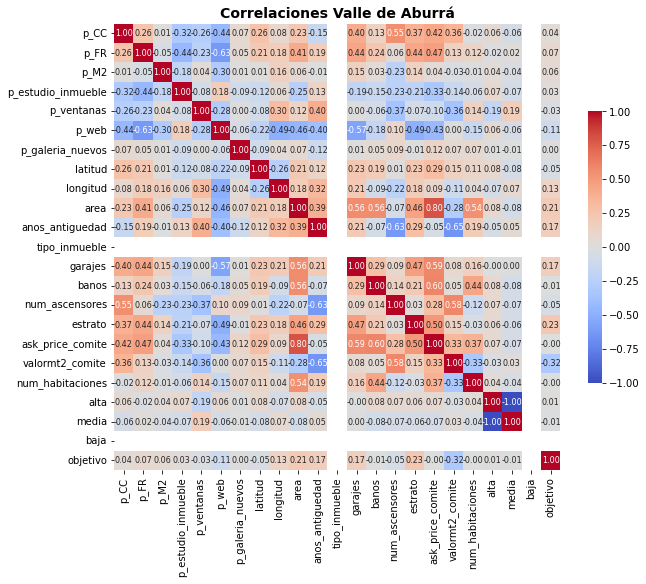

In [39]:
plt.figure(figsize=(10,10))
sns.heatmap(data=corrs_baq,square=True,annot=True,annot_kws={'size': 8},fmt= '.2f',cmap='coolwarm',cbar_kws={"shrink": 0.5})
plt.xticks(rotation = 90,fontsize=10, horizontalalignment='center')
plt.yticks(rotation = 0,fontsize=10)
plt.title("Correlaciones Valle de Aburrá",fontsize=14, weight='bold')
plt.show()

In [201]:
aptos_baq = heat_baq[heat_baq.tipo_inmueble == 1].drop(columns=['tipo_inmueble']).copy()
#aptos_baq = aptos_baq[[col for col in aptos_baq.columns if aptos_baq[col].sum()!=0]]
casas_baq = heat_baq[heat_baq.tipo_inmueble == 2].drop(columns=['tipo_inmueble']).copy()
#casas_baq = casas_baq[[col for col in casas_baq.columns if casas_baq[col].sum()!=0]]
tipo_inmueble_heat_baq = [aptos_baq,casas_baq]

All-NaN slice encountered
All-NaN slice encountered


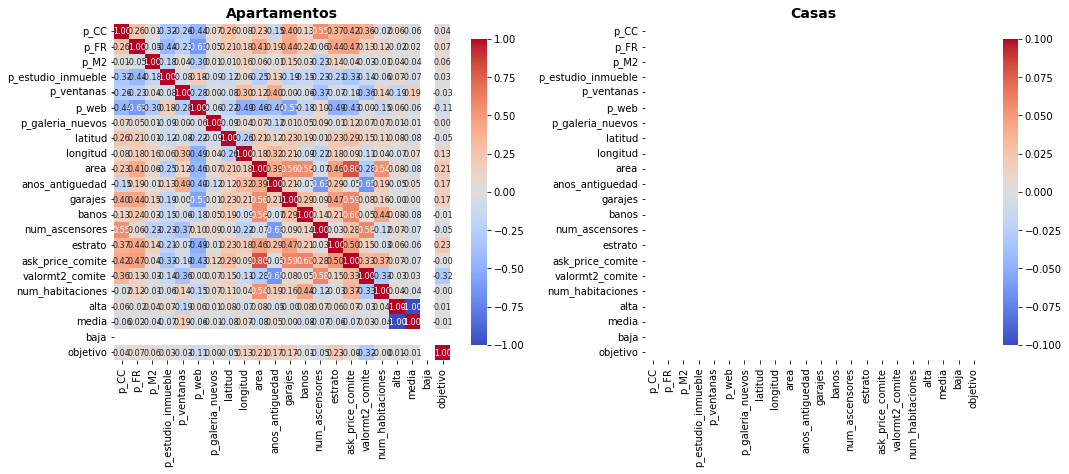

In [202]:
property_names = ['Apartamentos','Casas']
plt.figure(figsize=(15,9))
for i in range(len(tipo_inmueble_heat_baq)):
    try:
        plt.subplot(1,2,i+1)
        sns.heatmap(data=tipo_inmueble_heat_baq[i].corr(),
                    square=True,annot=True,annot_kws={'size': 8},fmt= '.2f',cmap='coolwarm',cbar_kws={"shrink": 0.5})
        plt.xticks(rotation = 90,fontsize=10, horizontalalignment='center')
        plt.yticks(rotation = 0,fontsize=10)
        plt.title(property_names[i],fontsize=14, weight='bold')
    except:
        continue
plt.tight_layout()
plt.show()

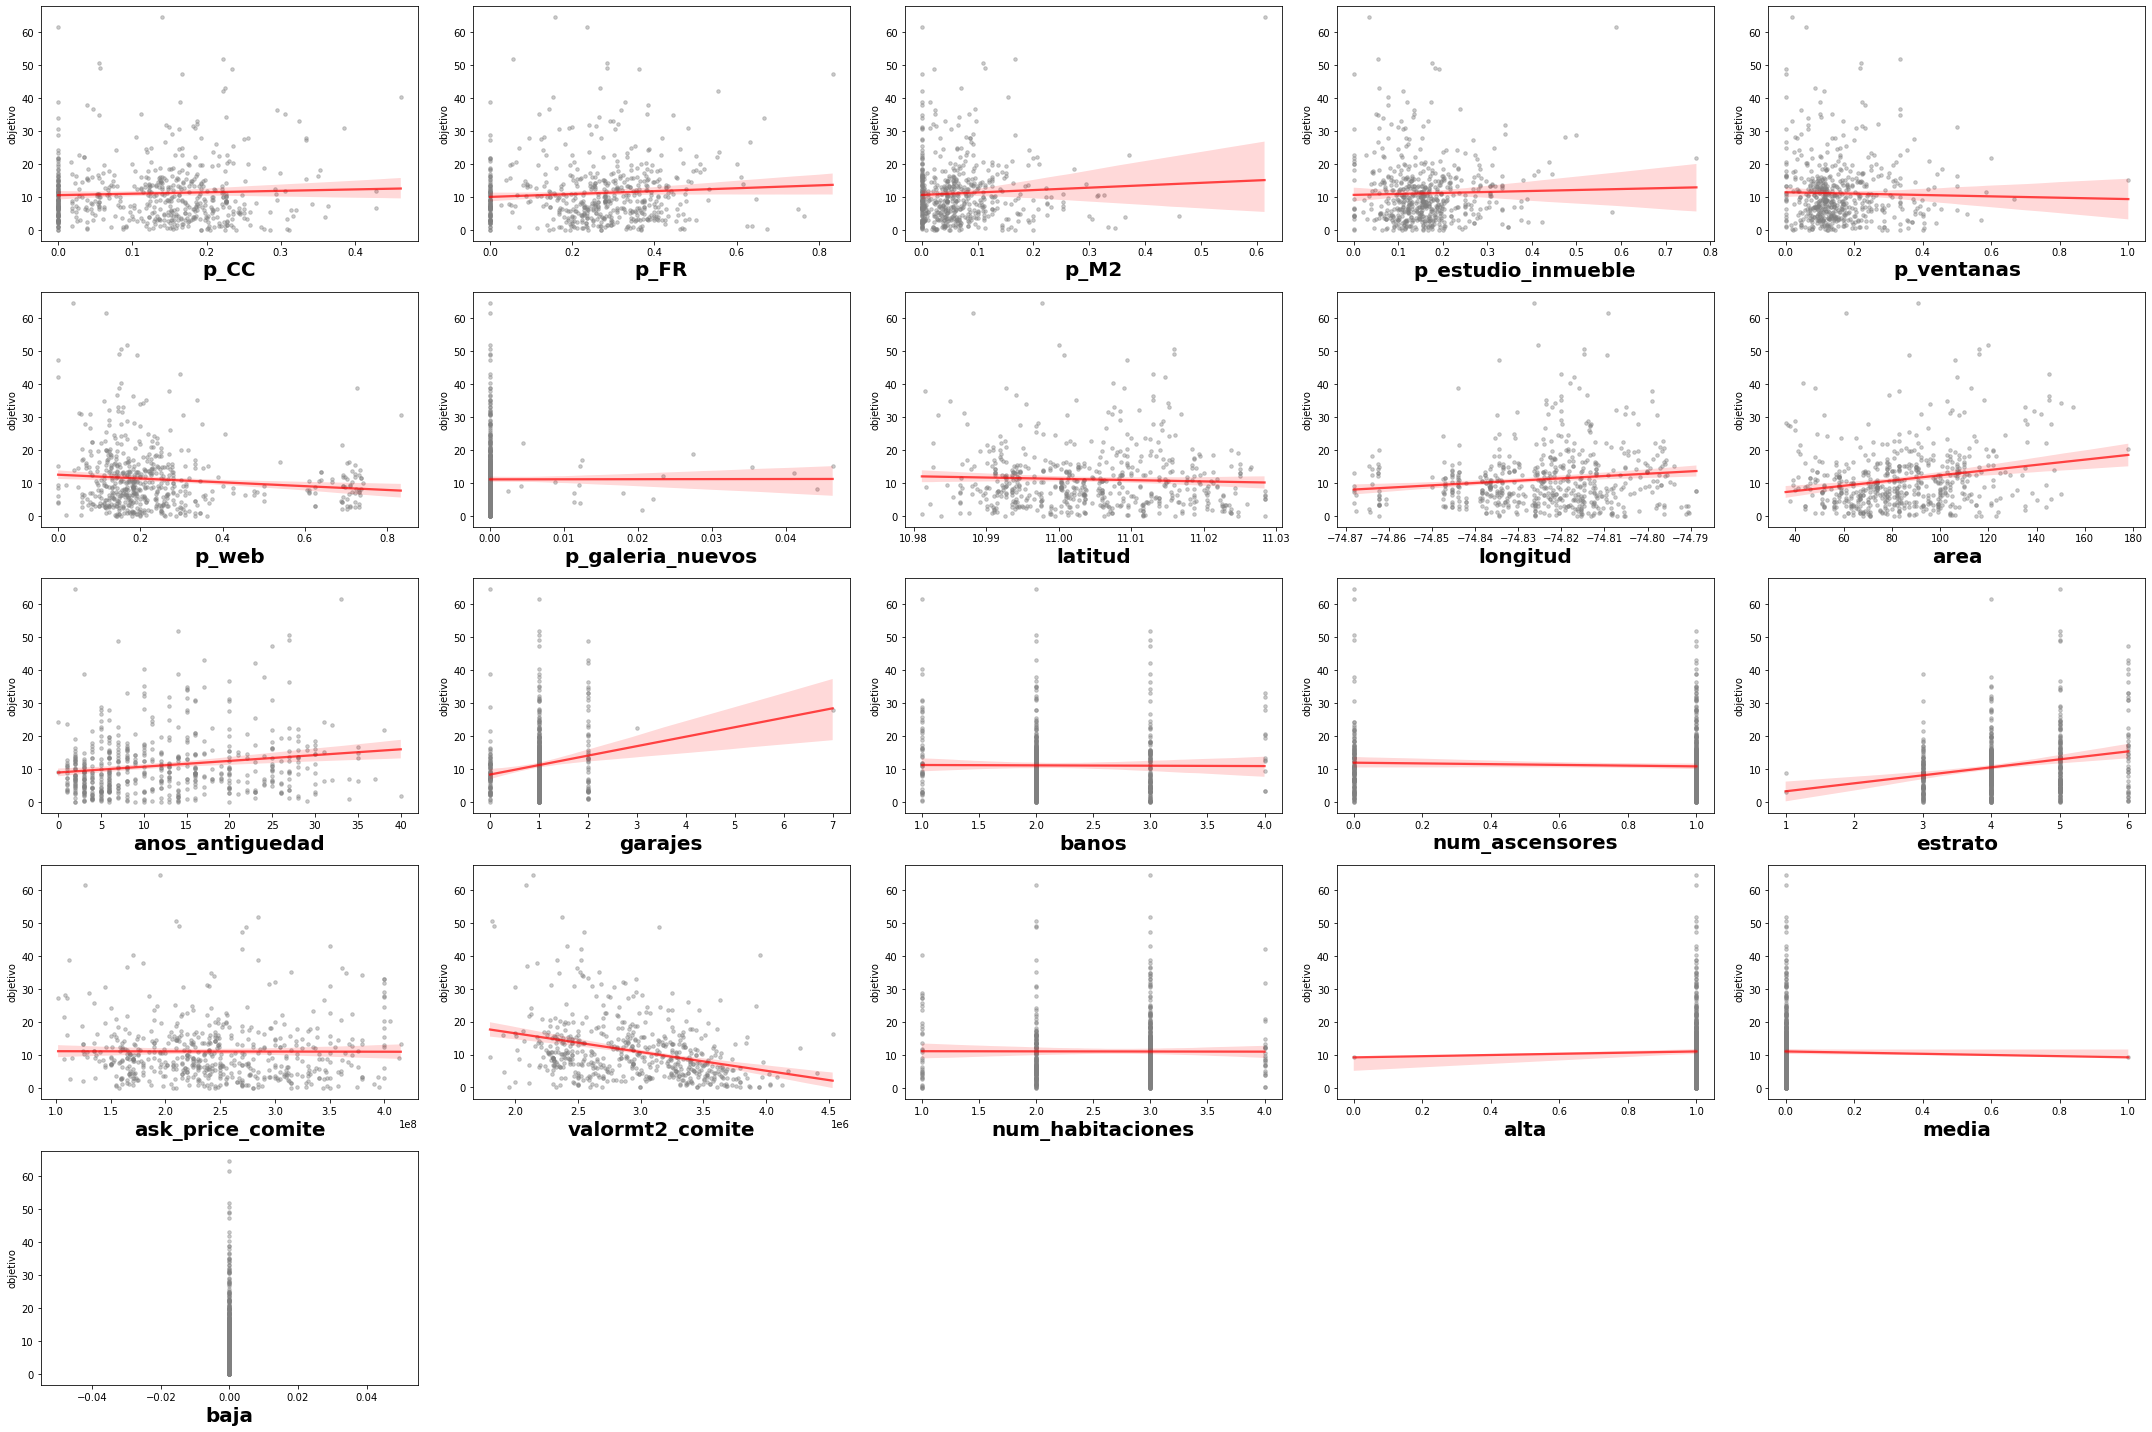

In [207]:
plt.figure(figsize=(30,20))
for idx,col in enumerate(aptos_baq.columns):
    if col !='objetivo':
        plt.subplot(5,5,idx+1)
        sns.regplot(
            x           = aptos_baq[col],
            y           = aptos_baq['objetivo'],
            color       = "gray",
            marker      = '.',
            scatter_kws = {"alpha":0.4,"s":50},
            line_kws    = {"color":"r","alpha":0.7}
        )
        #plt.title(f'{col} vs abs(diferencia_pp_comite)*100', fontweight='bold',fontsize=18, color='#490089')
        plt.xlabel(col, fontweight='bold',fontsize=20)
        #plt.ylabel('abs(diferencia_pp_comite)*100', fontweight='bold',fontsize=18)
plt.tight_layout()

In [208]:
#Un garaje raro
aptos_baq.garajes.min(),aptos_baq.garajes.max()


(0, 7)

In [209]:
aptos_baq[aptos_baq['garajes']>2]

p_CC      p_FR      p_M2  p_estudio_inmueble  p_ventanas     p_web  \
815   0.256410  0.094017  0.085470            0.076923    0.136752  0.350427   
1196  0.216667  0.500000  0.033333            0.066667    0.100000  0.083333   

      p_galeria_nuevos   latitud  longitud  area  ...  banos  num_ascensores  \
815                0.0  11.01413 -74.81991   146  ...      2               1   
1196               0.0  11.01365 -74.81220   136  ...      3               1   

      estrato  ask_price_comite  valormt2_comite  num_habitaciones  alta  \
815       6.0       400000000.0     2.739726e+06                 3     1   
1196      5.0       370000000.0     2.720588e+06                 3     1   

      media  baja   objetivo  
815       0     0  27.750000  
1196      0     0  22.522523  

[2 rows x 22 columns]